The `Grizli` pipeline allows you to fully reduce a given set of HST grism observations with essentially two steps:

* Run an archive query with [`hsaquery`](https://github.com/gbrammer/esa-hsaquery)

* Process the associations found with the query with `grizli.auto_script.go`.

Here, "association" usually simply means "any Hubble exposures that overlap" and doesn't require that all observations were taken with the same observing program, instrument, grism position angle, epoch, filter, etc.  The code does all of the exposure-level book-keeping and the products are drizzled image mosaics, extracted 1D and 2D grism spectra and fits to the spectra.

**NB**: The pipeline works fine with just imaging and no grism exposures!

In [1]:
#cell 1
%matplotlib inline

In [2]:
#cell 2
import glob
import time
import os

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

import astropy.io.fits as pyfits
import drizzlepac

import grizli
from grizli.pipeline import auto_script 
from grizli import utils
from grizli import fitting
from grizli import multifit #original line, replaced by cell above 

utils.set_warnings()
print('\n Grizli version: ', grizli.__version__)

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol

 Grizli version:  0.8.0-45-g977ade9


In [3]:
#cell 3
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


## Query the HST archive ##

The `hsaquery` module can be used to programaticaly query the HST archive and find exposures from different programs (and instruments) that overlap on the sky.  The example below is tailored for a single pointing from a single program, but the query parameters can be expanded to search much more broadly for archival data.

In [4]:
#cell 4
### Generate a query for the WFC3/ERS grism data

## !! new query tools since ESA database changed in summer 2018
# https://github.com/gbrammer/mastquery
from mastquery import query, overlaps

# "parent" query is grism exposures in GO-11359.  Can also query the archive on position with
# box=[ra, dec, radius_in_arcmin]
parent = query.run_query(box=None, proposal_id=[12945], instruments=['WFC3/IR', 'ACS/WFC'], 
                         filters=['G102','G141'])

# ### "overlap" query finds anything that overlaps with the exposures 
# ### in the parent query
# extra = query.DEFAULT_EXTRA # ignore calibrations, etc.

# ## To match *just* the grism visits, add, e.g., the following:
# extra += ["TARGET.TARGET_NAME LIKE 'WFC3-ERSII-G01'"]

tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                              filters=['F105W', 'F814W','G102'], 
                              proposal_id=[12945], instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC']) 
                              #,extra={'target_name':'CL1059-12.0'}, close=False)

Iter #1, N_Patch = 14


 0 j105908m1246 164.779 -12.773
target_name
-----------
CL1059-12.0 

filter j105908m1246         WFC3/IR F105W    1     811.7
filter j105908m1246          WFC3/IR G102    1    4711.7


 1 j105900m1253 164.747 -12.878
target_name
-----------
        ANY
CL1059-12.1 

filter j105900m1253         ACS/WFC F814W    1     460.0
filter j105900m1253         WFC3/IR F105W    1     811.7
filter j105900m1253          WFC3/IR G102    1    4711.7


 2 j105912m1254 164.794 -12.903
target_name
-----------
CL1059-12.2 

filter j105912m1254         WFC3/IR F105W    1     811.7
filter j105912m1254          WFC3/IR G102    1    4711.7


 3 j105836m1254 164.644 -12.893
target_name
-----------
CL1059-12.3 

filter j105836m1254         WFC3/IR F105W    1     811.7
filter j105836m1254          WFC3/IR G102    1    4711.7


 4 j113812m1134 174.554 -11.573
target_name
-----------
CL1138-11.0 

filter j113812m1134         WFC3/IR F105W    1     811.7
filter j113812m1134          WFC3/IR

In [5]:
#cell 5
# Summary of the tables you just generated
foot_files = glob.glob('j[02]*footprint.fits')
print('Footprint files: ', foot_files)

print('\n# id            ra         dec        e(b-v)   filters')
for tab in tabs:
    print('{0}  {1:.5f}  {2:.5f}   {3:.4f}   {4}'.format(tab.meta['NAME'], tab.meta['RA'], 
                                                 tab.meta['DEC'], tab.meta['MW_EBV'],
                                                  ','.join(np.unique(tab['filter']))))

Footprint files:  []

# id            ra         dec        e(b-v)   filters
j105908m1246  164.77900  -12.77300   0.0281   F105W,G102
j105900m1253  164.74700  -12.87800   0.0273   F105W,F814W,G102
j105912m1254  164.79400  -12.90300   0.0270   F105W,G102
j105836m1254  164.64400  -12.89300   0.0291   F105W,G102
j113812m1134  174.55400  -11.57300   0.0172   F105W,G102
j113848m1134  174.70000  -11.57500   0.0174   F105W,G102
j113736m1125  174.39300  -11.42300   0.0217   F105W,G102
j122756m1136  186.98400  -11.60300   0.0409   F105W,F814W,G102
j122752m1140  186.96700  -11.66100   0.0398   F105W,G102
j122816m1132  187.07100  -11.52800   0.0433   F105W,G102
j130132m1138  195.37900  -11.62600   0.0411   F105W,F814W,G102
j130120m1133  195.34100  -11.54500   0.0415   F105W,G102
j130132m1142  195.38900  -11.69800   0.0407   F105W,F814W,G102
j130100m1131  195.24700  -11.52100   0.0405   F105W,G102


In [6]:
#cell 6
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Pipeline processing - #

** In principle, all of the steps outlined below can be executed with a single call to** `auto_script.go`, from fetching the data to extracting spectra and performing the redshift / line fits.  The processing steps been broken out individually here to show the processing at each step.

** The same pipeline can be used to process imaging-only fields.**  Simply run the queries as above to find the imaging exposures you want to processes and run everything the same way.  The pipeline steps related to the grism exposures will simply be skipped.

In [8]:
#cell 7
# Do everything for the query from fetching the data to generating the contamination model
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

"CHANGE FILE DIRECTORY HERE"
root = 'j122756m1136'
IS_PARALLEL = False # Set to True for parallel programs like WISPS

if False:
    # This line would do everything below
    auto_script.go(root=root, maglim=[19,21], HOME_PATH=HOME_PATH, reprocess_parallel=True, 
                   s3_sync='cp', gaia_by_date=True, is_parallel_field=IS_PARALLEL, 
                   run_fit=False, only_preprocess=True, run_extractions=False)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Individual steps - #

## Fetch data from the HST archive ##
`Grizli` can automatically fetch HST data from the ESA Hubble Science archive (and, optionally, the Amazon S3 bucket).  The `fetch_files` script fetches the exposures listed in the archive query above.  It also fetches associated WFC3/IR persistence products from the persistence database.

The first time you run the script, a lot more information will be printed to the screen as the exposures are retrieved and the script runs the reprocessing code to flatten the IR backgrounds.  Below the "skip" message simply indicate that files have already been downloaded.

In [9]:
#cell 8 THIS TAKES A LONG TIME
### Fetch data, reprocess WFC3/IR for backgrounds, fetch WFC3/IR persistence productss

# If s3_sync, then sync from the Hubble Amazon S3 bucket with awscli, 
# otherwise get from the ESA archive.
os.chdir(HOME_PATH)

import grizli.pipeline
from grizli.pipeline import auto_script
# Is awscli available and connected? 
s3_status = os.system('aws s3 ls s3://stpubdata --request-payer requester')
if s3_status == 0:
    s3_sync='cp'  # As of late October 2018, 's3 sync' not working with 'stpubdata'
else:
    s3_sync=False # Fetch from ESA archive
    
auto_script.fetch_files(field_root=root, HOME_PATH=HOME_PATH, remove_bad=True, 
                        reprocess_parallel=True, s3_sync=s3_sync)

Calib: IDCTAB=jref$0461802dj_idc.fits
/home/jrcooper/grizli/jref/0461802dj_idc.fits exists
Calib: PFLTFILE=jref$qb12257pj_pfl.fits
/home/jrcooper/grizli/jref/qb12257pj_pfl.fits exists
Calib: NPOLFILE=jref$02c1450rj_npl.fits
/home/jrcooper/grizli/jref/02c1450rj_npl.fits exists
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=jref$0461802dj_idc.fits
/home/jrcooper/grizli/jref/0461802dj_idc.fits exists
Calib: PFLTFILE=jref$qb12257pj_pfl.fits
/home/jrcooper/grizli/jref/qb12257pj_pfl.fits exists
Calib: NPOLFILE=jref$02c1450rj_npl.fits
/home/jrcooper/grizli/jref/02c1450rj_npl.fits exists
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits


## Parse visit associations ##
`Grizli` builds its own associations based on anything it finds in the `RAW` directory.  Visits are usually defined in the exposure filenames.  For example, for the single exposure, `ib6o03ntq_flt.fits`, the characters `b6o` identify the observing program and the visit identifier  is `03`.  You can also build visits combining all exposures in a given filter taken at the same position angle, which can be useful for some programs executed in parallel where exposures taken at a similar time could have different visit IDs in the filename.  

**NB:** Generally one should process "visits" as groups of exposures in a given filter that were taken with a single guide star acquisition.  

The parsing script also associates grism exposures with corresponding direct images, based on the visit, exposure order and exposure footprints on the sky.

In [10]:
#cell 11
# Demo combining by PA / filter.  

# Here it actually gets a bit confused because multiple F098M exposures 
# were taken at the same PA but shouldn't be associated with the grism exposures.
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=True)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1227-11.0-c1b-08-129.0-F105W 4
CL1227-11.0-c1b-08-129.0-G102 4
jc1b10-c1b-10-179.0-F814W 4

 == Grism groups ==

ic1b-129.0-f105w 4 ic1b-129.0-g102 4


ic1b-129.0-f105w                4
ic1b-129.0-g102                 4
ic1b-179.0-f814w                4


In [11]:
#cell 12
######################
### Parse visit associations for most normal programs
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=IS_PARALLEL)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1227-11.0-c1b-08-129.0-F105W 4
CL1227-11.0-c1b-08-129.0-G102 4
jc1b10-c1b-10-179.0-F814W 4

 == Grism groups ==

cl1227-11.0-c1b-08-129.0-f105w 4 cl1227-11.0-c1b-08-129.0-g102 4


cl1227-11.0-c1b-08-129.0-f105w  4
cl1227-11.0-c1b-08-129.0-g102   4
jc1b10-c1b-10-179.0-f814w       4


## Master Pre-processing script: `grizli.prep.process_direct_grism_visit` ##

The `process_direct_grism_visit` script in [prep.py](https://github.com/gbrammer/grizli/blob/master/grizli/prep.py) provides one-stop-shopping for all of the preprocessing steps required.  This includes

* File handling (e.g., copying from `./RAW` to `./Prep/`)
* Astrometric registration
* Grism sky background subtraction & flat-fielding
* Extract visit-level catalogs and segmentation images from the direct imaging

The products of the script for a given direct/grism pair are 

* Aligned, background-subtracted FLTs
* Drizzled mosaics of direct & grism images

The script also runs on *imaging-only* visits, performing the background subtraction and astrometric alignment but skipping anything related to grism processing.

The `auto_script.preprocess` command below runs the processing script for the two direct/grism pairs of the ERS observations and for the overlapping imaging visits identified in the initial query.  It prints a bunch of information to the terminal, primarily from various runs of AstroDrizzle, and takes a few minutes to run per visit.  It only needs to be run once.

**NB** If you restart the pipeline after a previous run, it will skip preprocessing any visit where the file `{visit-product}_dr?_sci.fits` is found (i.e., the "Skip" messages below).  If you want to force reprocessing of a visit, delete that file.

In [12]:
#####################
### Alignment & mosaics    
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

# Alignment reference catalogs, searched in this order
catalogs = ['NSC', 'PS1','SDSS','GAIA','WISE'] 
# As of v0.8.0-8, can use the NOAO source catalog (NSC) here, which 
# is defined over much of the sky and appears to be well aligned to GAIA.  
# However, sometimes it's not clear how to apply the best quality control 
# to the NSC sources.  Here, for example, there seem to be a number of spurious 
# NSC sources that make the initial alignment RMS fairly high. 

# This script will do all the preprocessing of the grism *and* imaging visits 
# found in your archive query.
auto_script.preprocess(field_root=root, HOME_PATH=HOME_PATH, 
                       make_combined=False, catalogs=catalogs, use_visit=True)

0 cl1227-11.0-c1b-08-129.0-f105w 4 cl1227-11.0-c1b-08-129.0-g102 4
Skip cl1227-11.0-c1b-08-129.0-f105w
Skip cl1227-11.0-c1b-08-129.0-f105w
Skip jc1b10-c1b-10-179.0-f814w
Skip cl1227-11.0-c1b-08-129.0-g102
utils.fix_flt_nan: jc1b10ikq_flc.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: jc1b10ikq_flc.fits[SCI,2] NaNPixels=0
utils.fix_flt_nan: ic1b08beq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: jc1b10idq_flc.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: jc1b10idq_flc.fits[SCI,2] NaNPixels=0
utils.fix_flt_nan: ic1b08b7q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b08aqq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: jc1b10irq_flc.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: jc1b10irq_flc.fits[SCI,2] NaNPixels=0
utils.fix_flt_nan: ic1b08bcq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b08atq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b08b5q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b08b0q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: jc1b10i5q_flc.fits[SCI,1] NaNPixels

In [13]:
!ls wfc3*sci.fits # individual drizzled visits

ls: cannot access wfc3*sci.fits: No such file or directory


In [14]:
# Results of the intra-visit alignment.  
# Should be small as these are just FGS drift on a single guide star
!ls *shifts.log
print('')
!cat *shifts.log

cl1227-11.0-c1b-08-129.0-f105w_shifts.log  jc1b10-c1b-10-179.0-f814w_shifts.log

# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['ic1b08aqq_flt.fits'] = ['ic1b08atq_flt.fits']
# match['ic1b08ayq_flt.fits'] = ['ic1b08b0q_flt.fits']
# match['ic1b08b5q_flt.fits'] = ['ic1b08b7q_flt.fits']
# match['ic1b08bcq_flt.fits'] = ['ic1b08beq_flt.fits']
ic1b08aqq_flt.fits  -0.000   0.000  0.00000  1.00000    50  0.000  0.000
ic1b08ayq_flt.fits  -0.043  -0.071  0.00000  1.00000    46  0.040  0.045
ic1b08b5q_flt.fits  -0.029   0.012  0.00000  1.00000    44  0.029  0.048
ic1b08bcq_flt.fits   0.068  -0.044  0.00000  1.00000    44  0.026  0.045
# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['jc1b10i5q_flc.fits'] = []
# match['jc1b10idq_flc.fits'] = []
# match['jc1b10ikq_flc.fits'] = []
# match['jc1b10irq_flc.fits'] = []
jc1b10i5q_flc.fits   0.000  -0.000  0.00000  1.00000    50  0.000  0.000
jc1b10idq_flc.fits   0.159  -0.106  0.00000  1.00000    42  0.085  0.059
jc1b1

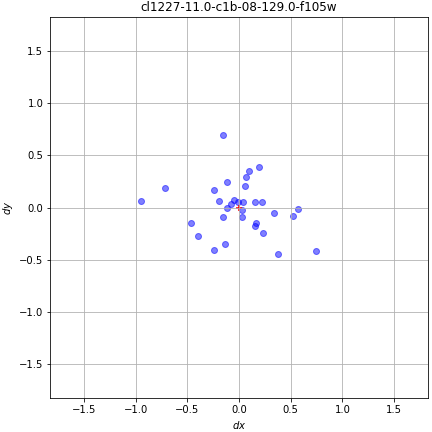

In [15]:
# Show the alignment w.r.t the external NOAO Source Catalog (NSC)
Image(filename = "./cl1227-11.0-c1b-08-129.0-f105w_wcs.png") 


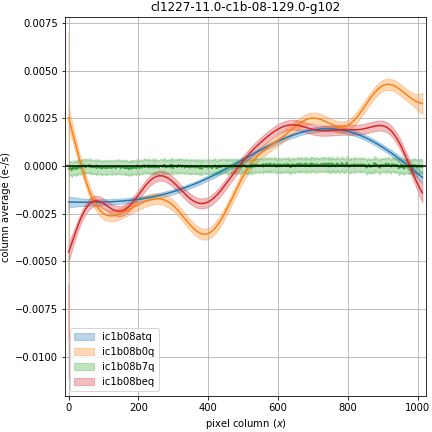

In [16]:
# Show the alignment of one HST visit to another, note tight 
# plot range compared to previous
Image(filename = "./cl1227-11.0-c1b-08-129.0-g102_column.png") 

In [17]:
# Check wcs.log files that a few objects were found, no large rotations
# and rms (second to last column) isn't too large

# Here, the F098M/G102 visit was the first processed and was aligned 
# to the NSC, with RMS~0.8 WFC3/IR pix.  Subsequent visits are aligned to 
# previously processed HST visits so that at least the relative HST astrometry
# is as good as possible.  Here, the F140W/G141 visit was run second and was 
# therefore aligned to F098M, resulting in much better precision than with the
# external catalog (RMS < 0.1 pix).

# Cat wcs.log files in order they were generated
!grep " 0 " `ls -ltr *wcs.log | awk '{print $9}'` | sed "s/  */ /g"

# columns: 
# "visit"  0  xshift yshift rot scale rms N

cl1227-11.0-c1b-08-129.0-f105w_wcs.log: 0 -1.2393 0.0254 -0.0007 1.00005 0.261 32
jc1b10-c1b-10-179.0-f814w_wcs.log: 0 8.0249 1.6118 -0.0052 0.99972 0.113 23


### Alignment failures ###

The main failure mode of the `auto_script.preprocess` script is failure to compute a reliable alignment to the external reference.  This can happen, e.g., if there are not enough alignment sources (i.e., zero) within the field of view or if the original astrometry of the exposures obtained from the archive is offset from the reference by more than ~10 pixels.  This can almost always be remedied by running `grizli.pipeline.auto_script.manual_alignment` after the files have been fetched, which prompts the user to interactively mark sources in the image and reference catalog using DS9.

In [18]:
if False: # Don't run
    catalogs = ['PS1','SDSS','GAIA','WISE']
    auto_script.manual_alignment(field_root=root, HOME_PATH=HOME_PATH, skip=True, 
                                 catalogs=catalogs, radius=15, visit_list=None)

### Grism sky subtraction ###

The grism sky backgrounds are subtracted using the "Master sky" images from [Brammer, Ryan, & Pirzkal 2015](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-17.pdf) (available [here](http://www.stsci.edu/hst/wfc3/analysis/grism_obs/calibrations/wfc3_grism_master_sky.html)).  

`Grizli` ignores any wavelength dependence of the flat-field and applies a grey correction using the F140W (F105W) flat-field for the G141 (G102) grisms.

Residuals after subtracting the master sky images are typically of order 0.005 e-/s, just 0.5-1% overall background level.  They are removed by subtracting a column-average of the sky pixels in the grism exposures, and the processing script produces a diagnostic figure like the one shown below.  The source of the residuals is still unclear (e.g., perhaps spectra of objects near/below the detection limit).  Though they are usually well removed by the column average, they do make extracting continuum spectra of faint sources challenging.

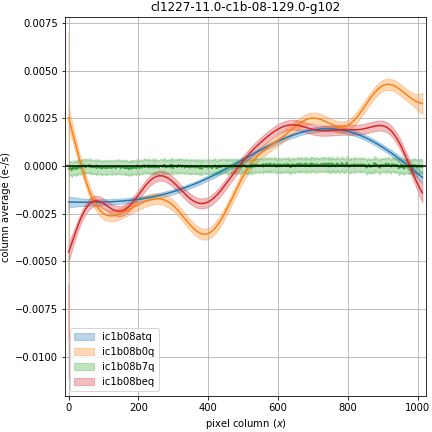

In [19]:
from IPython.display import Image
Image(filename = "./cl1227-11.0-c1b-08-129.0-g102_column.png", width=600, height=600)

### Fine alignment to GAIA DR2 ###

The initial visit alignment scripts often show small drifts such that the differen't visits don't perfectly overlap.  The script below performs an additional realignment to the visits internally and also to an external reference, usually GAIA DR2.

In [20]:
# Fine alignment of the visits relative to each other and absolute to GAIA DR2
if len(glob.glob('{0}*fine.png'.format(root))) == 0:
    fine_catalogs = ['GAIA','PS1','SDSS','WISE']
    out = auto_script.fine_alignment(field_root=root, HOME_PATH=HOME_PATH, 
                                     min_overlap=0.2, stopme=False, ref_err=0.08, 
                                     catalogs=fine_catalogs, NITER=1, maglim=[17,23],
                                     shift_only=True, method='Powell', redrizzle=False, 
                                     radius=10, program_str=None, match_str=[], 
                                     gaia_by_date=True)

    # Update headers with the result from the fine alignment
    # Original FLTs are archived to FineBkup
    auto_script.update_wcs_headers_with_fine(root)
    
visits, res = np.load('{0}_fine.npy'.format(root))
shifts = res.x.reshape((-1,2))/10.
for i, visit in enumerate(visits):
    print('{0:35}  {1:6.2f}  {2:6.2f}'.format(visit['product'], shifts[i,0], shifts[i,1]))

cl1227-11.0-c1b-08-129.0-f105w         0.21   -0.07
jc1b10-c1b-10-179.0-f814w             -0.69    0.31


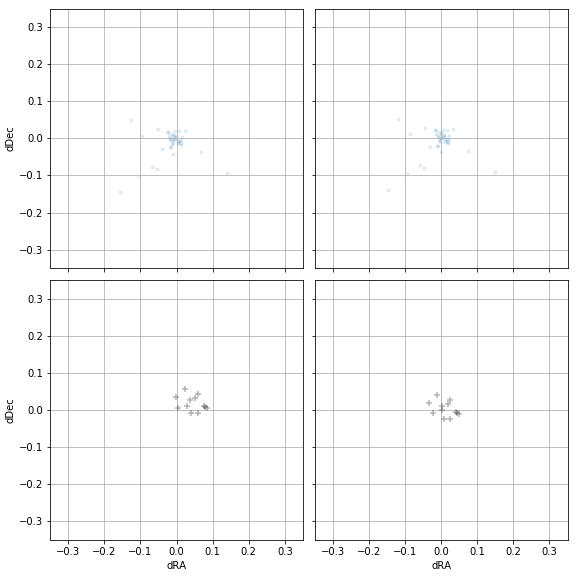

In [21]:
# Show the results of fine alignment.  
# Top panels are alignment between the visits.  + in the bottom panels are 
# residuals of the external reference, here GAIA DR2.
#
# Small drift between individual visits removed.  
# Fairly large GAIA offsets probably due to ~6 years between 
# WFC3/ERS and GAIA epoch 2015.5.
Image(filename='{0}_fine.png'.format(root))

## Make combined mosaics for each available filter ##

These are used to generate a photometric catalog and also for the direct image reference for the grism

In [22]:
# Drizzle mosaics in each filter and combine all IR filters
combine_all_filters=True
if len(glob.glob('{0}-ir_dr?_sci.fits'.format(root))) == 0:

    ## Mosaic WCS
    wcs_ref_file = '{0}_wcs-ref.fits'.format(root)
    if not os.path.exists(wcs_ref_file):
        auto_script.make_reference_wcs(info, output=wcs_ref_file, 
                           filters=['G800L', 'G102', 'G141'], 
                           pad_reference=90, pixel_scale=None,
                           get_hdu=True)

    # All combined
    IR_filters = ['F105W', 'F110W', 'F125W', 'F140W', 'F160W', 
                  'F098M', 'F139M', 'F127M', 'F153M']

    optical_filters = ['F814W', 'F606W', 'F435W', 'F850LP', 'F702W', 'F555W', 'F438W', 'F475W', 'F625W', 'F775W', 'F225W', 'F275W', 'F300W', 'F390W']

    if combine_all_filters:
        auto_script.drizzle_overlaps(root, 
                                 filters=IR_filters+optical_filters, 
                                 min_nexp=1, 
                                 make_combined=True,
                                 ref_image=wcs_ref_file,
                                 drizzle_filters=False) 

    ## IR filters
    auto_script.drizzle_overlaps(root, filters=IR_filters, 
                                 min_nexp=1, 
                                 make_combined=(not combine_all_filters),
                                 ref_image=wcs_ref_file) 

    # Fill IR filter mosaics with scaled combined data so they can be used 
    # as grism reference
    auto_script.fill_filter_mosaics(root)

    ## Optical filters

    mosaics = glob.glob('{0}-ir_dr?_sci.fits'.format(root))

    auto_script.drizzle_overlaps(root, filters=optical_filters,
        make_combined=(len(mosaics) == 0), ref_image=wcs_ref_file,
        min_nexp=2) 

In [23]:
!ls -1 j*_dr?_sci.fits

j122756m1136-f105w_drz_sci.fits
j122756m1136-f814w_drc_sci.fits
j122756m1136-ir_drc_sci.fits
jc1b10-c1b-10-179.0-f814w_drc_sci.fits


## Generate a photometric catalog ##

Run source detection on the combined mosaic `{root}-ir_dr[cz]_sci.fits` and generates a catalog and segmentation image.  

Then perform simple matched-aperture photometry on the different available filter mosaics (in this case F098M and F140W from the direct imaging).  In principle the template fitting code shown below can incorporate this photometric information, though that's not currently done by default.

In [24]:
## Run SEP (~SExtractor clone) catalog on the "ir" combined image
## and generate a photometric catalog with aperture photometry in all available bands
if not os.path.exists('{0}_phot.fits'.format(root)):
    get_background=False # SExtractor background subtraction
    tab = auto_script.multiband_catalog(field_root=root, threshold=1.8,
                                        detection_background=get_background,
                                        photometry_background=get_background) 
    
files = glob.glob('{0}-ir*'.format(root)) + glob.glob('*phot*fits')
for file in files:
    print(file)
    
phot = utils.GTable.gread('{0}_phot.fits'.format(root))
print('{0}Metadata{0}'.format('\n'+'='*20+'\n'))
for k in phot.meta:
    print('{0}:\t{1}'.format(k, phot.meta[k]))

j122756m1136-ir.cat.fits
j122756m1136-ir_bkg.fits
j122756m1136-ir_drc_wht.fits
j122756m1136-ir_drc_sci.fits
j122756m1136-ir_seg.fits
j122756m1136_phot.fits

Metadata

MINAREA:	5
CLEAN:	True
DEBCONT:	0.005
DEBTHRSH:	32
FILTER_TYPE:	conv
THRESHOLD:	1.8
ZP:	26.26887001774306
PLAM:	10551.047
FNU:	1.1283712e-07
FLAM:	3.0386574e-20
UJY2DN:	8.861796202091552
DRZ_FILE:	j122756m1136-ir_drc_sci.fits
WHT_FILE:	j122756m1136-ir_drc_wht.fits
GET_BACK:	False
ERR_SCALE:	0.9137609004974365
APER_0:	6.00000000000013
ASEC_0:	0.36
APER_1:	8.33500000000018
ASEC_1:	0.5001
APER_2:	16.33700000000036
ASEC_2:	0.9802200000000001
APER_3:	20.00000000000043
ASEC_3:	1.2
F105W_ZP:	26.26887001774306
F105W_PLAM:	10551.047
F105W_FNU:	1.1283712e-07
F105W_FLAM:	3.0386574e-20
F105W_uJy2dn:	8.861796202091552
F105W_DRZ_FILE:	j122756m1136-f105w_drz_sci.fits
F105W_WHT_FILE:	j122756m1136-f105w_drz_wht.fits
F105W_GET_BACK:	False
F105W_ERR_SCALE:	0.5106384754180908
F105W_aper_0:	6.00000000000013
F105W_asec_0:	0.36
F105W_aper_1:	8.

In [25]:
phot[:2].show_in_notebook()

## Building the grism exposure container: `multifit.GroupFLT` ##

With the preprocessing done, we can now start on the analysis of the spectra.  `Grizli` is built around low-level tools for modeling and analyzing each individual grism exposure individually.  Though once multiple exposures are available (e.g., exposures within a visit or separate visits with different grisms and/or orients) the information from each can be combined for analyzing the spectrum of a given object.  A benefit of the exposure-level processing is that all of the model-to-data comparisons (i.e. chi-squared) are done in the space of the original detector pixels, with their well-calibrated and well-understood noise properties.

The `GroupFLT` class provides a container for processing multiple FLT exposures simultanously.

### Inputs ###
* `grism_files` = list of grism exposure filenames
* `direct_files` = (optional) list of direct exposure filenames
* `ref_file` = (optional) reference direct image mosaic (one or the other of `ref_file` or `direct_files` should be specified.)
* `seg_file`, `catalog` = segmentation image and catalog, usually generated with SExtractor
* `cpu_count` = set to > 0 for parallel processing
* `pad` parameter (default=200 pixels).  If set, then add padding around the FLTs to enable modeling of objects that would fall off of the direct image but that still disperse spectra onto the grism exposure (assuming they fall in the `ref_file` and `seg_file` mosaics).

The contents of the `grism_files` list can contain pretty much anything, with the result limited by memory / cpu power.  For example, you can provide a list of **all** 112 of the 3D-HST G141 exposures in the COSMOS field (4 exposures x 28 pointings), along with the field mosaic and segmentation images.  This example is actually fairly easy to process as individual objects will fall in typically 4, perhaps 8 individual exposures in some overlap areas.  Another example is a list of exposures from multiple instruments / grisms / orients of a single field, thought the subsequent fits can be slow if an object has spectra in many individual exposures.

Reference images are blotted to the distorted exposure frame with `AstroDrizzle.ablot`.   Messages go by, as below, when you load the `GroupFLT` object talking about "cutouts" because the script tries to make smaller cutouts of large reference images to speed up the blot processing.

**NB** Seems to often have memory leak problems if `seg_file` isn't significantly larger than the footprint of a given FLT file.  Drizzle `blot` segfaults out but the script just hangs since the multiprocessing threads don't get the message.

### Flat continuum model ###

Once the `GroupFLT` object is initialized, compute a first-pass model of the full detector field of view assuming simple linear continua for all objects in the field (brighter than `mag_limit`).  By default this assumes a somewhat blue continuum suitable for the Rayleigh-Jeans tail of low-redshift objects.  It's far from perfect but the initial model does provide a good way of at least identifying which pixels of a given object could be contaminated by neighbors, even if the quantitative model is not precise.

### Refined polynomial continuum model ###

After computing the simple continuum model, refine the model spectra for brighter objects using higher-order polynomials fit directly to the spectra themselves.  The `refine_list` method marches through objects starting with the brightest and fits a polynomial of order `poly_order` to the observed spectrum after subtracting off the model for contaminants.  Note that if the list of grism exposures contained multiple orientations covering a single field, this fit can be well constrained even in the presence of contamination.

The `grism_prep` script iterates on the refined polynomial model `refine_niter` times.

### Save state ###

You can optionally dump saved data (i.e., `grp.save_full_data()`) for fast restart and avoid recomputing the contamination models, for example in a new Python session.  This can be done at any time after you've made changes to the GroupFLT data that you'd like to store for later.  The `grism_prep` script does this automatically.

In [26]:
files = glob.glob('*GrismFLT.fits')
if len(files) == 0:
    ### Grism contamination model
    os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

    # Which filter to use as direct image?  Will try in order of the list until a match is found.
    gris_ref = {'G141': ['F140W', 'F160W'], 
                'G102': ['F105W', 'F098M', 'F110W']}

    x = auto_script.grism_prep(field_root=root, refine_niter=3,
                                 gris_ref_filters=gris_ref)

    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)
    
else:
    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)

Load ic1b08b7q.01.GrismFLT.fits!
Load ic1b08atq.01.GrismFLT.fits!
Load ic1b08b0q.01.GrismFLT.fits!
Load ic1b08beq.01.GrismFLT.fits!
Files loaded - 4.13 sec.


### The final contamination model ###

IndexError: list index out of range

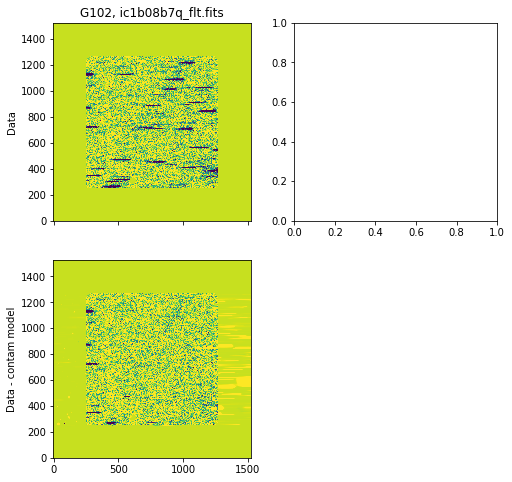

In [27]:
# Show the results of the contamination model
### Show FLT residuals
cmap = 'viridis_r'
vm = [-0.01, 0.1]

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(221)
flt = grp.FLTs[0] # G102

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([])
ax.set_ylabel('Data')

ax = fig.add_subplot(223)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_ylabel('Data - contam model')

ax = fig.add_subplot(222)
flt = grp.FLTs[4] # G141

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([]); ax.set_yticklabels([])

ax = fig.add_subplot(224)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_yticklabels([])

for ax in fig.axes:
    ax.set_xlim(510,790); ax.set_ylim(610,890)

fig.tight_layout(pad=1)

### Parameters for object fitting
### Read in LDP and match

In [29]:
h = open('/data2/jrcooper/notebooks/reduction/EDisCS/j122756m1136/Extractions/b_LDP_q.txt', 'r')
lines = h.readlines()[1:]
h.close()   
z_LDP       = []  
id_HST      = []   
ra_HST      = []
dec_HST     = [] 

for line in lines: 
    a = line.split()     
    z_LDP.append(float(a[3]))
    ra_HST.append(float(a[1]))
    dec_HST.append(float(a[2]))



z_LDP     = np.array(z_LDP)
ra_HST    = np.array(ra_HST)
dec_HST   = np.array(dec_HST)
id_HST     = np.array(id_HST) 


In [30]:
#### Store fit parameters to `fit_args.npy` for batch-mode processing

# Drizzle parameters for line maps
pline = auto_script.DITHERED_PLINE
#print(pline) 

sig = 0.007 
z = np.arange(0,2,.001)
for i in z_LDP:
    p_z = np.exp(-(z - i)**2/(2*sig**2))/((2*np.pi)**0.5/sig)

spec_prior = [z,p_z]
tuple
a = tuple(spec_prior)

# Generate the parameter dictionary
args = auto_script.generate_fit_params(field_root=root, prior=a, 
                                       MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                                fsps=True, sys_err = 0.03, fcontam=0.2, zr=[0.05, 3.4], 
                                save_file='fit_args.npy')

Saved arguments to fit_args.npy.


### Field PSF file ### 
Make an average effective PSF for each available IR filter by evaluating the field-dependent PSF across the final mosaic and drizzling to a common output.  Also make an extension with a PSF on the pixel grid of the drizzled line map parameters generated above (`pline`).  Each PSF is generated with the native pixel grid and 2/4x oversampling for use with, e.g., [GALFIT](https://users.obs.carnegiescience.edu/peng/work/galfit/galfit.html).

*NB* There is currently no ePSF for F098M, so F105W is used (http://www.stsci.edu/~jayander/STDPSFs/WFC3IR/).


In [31]:
# Make PSF file
if not os.path.exists('{0}-f105w_psf.fits'.format(root)):
    auto_script.field_psf(root=root, HOME_PATH=HOME_PATH)

['j122756m1136-f105w_psf.fits'] 

Filename: j122756m1136-f105w_psf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  PSF         LINE1 ImageHDU        29   (60, 60)   float32   
  2  PSF         LINE2 ImageHDU        29   (120, 120)   float32   
  3  PSF         LINE4 ImageHDU        29   (240, 240)   float32   
  4  PSF         DRIZ1 ImageHDU        29   (100, 100)   float32   
  5  PSF         DRIZ2 ImageHDU        29   (200, 200)   float32   
  6  PSF         DRIZ4 ImageHDU        29   (400, 400)   float32   


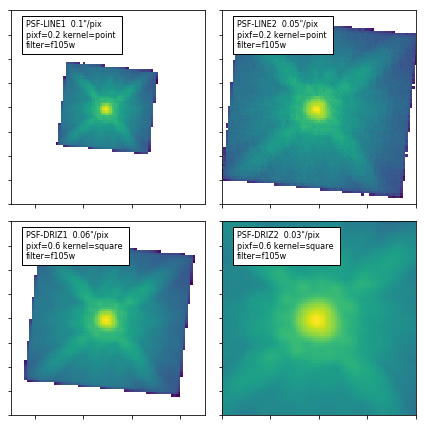

In [32]:
# Show the PSFs
print(glob.glob('*psf.fits'),'\n')

im = pyfits.open('{0}-f105w_psf.fits'.format(root))
im.info()

fig = plt.figure(figsize=[6,6])
for i, ext in enumerate([1,2,4,5]):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(np.log10(im[ext].data))
    
    h = im[ext].header
    label = '{0}-{1}  {2}"/pix \npixf={3} kernel={4} \nfilter={5}'.format(h['EXTNAME'],
                     h['EXTVER'], h['PSCALE'], h['PIXFRAC'], h['KERNEL'], h['FILTER'])
    
    ax.text(0.08, 0.95, label, ha='left', va='top', 
            transform=ax.transAxes, size=8, color='k',
            bbox={'fc':'w'})
    
    ax.set_xticklabels([]); ax.set_yticklabels([])
    
    sh = im[ext].data.shape
    ax.set_xlim(sh[1]/2-40, sh[1]/2+40)
    ax.set_ylim(sh[0]/2-40, sh[0]/2+40)
    
fig.tight_layout(pad=1)

## Extract and fit individual spectra ##

In [33]:
os.chdir('../Extractions')

In [34]:
### Find IDs of specific objects to extract
import grizli.pipeline
from grizli.pipeline import auto_script
import astropy.units as u
tab = utils.GTable()
tab['ra'] = ra_HST
tab['dec'] = dec_HST
idx, dr = grp.catalog.match_to_catalog_sky(tab)
source_ids = grp.catalog['NUMBER'][idx]
tab['id'] = source_ids
tab['dr'] = dr.to(u.mas)
tab['dr'].format='.1f'
tab.show_in_notebook()

### Extract 2D spectra "beams" ###

The `GroupFLT` object contains the entire exposure information, from which we can make cutouts of spectra for individual objects with the `get_beams` method.  These cutouts are more managable and portable than the entire exposures, though currently the processing does work in the paradigm of having a static contamination model for a given object.  

In pipeline mode, the function below is called with `ids=[], maglim=[mag_min, mag_max]` and all objects in the reference catalog with `mag_min < MAG_AUTO < mag_max` are extracted.  The redshift fits are performed if `run_fit=True`.

0/278: 159 0
1/278: 438 3
j122756m1136_00438.beams.fits
2/278: 628 0
3/278: 45 0
4/278: 564 0
5/278: 296 4
j122756m1136_00296.beams.fits
6/278: 504 0
7/278: 50 0
8/278: 429 4
j122756m1136_00429.beams.fits
9/278: 609 0
10/278: 24 0
11/278: 74 0
12/278: 313 0
13/278: 165 4
j122756m1136_00165.beams.fits
14/278: 447 4
j122756m1136_00447.beams.fits
15/278: 442 0
16/278: 499 4
j122756m1136_00499.beams.fits
17/278: 66 0
18/278: 253 4
j122756m1136_00253.beams.fits
19/278: 310 0
20/278: 359 0
21/278: 7 0
22/278: 389 0
23/278: 317 0
24/278: 634 0
25/278: 611 0
26/278: 424 4
j122756m1136_00424.beams.fits
27/278: 511 4
j122756m1136_00511.beams.fits
28/278: 83 0
29/278: 342 0
30/278: 114 4
j122756m1136_00114.beams.fits
31/278: 573 0
32/278: 327 4
j122756m1136_00327.beams.fits
33/278: 11 0
34/278: 523 4
j122756m1136_00523.beams.fits
35/278: 610 0
36/278: 529 4
j122756m1136_00529.beams.fits
37/278: 193 4
j122756m1136_00193.beams.fits
38/278: 370 4
j122756m1136_00370.beams.fits
39/278: 128 4
j122756m1

  0.1821   35431.4 (0.1587) 19/341
  0.1869   35233.9 (0.1869) 20/341
  0.1916   35255.6 (0.1869) 21/341
  0.1964   35127.9 (0.1964) 22/341
  0.2012   35049.9 (0.2012) 23/341
  0.2060   35251.7 (0.2012) 24/341
  0.2108   35322.9 (0.2012) 25/341
  0.2157   35369.5 (0.2012) 26/341
  0.2206   35426.0 (0.2012) 27/341
  0.2255   35416.8 (0.2012) 28/341
  0.2304   35387.2 (0.2012) 29/341
  0.2353   35375.9 (0.2012) 30/341
  0.2402   35307.5 (0.2012) 31/341
  0.2452   35289.9 (0.2012) 32/341
  0.2502   35305.9 (0.2012) 33/341
  0.2552   35283.9 (0.2012) 34/341
  0.2603   35316.1 (0.2012) 35/341
  0.2653   35377.4 (0.2012) 36/341
  0.2704   35368.8 (0.2012) 37/341
  0.2755   35291.0 (0.2012) 38/341
  0.2806   35258.9 (0.2012) 39/341
  0.2857   35240.0 (0.2012) 40/341
  0.2909   35081.8 (0.2012) 41/341
  0.2960   34872.2 (0.2960) 42/341
  0.3012   34927.5 (0.2960) 43/341
  0.3064   35109.3 (0.2960) 44/341
  0.3117   35136.1 (0.2960) 45/341
  0.3169   35211.9 (0.2960) 46/341
  0.3222   35336.1 (

  1.5176   35069.0 (0.2960) 208/341
  1.5277   35065.7 (0.2960) 209/341
  1.5378   35082.6 (0.2960) 210/341
  1.5480   35105.5 (0.2960) 211/341
  1.5582   35129.8 (0.2960) 212/341
  1.5685   35144.9 (0.2960) 213/341
  1.5788   35159.6 (0.2960) 214/341
  1.5891   35163.8 (0.2960) 215/341
  1.5995   35151.7 (0.2960) 216/341
  1.6099   35131.5 (0.2960) 217/341
  1.6204   35101.4 (0.2960) 218/341
  1.6309   35069.6 (0.2960) 219/341
  1.6414   35060.5 (0.2960) 220/341
  1.6520   35064.2 (0.2960) 221/341
  1.6626   35047.2 (0.2960) 222/341
  1.6733   35043.0 (0.2960) 223/341
  1.6840   35096.3 (0.2960) 224/341
  1.6948   35134.8 (0.2960) 225/341
  1.7056   35138.7 (0.2960) 226/341
  1.7164   35163.1 (0.2960) 227/341
  1.7273   35197.6 (0.2960) 228/341
  1.7382   35219.9 (0.2960) 229/341
  1.7492   35254.4 (0.2960) 230/341
  1.7602   35292.8 (0.2960) 231/341
  1.7713   35315.0 (0.2960) 232/341
  1.7824   35335.8 (0.2960) 233/341
  1.7935   35387.1 (0.2960) 234/341
  1.8047   35459.6 (0.2960) 

  0.1869  258059.4 (0.1869) 20/341
  0.1916  258215.1 (0.1869) 21/341
  0.1964  258431.5 (0.1869) 22/341
  0.2012  258543.6 (0.1869) 23/341
  0.2060  258808.6 (0.1869) 24/341
  0.2108  258929.9 (0.1869) 25/341
  0.2157  259006.9 (0.1869) 26/341
  0.2206  259031.3 (0.1869) 27/341
  0.2255  259107.8 (0.1869) 28/341
  0.2304  259201.8 (0.1869) 29/341
  0.2353  259282.1 (0.1869) 30/341
  0.2402  259347.9 (0.1869) 31/341
  0.2452  259402.8 (0.1869) 32/341
  0.2502  259524.1 (0.1869) 33/341
  0.2552  259677.5 (0.1869) 34/341
  0.2603  259708.5 (0.1869) 35/341
  0.2653  259685.3 (0.1869) 36/341
  0.2704  259723.3 (0.1869) 37/341
  0.2755  259780.1 (0.1869) 38/341
  0.2806  259853.3 (0.1869) 39/341
  0.2857  259768.3 (0.1869) 40/341
  0.2909  259796.9 (0.1869) 41/341
  0.2960  259870.1 (0.1869) 42/341
  0.3012  260024.7 (0.1869) 43/341
  0.3064  260276.0 (0.1869) 44/341
  0.3117  260412.3 (0.1869) 45/341
  0.3169  260576.8 (0.1869) 46/341
  0.3222  260669.9 (0.1869) 47/341
  0.3275  260709.9 (

  1.5277  266025.7 (0.9725) 209/341
  1.5378  266449.9 (0.9725) 210/341
  1.5480  266875.4 (0.9725) 211/341
  1.5582  267067.4 (0.9725) 212/341
  1.5685  267278.2 (0.9725) 213/341
  1.5788  267100.4 (0.9725) 214/341
  1.5891  266560.5 (0.9725) 215/341
  1.5995  266686.8 (0.9725) 216/341
  1.6099  266641.4 (0.9725) 217/341
  1.6204  266467.1 (0.9725) 218/341
  1.6309  266434.0 (0.9725) 219/341
  1.6414  265721.6 (0.9725) 220/341
  1.6520  265549.6 (0.9725) 221/341
  1.6626  265662.4 (0.9725) 222/341
  1.6733  265534.5 (0.9725) 223/341
  1.6840  266047.4 (0.9725) 224/341
  1.6948  266859.1 (0.9725) 225/341
  1.7056  267583.4 (0.9725) 226/341
  1.7164  268159.4 (0.9725) 227/341
  1.7273  268657.4 (0.9725) 228/341
  1.7382  268859.1 (0.9725) 229/341
  1.7492  269095.1 (0.9725) 230/341
  1.7602  269268.9 (0.9725) 231/341
  1.7713  268956.3 (0.9725) 232/341
  1.7824  268641.6 (0.9725) 233/341
  1.7935  268943.0 (0.9725) 234/341
  1.8047  269271.5 (0.9725) 235/341
  1.8160  270105.1 (0.9725) 

  0.1727   73020.3 (0.1634) 17/341
  0.1774   73029.0 (0.1634) 18/341
  0.1821   73028.0 (0.1634) 19/341
  0.1869   73035.7 (0.1634) 20/341
  0.1916   73034.9 (0.1634) 21/341
  0.1964   73068.2 (0.1634) 22/341
  0.2012   73083.9 (0.1634) 23/341
  0.2060   73156.4 (0.1634) 24/341
  0.2108   73181.8 (0.1634) 25/341
  0.2157   73205.8 (0.1634) 26/341
  0.2206   73236.7 (0.1634) 27/341
  0.2255   73217.2 (0.1634) 28/341
  0.2304   73205.1 (0.1634) 29/341
  0.2353   73170.1 (0.1634) 30/341
  0.2402   73123.5 (0.1634) 31/341
  0.2452   73051.4 (0.1634) 32/341
  0.2502   73001.9 (0.1634) 33/341
  0.2552   73003.8 (0.1634) 34/341
  0.2603   72946.7 (0.2603) 35/341
  0.2653   72959.6 (0.2603) 36/341
  0.2704   73000.8 (0.2603) 37/341
  0.2755   72948.8 (0.2603) 38/341
  0.2806   72935.5 (0.2806) 39/341
  0.2857   73001.8 (0.2806) 40/341
  0.2909   73013.5 (0.2806) 41/341
  0.2960   72951.5 (0.2806) 42/341
  0.3012   73001.2 (0.2806) 43/341
  0.3064   73068.5 (0.2806) 44/341
  0.3117   73074.0 (

  1.5277   78514.4 (0.5148) 209/341
  1.5378   78935.0 (0.5148) 210/341
  1.5480   79077.9 (0.5148) 211/341
  1.5582   79375.9 (0.5148) 212/341
  1.5685   79839.8 (0.5148) 213/341
  1.5788   80181.7 (0.5148) 214/341
  1.5891   80602.1 (0.5148) 215/341
  1.5995   80968.4 (0.5148) 216/341
  1.6099   81472.3 (0.5148) 217/341
  1.6204   81955.5 (0.5148) 218/341
  1.6309   82248.2 (0.5148) 219/341
  1.6414   82226.7 (0.5148) 220/341
  1.6520   82153.6 (0.5148) 221/341
  1.6626   82101.3 (0.5148) 222/341
  1.6733   82182.5 (0.5148) 223/341
  1.6840   82209.8 (0.5148) 224/341
  1.6948   82126.5 (0.5148) 225/341
  1.7056   82177.3 (0.5148) 226/341
  1.7164   82444.8 (0.5148) 227/341
  1.7273   82343.2 (0.5148) 228/341
  1.7382   82402.3 (0.5148) 229/341
  1.7492   82433.2 (0.5148) 230/341
  1.7602   82363.6 (0.5148) 231/341
  1.7713   82650.4 (0.5148) 232/341
  1.7824   82911.7 (0.5148) 233/341
  1.7935   82683.5 (0.5148) 234/341
  1.8047   82546.8 (0.5148) 235/341
  1.8160   82394.0 (0.5148) 

  0.1916   11685.4 (0.1222) 21/341
  0.1964   11701.0 (0.1222) 22/341
  0.2012   11708.0 (0.1222) 23/341
  0.2060   11718.5 (0.1222) 24/341
  0.2108   11707.0 (0.1222) 25/341
  0.2157   11692.9 (0.1222) 26/341
  0.2206   11674.3 (0.1222) 27/341
  0.2255   11645.8 (0.1222) 28/341
  0.2304   11592.0 (0.1222) 29/341
  0.2353   11551.6 (0.1222) 30/341
  0.2402   11534.6 (0.1222) 31/341
  0.2452   11539.3 (0.1222) 32/341
  0.2502   11558.3 (0.1222) 33/341
  0.2552   11587.4 (0.1222) 34/341
  0.2603   11608.5 (0.1222) 35/341
  0.2653   11607.6 (0.1222) 36/341
  0.2704   11594.6 (0.1222) 37/341
  0.2755   11591.4 (0.1222) 38/341
  0.2806   11580.3 (0.1222) 39/341
  0.2857   11560.2 (0.1222) 40/341
  0.2909   11531.6 (0.1222) 41/341
  0.2960   11510.5 (0.1222) 42/341
  0.3012   11505.2 (0.1222) 43/341
  0.3064   11506.9 (0.1222) 44/341
  0.3117   11503.5 (0.1222) 45/341
  0.3169   11502.9 (0.1222) 46/341
  0.3222   11499.8 (0.1222) 47/341
  0.3275   11508.5 (0.1222) 48/341
  0.3328   11517.0 (

  1.5891   12542.7 (0.5516) 215/341
  1.5995   12642.8 (0.5516) 216/341
  1.6099   12797.6 (0.5516) 217/341
  1.6204   12875.3 (0.5516) 218/341
  1.6309   12863.7 (0.5516) 219/341
  1.6414   12862.0 (0.5516) 220/341
  1.6520   12869.5 (0.5516) 221/341
  1.6626   12945.3 (0.5516) 222/341
  1.6733   13090.5 (0.5516) 223/341
  1.6840   13153.5 (0.5516) 224/341
  1.6948   13278.2 (0.5516) 225/341
  1.7056   13518.4 (0.5516) 226/341
  1.7164   13748.8 (0.5516) 227/341
  1.7273   13962.9 (0.5516) 228/341
  1.7382   14184.5 (0.5516) 229/341
  1.7492   14375.2 (0.5516) 230/341
  1.7602   14598.3 (0.5516) 231/341
  1.7713   14812.5 (0.5516) 232/341
  1.7824   14892.2 (0.5516) 233/341
  1.7935   14962.0 (0.5516) 234/341
  1.8047   15089.1 (0.5516) 235/341
  1.8160   15136.7 (0.5516) 236/341
  1.8273   15072.6 (0.5516) 237/341
  1.8386   14909.6 (0.5516) 238/341
  1.8500   14655.7 (0.5516) 239/341
  1.8614   14404.1 (0.5516) 240/341
  1.8729   14162.1 (0.5516) 241/341
  1.8844   13931.3 (0.5516) 

  0.2157    9834.6 (0.1358) 26/341
  0.2206    9803.2 (0.1358) 27/341
  0.2255    9776.8 (0.1358) 28/341
  0.2304    9751.0 (0.1358) 29/341
  0.2353    9730.8 (0.1358) 30/341
  0.2402    9711.0 (0.1358) 31/341
  0.2452    9696.8 (0.1358) 32/341
  0.2502    9704.7 (0.1358) 33/341
  0.2552    9709.8 (0.1358) 34/341
  0.2603    9720.9 (0.1358) 35/341
  0.2653    9740.8 (0.1358) 36/341
  0.2704    9770.3 (0.1358) 37/341
  0.2755    9791.1 (0.1358) 38/341
  0.2806    9812.4 (0.1358) 39/341
  0.2857    9829.4 (0.1358) 40/341
  0.2909    9827.1 (0.1358) 41/341
  0.2960    9824.3 (0.1358) 42/341
  0.3012    9822.4 (0.1358) 43/341
  0.3064    9809.7 (0.1358) 44/341
  0.3117    9787.0 (0.1358) 45/341
  0.3169    9771.5 (0.1358) 46/341
  0.3222    9749.5 (0.1358) 47/341
  0.3275    9743.2 (0.1358) 48/341
  0.3328    9737.5 (0.1358) 49/341
  0.3382    9724.4 (0.1358) 50/341
  0.3435    9704.5 (0.1358) 51/341
  0.3489    9675.0 (0.1358) 52/341
  0.3543    9637.8 (0.3543) 53/341
  0.3598    9604.4 (

  1.5788   12144.5 (0.3652) 214/341
  1.5891   12202.9 (0.3652) 215/341
  1.5995   12176.2 (0.3652) 216/341
  1.6099   12166.7 (0.3652) 217/341
  1.6204   12102.9 (0.3652) 218/341
  1.6309   11971.2 (0.3652) 219/341
  1.6414   11930.1 (0.3652) 220/341
  1.6520   11904.4 (0.3652) 221/341
  1.6626   12028.6 (0.3652) 222/341
  1.6733   12165.2 (0.3652) 223/341
  1.6840   12264.6 (0.3652) 224/341
  1.6948   12387.7 (0.3652) 225/341
  1.7056   12617.4 (0.3652) 226/341
  1.7164   12720.3 (0.3652) 227/341
  1.7273   12813.7 (0.3652) 228/341
  1.7382   12930.9 (0.3652) 229/341
  1.7492   13062.3 (0.3652) 230/341
  1.7602   13229.4 (0.3652) 231/341
  1.7713   13452.8 (0.3652) 232/341
  1.7824   13640.1 (0.3652) 233/341
  1.7935   13859.9 (0.3652) 234/341
  1.8047   13994.8 (0.3652) 235/341
  1.8160   13957.9 (0.3652) 236/341
  1.8273   13850.5 (0.3652) 237/341
  1.8386   13717.3 (0.3652) 238/341
  1.8500   13393.2 (0.3652) 239/341
  1.8614   13029.0 (0.3652) 240/341
  1.8729   12665.0 (0.3652) 

  0.2060    9877.0 (0.1312) 24/341
  0.2108    9884.2 (0.1312) 25/341
  0.2157    9885.5 (0.1312) 26/341
  0.2206    9877.4 (0.1312) 27/341
  0.2255    9874.1 (0.1312) 28/341
  0.2304    9872.3 (0.1312) 29/341
  0.2353    9866.1 (0.1312) 30/341
  0.2402    9866.0 (0.1312) 31/341
  0.2452    9862.7 (0.1312) 32/341
  0.2502    9862.1 (0.1312) 33/341
  0.2552    9862.9 (0.1312) 34/341
  0.2603    9865.4 (0.1312) 35/341
  0.2653    9861.2 (0.1312) 36/341
  0.2704    9851.7 (0.1312) 37/341
  0.2755    9849.0 (0.1312) 38/341
  0.2806    9846.1 (0.1312) 39/341
  0.2857    9840.4 (0.1312) 40/341
  0.2909    9841.1 (0.1312) 41/341
  0.2960    9835.2 (0.1312) 42/341
  0.3012    9830.7 (0.1312) 43/341
  0.3064    9834.6 (0.1312) 44/341
  0.3117    9839.6 (0.1312) 45/341
  0.3169    9843.8 (0.1312) 46/341
  0.3222    9847.7 (0.1312) 47/341
  0.3275    9852.3 (0.1312) 48/341
  0.3328    9858.2 (0.1312) 49/341
  0.3382    9860.5 (0.1312) 50/341
  0.3435    9861.1 (0.1312) 51/341
  0.3489    9859.3 (

  1.6309   10475.1 (0.5454) 219/341
  1.6414   10465.9 (0.5454) 220/341
  1.6520   10433.8 (0.5454) 221/341
  1.6626   10413.7 (0.5454) 222/341
  1.6733   10439.8 (0.5454) 223/341
  1.6840   10473.2 (0.5454) 224/341
  1.6948   10547.2 (0.5454) 225/341
  1.7056   10617.2 (0.5454) 226/341
  1.7164   10641.0 (0.5454) 227/341
  1.7273   10700.4 (0.5454) 228/341
  1.7382   10771.3 (0.5454) 229/341
  1.7492   10798.2 (0.5454) 230/341
  1.7602   10834.2 (0.5454) 231/341
  1.7713   10869.5 (0.5454) 232/341
  1.7824   10880.6 (0.5454) 233/341
  1.7935   10887.7 (0.5454) 234/341
  1.8047   10877.7 (0.5454) 235/341
  1.8160   10881.2 (0.5454) 236/341
  1.8273   10836.3 (0.5454) 237/341
  1.8386   10754.8 (0.5454) 238/341
  1.8500   10664.0 (0.5454) 239/341
  1.8614   10564.1 (0.5454) 240/341
  1.8729   10536.2 (0.5454) 241/341
  1.8844   10517.3 (0.5454) 242/341
  1.8959   10453.9 (0.5454) 243/341
  1.9075   10391.7 (0.5454) 244/341
  1.9192   10367.3 (0.5454) 245/341
  1.9309   10311.3 (0.5454) 

  0.2402   16578.6 (0.2402) 31/341
  0.2452   16561.6 (0.2452) 32/341
  0.2502   16558.6 (0.2502) 33/341
  0.2552   16548.9 (0.2552) 34/341
  0.2603   16534.4 (0.2603) 35/341
  0.2653   16493.8 (0.2653) 36/341
  0.2704   16501.7 (0.2653) 37/341
  0.2755   16537.1 (0.2653) 38/341
  0.2806   16563.4 (0.2653) 39/341
  0.2857   16553.6 (0.2653) 40/341
  0.2909   16582.0 (0.2653) 41/341
  0.2960   16604.0 (0.2653) 42/341
  0.3012   16623.3 (0.2653) 43/341
  0.3064   16651.1 (0.2653) 44/341
  0.3117   16666.9 (0.2653) 45/341
  0.3169   16662.9 (0.2653) 46/341
  0.3222   16700.7 (0.2653) 47/341
  0.3275   16750.6 (0.2653) 48/341
  0.3328   16758.0 (0.2653) 49/341
  0.3382   16746.8 (0.2653) 50/341
  0.3435   16749.5 (0.2653) 51/341
  0.3489   16739.9 (0.2653) 52/341
  0.3543   16732.7 (0.2653) 53/341
  0.3598   16710.1 (0.2653) 54/341
  0.3652   16704.0 (0.2653) 55/341
  0.3707   16701.3 (0.2653) 56/341
  0.3762   16714.6 (0.2653) 57/341
  0.3817   16727.0 (0.2653) 58/341
  0.3872   16726.1 (

  1.7056   20606.6 (0.2653) 226/341
  1.7164   20535.2 (0.2653) 227/341
  1.7273   20539.9 (0.2653) 228/341
  1.7382   20667.5 (0.2653) 229/341
  1.7492   20681.1 (0.2653) 230/341
  1.7602   20711.4 (0.2653) 231/341
  1.7713   20684.9 (0.2653) 232/341
  1.7824   20619.8 (0.2653) 233/341
  1.7935   20578.4 (0.2653) 234/341
  1.8047   20556.4 (0.2653) 235/341
  1.8160   20504.6 (0.2653) 236/341
  1.8273   20551.3 (0.2653) 237/341
  1.8386   20555.0 (0.2653) 238/341
  1.8500   20436.9 (0.2653) 239/341
  1.8614   20108.7 (0.2653) 240/341
  1.8729   19779.7 (0.2653) 241/341
  1.8844   19516.2 (0.2653) 242/341
  1.8959   19243.2 (0.2653) 243/341
  1.9075   19098.2 (0.2653) 244/341
  1.9192   18813.1 (0.2653) 245/341
  1.9309   18554.8 (0.2653) 246/341
  1.9426   18463.0 (0.2653) 247/341
  1.9544   18312.3 (0.2653) 248/341
  1.9663   18031.1 (0.2653) 249/341
  1.9782   17754.3 (0.2653) 250/341
  1.9901   17548.4 (0.2653) 251/341
  2.0021   17408.0 (0.2653) 252/341
  2.0141   17258.4 (0.2653) 

  0.2502    7479.1 (0.1916) 33/341
  0.2552    7479.8 (0.1916) 34/341
  0.2603    7481.0 (0.1916) 35/341
  0.2653    7478.0 (0.1916) 36/341
  0.2704    7464.3 (0.1916) 37/341
  0.2755    7454.8 (0.1916) 38/341
  0.2806    7448.1 (0.1916) 39/341
  0.2857    7439.8 (0.1916) 40/341
  0.2909    7433.6 (0.1916) 41/341
  0.2960    7440.8 (0.1916) 42/341
  0.3012    7441.1 (0.1916) 43/341
  0.3064    7439.6 (0.1916) 44/341
  0.3117    7437.9 (0.1916) 45/341
  0.3169    7436.2 (0.1916) 46/341
  0.3222    7431.6 (0.1916) 47/341
  0.3275    7433.0 (0.1916) 48/341
  0.3328    7439.5 (0.1916) 49/341
  0.3382    7439.0 (0.1916) 50/341
  0.3435    7442.9 (0.1916) 51/341
  0.3489    7450.8 (0.1916) 52/341
  0.3543    7446.2 (0.1916) 53/341
  0.3598    7444.1 (0.1916) 54/341
  0.3652    7453.7 (0.1916) 55/341
  0.3707    7453.9 (0.1916) 56/341
  0.3762    7449.3 (0.1916) 57/341
  0.3817    7452.1 (0.1916) 58/341
  0.3872    7457.9 (0.1916) 59/341
  0.3928    7463.3 (0.1916) 60/341
  0.3984    7467.2 (

  1.7382    8335.8 (0.9490) 229/341
  1.7492    8367.0 (0.9490) 230/341
  1.7602    8386.8 (0.9490) 231/341
  1.7713    8423.1 (0.9490) 232/341
  1.7824    8439.3 (0.9490) 233/341
  1.7935    8430.6 (0.9490) 234/341
  1.8047    8417.9 (0.9490) 235/341
  1.8160    8428.1 (0.9490) 236/341
  1.8273    8418.1 (0.9490) 237/341
  1.8386    8375.3 (0.9490) 238/341
  1.8500    8340.9 (0.9490) 239/341
  1.8614    8267.3 (0.9490) 240/341
  1.8729    8205.0 (0.9490) 241/341
  1.8844    8164.8 (0.9490) 242/341
  1.8959    8115.4 (0.9490) 243/341
  1.9075    8054.9 (0.9490) 244/341
  1.9192    8005.1 (0.9490) 245/341
  1.9309    7964.3 (0.9490) 246/341
  1.9426    7877.9 (0.9490) 247/341
  1.9544    7833.3 (0.9490) 248/341
  1.9663    7788.1 (0.9490) 249/341
  1.9782    7722.2 (0.9490) 250/341
  1.9901    7649.3 (0.9490) 251/341
  2.0021    7611.6 (0.9490) 252/341
  2.0141    7565.6 (0.9490) 253/341
  2.0262    7535.2 (0.9490) 254/341
  2.0383    7512.6 (0.9490) 255/341
  2.0505    7491.9 (0.9490) 

  0.2909   21297.5 (0.1680) 41/341
  0.2960   21291.9 (0.1680) 42/341
  0.3012   21291.6 (0.1680) 43/341
  0.3064   21293.0 (0.1680) 44/341
  0.3117   21298.4 (0.1680) 45/341
  0.3169   21308.4 (0.1680) 46/341
  0.3222   21314.1 (0.1680) 47/341
  0.3275   21305.9 (0.1680) 48/341
  0.3328   21290.5 (0.1680) 49/341
  0.3382   21274.7 (0.1680) 50/341
  0.3435   21254.6 (0.1680) 51/341
  0.3489   21232.4 (0.1680) 52/341
  0.3543   21196.9 (0.1680) 53/341
  0.3598   21144.8 (0.1680) 54/341
  0.3652   21102.7 (0.1680) 55/341
  0.3707   21068.1 (0.1680) 56/341
  0.3762   21003.6 (0.1680) 57/341
  0.3817   20945.5 (0.1680) 58/341
  0.3872   20898.5 (0.1680) 59/341
  0.3928   20853.4 (0.1680) 60/341
  0.3984   20812.4 (0.1680) 61/341
  0.4040   20769.1 (0.1680) 62/341
  0.4096   20745.8 (0.4096) 63/341
  0.4153   20772.5 (0.4096) 64/341
  0.4209   20823.4 (0.4096) 65/341
  0.4266   20872.7 (0.4096) 66/341
  0.4323   20924.4 (0.4096) 67/341
  0.4381   20960.8 (0.4096) 68/341
  0.4438   21002.8 (

  1.7382   20189.8 (1.7382) 229/341
  1.7492   20130.4 (1.7492) 230/341
  1.7602   20101.8 (1.7602) 231/341
  1.7713   20095.2 (1.7713) 232/341
  1.7824   20131.5 (1.7713) 233/341
  1.7935   20127.5 (1.7713) 234/341
  1.8047   20096.1 (1.7713) 235/341
  1.8160   20100.7 (1.7713) 236/341
  1.8273   20183.2 (1.7713) 237/341
  1.8386   20257.3 (1.7713) 238/341
  1.8500   20310.8 (1.7713) 239/341
  1.8614   20359.1 (1.7713) 240/341
  1.8729   20468.1 (1.7713) 241/341
  1.8844   20625.5 (1.7713) 242/341
  1.8959   20774.2 (1.7713) 243/341
  1.9075   20873.3 (1.7713) 244/341
  1.9192   20924.5 (1.7713) 245/341
  1.9309   20959.4 (1.7713) 246/341
  1.9426   20979.7 (1.7713) 247/341
  1.9544   20986.2 (1.7713) 248/341
  1.9663   20976.5 (1.7713) 249/341
  1.9782   20964.0 (1.7713) 250/341
  1.9901   20955.6 (1.7713) 251/341
  2.0021   20955.4 (1.7713) 252/341
  2.0141   20962.1 (1.7713) 253/341
  2.0262   20984.2 (1.7713) 254/341
  2.0383   21022.7 (1.7713) 255/341
  2.0505   21072.2 (1.7713) 

  0.2909   11625.5 (0.2502) 41/341
  0.2960   11632.9 (0.2502) 42/341
  0.3012   11640.1 (0.2502) 43/341
  0.3064   11641.2 (0.2502) 44/341
  0.3117   11640.6 (0.2502) 45/341
  0.3169   11639.1 (0.2502) 46/341
  0.3222   11636.0 (0.2502) 47/341
  0.3275   11640.6 (0.2502) 48/341
  0.3328   11646.8 (0.2502) 49/341
  0.3382   11655.4 (0.2502) 50/341
  0.3435   11662.8 (0.2502) 51/341
  0.3489   11664.6 (0.2502) 52/341
  0.3543   11665.1 (0.2502) 53/341
  0.3598   11667.4 (0.2502) 54/341
  0.3652   11672.6 (0.2502) 55/341
  0.3707   11677.2 (0.2502) 56/341
  0.3762   11687.5 (0.2502) 57/341
  0.3817   11698.6 (0.2502) 58/341
  0.3872   11708.9 (0.2502) 59/341
  0.3928   11715.2 (0.2502) 60/341
  0.3984   11721.6 (0.2502) 61/341
  0.4040   11724.9 (0.2502) 62/341
  0.4096   11721.3 (0.2502) 63/341
  0.4153   11717.5 (0.2502) 64/341
  0.4209   11710.4 (0.2502) 65/341
  0.4266   11703.1 (0.2502) 66/341
  0.4323   11705.4 (0.2502) 67/341
  0.4381   11711.9 (0.2502) 68/341
  0.4438   11711.7 (

  1.7382   12821.2 (0.6876) 229/341
  1.7492   12855.8 (0.6876) 230/341
  1.7602   12886.5 (0.6876) 231/341
  1.7713   12993.0 (0.6876) 232/341
  1.7824   13113.8 (0.6876) 233/341
  1.7935   13200.8 (0.6876) 234/341
  1.8047   13239.4 (0.6876) 235/341
  1.8160   13209.2 (0.6876) 236/341
  1.8273   13123.5 (0.6876) 237/341
  1.8386   12981.6 (0.6876) 238/341
  1.8500   12771.4 (0.6876) 239/341
  1.8614   12597.5 (0.6876) 240/341
  1.8729   12467.4 (0.6876) 241/341
  1.8844   12375.9 (0.6876) 242/341
  1.8959   12298.6 (0.6876) 243/341
  1.9075   12185.2 (0.6876) 244/341
  1.9192   12087.2 (0.6876) 245/341
  1.9309   12038.7 (0.6876) 246/341
  1.9426   11971.8 (0.6876) 247/341
  1.9544   11967.1 (0.6876) 248/341
  1.9663   12008.2 (0.6876) 249/341
  1.9782   12029.2 (0.6876) 250/341
  1.9901   12026.1 (0.6876) 251/341
  2.0021   11963.4 (0.6876) 252/341
  2.0141   11884.0 (0.6876) 253/341
  2.0262   11826.1 (0.6876) 254/341
  2.0383   11786.8 (0.6876) 255/341
  2.0505   11747.9 (0.6876) 

  0.1403   10396.9 (0.1088) 10/341
  0.1449   10392.8 (0.1088) 11/341
  0.1495   10330.1 (0.1495) 12/341
  0.1541   10136.2 (0.1541) 13/341
  0.1587   10017.2 (0.1587) 14/341
  0.1634   10236.1 (0.1587) 15/341
  0.1680   10383.3 (0.1587) 16/341
  0.1727   10393.7 (0.1587) 17/341
  0.1774   10390.0 (0.1587) 18/341
  0.1821   10385.7 (0.1587) 19/341
  0.1869   10380.5 (0.1587) 20/341
  0.1916   10364.9 (0.1587) 21/341
  0.1964   10343.0 (0.1587) 22/341
  0.2012   10317.4 (0.1587) 23/341
  0.2060   10301.7 (0.1587) 24/341
  0.2108   10302.7 (0.1587) 25/341
  0.2157   10313.5 (0.1587) 26/341
  0.2206   10328.2 (0.1587) 27/341
  0.2255   10346.4 (0.1587) 28/341
  0.2304   10342.7 (0.1587) 29/341
  0.2353   10333.8 (0.1587) 30/341
  0.2402   10331.6 (0.1587) 31/341
  0.2452   10331.2 (0.1587) 32/341
  0.2502   10324.4 (0.1587) 33/341
  0.2552   10324.4 (0.1587) 34/341
  0.2603   10336.9 (0.1587) 35/341
  0.2653   10356.7 (0.1587) 36/341
  0.2704   10376.9 (0.1587) 37/341
  0.2755   10393.2 (

  1.4383   10327.3 (0.6809) 200/341
  1.4481   10341.5 (0.6809) 201/341
  1.4579   10384.5 (0.6809) 202/341
  1.4678   10425.9 (0.6809) 203/341
  1.4776   10466.5 (0.6809) 204/341
  1.4876   10483.6 (0.6809) 205/341
  1.4975   10496.4 (0.6809) 206/341
  1.5076   10529.1 (0.6809) 207/341
  1.5176   10566.7 (0.6809) 208/341
  1.5277   10590.5 (0.6809) 209/341
  1.5378   10639.2 (0.6809) 210/341
  1.5480   10698.5 (0.6809) 211/341
  1.5582   10726.0 (0.6809) 212/341
  1.5685   10694.9 (0.6809) 213/341
  1.5788   10630.6 (0.6809) 214/341
  1.5891   10592.3 (0.6809) 215/341
  1.5995   10565.8 (0.6809) 216/341
  1.6099   10551.2 (0.6809) 217/341
  1.6204   10541.2 (0.6809) 218/341
  1.6309   10546.7 (0.6809) 219/341
  1.6414   10566.4 (0.6809) 220/341
  1.6520   10603.3 (0.6809) 221/341
  1.6626   10630.0 (0.6809) 222/341
  1.6733   10668.5 (0.6809) 223/341
  1.6840   10689.2 (0.6809) 224/341
  1.6948   10660.3 (0.6809) 225/341
  1.7056   10570.7 (0.6809) 226/341
  1.7164   10486.7 (0.6809) 

  0.1358   35494.2 (0.1000) 9/341
  0.1403   35493.9 (0.1000) 10/341
  0.1449   35485.7 (0.1000) 11/341
  0.1495   35475.3 (0.1000) 12/341
  0.1541   35465.8 (0.1000) 13/341
  0.1587   35456.8 (0.1000) 14/341
  0.1634   35449.0 (0.1000) 15/341
  0.1680   35442.3 (0.1000) 16/341
  0.1727   35437.7 (0.1000) 17/341
  0.1774   35434.9 (0.1000) 18/341
  0.1821   35423.7 (0.1000) 19/341
  0.1869   35411.6 (0.1000) 20/341
  0.1916   35404.4 (0.1000) 21/341
  0.1964   35408.2 (0.1000) 22/341
  0.2012   35420.2 (0.1000) 23/341
  0.2060   35442.3 (0.1000) 24/341
  0.2108   35466.3 (0.1000) 25/341
  0.2157   35489.8 (0.1000) 26/341
  0.2206   35507.4 (0.1000) 27/341
  0.2255   35517.9 (0.1000) 28/341
  0.2304   35524.5 (0.1000) 29/341
  0.2353   35531.4 (0.1000) 30/341
  0.2402   35534.9 (0.1000) 31/341
  0.2452   35533.4 (0.1000) 32/341
  0.2502   35525.1 (0.1000) 33/341
  0.2552   35510.1 (0.1000) 34/341
  0.2603   35492.6 (0.1000) 35/341
  0.2653   35477.7 (0.1000) 36/341
  0.2704   35463.4 (0

  1.4189   34271.6 (1.3055) 198/341
  1.4286   34303.1 (1.3055) 199/341
  1.4383   34385.5 (1.3055) 200/341
  1.4481   34510.4 (1.3055) 201/341
  1.4579   34653.6 (1.3055) 202/341
  1.4678   34786.3 (1.3055) 203/341
  1.4776   34893.3 (1.3055) 204/341
  1.4876   35021.1 (1.3055) 205/341
  1.4975   35131.2 (1.3055) 206/341
  1.5076   35231.9 (1.3055) 207/341
  1.5176   35358.8 (1.3055) 208/341
  1.5277   35505.5 (1.3055) 209/341
  1.5378   35636.8 (1.3055) 210/341
  1.5480   35768.1 (1.3055) 211/341
  1.5582   35889.8 (1.3055) 212/341
  1.5685   36009.1 (1.3055) 213/341
  1.5788   36146.3 (1.3055) 214/341
  1.5891   36298.5 (1.3055) 215/341
  1.5995   36457.0 (1.3055) 216/341
  1.6099   36631.7 (1.3055) 217/341
  1.6204   36806.8 (1.3055) 218/341
  1.6309   36996.2 (1.3055) 219/341
  1.6414   37180.5 (1.3055) 220/341
  1.6520   37369.5 (1.3055) 221/341
  1.6626   37511.7 (1.3055) 222/341
  1.6733   37641.5 (1.3055) 223/341
  1.6840   37748.8 (1.3055) 224/341
  1.6948   37850.5 (1.3055) 

  0.1222    8250.7 (0.1044) 6/341
  0.1267    8241.4 (0.1044) 7/341
  0.1312    8234.4 (0.1044) 8/341
  0.1358    8233.9 (0.1044) 9/341
  0.1403    8225.1 (0.1403) 10/341
  0.1449    8217.1 (0.1449) 11/341
  0.1495    8218.1 (0.1449) 12/341
  0.1541    8218.5 (0.1449) 13/341
  0.1587    8211.1 (0.1587) 14/341
  0.1634    8212.8 (0.1587) 15/341
  0.1680    8211.9 (0.1587) 16/341
  0.1727    8210.2 (0.1727) 17/341
  0.1774    8216.6 (0.1727) 18/341
  0.1821    8219.5 (0.1727) 19/341
  0.1869    8219.0 (0.1727) 20/341
  0.1916    8214.5 (0.1727) 21/341
  0.1964    8204.9 (0.1964) 22/341
  0.2012    8208.6 (0.1964) 23/341
  0.2060    8215.2 (0.1964) 24/341
  0.2108    8224.5 (0.1964) 25/341
  0.2157    8224.9 (0.1964) 26/341
  0.2206    8215.0 (0.1964) 27/341
  0.2255    8231.2 (0.1964) 28/341
  0.2304    8229.7 (0.1964) 29/341
  0.2353    8233.3 (0.1964) 30/341
  0.2402    8232.1 (0.1964) 31/341
  0.2452    8227.2 (0.1964) 32/341
  0.2502    8226.3 (0.1964) 33/341
  0.2552    8222.4 (0.19

  1.3996    8380.2 (0.6410) 196/341
  1.4092    8403.8 (0.6410) 197/341
  1.4189    8418.8 (0.6410) 198/341
  1.4286    8411.3 (0.6410) 199/341
  1.4383    8400.2 (0.6410) 200/341
  1.4481    8387.1 (0.6410) 201/341
  1.4579    8397.6 (0.6410) 202/341
  1.4678    8417.2 (0.6410) 203/341
  1.4776    8416.9 (0.6410) 204/341
  1.4876    8417.6 (0.6410) 205/341
  1.4975    8459.7 (0.6410) 206/341
  1.5076    8491.5 (0.6410) 207/341
  1.5176    8530.1 (0.6410) 208/341
  1.5277    8509.0 (0.6410) 209/341
  1.5378    8492.9 (0.6410) 210/341
  1.5480    8478.7 (0.6410) 211/341
  1.5582    8483.7 (0.6410) 212/341
  1.5685    8511.3 (0.6410) 213/341
  1.5788    8498.5 (0.6410) 214/341
  1.5891    8538.5 (0.6410) 215/341
  1.5995    8584.5 (0.6410) 216/341
  1.6099    8566.3 (0.6410) 217/341
  1.6204    8550.1 (0.6410) 218/341
  1.6309    8550.6 (0.6410) 219/341
  1.6414    8581.3 (0.6410) 220/341
  1.6520    8631.8 (0.6410) 221/341
  1.6626    8643.8 (0.6410) 222/341
  1.6733    8608.1 (0.6410) 

  0.1495    5347.4 (0.1000) 12/341
  0.1541    5346.3 (0.1000) 13/341
  0.1587    5339.3 (0.1000) 14/341
  0.1634    5350.1 (0.1000) 15/341
  0.1680    5358.1 (0.1000) 16/341
  0.1727    5404.4 (0.1000) 17/341
  0.1774    5422.4 (0.1000) 18/341
  0.1821    5404.3 (0.1000) 19/341
  0.1869    5411.8 (0.1000) 20/341
  0.1916    5425.4 (0.1000) 21/341
  0.1964    5440.8 (0.1000) 22/341
  0.2012    5441.6 (0.1000) 23/341
  0.2060    5433.9 (0.1000) 24/341
  0.2108    5433.9 (0.1000) 25/341
  0.2157    5422.8 (0.1000) 26/341
  0.2206    5422.9 (0.1000) 27/341
  0.2255    5429.9 (0.1000) 28/341
  0.2304    5415.6 (0.1000) 29/341
  0.2353    5387.6 (0.1000) 30/341
  0.2402    5370.9 (0.1000) 31/341
  0.2452    5365.9 (0.1000) 32/341
  0.2502    5325.8 (0.1000) 33/341
  0.2552    5295.9 (0.2552) 34/341
  0.2603    5301.2 (0.2552) 35/341
  0.2653    5287.1 (0.2653) 36/341
  0.2704    5260.7 (0.2704) 37/341
  0.2755    5243.8 (0.2755) 38/341
  0.2806    5232.8 (0.2806) 39/341
  0.2857    5227.7 (

  1.4975    7349.9 (0.5270) 206/341
  1.5076    7496.1 (0.5270) 207/341
  1.5176    7625.7 (0.5270) 208/341
  1.5277    7691.3 (0.5270) 209/341
  1.5378    7811.9 (0.5270) 210/341
  1.5480    7848.7 (0.5270) 211/341
  1.5582    8006.9 (0.5270) 212/341
  1.5685    8151.6 (0.5270) 213/341
  1.5788    8261.4 (0.5270) 214/341
  1.5891    8351.3 (0.5270) 215/341
  1.5995    8427.5 (0.5270) 216/341
  1.6099    8530.2 (0.5270) 217/341
  1.6204    8624.2 (0.5270) 218/341
  1.6309    8639.1 (0.5270) 219/341
  1.6414    8689.6 (0.5270) 220/341
  1.6520    8820.7 (0.5270) 221/341
  1.6626    8803.1 (0.5270) 222/341
  1.6733    8831.3 (0.5270) 223/341
  1.6840    8867.2 (0.5270) 224/341
  1.6948    8863.9 (0.5270) 225/341
  1.7056    8877.9 (0.5270) 226/341
  1.7164    8872.3 (0.5270) 227/341
  1.7273    8897.5 (0.5270) 228/341
  1.7382    8809.2 (0.5270) 229/341
  1.7492    8746.7 (0.5270) 230/341
  1.7602    8708.7 (0.5270) 231/341
  1.7713    8703.8 (0.5270) 232/341
  1.7824    8645.9 (0.5270) 

- 0.6447    5184.2 (0.5277) 58/132
- 0.6452    5185.9 (0.5277) 59/132
- 0.6457    5186.8 (0.5277) 60/132
- 0.6462    5187.6 (0.5277) 61/132
- 0.6467    5188.1 (0.5277) 62/132
- 0.6472    5188.5 (0.5277) 63/132
- 0.6477    5189.1 (0.5277) 64/132
- 0.6482    5189.3 (0.5277) 65/132
- 0.6487    5190.6 (0.5277) 66/132
- 0.7284    5202.9 (0.5277) 67/132
- 0.7289    5200.4 (0.5277) 68/132
- 0.7294    5198.1 (0.5277) 69/132
- 0.7299    5195.9 (0.5277) 70/132
- 0.7304    5193.2 (0.5277) 71/132
- 0.7309    5191.6 (0.5277) 72/132
- 0.7314    5191.2 (0.5277) 73/132
- 0.7319    5191.3 (0.5277) 74/132
- 0.7324    5190.6 (0.5277) 75/132
- 0.7329    5188.5 (0.5277) 76/132
- 0.7334    5186.0 (0.5277) 77/132
- 0.7339    5184.4 (0.5277) 78/132
- 0.7344    5183.2 (0.5277) 79/132
- 0.7349    5183.0 (0.5277) 80/132
- 0.7354    5182.3 (0.5277) 81/132
- 0.7359    5181.0 (0.5277) 82/132
- 0.7364    5181.6 (0.5277) 83/132
- 0.7369    5182.4 (0.5277) 84/132
- 0.7374    5183.3 (0.5277) 85/132
- 0.7379    5185.2 (

  0.7217    4536.8 (0.2502) 113/341
  0.7286    4532.9 (0.2502) 114/341
  0.7355    4534.8 (0.2502) 115/341
  0.7425    4554.3 (0.2502) 116/341
  0.7495    4561.4 (0.2502) 117/341
  0.7565    4568.8 (0.2502) 118/341
  0.7635    4565.9 (0.2502) 119/341
  0.7706    4556.1 (0.2502) 120/341
  0.7777    4552.8 (0.2502) 121/341
  0.7848    4559.8 (0.2502) 122/341
  0.7920    4585.3 (0.2502) 123/341
  0.7991    4586.4 (0.2502) 124/341
  0.8064    4581.6 (0.2502) 125/341
  0.8136    4582.7 (0.2502) 126/341
  0.8209    4583.2 (0.2502) 127/341
  0.8282    4595.8 (0.2502) 128/341
  0.8355    4594.6 (0.2502) 129/341
  0.8428    4602.5 (0.2502) 130/341
  0.8502    4618.8 (0.2502) 131/341
  0.8576    4599.5 (0.2502) 132/341
  0.8651    4581.1 (0.2502) 133/341
  0.8726    4582.8 (0.2502) 134/341
  0.8801    4598.4 (0.2502) 135/341
  0.8876    4586.2 (0.2502) 136/341
  0.8952    4586.2 (0.2502) 137/341
  0.9028    4606.3 (0.2502) 138/341
  0.9104    4591.7 (0.2502) 139/341
  0.9181    4591.6 (0.2502) 

  2.7558    4543.2 (0.2502) 308/341
  2.7709    4533.6 (0.2502) 309/341
  2.7860    4533.8 (0.2502) 310/341
  2.8012    4525.3 (0.2502) 311/341
  2.8164    4516.6 (0.2502) 312/341
  2.8317    4526.8 (0.2502) 313/341
  2.8471    4545.9 (0.2502) 314/341
  2.8625    4554.9 (0.2502) 315/341
  2.8780    4557.6 (0.2502) 316/341
  2.8935    4551.0 (0.2502) 317/341
  2.9091    4553.5 (0.2502) 318/341
  2.9248    4571.6 (0.2502) 319/341
  2.9405    4586.3 (0.2502) 320/341
  2.9563    4592.5 (0.2502) 321/341
  2.9722    4613.0 (0.2502) 322/341
  2.9881    4622.9 (0.2502) 323/341
  3.0041    4623.2 (0.2502) 324/341
  3.0201    4614.4 (0.2502) 325/341
  3.0362    4615.8 (0.2502) 326/341
  3.0524    4625.9 (0.2502) 327/341
  3.0686    4632.2 (0.2502) 328/341
  3.0850    4622.6 (0.2502) 329/341
  3.1013    4607.4 (0.2502) 330/341
  3.1178    4606.5 (0.2502) 331/341
  3.1343    4592.2 (0.2502) 332/341
  3.1508    4573.4 (0.2502) 333/341
  3.1675    4574.0 (0.2502) 334/341
  3.1842    4569.3 (0.2502) 

  0.7565    7013.3 (0.6345) 118/341
  0.7635    7007.4 (0.6345) 119/341
  0.7706    7000.2 (0.6345) 120/341
  0.7777    6998.5 (0.6345) 121/341
  0.7848    7002.7 (0.6345) 122/341
  0.7920    7006.0 (0.6345) 123/341
  0.7991    7008.6 (0.6345) 124/341
  0.8064    7014.2 (0.6345) 125/341
  0.8136    7021.4 (0.6345) 126/341
  0.8209    7029.0 (0.6345) 127/341
  0.8282    7028.3 (0.6345) 128/341
  0.8355    7015.0 (0.6345) 129/341
  0.8428    6998.5 (0.6345) 130/341
  0.8502    6991.7 (0.6345) 131/341
  0.8576    6995.7 (0.6345) 132/341
  0.8651    6996.5 (0.6345) 133/341
  0.8726    6997.6 (0.6345) 134/341
  0.8801    7004.2 (0.6345) 135/341
  0.8876    7012.9 (0.6345) 136/341
  0.8952    7018.4 (0.6345) 137/341
  0.9028    7020.6 (0.6345) 138/341
  0.9104    7023.1 (0.6345) 139/341
  0.9181    7024.3 (0.6345) 140/341
  0.9257    7021.0 (0.6345) 141/341
  0.9335    7017.8 (0.6345) 142/341
  0.9412    7017.3 (0.6345) 143/341
  0.9490    7020.4 (0.6345) 144/341
  0.9568    7019.1 (0.6345) 

  2.7860    7044.7 (0.6345) 310/341
  2.8012    7048.4 (0.6345) 311/341
  2.8164    7061.3 (0.6345) 312/341
  2.8317    7079.5 (0.6345) 313/341
  2.8471    7086.2 (0.6345) 314/341
  2.8625    7076.9 (0.6345) 315/341
  2.8780    7066.6 (0.6345) 316/341
  2.8935    7064.2 (0.6345) 317/341
  2.9091    7062.5 (0.6345) 318/341
  2.9248    7054.5 (0.6345) 319/341
  2.9405    7042.4 (0.6345) 320/341
  2.9563    7028.0 (0.6345) 321/341
  2.9722    7002.8 (0.6345) 322/341
  2.9881    6953.9 (0.6345) 323/341
  3.0041    6902.2 (0.6345) 324/341
  3.0201    6859.7 (0.6345) 325/341
  3.0362    6821.9 (0.6345) 326/341
  3.0524    6820.4 (0.6345) 327/341
  3.0686    6895.2 (0.6345) 328/341
  3.0850    6982.3 (0.6345) 329/341
  3.1013    7023.4 (0.6345) 330/341
  3.1178    7032.1 (0.6345) 331/341
  3.1343    7032.0 (0.6345) 332/341
  3.1508    7030.9 (0.6345) 333/341
  3.1675    7035.6 (0.6345) 334/341
  3.1842    7045.7 (0.6345) 335/341
  3.2009    7057.2 (0.6345) 336/341
  3.2178    7067.1 (0.6345) 

  0.7991   14761.5 (0.6021) 124/341
  0.8064   14758.2 (0.6021) 125/341
  0.8136   14754.9 (0.6021) 126/341
  0.8209   14754.6 (0.6021) 127/341
  0.8282   14755.3 (0.6021) 128/341
  0.8355   14758.5 (0.6021) 129/341
  0.8428   14762.7 (0.6021) 130/341
  0.8502   14763.5 (0.6021) 131/341
  0.8576   14763.2 (0.6021) 132/341
  0.8651   14760.5 (0.6021) 133/341
  0.8726   14761.1 (0.6021) 134/341
  0.8801   14763.2 (0.6021) 135/341
  0.8876   14764.0 (0.6021) 136/341
  0.8952   14762.8 (0.6021) 137/341
  0.9028   14759.2 (0.6021) 138/341
  0.9104   14756.1 (0.6021) 139/341
  0.9181   14754.7 (0.6021) 140/341
  0.9257   14756.5 (0.6021) 141/341
  0.9335   14758.5 (0.6021) 142/341
  0.9412   14760.9 (0.6021) 143/341
  0.9490   14763.5 (0.6021) 144/341
  0.9568   14763.3 (0.6021) 145/341
  0.9646   14762.5 (0.6021) 146/341
  0.9725   14763.6 (0.6021) 147/341
  0.9804   14766.0 (0.6021) 148/341
  0.9884   14772.0 (0.6021) 149/341
  0.9963   14780.5 (0.6021) 150/341
  1.0043   14783.1 (0.6021) 

  2.8012   14771.8 (0.6021) 311/341
  2.8164   14770.7 (0.6021) 312/341
  2.8317   14769.6 (0.6021) 313/341
  2.8471   14768.7 (0.6021) 314/341
  2.8625   14768.4 (0.6021) 315/341
  2.8780   14768.3 (0.6021) 316/341
  2.8935   14767.9 (0.6021) 317/341
  2.9091   14767.8 (0.6021) 318/341
  2.9248   14769.6 (0.6021) 319/341
  2.9405   14772.9 (0.6021) 320/341
  2.9563   14776.1 (0.6021) 321/341
  2.9722   14780.0 (0.6021) 322/341
  2.9881   14784.6 (0.6021) 323/341
  3.0041   14787.9 (0.6021) 324/341
  3.0201   14791.1 (0.6021) 325/341
  3.0362   14793.8 (0.6021) 326/341
  3.0524   14796.3 (0.6021) 327/341
  3.0686   14797.9 (0.6021) 328/341
  3.0850   14799.7 (0.6021) 329/341
  3.1013   14802.6 (0.6021) 330/341
  3.1178   14805.3 (0.6021) 331/341
  3.1343   14808.8 (0.6021) 332/341
  3.1508   14813.8 (0.6021) 333/341
  3.1675   14819.7 (0.6021) 334/341
  3.1842   14825.4 (0.6021) 335/341
  3.2009   14829.4 (0.6021) 336/341
  3.2178   14833.2 (0.6021) 337/341
  3.2347   14837.3 (0.6021) 

  0.5893   15593.0 (0.1267) 93/341
  0.5957   15608.3 (0.1267) 94/341
  0.6021   15595.9 (0.1267) 95/341
  0.6085   15510.2 (0.1267) 96/341
  0.6150   15305.2 (0.1267) 97/341
  0.6214   15053.5 (0.1267) 98/341
  0.6279   14749.9 (0.6279) 99/341
  0.6345   14601.2 (0.6345) 100/341
  0.6410   14891.0 (0.6345) 101/341
  0.6476   15176.7 (0.6345) 102/341
  0.6542   15403.1 (0.6345) 103/341
  0.6608   15529.4 (0.6345) 104/341
  0.6675   15578.7 (0.6345) 105/341
  0.6742   15605.5 (0.6345) 106/341
  0.6809   15628.7 (0.6345) 107/341
  0.6876   15630.3 (0.6345) 108/341
  0.6944   15625.9 (0.6345) 109/341
  0.7012   15619.4 (0.6345) 110/341
  0.7080   15611.2 (0.6345) 111/341
  0.7148   15605.0 (0.6345) 112/341
  0.7217   15597.4 (0.6345) 113/341
  0.7286   15590.4 (0.6345) 114/341
  0.7355   15586.2 (0.6345) 115/341
  0.7425   15591.4 (0.6345) 116/341
  0.7495   15596.9 (0.6345) 117/341
  0.7565   15596.3 (0.6345) 118/341
  0.7635   15584.4 (0.6345) 119/341
  0.7706   15565.8 (0.6345) 120/341

  2.4120   15654.3 (0.6345) 284/341
  2.4257   15646.2 (0.6345) 285/341
  2.4394   15636.7 (0.6345) 286/341
  2.4532   15625.7 (0.6345) 287/341
  2.4671   15612.4 (0.6345) 288/341
  2.4810   15598.4 (0.6345) 289/341
  2.4949   15582.0 (0.6345) 290/341
  2.5089   15566.0 (0.6345) 291/341
  2.5230   15552.4 (0.6345) 292/341
  2.5371   15544.6 (0.6345) 293/341
  2.5513   15539.4 (0.6345) 294/341
  2.5655   15537.3 (0.6345) 295/341
  2.5798   15538.2 (0.6345) 296/341
  2.5942   15539.2 (0.6345) 297/341
  2.6086   15539.4 (0.6345) 298/341
  2.6230   15534.1 (0.6345) 299/341
  2.6375   15523.7 (0.6345) 300/341
  2.6521   15510.7 (0.6345) 301/341
  2.6668   15506.0 (0.6345) 302/341
  2.6815   15516.3 (0.6345) 303/341
  2.6962   15555.7 (0.6345) 304/341
  2.7110   15598.2 (0.6345) 305/341
  2.7259   15622.2 (0.6345) 306/341
  2.7408   15650.5 (0.6345) 307/341
  2.7558   15673.8 (0.6345) 308/341
  2.7709   15695.4 (0.6345) 309/341
  2.7860   15719.1 (0.6345) 310/341
  2.8012   15741.7 (0.6345) 

  0.6279    6730.5 (0.5270) 99/341
  0.6345    6722.8 (0.6345) 100/341
  0.6410    6722.5 (0.6410) 101/341
  0.6476    6727.6 (0.6410) 102/341
  0.6542    6739.6 (0.6410) 103/341
  0.6608    6746.1 (0.6410) 104/341
  0.6675    6755.6 (0.6410) 105/341
  0.6742    6759.4 (0.6410) 106/341
  0.6809    6765.5 (0.6410) 107/341
  0.6876    6766.2 (0.6410) 108/341
  0.6944    6764.1 (0.6410) 109/341
  0.7012    6767.0 (0.6410) 110/341
  0.7080    6770.5 (0.6410) 111/341
  0.7148    6768.5 (0.6410) 112/341
  0.7217    6764.4 (0.6410) 113/341
  0.7286    6748.2 (0.6410) 114/341
  0.7355    6727.3 (0.6410) 115/341
  0.7425    6734.4 (0.6410) 116/341
  0.7495    6748.5 (0.6410) 117/341
  0.7565    6754.4 (0.6410) 118/341
  0.7635    6755.8 (0.6410) 119/341
  0.7706    6764.4 (0.6410) 120/341
  0.7777    6771.8 (0.6410) 121/341
  0.7848    6779.9 (0.6410) 122/341
  0.7920    6788.7 (0.6410) 123/341
  0.7991    6788.3 (0.6410) 124/341
  0.8064    6789.6 (0.6410) 125/341
  0.8136    6789.9 (0.6410) 1

  2.4394    6766.9 (0.6410) 286/341
  2.4532    6765.9 (0.6410) 287/341
  2.4671    6763.8 (0.6410) 288/341
  2.4810    6764.0 (0.6410) 289/341
  2.4949    6767.4 (0.6410) 290/341
  2.5089    6769.5 (0.6410) 291/341
  2.5230    6769.7 (0.6410) 292/341
  2.5371    6770.8 (0.6410) 293/341
  2.5513    6773.3 (0.6410) 294/341
  2.5655    6775.1 (0.6410) 295/341
  2.5798    6773.6 (0.6410) 296/341
  2.5942    6767.1 (0.6410) 297/341
  2.6086    6762.0 (0.6410) 298/341
  2.6230    6760.2 (0.6410) 299/341
  2.6375    6759.6 (0.6410) 300/341
  2.6521    6758.3 (0.6410) 301/341
  2.6668    6758.0 (0.6410) 302/341
  2.6815    6760.9 (0.6410) 303/341
  2.6962    6759.8 (0.6410) 304/341
  2.7110    6758.9 (0.6410) 305/341
  2.7259    6758.2 (0.6410) 306/341
  2.7408    6764.5 (0.6410) 307/341
  2.7558    6769.7 (0.6410) 308/341
  2.7709    6769.6 (0.6410) 309/341
  2.7860    6769.3 (0.6410) 310/341
  2.8012    6770.4 (0.6410) 311/341
  2.8164    6769.3 (0.6410) 312/341
  2.8317    6768.4 (0.6410) 

Drizzle line -> OIII (1.59 5.91)
Get linemap PSF: F105W
45/278: 205
1 ic1b08b7q_flt.fits G102
2 ic1b08atq_flt.fits G102
3 ic1b08b0q_flt.fits G102
4 ic1b08beq_flt.fits G102
User templates! N=17 

  0.1000    5882.0 (0.1000) 1/341
  0.1044    5878.6 (0.1044) 2/341
  0.1088    5873.9 (0.1088) 3/341
  0.1133    5873.8 (0.1133) 4/341
  0.1177    5870.7 (0.1177) 5/341
  0.1222    5872.6 (0.1177) 6/341
  0.1267    5873.1 (0.1177) 7/341
  0.1312    5872.2 (0.1177) 8/341
  0.1358    5865.8 (0.1358) 9/341
  0.1403    5867.7 (0.1358) 10/341
  0.1449    5869.4 (0.1358) 11/341
  0.1495    5872.4 (0.1358) 12/341
  0.1541    5876.6 (0.1358) 13/341
  0.1587    5880.0 (0.1358) 14/341
  0.1634    5879.0 (0.1358) 15/341
  0.1680    5890.0 (0.1358) 16/341
  0.1727    5898.4 (0.1358) 17/341
  0.1774    5900.6 (0.1358) 18/341
  0.1821    5900.7 (0.1358) 19/341
  0.1869    5903.9 (0.1358) 20/341
  0.1916    5901.9 (0.1358) 21/341
  0.1964    5902.3 (0.1358) 22/341
  0.2012    5899.0 (0.1358) 23/341
  0.2060 

  1.3334    6052.4 (0.5454) 189/341
  1.3427    6057.6 (0.5454) 190/341
  1.3521    6042.5 (0.5454) 191/341
  1.3615    6054.1 (0.5454) 192/341
  1.3710    6066.8 (0.5454) 193/341
  1.3805    6078.1 (0.5454) 194/341
  1.3900    6103.0 (0.5454) 195/341
  1.3996    6097.3 (0.5454) 196/341
  1.4092    6094.1 (0.5454) 197/341
  1.4189    6104.0 (0.5454) 198/341
  1.4286    6119.0 (0.5454) 199/341
  1.4383    6154.4 (0.5454) 200/341
  1.4481    6182.4 (0.5454) 201/341
  1.4579    6181.9 (0.5454) 202/341
  1.4678    6202.3 (0.5454) 203/341
  1.4776    6215.2 (0.5454) 204/341
  1.4876    6226.9 (0.5454) 205/341
  1.4975    6217.8 (0.5454) 206/341
  1.5076    6227.2 (0.5454) 207/341
  1.5176    6253.1 (0.5454) 208/341
  1.5277    6292.4 (0.5454) 209/341
  1.5378    6315.2 (0.5454) 210/341
  1.5480    6333.6 (0.5454) 211/341
  1.5582    6349.8 (0.5454) 212/341
  1.5685    6372.8 (0.5454) 213/341
  1.5788    6402.6 (0.5454) 214/341
  1.5891    6397.4 (0.5454) 215/341
  1.5995    6395.8 (0.5454) 

46/278: 506
47/278: 332
1 ic1b08b7q_flt.fits G102
2 ic1b08atq_flt.fits G102
3 ic1b08b0q_flt.fits G102
4 ic1b08beq_flt.fits G102
User templates! N=17 

  0.1000    4512.8 (0.1000) 1/341
  0.1044    4514.1 (0.1000) 2/341
  0.1088    4524.7 (0.1000) 3/341
  0.1133    4529.7 (0.1000) 4/341
  0.1177    4536.9 (0.1000) 5/341
  0.1222    4535.4 (0.1000) 6/341
  0.1267    4555.8 (0.1000) 7/341
  0.1312    4565.8 (0.1000) 8/341
  0.1358    4567.6 (0.1000) 9/341
  0.1403    4571.7 (0.1000) 10/341
  0.1449    4573.6 (0.1000) 11/341
  0.1495    4562.7 (0.1000) 12/341
  0.1541    4568.9 (0.1000) 13/341
  0.1587    4564.6 (0.1000) 14/341
  0.1634    4564.6 (0.1000) 15/341
  0.1680    4571.8 (0.1000) 16/341
  0.1727    4578.8 (0.1000) 17/341
  0.1774    4574.8 (0.1000) 18/341
  0.1821    4564.8 (0.1000) 19/341
  0.1869    4538.7 (0.1000) 20/341
  0.1916    4518.3 (0.1000) 21/341
  0.1964    4519.3 (0.1000) 22/341
  0.2012    4521.0 (0.1000) 23/341
  0.2060    4515.2 (0.1000) 24/341
  0.2108    4501.9

  1.3710    4983.9 (0.5704) 193/341
  1.3805    5057.5 (0.5704) 194/341
  1.3900    5074.2 (0.5704) 195/341
  1.3996    5127.2 (0.5704) 196/341
  1.4092    5149.0 (0.5704) 197/341
  1.4189    5134.9 (0.5704) 198/341
  1.4286    5206.3 (0.5704) 199/341
  1.4383    5241.1 (0.5704) 200/341
  1.4481    5237.1 (0.5704) 201/341
  1.4579    5299.4 (0.5704) 202/341
  1.4678    5317.2 (0.5704) 203/341
  1.4776    5329.2 (0.5704) 204/341
  1.4876    5429.4 (0.5704) 205/341
  1.4975    5417.5 (0.5704) 206/341
  1.5076    5487.9 (0.5704) 207/341
  1.5176    5513.0 (0.5704) 208/341
  1.5277    5524.4 (0.5704) 209/341
  1.5378    5599.9 (0.5704) 210/341
  1.5480    5697.0 (0.5704) 211/341
  1.5582    5689.9 (0.5704) 212/341
  1.5685    5727.0 (0.5704) 213/341
  1.5788    5777.3 (0.5704) 214/341
  1.5891    5824.3 (0.5704) 215/341
  1.5995    5879.6 (0.5704) 216/341
  1.6099    5874.5 (0.5704) 217/341
  1.6204    5897.4 (0.5704) 218/341
  1.6309    6012.7 (0.5704) 219/341
  1.6414    6007.2 (0.5704) 

  0.1358    3924.5 (0.1177) 9/341
  0.1403    3909.9 (0.1177) 10/341
  0.1449    3904.3 (0.1177) 11/341
  0.1495    3914.5 (0.1177) 12/341
  0.1541    3930.0 (0.1177) 13/341
  0.1587    3919.4 (0.1177) 14/341
  0.1634    3921.5 (0.1177) 15/341
  0.1680    3929.2 (0.1177) 16/341
  0.1727    3924.7 (0.1177) 17/341
  0.1774    3931.2 (0.1177) 18/341
  0.1821    3934.3 (0.1177) 19/341
  0.1869    3930.8 (0.1177) 20/341
  0.1916    3923.7 (0.1177) 21/341
  0.1964    3917.5 (0.1177) 22/341
  0.2012    3918.9 (0.1177) 23/341
  0.2060    3913.0 (0.1177) 24/341
  0.2108    3914.1 (0.1177) 25/341
  0.2157    3915.2 (0.1177) 26/341
  0.2206    3913.7 (0.1177) 27/341
  0.2255    3918.0 (0.1177) 28/341
  0.2304    3915.3 (0.1177) 29/341
  0.2353    3913.9 (0.1177) 30/341
  0.2402    3899.4 (0.1177) 31/341
  0.2452    3888.4 (0.2452) 32/341
  0.2502    3884.3 (0.2502) 33/341
  0.2552    3875.8 (0.2552) 34/341
  0.2603    3876.5 (0.2552) 35/341
  0.2653    3885.6 (0.2552) 36/341
  0.2704    3874.3 (0

  1.4383    4132.2 (0.3012) 200/341
  1.4481    4122.6 (0.3012) 201/341
  1.4579    4108.2 (0.3012) 202/341
  1.4678    4164.3 (0.3012) 203/341
  1.4776    4205.6 (0.3012) 204/341
  1.4876    4238.9 (0.3012) 205/341
  1.4975    4232.6 (0.3012) 206/341
  1.5076    4167.6 (0.3012) 207/341
  1.5176    4213.8 (0.3012) 208/341
  1.5277    4281.0 (0.3012) 209/341
  1.5378    4254.3 (0.3012) 210/341
  1.5480    4280.2 (0.3012) 211/341
  1.5582    4298.2 (0.3012) 212/341
  1.5685    4358.9 (0.3012) 213/341
  1.5788    4364.3 (0.3012) 214/341
  1.5891    4355.0 (0.3012) 215/341
  1.5995    4394.8 (0.3012) 216/341
  1.6099    4472.4 (0.3012) 217/341
  1.6204    4493.8 (0.3012) 218/341
  1.6309    4518.5 (0.3012) 219/341
  1.6414    4471.6 (0.3012) 220/341
  1.6520    4451.2 (0.3012) 221/341
  1.6626    4491.6 (0.3012) 222/341
  1.6733    4529.8 (0.3012) 223/341
  1.6840    4499.6 (0.3012) 224/341
  1.6948    4570.9 (0.3012) 225/341
  1.7056    4561.1 (0.3012) 226/341
  1.7164    4556.8 (0.3012) 

  0.1541    6343.0 (0.1403) 13/341
  0.1587    6344.7 (0.1403) 14/341
  0.1634    6347.7 (0.1403) 15/341
  0.1680    6347.1 (0.1403) 16/341
  0.1727    6344.7 (0.1403) 17/341
  0.1774    6340.3 (0.1403) 18/341
  0.1821    6339.2 (0.1403) 19/341
  0.1869    6340.4 (0.1403) 20/341
  0.1916    6341.6 (0.1403) 21/341
  0.1964    6342.6 (0.1403) 22/341
  0.2012    6343.3 (0.1403) 23/341
  0.2060    6339.4 (0.1403) 24/341
  0.2108    6340.6 (0.1403) 25/341
  0.2157    6342.6 (0.1403) 26/341
  0.2206    6340.7 (0.1403) 27/341
  0.2255    6339.2 (0.1403) 28/341
  0.2304    6341.3 (0.1403) 29/341
  0.2353    6343.9 (0.1403) 30/341
  0.2402    6343.7 (0.1403) 31/341
  0.2452    6345.0 (0.1403) 32/341
  0.2502    6343.6 (0.1403) 33/341
  0.2552    6343.9 (0.1403) 34/341
  0.2603    6346.0 (0.1403) 35/341
  0.2653    6348.8 (0.1403) 36/341
  0.2704    6346.8 (0.1403) 37/341
  0.2755    6344.7 (0.1403) 38/341
  0.2806    6348.6 (0.1403) 39/341
  0.2857    6347.8 (0.1403) 40/341
  0.2909    6350.7 (

  1.4579    6416.2 (0.6410) 202/341
  1.4678    6420.6 (0.6410) 203/341
  1.4776    6425.3 (0.6410) 204/341
  1.4876    6451.9 (0.6410) 205/341
  1.4975    6461.0 (0.6410) 206/341
  1.5076    6460.3 (0.6410) 207/341
  1.5176    6476.1 (0.6410) 208/341
  1.5277    6484.3 (0.6410) 209/341
  1.5378    6483.6 (0.6410) 210/341
  1.5480    6484.6 (0.6410) 211/341
  1.5582    6483.7 (0.6410) 212/341
  1.5685    6474.2 (0.6410) 213/341
  1.5788    6483.7 (0.6410) 214/341
  1.5891    6499.1 (0.6410) 215/341
  1.5995    6508.1 (0.6410) 216/341
  1.6099    6530.0 (0.6410) 217/341
  1.6204    6542.7 (0.6410) 218/341
  1.6309    6538.7 (0.6410) 219/341
  1.6414    6520.9 (0.6410) 220/341
  1.6520    6512.4 (0.6410) 221/341
  1.6626    6483.6 (0.6410) 222/341
  1.6733    6491.6 (0.6410) 223/341
  1.6840    6498.5 (0.6410) 224/341
  1.6948    6510.1 (0.6410) 225/341
  1.7056    6542.8 (0.6410) 226/341
  1.7164    6552.4 (0.6410) 227/341
  1.7273    6547.2 (0.6410) 228/341
  1.7382    6546.5 (0.6410) 

- 0.6398    6328.5 (0.6398) 49/231
- 0.6403    6327.9 (0.6403) 50/231
- 0.6408    6327.5 (0.6408) 51/231
- 0.6413    6327.2 (0.6413) 52/231
- 0.6418    6327.1 (0.6418) 53/231
- 0.6423    6327.3 (0.6418) 54/231
- 0.6428    6327.7 (0.6418) 55/231
- 0.6433    6328.2 (0.6418) 56/231
- 0.6438    6329.1 (0.6418) 57/231
- 0.6443    6330.1 (0.6418) 58/231
- 0.6448    6331.0 (0.6418) 59/231
- 0.6453    6332.1 (0.6418) 60/231
- 0.6458    6333.2 (0.6418) 61/231
- 0.6463    6334.0 (0.6418) 62/231
- 0.6468    6334.6 (0.6418) 63/231
- 0.6473    6335.0 (0.6418) 64/231
- 0.6478    6335.3 (0.6418) 65/231
- 0.6483    6336.0 (0.6418) 66/231
- 0.8772    6338.5 (0.6418) 67/231
- 0.8777    6337.7 (0.6418) 68/231
- 0.8782    6337.1 (0.6418) 69/231
- 0.8787    6336.8 (0.6418) 70/231
- 0.8792    6336.5 (0.6418) 71/231
- 0.8797    6336.0 (0.6418) 72/231
- 0.8802    6335.5 (0.6418) 73/231
- 0.8807    6335.0 (0.6418) 74/231
- 0.8812    6334.6 (0.6418) 75/231
- 0.8817    6334.7 (0.6418) 76/231
- 0.8822    6335.0 (

1 ic1b08b7q_flt.fits G102
2 ic1b08atq_flt.fits G102
3 ic1b08b0q_flt.fits G102
4 ic1b08beq_flt.fits G102
User templates! N=17 

  0.1000    8276.2 (0.1000) 1/341
  0.1044    8276.7 (0.1000) 2/341
  0.1088    8278.7 (0.1000) 3/341
  0.1133    8279.8 (0.1000) 4/341
  0.1177    8280.8 (0.1000) 5/341
  0.1222    8281.1 (0.1000) 6/341
  0.1267    8281.1 (0.1000) 7/341
  0.1312    8281.7 (0.1000) 8/341
  0.1358    8281.4 (0.1000) 9/341
  0.1403    8278.3 (0.1000) 10/341
  0.1449    8275.5 (0.1449) 11/341
  0.1495    8274.2 (0.1495) 12/341
  0.1541    8277.0 (0.1495) 13/341
  0.1587    8278.9 (0.1495) 14/341
  0.1634    8279.0 (0.1495) 15/341
  0.1680    8280.1 (0.1495) 16/341
  0.1727    8282.9 (0.1495) 17/341
  0.1774    8285.7 (0.1495) 18/341
  0.1821    8286.1 (0.1495) 19/341
  0.1869    8284.0 (0.1495) 20/341
  0.1916    8280.4 (0.1495) 21/341
  0.1964    8279.7 (0.1495) 22/341
  0.2012    8281.0 (0.1495) 23/341
  0.2060    8282.8 (0.1495) 24/341
  0.2108    8284.8 (0.1495) 25/341
  0.215

  1.3334    8313.8 (1.2599) 189/341
  1.3427    8307.3 (1.2599) 190/341
  1.3521    8300.9 (1.2599) 191/341
  1.3615    8305.7 (1.2599) 192/341
  1.3710    8307.6 (1.2599) 193/341
  1.3805    8308.8 (1.2599) 194/341
  1.3900    8309.7 (1.2599) 195/341
  1.3996    8308.8 (1.2599) 196/341
  1.4092    8311.9 (1.2599) 197/341
  1.4189    8315.0 (1.2599) 198/341
  1.4286    8316.0 (1.2599) 199/341
  1.4383    8321.6 (1.2599) 200/341
  1.4481    8326.2 (1.2599) 201/341
  1.4579    8324.5 (1.2599) 202/341
  1.4678    8322.0 (1.2599) 203/341
  1.4776    8316.8 (1.2599) 204/341
  1.4876    8317.6 (1.2599) 205/341
  1.4975    8326.0 (1.2599) 206/341
  1.5076    8331.3 (1.2599) 207/341
  1.5176    8335.3 (1.2599) 208/341
  1.5277    8337.3 (1.2599) 209/341
  1.5378    8334.7 (1.2599) 210/341
  1.5480    8329.5 (1.2599) 211/341
  1.5582    8323.2 (1.2599) 212/341
  1.5685    8316.2 (1.2599) 213/341
  1.5788    8317.4 (1.2599) 214/341
  1.5891    8325.2 (1.2599) 215/341
  1.5995    8326.7 (1.2599) 

- 0.2773    8281.6 (0.1487) 35/330
- 0.2778    8281.3 (0.1487) 36/330
- 0.2783    8281.0 (0.1487) 37/330
- 0.2788    8280.7 (0.1487) 38/330
- 0.2793    8280.4 (0.1487) 39/330
- 0.2798    8280.2 (0.1487) 40/330
- 0.2803    8279.9 (0.1487) 41/330
- 0.2808    8279.5 (0.1487) 42/330
- 0.2813    8279.2 (0.1487) 43/330
- 0.2818    8278.9 (0.1487) 44/330
- 0.2823    8278.6 (0.1487) 45/330
- 0.2828    8278.3 (0.1487) 46/330
- 0.2833    8278.1 (0.1487) 47/330
- 0.2838    8277.9 (0.1487) 48/330
- 0.2843    8277.8 (0.1487) 49/330
- 0.2848    8277.7 (0.1487) 50/330
- 0.2853    8277.7 (0.1487) 51/330
- 0.2858    8277.8 (0.1487) 52/330
- 0.2863    8278.0 (0.1487) 53/330
- 0.2868    8278.2 (0.1487) 54/330
- 0.2873    8278.5 (0.1487) 55/330
- 0.2878    8278.8 (0.1487) 56/330
- 0.2883    8279.2 (0.1487) 57/330
- 0.2888    8279.6 (0.1487) 58/330
- 0.2893    8280.2 (0.1487) 59/330
- 0.2898    8280.7 (0.1487) 60/330
- 0.2903    8281.2 (0.1487) 61/330
- 0.2908    8281.7 (0.1487) 62/330
- 0.2913    8282.2 (

- 0.8906    8275.5 (0.8044) 224/330
- 0.8911    8275.6 (0.8044) 225/330
- 0.8916    8275.7 (0.8044) 226/330
- 0.8921    8275.8 (0.8044) 227/330
- 0.8926    8276.0 (0.8044) 228/330
- 0.8931    8276.2 (0.8044) 229/330
- 0.8936    8276.4 (0.8044) 230/330
- 0.8941    8276.5 (0.8044) 231/330
- 1.0005    8279.1 (0.8044) 232/330
- 1.0010    8278.9 (0.8044) 233/330
- 1.0015    8278.8 (0.8044) 234/330
- 1.0020    8278.6 (0.8044) 235/330
- 1.0025    8278.4 (0.8044) 236/330
- 1.0030    8278.2 (0.8044) 237/330
- 1.0035    8278.0 (0.8044) 238/330
- 1.0040    8277.8 (0.8044) 239/330
- 1.0045    8277.6 (0.8044) 240/330
- 1.0050    8277.5 (0.8044) 241/330
- 1.0055    8277.4 (0.8044) 242/330
- 1.0060    8277.3 (0.8044) 243/330
- 1.0065    8277.3 (0.8044) 244/330
- 1.0070    8277.3 (0.8044) 245/330
- 1.0075    8277.3 (0.8044) 246/330
- 1.0080    8277.3 (0.8044) 247/330
- 1.0085    8277.3 (0.8044) 248/330
- 1.0090    8277.4 (0.8044) 249/330
- 1.0095    8277.4 (0.8044) 250/330
- 1.0100    8277.5 (0.8044) 

  0.4968    8655.1 (0.4968) 78/341
  0.5028    8655.4 (0.4968) 79/341
  0.5088    8654.5 (0.5088) 80/341
  0.5148    8651.8 (0.5148) 81/341
  0.5209    8647.1 (0.5209) 82/341
  0.5270    8642.6 (0.5270) 83/341
  0.5331    8641.3 (0.5331) 84/341
  0.5393    8636.7 (0.5393) 85/341
  0.5454    8636.6 (0.5454) 86/341
  0.5516    8640.9 (0.5454) 87/341
  0.5579    8646.5 (0.5454) 88/341
  0.5641    8652.8 (0.5454) 89/341
  0.5704    8654.8 (0.5454) 90/341
  0.5767    8657.5 (0.5454) 91/341
  0.5830    8662.7 (0.5454) 92/341
  0.5893    8667.7 (0.5454) 93/341
  0.5957    8669.6 (0.5454) 94/341
  0.6021    8669.3 (0.5454) 95/341
  0.6085    8668.6 (0.5454) 96/341
  0.6150    8663.4 (0.5454) 97/341
  0.6214    8658.3 (0.5454) 98/341
  0.6279    8661.1 (0.5454) 99/341
  0.6345    8655.1 (0.5454) 100/341
  0.6410    8656.2 (0.5454) 101/341
  0.6476    8658.0 (0.5454) 102/341
  0.6542    8657.4 (0.5454) 103/341
  0.6608    8654.9 (0.5454) 104/341
  0.6675    8658.5 (0.5454) 105/341
  0.6742    86

  2.1877    8662.1 (2.0750) 267/341
  2.2005    8659.5 (2.0750) 268/341
  2.2133    8656.4 (2.0750) 269/341
  2.2262    8651.3 (2.0750) 270/341
  2.2391    8646.3 (2.0750) 271/341
  2.2521    8643.2 (2.0750) 272/341
  2.2652    8644.4 (2.0750) 273/341
  2.2783    8650.6 (2.0750) 274/341
  2.2914    8656.4 (2.0750) 275/341
  2.3046    8660.0 (2.0750) 276/341
  2.3178    8663.4 (2.0750) 277/341
  2.3311    8666.7 (2.0750) 278/341
  2.3445    8669.2 (2.0750) 279/341
  2.3579    8670.7 (2.0750) 280/341
  2.3713    8669.9 (2.0750) 281/341
  2.3849    8668.1 (2.0750) 282/341
  2.3984    8664.7 (2.0750) 283/341
  2.4120    8660.9 (2.0750) 284/341
  2.4257    8653.4 (2.0750) 285/341
  2.4394    8645.4 (2.0750) 286/341
  2.4532    8640.4 (2.0750) 287/341
  2.4671    8641.8 (2.0750) 288/341
  2.4810    8646.0 (2.0750) 289/341
  2.4949    8652.3 (2.0750) 290/341
  2.5089    8661.1 (2.0750) 291/341
  2.5230    8664.8 (2.0750) 292/341
  2.5371    8665.5 (2.0750) 293/341
  2.5513    8665.2 (2.0750) 

  0.1727    4223.5 (0.1000) 17/341
  0.1774    4209.4 (0.1000) 18/341
  0.1821    4201.3 (0.1000) 19/341
  0.1869    4186.1 (0.1000) 20/341
  0.1916    4178.0 (0.1000) 21/341
  0.1964    4171.7 (0.1000) 22/341
  0.2012    4171.9 (0.1000) 23/341
  0.2060    4159.1 (0.1000) 24/341
  0.2108    4139.9 (0.2108) 25/341
  0.2157    4124.7 (0.2157) 26/341
  0.2206    4141.2 (0.2157) 27/341
  0.2255    4136.8 (0.2157) 28/341
  0.2304    4129.0 (0.2157) 29/341
  0.2353    4121.5 (0.2353) 30/341
  0.2402    4115.1 (0.2402) 31/341
  0.2452    4105.1 (0.2452) 32/341
  0.2502    4123.8 (0.2452) 33/341
  0.2552    4124.7 (0.2452) 34/341
  0.2603    4117.1 (0.2452) 35/341
  0.2653    4105.2 (0.2452) 36/341
  0.2704    4112.0 (0.2452) 37/341
  0.2755    4117.6 (0.2452) 38/341
  0.2806    4107.6 (0.2452) 39/341
  0.2857    4105.7 (0.2452) 40/341
  0.2909    4112.2 (0.2452) 41/341
  0.2960    4114.5 (0.2452) 42/341
  0.3012    4123.9 (0.2452) 43/341
  0.3064    4127.2 (0.2452) 44/341
  0.3117    4130.9 (

  1.5480    5912.9 (0.5767) 211/341
  1.5582    6004.3 (0.5767) 212/341
  1.5685    6044.9 (0.5767) 213/341
  1.5788    6005.1 (0.5767) 214/341
  1.5891    6040.3 (0.5767) 215/341
  1.5995    6079.2 (0.5767) 216/341
  1.6099    6159.0 (0.5767) 217/341
  1.6204    6220.1 (0.5767) 218/341
  1.6309    6258.8 (0.5767) 219/341
  1.6414    6268.4 (0.5767) 220/341
  1.6520    6309.7 (0.5767) 221/341
  1.6626    6286.2 (0.5767) 222/341
  1.6733    6289.3 (0.5767) 223/341
  1.6840    6306.0 (0.5767) 224/341
  1.6948    6289.4 (0.5767) 225/341
  1.7056    6281.2 (0.5767) 226/341
  1.7164    6288.8 (0.5767) 227/341
  1.7273    6226.4 (0.5767) 228/341
  1.7382    6142.7 (0.5767) 229/341
  1.7492    6104.1 (0.5767) 230/341
  1.7602    6027.2 (0.5767) 231/341
  1.7713    5990.5 (0.5767) 232/341
  1.7824    5966.7 (0.5767) 233/341
  1.7935    5916.3 (0.5767) 234/341
  1.8047    5840.7 (0.5767) 235/341
  1.8160    5726.7 (0.5767) 236/341
  1.8273    5583.0 (0.5767) 237/341
  1.8386    5485.6 (0.5767) 

Drizzle line -> OIII (26.03 7.34)
Drizzle line -> Hb   (19723751.44 13682305.31)
Get linemap PSF: F105W
59/278: 355
60/278: 335
1 ic1b08b7q_flt.fits G102
2 ic1b08atq_flt.fits G102
3 ic1b08b0q_flt.fits G102
4 ic1b08beq_flt.fits G102
User templates! N=17 

  0.1000    4237.1 (0.1000) 1/341
  0.1044    4236.5 (0.1044) 2/341
  0.1088    4235.5 (0.1088) 3/341
  0.1133    4236.6 (0.1088) 4/341
  0.1177    4234.9 (0.1177) 5/341
  0.1222    4234.3 (0.1222) 6/341
  0.1267    4235.0 (0.1222) 7/341
  0.1312    4232.3 (0.1312) 8/341
  0.1358    4231.5 (0.1358) 9/341
  0.1403    4230.6 (0.1403) 10/341
  0.1449    4228.2 (0.1449) 11/341
  0.1495    4225.4 (0.1495) 12/341
  0.1541    4223.0 (0.1541) 13/341
  0.1587    4220.8 (0.1587) 14/341
  0.1634    4218.9 (0.1634) 15/341
  0.1680    4216.3 (0.1680) 16/341
  0.1727    4213.5 (0.1727) 17/341
  0.1774    4210.2 (0.1774) 18/341
  0.1821    4212.4 (0.1774) 19/341
  0.1869    4214.4 (0.1774) 20/341
  0.1916    4213.4 (0.1774) 21/341
  0.1964    4211.1 

  1.2872    4238.0 (0.4266) 184/341
  1.2963    4230.5 (0.4266) 185/341
  1.3055    4238.6 (0.4266) 186/341
  1.3148    4241.7 (0.4266) 187/341
  1.3240    4247.8 (0.4266) 188/341
  1.3334    4245.1 (0.4266) 189/341
  1.3427    4252.3 (0.4266) 190/341
  1.3521    4262.3 (0.4266) 191/341
  1.3615    4271.7 (0.4266) 192/341
  1.3710    4273.0 (0.4266) 193/341
  1.3805    4279.5 (0.4266) 194/341
  1.3900    4287.2 (0.4266) 195/341
  1.3996    4291.5 (0.4266) 196/341
  1.4092    4295.8 (0.4266) 197/341
  1.4189    4313.9 (0.4266) 198/341
  1.4286    4333.6 (0.4266) 199/341
  1.4383    4361.1 (0.4266) 200/341
  1.4481    4377.0 (0.4266) 201/341
  1.4579    4381.0 (0.4266) 202/341
  1.4678    4376.6 (0.4266) 203/341
  1.4776    4377.4 (0.4266) 204/341
  1.4876    4387.4 (0.4266) 205/341
  1.4975    4391.9 (0.4266) 206/341
  1.5076    4385.4 (0.4266) 207/341
  1.5176    4387.1 (0.4266) 208/341
  1.5277    4411.1 (0.4266) 209/341
  1.5378    4418.9 (0.4266) 210/341
  1.5480    4427.8 (0.4266) 

- 0.4338    4205.7 (0.4268) 32/132
- 0.4343    4207.1 (0.4268) 33/132
- 0.6181    4210.9 (0.4268) 34/132
- 0.6186    4210.3 (0.4268) 35/132
- 0.6191    4209.6 (0.4268) 36/132
- 0.6196    4208.9 (0.4268) 37/132
- 0.6201    4208.4 (0.4268) 38/132
- 0.6206    4208.0 (0.4268) 39/132
- 0.6211    4207.4 (0.4268) 40/132
- 0.6216    4206.6 (0.4268) 41/132
- 0.6221    4206.0 (0.4268) 42/132
- 0.6226    4205.6 (0.4268) 43/132
- 0.6231    4205.0 (0.4268) 44/132
- 0.6236    4204.3 (0.4268) 45/132
- 0.6241    4203.9 (0.4268) 46/132
- 0.6246    4203.6 (0.4268) 47/132
- 0.6251    4203.4 (0.4268) 48/132
- 0.6256    4203.3 (0.4268) 49/132
- 0.6261    4203.4 (0.4268) 50/132
- 0.6266    4203.5 (0.4268) 51/132
- 0.6271    4203.7 (0.4268) 52/132
- 0.6276    4203.9 (0.4268) 53/132
- 0.6281    4204.2 (0.4268) 54/132
- 0.6286    4204.7 (0.4268) 55/132
- 0.6291    4205.4 (0.4268) 56/132
- 0.6296    4206.1 (0.4268) 57/132
- 0.6301    4206.9 (0.4268) 58/132
- 0.6306    4207.8 (0.4268) 59/132
- 0.6311    4208.6 (

  0.5704    3752.4 (0.5704) 90/341
  0.5767    3750.2 (0.5767) 91/341
  0.5830    3751.3 (0.5767) 92/341
  0.5893    3757.0 (0.5767) 93/341
  0.5957    3758.1 (0.5767) 94/341
  0.6021    3757.4 (0.5767) 95/341
  0.6085    3759.6 (0.5767) 96/341
  0.6150    3757.5 (0.5767) 97/341
  0.6214    3757.7 (0.5767) 98/341
  0.6279    3756.0 (0.5767) 99/341
  0.6345    3752.2 (0.5767) 100/341
  0.6410    3752.5 (0.5767) 101/341
  0.6476    3754.2 (0.5767) 102/341
  0.6542    3755.5 (0.5767) 103/341
  0.6608    3755.7 (0.5767) 104/341
  0.6675    3758.3 (0.5767) 105/341
  0.6742    3761.8 (0.5767) 106/341
  0.6809    3764.4 (0.5767) 107/341
  0.6876    3766.3 (0.5767) 108/341
  0.6944    3767.2 (0.5767) 109/341
  0.7012    3768.2 (0.5767) 110/341
  0.7080    3770.5 (0.5767) 111/341
  0.7148    3769.9 (0.5767) 112/341
  0.7217    3767.8 (0.5767) 113/341
  0.7286    3764.6 (0.5767) 114/341
  0.7355    3762.7 (0.5767) 115/341
  0.7425    3766.0 (0.5767) 116/341
  0.7495    3768.1 (0.5767) 117/341
  

  2.4120    3779.3 (0.5767) 284/341
  2.4257    3781.5 (0.5767) 285/341
  2.4394    3782.0 (0.5767) 286/341
  2.4532    3781.8 (0.5767) 287/341
  2.4671    3783.6 (0.5767) 288/341
  2.4810    3785.0 (0.5767) 289/341
  2.4949    3782.0 (0.5767) 290/341
  2.5089    3777.8 (0.5767) 291/341
  2.5230    3777.9 (0.5767) 292/341
  2.5371    3779.6 (0.5767) 293/341
  2.5513    3776.4 (0.5767) 294/341
  2.5655    3772.3 (0.5767) 295/341
  2.5798    3771.1 (0.5767) 296/341
  2.5942    3770.9 (0.5767) 297/341
  2.6086    3767.8 (0.5767) 298/341
  2.6230    3763.6 (0.5767) 299/341
  2.6375    3762.3 (0.5767) 300/341
  2.6521    3761.7 (0.5767) 301/341
  2.6668    3757.2 (0.5767) 302/341
  2.6815    3754.1 (0.5767) 303/341
  2.6962    3757.2 (0.5767) 304/341
  2.7110    3760.7 (0.5767) 305/341
  2.7259    3761.0 (0.5767) 306/341
  2.7408    3757.2 (0.5767) 307/341
  2.7558    3756.3 (0.5767) 308/341
  2.7709    3760.0 (0.5767) 309/341
  2.7860    3760.9 (0.5767) 310/341
  2.8012    3761.2 (0.5767) 

- 1.1190    3751.8 (0.5768) 138/231
- 1.1195    3751.7 (0.5768) 139/231
- 1.1200    3751.3 (0.5768) 140/231
- 1.1205    3750.9 (0.5768) 141/231
- 1.1210    3751.0 (0.5768) 142/231
- 1.1215    3751.1 (0.5768) 143/231
- 1.1220    3751.1 (0.5768) 144/231
- 1.1225    3750.8 (0.5768) 145/231
- 1.1230    3750.6 (0.5768) 146/231
- 1.1235    3750.4 (0.5768) 147/231
- 1.1240    3750.2 (0.5768) 148/231
- 1.1245    3749.9 (1.1245) 149/231
- 1.1250    3749.5 (1.1250) 150/231
- 1.1255    3749.2 (1.1255) 151/231
- 1.1260    3749.0 (1.1260) 152/231
- 1.1265    3749.0 (1.1260) 153/231
- 1.1270    3749.3 (1.1260) 154/231
- 1.1275    3749.7 (1.1260) 155/231
- 1.1280    3750.2 (1.1260) 156/231
- 1.1285    3750.8 (1.1260) 157/231
- 1.1290    3751.4 (1.1260) 158/231
- 1.1295    3752.1 (1.1260) 159/231
- 1.1300    3752.7 (1.1260) 160/231
- 1.1305    3753.1 (1.1260) 161/231
- 1.1310    3753.7 (1.1260) 162/231
- 1.1315    3754.5 (1.1260) 163/231
- 1.1320    3755.4 (1.1260) 164/231
- 1.1325    3756.2 (1.1260) 

  0.5641    3450.5 (0.5148) 89/341
  0.5704    3451.6 (0.5148) 90/341
  0.5767    3450.9 (0.5148) 91/341
  0.5830    3449.5 (0.5148) 92/341
  0.5893    3450.8 (0.5148) 93/341
  0.5957    3442.1 (0.5148) 94/341
  0.6021    3431.3 (0.6021) 95/341
  0.6085    3438.3 (0.6021) 96/341
  0.6150    3443.6 (0.6021) 97/341
  0.6214    3449.2 (0.6021) 98/341
  0.6279    3451.8 (0.6021) 99/341
  0.6345    3455.8 (0.6021) 100/341
  0.6410    3460.6 (0.6021) 101/341
  0.6476    3456.6 (0.6021) 102/341
  0.6542    3454.0 (0.6021) 103/341
  0.6608    3456.8 (0.6021) 104/341
  0.6675    3457.0 (0.6021) 105/341
  0.6742    3459.0 (0.6021) 106/341
  0.6809    3450.7 (0.6021) 107/341
  0.6876    3449.2 (0.6021) 108/341
  0.6944    3450.1 (0.6021) 109/341
  0.7012    3450.7 (0.6021) 110/341
  0.7080    3461.0 (0.6021) 111/341
  0.7148    3457.9 (0.6021) 112/341
  0.7217    3455.7 (0.6021) 113/341
  0.7286    3463.0 (0.6021) 114/341
  0.7355    3456.1 (0.6021) 115/341
  0.7425    3454.6 (0.6021) 116/341
  0

  2.3984    3469.0 (0.6021) 283/341
  2.4120    3472.4 (0.6021) 284/341
  2.4257    3472.1 (0.6021) 285/341
  2.4394    3476.7 (0.6021) 286/341
  2.4532    3481.1 (0.6021) 287/341
  2.4671    3473.9 (0.6021) 288/341
  2.4810    3466.7 (0.6021) 289/341
  2.4949    3469.7 (0.6021) 290/341
  2.5089    3475.2 (0.6021) 291/341
  2.5230    3472.4 (0.6021) 292/341
  2.5371    3472.0 (0.6021) 293/341
  2.5513    3472.9 (0.6021) 294/341
  2.5655    3473.0 (0.6021) 295/341
  2.5798    3470.4 (0.6021) 296/341
  2.5942    3462.0 (0.6021) 297/341
  2.6086    3460.7 (0.6021) 298/341
  2.6230    3466.0 (0.6021) 299/341
  2.6375    3462.4 (0.6021) 300/341
  2.6521    3455.4 (0.6021) 301/341
  2.6668    3454.3 (0.6021) 302/341
  2.6815    3452.3 (0.6021) 303/341
  2.6962    3450.6 (0.6021) 304/341
  2.7110    3452.2 (0.6021) 305/341
  2.7259    3451.0 (0.6021) 306/341
  2.7408    3446.3 (0.6021) 307/341
  2.7558    3445.4 (0.6021) 308/341
  2.7709    3447.3 (0.6021) 309/341
  2.7860    3445.4 (0.6021) 

  0.2353    7812.0 (0.1541) 30/341
  0.2402    7816.6 (0.1541) 31/341
  0.2452    7816.4 (0.1541) 32/341
  0.2502    7814.1 (0.1541) 33/341
  0.2552    7812.9 (0.1541) 34/341
  0.2603    7815.9 (0.1541) 35/341
  0.2653    7823.4 (0.1541) 36/341
  0.2704    7830.9 (0.1541) 37/341
  0.2755    7833.3 (0.1541) 38/341
  0.2806    7834.6 (0.1541) 39/341
  0.2857    7840.7 (0.1541) 40/341
  0.2909    7850.7 (0.1541) 41/341
  0.2960    7856.2 (0.1541) 42/341
  0.3012    7855.3 (0.1541) 43/341
  0.3064    7851.9 (0.1541) 44/341
  0.3117    7844.4 (0.1541) 45/341
  0.3169    7836.2 (0.1541) 46/341
  0.3222    7827.8 (0.1541) 47/341
  0.3275    7817.9 (0.1541) 48/341
  0.3328    7809.0 (0.1541) 49/341
  0.3382    7803.3 (0.1541) 50/341
  0.3435    7800.2 (0.1541) 51/341
  0.3489    7799.3 (0.1541) 52/341
  0.3543    7803.5 (0.1541) 53/341
  0.3598    7810.7 (0.1541) 54/341
  0.3652    7819.2 (0.1541) 55/341
  0.3707    7828.7 (0.1541) 56/341
  0.3762    7838.0 (0.1541) 57/341
  0.3817    7843.5 (

  1.6099    7839.8 (0.6809) 217/341
  1.6204    7832.5 (0.6809) 218/341
  1.6309    7830.8 (0.6809) 219/341
  1.6414    7827.8 (0.6809) 220/341
  1.6520    7835.4 (0.6809) 221/341
  1.6626    7854.4 (0.6809) 222/341
  1.6733    7866.1 (0.6809) 223/341
  1.6840    7861.7 (0.6809) 224/341
  1.6948    7834.6 (0.6809) 225/341
  1.7056    7804.1 (0.6809) 226/341
  1.7164    7776.7 (0.6809) 227/341
  1.7273    7758.6 (0.6809) 228/341
  1.7382    7756.1 (0.6809) 229/341
  1.7492    7778.2 (0.6809) 230/341
  1.7602    7817.9 (0.6809) 231/341
  1.7713    7850.1 (0.6809) 232/341
  1.7824    7855.3 (0.6809) 233/341
  1.7935    7848.5 (0.6809) 234/341
  1.8047    7836.0 (0.6809) 235/341
  1.8160    7827.3 (0.6809) 236/341
  1.8273    7820.8 (0.6809) 237/341
  1.8386    7796.6 (0.6809) 238/341
  1.8500    7773.6 (0.6809) 239/341
  1.8614    7773.9 (0.6809) 240/341
  1.8729    7781.3 (0.6809) 241/341
  1.8844    7782.5 (0.6809) 242/341
  1.8959    7790.0 (0.6809) 243/341
  1.9075    7801.4 (0.6809) 

- 1.9488    7608.5 (0.6777) 69/99
- 1.9493    7604.1 (0.6777) 70/99
- 1.9498    7600.2 (0.6777) 71/99
- 1.9503    7596.6 (0.6777) 72/99
- 1.9508    7593.5 (0.6777) 73/99
- 1.9513    7590.9 (0.6777) 74/99
- 1.9518    7588.6 (0.6777) 75/99
- 1.9523    7586.6 (0.6777) 76/99
- 1.9528    7584.8 (0.6777) 77/99
- 1.9533    7583.4 (0.6777) 78/99
- 1.9538    7582.3 (0.6777) 79/99
- 1.9543    7581.6 (0.6777) 80/99
- 1.9548    7581.3 (0.6777) 81/99
- 1.9553    7581.5 (0.6777) 82/99
- 1.9558    7582.1 (0.6777) 83/99
- 1.9563    7583.0 (0.6777) 84/99
- 1.9568    7584.4 (0.6777) 85/99
- 1.9573    7586.1 (0.6777) 86/99
- 1.9578    7588.2 (0.6777) 87/99
- 1.9583    7590.5 (0.6777) 88/99
- 1.9588    7593.1 (0.6777) 89/99
- 1.9593    7595.7 (0.6777) 90/99
- 1.9598    7598.6 (0.6777) 91/99
- 1.9603    7601.6 (0.6777) 92/99
- 1.9608    7604.8 (0.6777) 93/99
- 1.9613    7608.2 (0.6777) 94/99
- 1.9618    7611.7 (0.6777) 95/99
- 1.9623    7615.3 (0.6777) 96/99
- 1.9628    7619.0 (0.6777) 97/99
- 1.9633    76

  1.0861    3883.2 (0.6345) 161/341
  1.0945    3879.4 (0.6345) 162/341
  1.1029    3877.6 (0.6345) 163/341
  1.1113    3876.3 (0.6345) 164/341
  1.1198    3874.9 (0.6345) 165/341
  1.1283    3878.1 (0.6345) 166/341
  1.1368    3798.2 (0.6345) 167/341
  1.1454    3713.5 (0.6345) 168/341
  1.1540    3712.5 (0.6345) 169/341
  1.1626    3717.4 (0.6345) 170/341
  1.1713    3782.8 (0.6345) 171/341
  1.1800    3815.7 (0.6345) 172/341
  1.1887    3846.0 (0.6345) 173/341
  1.1975    3863.3 (0.6345) 174/341
  1.2063    3882.8 (0.6345) 175/341
  1.2151    3891.9 (0.6345) 176/341
  1.2240    3896.4 (0.6345) 177/341
  1.2329    3891.5 (0.6345) 178/341
  1.2419    3885.7 (0.6345) 179/341
  1.2509    3881.5 (0.6345) 180/341
  1.2599    3875.1 (0.6345) 181/341
  1.2689    3868.7 (0.6345) 182/341
  1.2780    3869.7 (0.6345) 183/341
  1.2872    3873.0 (0.6345) 184/341
  1.2963    3876.9 (0.6345) 185/341
  1.3055    3879.9 (0.6345) 186/341
  1.3148    3876.5 (0.6345) 187/341
  1.3240    3871.3 (0.6345) 

- 0.6311    3687.6 (0.6311) 8/33
- 0.6316    3674.1 (0.6316) 9/33
- 0.6321    3662.4 (0.6321) 10/33
- 0.6326    3652.4 (0.6326) 11/33
- 0.6331    3644.2 (0.6331) 12/33
- 0.6336    3638.0 (0.6336) 13/33
- 0.6341    3633.9 (0.6341) 14/33
- 0.6346    3631.8 (0.6346) 15/33
- 0.6351    3631.7 (0.6351) 16/33
- 0.6356    3633.5 (0.6351) 17/33
- 0.6361    3636.9 (0.6351) 18/33
- 0.6366    3641.5 (0.6351) 19/33
- 0.6371    3647.3 (0.6351) 20/33
- 0.6376    3654.0 (0.6351) 21/33
- 0.6381    3661.3 (0.6351) 22/33
- 0.6386    3669.0 (0.6351) 23/33
- 0.6391    3677.0 (0.6351) 24/33
- 0.6396    3685.1 (0.6351) 25/33
- 0.6401    3693.1 (0.6351) 26/33
- 0.6406    3701.1 (0.6351) 27/33
- 0.6411    3709.1 (0.6351) 28/33
- 0.6416    3716.7 (0.6351) 29/33
- 0.6421    3724.0 (0.6351) 30/33
- 0.6426    3730.6 (0.6351) 31/33
- 0.6431    3736.6 (0.6351) 32/33
- 0.6436    3742.1 (0.6351) 33/33
Drizzle line -> SII  (5.69 1.46)
Drizzle line -> Ha   (21.89 1.69)
Drizzle line -> OIII (0.62 5.97)
Drizzle line -> Hb

  1.0778    7782.8 (0.6345) 160/341
  1.0861    7779.2 (0.6345) 161/341
  1.0945    7774.0 (0.6345) 162/341
  1.1029    7770.5 (0.6345) 163/341
  1.1113    7767.9 (0.6345) 164/341
  1.1198    7763.6 (0.6345) 165/341
  1.1283    7755.9 (0.6345) 166/341
  1.1368    7750.7 (0.6345) 167/341
  1.1454    7749.6 (0.6345) 168/341
  1.1540    7749.9 (0.6345) 169/341
  1.1626    7756.5 (0.6345) 170/341
  1.1713    7764.0 (0.6345) 171/341
  1.1800    7766.6 (0.6345) 172/341
  1.1887    7769.8 (0.6345) 173/341
  1.1975    7771.9 (0.6345) 174/341
  1.2063    7774.9 (0.6345) 175/341
  1.2151    7778.6 (0.6345) 176/341
  1.2240    7780.8 (0.6345) 177/341
  1.2329    7780.9 (0.6345) 178/341
  1.2419    7783.3 (0.6345) 179/341
  1.2509    7786.7 (0.6345) 180/341
  1.2599    7788.4 (0.6345) 181/341
  1.2689    7785.2 (0.6345) 182/341
  1.2780    7779.5 (0.6345) 183/341
  1.2872    7775.6 (0.6345) 184/341
  1.2963    7770.8 (0.6345) 185/341
  1.3055    7771.6 (0.6345) 186/341
  1.3148    7776.2 (0.6345) 

- 0.6294    7739.6 (0.6294) 11/33
- 0.6299    7739.4 (0.6299) 12/33
- 0.6304    7739.3 (0.6304) 13/33
- 0.6309    7739.2 (0.6309) 14/33
- 0.6314    7739.1 (0.6314) 15/33
- 0.6319    7738.9 (0.6319) 16/33
- 0.6324    7738.9 (0.6324) 17/33
- 0.6329    7738.9 (0.6324) 18/33
- 0.6334    7739.0 (0.6324) 19/33
- 0.6339    7739.2 (0.6324) 20/33
- 0.6344    7739.4 (0.6324) 21/33
- 0.6349    7739.6 (0.6324) 22/33
- 0.6354    7739.9 (0.6324) 23/33
- 0.6359    7740.2 (0.6324) 24/33
- 0.6364    7740.4 (0.6324) 25/33
- 0.6369    7740.6 (0.6324) 26/33
- 0.6374    7740.8 (0.6324) 27/33
- 0.6379    7741.0 (0.6324) 28/33
- 0.6384    7741.2 (0.6324) 29/33
- 0.6389    7741.5 (0.6324) 30/33
- 0.6394    7741.8 (0.6324) 31/33
- 0.6399    7742.2 (0.6324) 32/33
- 0.6404    7742.6 (0.6324) 33/33
Drizzle line -> SII  (5.52 2.07)
Drizzle line -> Ha   (14.12 2.17)
Drizzle line -> OIII (7.16 9.74)
Get linemap PSF: F105W
68/278: 200
1 ic1b08b7q_flt.fits G102
2 ic1b08atq_flt.fits G102
3 ic1b08b0q_flt.fits G102
4 ic1

  1.1368    8072.2 (0.5454) 167/341
  1.1454    8070.7 (0.5454) 168/341
  1.1540    8067.6 (0.5454) 169/341
  1.1626    8065.0 (0.5454) 170/341
  1.1713    8063.3 (0.5454) 171/341
  1.1800    8063.8 (0.5454) 172/341
  1.1887    8064.0 (0.5454) 173/341
  1.1975    8062.9 (0.5454) 174/341
  1.2063    8062.9 (0.5454) 175/341
  1.2151    8060.6 (0.5454) 176/341
  1.2240    8057.2 (0.5454) 177/341
  1.2329    8056.0 (0.5454) 178/341
  1.2419    8055.2 (0.5454) 179/341
  1.2509    8052.9 (0.5454) 180/341
  1.2599    8053.7 (0.5454) 181/341
  1.2689    8059.4 (0.5454) 182/341
  1.2780    8066.9 (0.5454) 183/341
  1.2872    8070.2 (0.5454) 184/341
  1.2963    8072.1 (0.5454) 185/341
  1.3055    8076.6 (0.5454) 186/341
  1.3148    8081.1 (0.5454) 187/341
  1.3240    8085.3 (0.5454) 188/341
  1.3334    8089.4 (0.5454) 189/341
  1.3427    8089.9 (0.5454) 190/341
  1.3521    8088.3 (0.5454) 191/341
  1.3615    8086.9 (0.5454) 192/341
  1.3710    8084.9 (0.5454) 193/341
  1.3805    8084.2 (0.5454) 

- 0.5483    8022.1 (0.5468) 19/66
- 0.5488    8022.6 (0.5468) 20/66
- 0.5493    8023.1 (0.5468) 21/66
- 0.5498    8023.7 (0.5468) 22/66
- 0.5503    8024.4 (0.5468) 23/66
- 0.5508    8025.2 (0.5468) 24/66
- 0.5513    8026.0 (0.5468) 25/66
- 0.5518    8026.9 (0.5468) 26/66
- 0.5523    8027.9 (0.5468) 27/66
- 0.5528    8028.9 (0.5468) 28/66
- 0.5533    8029.9 (0.5468) 29/66
- 0.5538    8031.0 (0.5468) 30/66
- 0.5543    8032.1 (0.5468) 31/66
- 0.5548    8033.3 (0.5468) 32/66
- 0.5553    8034.4 (0.5468) 33/66
- 1.0236    8036.0 (0.5468) 34/66
- 1.0241    8034.9 (0.5468) 35/66
- 1.0246    8033.8 (0.5468) 36/66
- 1.0251    8032.7 (0.5468) 37/66
- 1.0256    8031.8 (0.5468) 38/66
- 1.0261    8031.0 (0.5468) 39/66
- 1.0266    8030.4 (0.5468) 40/66
- 1.0271    8029.9 (0.5468) 41/66
- 1.0276    8029.4 (0.5468) 42/66
- 1.0281    8029.1 (0.5468) 43/66
- 1.0286    8028.8 (0.5468) 44/66
- 1.0291    8028.5 (0.5468) 45/66
- 1.0296    8028.3 (0.5468) 46/66
- 1.0301    8028.2 (0.5468) 47/66
- 1.0306    80

  0.9257    3824.3 (0.6345) 141/341
  0.9335    3825.4 (0.6345) 142/341
  0.9412    3826.5 (0.6345) 143/341
  0.9490    3828.8 (0.6345) 144/341
  0.9568    3828.8 (0.6345) 145/341
  0.9646    3825.7 (0.6345) 146/341
  0.9725    3824.7 (0.6345) 147/341
  0.9804    3825.1 (0.6345) 148/341
  0.9884    3823.7 (0.6345) 149/341
  0.9963    3819.6 (0.6345) 150/341
  1.0043    3816.4 (0.6345) 151/341
  1.0124    3817.2 (0.6345) 152/341
  1.0204    3816.9 (0.6345) 153/341
  1.0285    3820.3 (0.6345) 154/341
  1.0367    3825.6 (0.6345) 155/341
  1.0448    3829.2 (0.6345) 156/341
  1.0530    3831.2 (0.6345) 157/341
  1.0612    3834.4 (0.6345) 158/341
  1.0695    3838.5 (0.6345) 159/341
  1.0778    3839.4 (0.6345) 160/341
  1.0861    3835.2 (0.6345) 161/341
  1.0945    3829.8 (0.6345) 162/341
  1.1029    3826.6 (0.6345) 163/341
  1.1113    3825.3 (0.6345) 164/341
  1.1198    3824.0 (0.6345) 165/341
  1.1283    3817.9 (0.6345) 166/341
  1.1368    3743.5 (0.6345) 167/341
  1.1454    3641.5 (0.6345) 

  3.1178    3828.0 (0.6345) 331/341
  3.1343    3828.3 (0.6345) 332/341
  3.1508    3827.1 (0.6345) 333/341
  3.1675    3828.4 (0.6345) 334/341
  3.1842    3833.3 (0.6345) 335/341
  3.2009    3839.5 (0.6345) 336/341
  3.2178    3843.9 (0.6345) 337/341
  3.2347    3845.7 (0.6345) 338/341
  3.2517    3845.5 (0.6345) 339/341
  3.2687    3844.8 (0.6345) 340/341
  3.2858    3844.9 (0.6345) 341/341
First iteration: z_best=0.6345

- 0.1193    3813.6 (0.1193) 1/99
- 0.1198    3808.2 (0.1198) 2/99
- 0.1203    3801.3 (0.1203) 3/99
- 0.1208    3792.9 (0.1208) 4/99
- 0.1213    3782.9 (0.1213) 5/99
- 0.1218    3771.5 (0.1218) 6/99
- 0.1223    3758.8 (0.1223) 7/99
- 0.1228    3745.2 (0.1228) 8/99
- 0.1233    3731.0 (0.1233) 9/99
- 0.1238    3716.8 (0.1238) 10/99
- 0.1243    3703.0 (0.1243) 11/99
- 0.1248    3690.3 (0.1248) 12/99
- 0.1253    3679.0 (0.1253) 13/99
- 0.1258    3669.7 (0.1258) 14/99
- 0.1263    3662.8 (0.1263) 15/99
- 0.1268    3658.7 (0.1268) 16/99
- 0.1273    3657.6 (0.1273) 17/99
- 0

  0.4908    8806.4 (0.3222) 77/341
  0.4968    8808.2 (0.3222) 78/341
  0.5028    8808.0 (0.3222) 79/341
  0.5088    8800.8 (0.3222) 80/341
  0.5148    8800.7 (0.3222) 81/341
  0.5209    8801.3 (0.3222) 82/341
  0.5270    8798.5 (0.3222) 83/341
  0.5331    8797.4 (0.3222) 84/341
  0.5393    8796.9 (0.3222) 85/341
  0.5454    8794.3 (0.3222) 86/341
  0.5516    8794.4 (0.3222) 87/341
  0.5579    8796.1 (0.3222) 88/341
  0.5641    8797.2 (0.3222) 89/341
  0.5704    8794.8 (0.3222) 90/341
  0.5767    8792.3 (0.3222) 91/341
  0.5830    8792.5 (0.3222) 92/341
  0.5893    8794.4 (0.3222) 93/341
  0.5957    8796.0 (0.3222) 94/341
  0.6021    8795.1 (0.3222) 95/341
  0.6085    8794.2 (0.3222) 96/341
  0.6150    8797.5 (0.3222) 97/341
  0.6214    8797.3 (0.3222) 98/341
  0.6279    8793.3 (0.3222) 99/341
  0.6345    8790.8 (0.3222) 100/341
  0.6410    8788.8 (0.3222) 101/341
  0.6476    8783.0 (0.6476) 102/341
  0.6542    8787.8 (0.6476) 103/341
  0.6608    8789.5 (0.6476) 104/341
  0.6675    879

  2.1497    8795.8 (0.6476) 264/341
  2.1623    8795.1 (0.6476) 265/341
  2.1750    8797.9 (0.6476) 266/341
  2.1877    8797.9 (0.6476) 267/341
  2.2005    8796.6 (0.6476) 268/341
  2.2133    8795.8 (0.6476) 269/341
  2.2262    8795.9 (0.6476) 270/341
  2.2391    8794.5 (0.6476) 271/341
  2.2521    8793.0 (0.6476) 272/341
  2.2652    8794.3 (0.6476) 273/341
  2.2783    8796.4 (0.6476) 274/341
  2.2914    8796.8 (0.6476) 275/341
  2.3046    8795.8 (0.6476) 276/341
  2.3178    8796.1 (0.6476) 277/341
  2.3311    8798.7 (0.6476) 278/341
  2.3445    8799.3 (0.6476) 279/341
  2.3579    8799.1 (0.6476) 280/341
  2.3713    8799.9 (0.6476) 281/341
  2.3849    8800.5 (0.6476) 282/341
  2.3984    8799.8 (0.6476) 283/341
  2.4120    8798.3 (0.6476) 284/341
  2.4257    8798.4 (0.6476) 285/341
  2.4394    8797.7 (0.6476) 286/341
  2.4532    8796.9 (0.6476) 287/341
  2.4671    8798.7 (0.6476) 288/341
  2.4810    8799.5 (0.6476) 289/341
  2.4949    8797.5 (0.6476) 290/341
  2.5089    8795.9 (0.6476) 

- 0.5792    8792.3 (0.3221) 116/363
- 0.5797    8792.1 (0.3221) 117/363
- 0.5802    8792.0 (0.3221) 118/363
- 0.5807    8792.2 (0.3221) 119/363
- 0.5812    8792.2 (0.3221) 120/363
- 0.5817    8792.3 (0.3221) 121/363
- 0.5822    8792.5 (0.3221) 122/363
- 0.5827    8792.5 (0.3221) 123/363
- 0.5832    8792.6 (0.3221) 124/363
- 0.5837    8792.7 (0.3221) 125/363
- 0.5842    8792.8 (0.3221) 126/363
- 0.5847    8793.0 (0.3221) 127/363
- 0.5852    8793.2 (0.3221) 128/363
- 0.5857    8793.3 (0.3221) 129/363
- 0.5862    8793.4 (0.3221) 130/363
- 0.5867    8793.6 (0.3221) 131/363
- 0.5872    8793.6 (0.3221) 132/363
- 0.6399    8789.4 (0.3221) 133/363
- 0.6404    8789.2 (0.3221) 134/363
- 0.6409    8788.9 (0.3221) 135/363
- 0.6414    8788.2 (0.3221) 136/363
- 0.6419    8787.4 (0.3221) 137/363
- 0.6424    8786.8 (0.3221) 138/363
- 0.6429    8786.1 (0.3221) 139/363
- 0.6434    8785.6 (0.3221) 140/363
- 0.6439    8785.2 (0.3221) 141/363
- 0.6444    8784.9 (0.6444) 142/363
- 0.6449    8784.6 (0.6449) 

- 2.7113    8788.4 (0.6469) 305/363
- 2.7118    8788.3 (0.6469) 306/363
- 2.7123    8788.2 (0.6469) 307/363
- 2.7128    8788.2 (0.6469) 308/363
- 2.7133    8788.1 (0.6469) 309/363
- 2.7138    8788.1 (0.6469) 310/363
- 2.7143    8788.0 (0.6469) 311/363
- 2.7148    8788.0 (0.6469) 312/363
- 2.7153    8788.0 (0.6469) 313/363
- 2.7158    8788.0 (0.6469) 314/363
- 2.7163    8788.0 (0.6469) 315/363
- 2.7168    8788.0 (0.6469) 316/363
- 2.7173    8788.0 (0.6469) 317/363
- 2.7178    8788.0 (0.6469) 318/363
- 2.7183    8788.0 (0.6469) 319/363
- 2.7188    8788.0 (0.6469) 320/363
- 2.7193    8788.1 (0.6469) 321/363
- 2.7198    8788.1 (0.6469) 322/363
- 2.7203    8788.2 (0.6469) 323/363
- 2.7208    8788.2 (0.6469) 324/363
- 2.7213    8788.3 (0.6469) 325/363
- 2.7218    8788.3 (0.6469) 326/363
- 2.7223    8788.4 (0.6469) 327/363
- 2.7228    8788.5 (0.6469) 328/363
- 2.7233    8788.6 (0.6469) 329/363
- 2.7238    8788.7 (0.6469) 330/363
- 2.9968    8792.2 (0.6469) 331/363
- 2.9973    8792.1 (0.6469) 

  0.8209    6108.0 (0.5893) 127/341
  0.8282    6113.4 (0.5893) 128/341
  0.8355    6116.8 (0.5893) 129/341
  0.8428    6116.1 (0.5893) 130/341
  0.8502    6113.8 (0.5893) 131/341
  0.8576    6114.3 (0.5893) 132/341
  0.8651    6113.2 (0.5893) 133/341
  0.8726    6109.5 (0.5893) 134/341
  0.8801    6103.9 (0.5893) 135/341
  0.8876    6099.7 (0.5893) 136/341
  0.8952    6099.2 (0.5893) 137/341
  0.9028    6101.4 (0.5893) 138/341
  0.9104    6106.2 (0.5893) 139/341
  0.9181    6110.2 (0.5893) 140/341
  0.9257    6110.9 (0.5893) 141/341
  0.9335    6108.3 (0.5893) 142/341
  0.9412    6106.4 (0.5893) 143/341
  0.9490    6102.3 (0.5893) 144/341
  0.9568    6099.5 (0.5893) 145/341
  0.9646    6099.7 (0.5893) 146/341
  0.9725    6095.0 (0.5893) 147/341
  0.9804    6101.0 (0.5893) 148/341
  0.9884    6105.6 (0.5893) 149/341
  0.9963    6102.2 (0.5893) 150/341
  1.0043    6098.5 (0.5893) 151/341
  1.0124    6095.7 (0.5893) 152/341
  1.0204    6090.9 (0.5893) 153/341
  1.0285    6093.2 (0.5893) 

  2.8471    6111.3 (0.5893) 314/341
  2.8625    6111.0 (0.5893) 315/341
  2.8780    6108.8 (0.5893) 316/341
  2.8935    6107.6 (0.5893) 317/341
  2.9091    6107.6 (0.5893) 318/341
  2.9248    6106.4 (0.5893) 319/341
  2.9405    6103.5 (0.5893) 320/341
  2.9563    6102.9 (0.5893) 321/341
  2.9722    6104.5 (0.5893) 322/341
  2.9881    6105.9 (0.5893) 323/341
  3.0041    6107.1 (0.5893) 324/341
  3.0201    6107.8 (0.5893) 325/341
  3.0362    6108.6 (0.5893) 326/341
  3.0524    6109.3 (0.5893) 327/341
  3.0686    6108.1 (0.5893) 328/341
  3.0850    6106.4 (0.5893) 329/341
  3.1013    6105.7 (0.5893) 330/341
  3.1178    6106.3 (0.5893) 331/341
  3.1343    6107.3 (0.5893) 332/341
  3.1508    6108.5 (0.5893) 333/341
  3.1675    6108.7 (0.5893) 334/341
  3.1842    6107.8 (0.5893) 335/341
  3.2009    6106.0 (0.5893) 336/341
  3.2178    6105.1 (0.5893) 337/341
  3.2347    6104.0 (0.5893) 338/341
  3.2517    6104.5 (0.5893) 339/341
  3.2687    6105.5 (0.5893) 340/341
  3.2858    6104.7 (0.5893) 

  0.4096    5537.1 (0.2402) 63/341
  0.4153    5537.0 (0.2402) 64/341
  0.4209    5536.8 (0.2402) 65/341
  0.4266    5536.3 (0.2402) 66/341
  0.4323    5533.6 (0.2402) 67/341
  0.4381    5529.8 (0.2402) 68/341
  0.4438    5528.5 (0.2402) 69/341
  0.4496    5530.0 (0.2402) 70/341
  0.4554    5528.2 (0.2402) 71/341
  0.4613    5526.5 (0.2402) 72/341
  0.4671    5529.5 (0.2402) 73/341
  0.4730    5527.4 (0.2402) 74/341
  0.4789    5527.4 (0.2402) 75/341
  0.4848    5527.2 (0.2402) 76/341
  0.4908    5523.0 (0.4908) 77/341
  0.4968    5522.5 (0.4968) 78/341
  0.5028    5519.6 (0.5028) 79/341
  0.5088    5516.4 (0.5088) 80/341
  0.5148    5518.8 (0.5088) 81/341
  0.5209    5522.1 (0.5088) 82/341
  0.5270    5523.1 (0.5088) 83/341
  0.5331    5520.8 (0.5088) 84/341
  0.5393    5519.9 (0.5088) 85/341
  0.5454    5520.8 (0.5088) 86/341
  0.5516    5520.2 (0.5088) 87/341
  0.5579    5521.2 (0.5088) 88/341
  0.5641    5522.4 (0.5088) 89/341
  0.5704    5526.2 (0.5088) 90/341
  0.5767    5531.9 (

  2.0383    5515.4 (2.0383) 255/341
  2.0505    5514.5 (2.0505) 256/341
  2.0627    5516.1 (2.0505) 257/341
  2.0750    5516.3 (2.0505) 258/341
  2.0873    5515.6 (2.0505) 259/341
  2.0997    5519.1 (2.0505) 260/341
  2.1121    5525.7 (2.0505) 261/341
  2.1246    5529.3 (2.0505) 262/341
  2.1371    5529.2 (2.0505) 263/341
  2.1497    5530.7 (2.0505) 264/341
  2.1623    5531.5 (2.0505) 265/341
  2.1750    5530.5 (2.0505) 266/341
  2.1877    5529.6 (2.0505) 267/341
  2.2005    5530.6 (2.0505) 268/341
  2.2133    5531.2 (2.0505) 269/341
  2.2262    5528.7 (2.0505) 270/341
  2.2391    5525.5 (2.0505) 271/341
  2.2521    5525.5 (2.0505) 272/341
  2.2652    5526.9 (2.0505) 273/341
  2.2783    5528.6 (2.0505) 274/341
  2.2914    5530.4 (2.0505) 275/341
  2.3046    5531.5 (2.0505) 276/341
  2.3178    5530.6 (2.0505) 277/341
  2.3311    5530.1 (2.0505) 278/341
  2.3445    5532.6 (2.0505) 279/341
  2.3579    5533.5 (2.0505) 280/341
  2.3713    5533.0 (2.0505) 281/341
  2.3849    5532.5 (2.0505) 

- 1.0116    5521.1 (0.5087) 106/231
- 1.0121    5520.6 (0.5087) 107/231
- 1.0126    5520.2 (0.5087) 108/231
- 1.0131    5520.2 (0.5087) 109/231
- 1.0136    5520.4 (0.5087) 110/231
- 1.0141    5520.4 (0.5087) 111/231
- 1.0146    5520.1 (0.5087) 112/231
- 1.0151    5519.7 (0.5087) 113/231
- 1.0156    5519.3 (0.5087) 114/231
- 1.0161    5518.8 (0.5087) 115/231
- 1.0166    5518.6 (0.5087) 116/231
- 1.0171    5518.6 (0.5087) 117/231
- 1.0176    5518.7 (0.5087) 118/231
- 1.0181    5518.9 (0.5087) 119/231
- 1.0186    5519.0 (0.5087) 120/231
- 1.0191    5519.3 (0.5087) 121/231
- 1.0196    5519.6 (0.5087) 122/231
- 1.0201    5520.0 (0.5087) 123/231
- 1.0206    5520.3 (0.5087) 124/231
- 1.0211    5520.5 (0.5087) 125/231
- 1.0216    5520.6 (0.5087) 126/231
- 1.0221    5520.6 (0.5087) 127/231
- 1.0226    5520.6 (0.5087) 128/231
- 1.0231    5520.6 (0.5087) 129/231
- 1.0236    5520.9 (0.5087) 130/231
- 1.0241    5521.4 (0.5087) 131/231
- 1.0246    5522.2 (0.5087) 132/231
- 2.0406    5514.6 (2.0406) 

  0.4153    3470.5 (0.2552) 64/341
  0.4209    3474.7 (0.2552) 65/341
  0.4266    3477.8 (0.2552) 66/341
  0.4323    3477.6 (0.2552) 67/341
  0.4381    3472.6 (0.2552) 68/341
  0.4438    3462.5 (0.2552) 69/341
  0.4496    3451.0 (0.2552) 70/341
  0.4554    3454.0 (0.2552) 71/341
  0.4613    3460.3 (0.2552) 72/341
  0.4671    3458.7 (0.2552) 73/341
  0.4730    3473.3 (0.2552) 74/341
  0.4789    3471.6 (0.2552) 75/341
  0.4848    3456.6 (0.2552) 76/341
  0.4908    3445.4 (0.2552) 77/341
  0.4968    3448.1 (0.2552) 78/341
  0.5028    3452.5 (0.2552) 79/341
  0.5088    3422.3 (0.5088) 80/341
  0.5148    3416.4 (0.5148) 81/341
  0.5209    3426.9 (0.5148) 82/341
  0.5270    3440.2 (0.5148) 83/341
  0.5331    3444.6 (0.5148) 84/341
  0.5393    3448.6 (0.5148) 85/341
  0.5454    3443.6 (0.5148) 86/341
  0.5516    3445.0 (0.5148) 87/341
  0.5579    3446.1 (0.5148) 88/341
  0.5641    3440.3 (0.5148) 89/341
  0.5704    3432.7 (0.5148) 90/341
  0.5767    3425.7 (0.5148) 91/341
  0.5830    3433.5 (

  2.1121    3431.7 (1.2872) 261/341
  2.1246    3434.9 (1.2872) 262/341
  2.1371    3438.1 (1.2872) 263/341
  2.1497    3444.5 (1.2872) 264/341
  2.1623    3450.8 (1.2872) 265/341
  2.1750    3452.0 (1.2872) 266/341
  2.1877    3447.2 (1.2872) 267/341
  2.2005    3447.5 (1.2872) 268/341
  2.2133    3454.4 (1.2872) 269/341
  2.2262    3457.7 (1.2872) 270/341
  2.2391    3450.5 (1.2872) 271/341
  2.2521    3450.9 (1.2872) 272/341
  2.2652    3459.8 (1.2872) 273/341
  2.2783    3465.5 (1.2872) 274/341
  2.2914    3466.3 (1.2872) 275/341
  2.3046    3466.3 (1.2872) 276/341
  2.3178    3468.7 (1.2872) 277/341
  2.3311    3469.3 (1.2872) 278/341
  2.3445    3465.7 (1.2872) 279/341
  2.3579    3460.4 (1.2872) 280/341
  2.3713    3462.1 (1.2872) 281/341
  2.3849    3468.0 (1.2872) 282/341
  2.3984    3470.6 (1.2872) 283/341
  2.4120    3469.6 (1.2872) 284/341
  2.4257    3466.8 (1.2872) 285/341
  2.4394    3468.0 (1.2872) 286/341
  2.4532    3463.9 (1.2872) 287/341
  2.4671    3456.3 (1.2872) 

  0.1267    7014.1 (0.1267) 7/341
  0.1312    7008.5 (0.1312) 8/341
  0.1358    7008.6 (0.1312) 9/341
  0.1403    7008.5 (0.1312) 10/341
  0.1449    7006.7 (0.1449) 11/341
  0.1495    7004.1 (0.1495) 12/341
  0.1541    6999.6 (0.1541) 13/341
  0.1587    6988.7 (0.1587) 14/341
  0.1634    6979.7 (0.1634) 15/341
  0.1680    6972.1 (0.1680) 16/341
  0.1727    6959.2 (0.1727) 17/341
  0.1774    6952.1 (0.1774) 18/341
  0.1821    6953.4 (0.1774) 19/341
  0.1869    6951.5 (0.1869) 20/341
  0.1916    6949.9 (0.1916) 21/341
  0.1964    6951.4 (0.1916) 22/341
  0.2012    6950.9 (0.1916) 23/341
  0.2060    6944.1 (0.2060) 24/341
  0.2108    6939.2 (0.2108) 25/341
  0.2157    6930.8 (0.2157) 26/341
  0.2206    6923.4 (0.2206) 27/341
  0.2255    6917.7 (0.2255) 28/341
  0.2304    6913.1 (0.2304) 29/341
  0.2353    6909.5 (0.2353) 30/341
  0.2402    6908.9 (0.2402) 31/341
  0.2452    6910.6 (0.2402) 32/341
  0.2502    6912.5 (0.2402) 33/341
  0.2552    6912.3 (0.2402) 34/341
  0.2603    6914.9 (0.2

  1.4579    6770.8 (1.4092) 202/341
  1.4678    6782.3 (1.4092) 203/341
  1.4776    6795.7 (1.4092) 204/341
  1.4876    6809.2 (1.4092) 205/341
  1.4975    6810.4 (1.4092) 206/341
  1.5076    6785.8 (1.4092) 207/341
  1.5176    6784.9 (1.4092) 208/341
  1.5277    6782.5 (1.4092) 209/341
  1.5378    6789.4 (1.4092) 210/341
  1.5480    6805.4 (1.4092) 211/341
  1.5582    6819.5 (1.4092) 212/341
  1.5685    6825.0 (1.4092) 213/341
  1.5788    6847.3 (1.4092) 214/341
  1.5891    6836.4 (1.4092) 215/341
  1.5995    6838.9 (1.4092) 216/341
  1.6099    6854.4 (1.4092) 217/341
  1.6204    6866.5 (1.4092) 218/341
  1.6309    6861.7 (1.4092) 219/341
  1.6414    6866.3 (1.4092) 220/341
  1.6520    6833.4 (1.4092) 221/341
  1.6626    6846.2 (1.4092) 222/341
  1.6733    6848.2 (1.4092) 223/341
  1.6840    6852.6 (1.4092) 224/341
  1.6948    6884.8 (1.4092) 225/341
  1.7056    6917.4 (1.4092) 226/341
  1.7164    6934.3 (1.4092) 227/341
  1.7273    6949.4 (1.4092) 228/341
  1.7382    6945.7 (1.4092) 

  0.1358    3666.2 (0.1312) 9/341
  0.1403    3666.1 (0.1312) 10/341
  0.1449    3666.0 (0.1312) 11/341
  0.1495    3666.4 (0.1312) 12/341
  0.1541    3664.6 (0.1541) 13/341
  0.1587    3661.7 (0.1587) 14/341
  0.1634    3661.8 (0.1587) 15/341
  0.1680    3664.1 (0.1587) 16/341
  0.1727    3664.9 (0.1587) 17/341
  0.1774    3664.8 (0.1587) 18/341
  0.1821    3664.0 (0.1587) 19/341
  0.1869    3662.6 (0.1587) 20/341
  0.1916    3662.6 (0.1587) 21/341
  0.1964    3664.8 (0.1587) 22/341
  0.2012    3665.9 (0.1587) 23/341
  0.2060    3665.5 (0.1587) 24/341
  0.2108    3666.0 (0.1587) 25/341
  0.2157    3667.2 (0.1587) 26/341
  0.2206    3667.9 (0.1587) 27/341
  0.2255    3668.2 (0.1587) 28/341
  0.2304    3668.3 (0.1587) 29/341
  0.2353    3668.1 (0.1587) 30/341
  0.2402    3667.9 (0.1587) 31/341
  0.2452    3667.7 (0.1587) 32/341
  0.2502    3667.8 (0.1587) 33/341
  0.2552    3667.7 (0.1587) 34/341
  0.2603    3667.6 (0.1587) 35/341
  0.2653    3667.3 (0.1587) 36/341
  0.2704    3666.9 (0

  1.4286    3669.3 (0.5579) 199/341
  1.4383    3668.9 (0.5579) 200/341
  1.4481    3668.4 (0.5579) 201/341
  1.4579    3668.1 (0.5579) 202/341
  1.4678    3667.7 (0.5579) 203/341
  1.4776    3667.5 (0.5579) 204/341
  1.4876    3667.4 (0.5579) 205/341
  1.4975    3667.3 (0.5579) 206/341
  1.5076    3667.3 (0.5579) 207/341
  1.5176    3667.4 (0.5579) 208/341
  1.5277    3667.5 (0.5579) 209/341
  1.5378    3667.6 (0.5579) 210/341
  1.5480    3667.7 (0.5579) 211/341
  1.5582    3667.7 (0.5579) 212/341
  1.5685    3667.6 (0.5579) 213/341
  1.5788    3667.5 (0.5579) 214/341
  1.5891    3667.4 (0.5579) 215/341
  1.5995    3667.4 (0.5579) 216/341
  1.6099    3667.3 (0.5579) 217/341
  1.6204    3667.2 (0.5579) 218/341
  1.6309    3667.2 (0.5579) 219/341
  1.6414    3667.2 (0.5579) 220/341
  1.6520    3667.3 (0.5579) 221/341
  1.6626    3667.4 (0.5579) 222/341
  1.6733    3667.4 (0.5579) 223/341
  1.6840    3667.5 (0.5579) 224/341
  1.6948    3667.6 (0.5579) 225/341
  1.7056    3667.7 (0.5579) 

- 0.2037    3665.7 (0.1610) 46/759
- 0.2042    3665.7 (0.1610) 47/759
- 0.2047    3665.6 (0.1610) 48/759
- 0.2052    3665.6 (0.1610) 49/759
- 0.2057    3665.5 (0.1610) 50/759
- 0.2062    3665.5 (0.1610) 51/759
- 0.2067    3665.5 (0.1610) 52/759
- 0.2072    3665.5 (0.1610) 53/759
- 0.2077    3665.5 (0.1610) 54/759
- 0.2082    3665.5 (0.1610) 55/759
- 0.2087    3665.6 (0.1610) 56/759
- 0.2092    3665.6 (0.1610) 57/759
- 0.2097    3665.7 (0.1610) 58/759
- 0.2102    3665.8 (0.1610) 59/759
- 0.2107    3665.9 (0.1610) 60/759
- 0.2112    3666.1 (0.1610) 61/759
- 0.2117    3666.2 (0.1610) 62/759
- 0.2122    3666.3 (0.1610) 63/759
- 0.2127    3666.4 (0.1610) 64/759
- 0.2132    3666.5 (0.1610) 65/759
- 0.2137    3666.7 (0.1610) 66/759
- 0.2702    3666.9 (0.1610) 67/759
- 0.2707    3666.9 (0.1610) 68/759
- 0.2712    3666.8 (0.1610) 69/759
- 0.2717    3666.8 (0.1610) 70/759
- 0.2722    3666.8 (0.1610) 71/759
- 0.2727    3666.8 (0.1610) 72/759
- 0.2732    3666.7 (0.1610) 73/759
- 0.2737    3666.7 (

- 0.7238    3665.6 (0.5594) 236/759
- 0.7243    3665.6 (0.5594) 237/759
- 0.7248    3665.5 (0.5594) 238/759
- 0.7253    3665.5 (0.5594) 239/759
- 0.7258    3665.5 (0.5594) 240/759
- 0.7263    3665.5 (0.5594) 241/759
- 0.7268    3665.5 (0.5594) 242/759
- 0.7273    3665.5 (0.5594) 243/759
- 0.7278    3665.5 (0.5594) 244/759
- 0.7283    3665.5 (0.5594) 245/759
- 0.7288    3665.5 (0.5594) 246/759
- 0.7293    3665.5 (0.5594) 247/759
- 0.7298    3665.5 (0.5594) 248/759
- 0.7303    3665.5 (0.5594) 249/759
- 0.7308    3665.5 (0.5594) 250/759
- 0.7313    3665.5 (0.5594) 251/759
- 0.7318    3665.5 (0.5594) 252/759
- 0.7323    3665.5 (0.5594) 253/759
- 0.7328    3665.5 (0.5594) 254/759
- 0.7333    3665.5 (0.5594) 255/759
- 0.7338    3665.6 (0.5594) 256/759
- 0.7343    3665.6 (0.5594) 257/759
- 0.7348    3665.6 (0.5594) 258/759
- 0.7353    3665.6 (0.5594) 259/759
- 0.7358    3665.6 (0.5594) 260/759
- 0.7363    3665.6 (0.5594) 261/759
- 0.7368    3665.6 (0.5594) 262/759
- 0.7373    3665.6 (0.5594) 

- 1.5055    3667.3 (0.5594) 426/759
- 1.5060    3667.3 (0.5594) 427/759
- 1.5065    3667.3 (0.5594) 428/759
- 1.5070    3667.3 (0.5594) 429/759
- 1.6219    3667.2 (0.5594) 430/759
- 1.6224    3667.2 (0.5594) 431/759
- 1.6229    3667.2 (0.5594) 432/759
- 1.6234    3667.2 (0.5594) 433/759
- 1.6239    3667.2 (0.5594) 434/759
- 1.6244    3667.2 (0.5594) 435/759
- 1.6249    3667.2 (0.5594) 436/759
- 1.6254    3667.2 (0.5594) 437/759
- 1.6259    3667.2 (0.5594) 438/759
- 1.6264    3667.2 (0.5594) 439/759
- 1.6269    3667.2 (0.5594) 440/759
- 1.6274    3667.2 (0.5594) 441/759
- 1.6279    3667.2 (0.5594) 442/759
- 1.6284    3667.2 (0.5594) 443/759
- 1.6289    3667.2 (0.5594) 444/759
- 1.6294    3667.2 (0.5594) 445/759
- 1.6299    3667.2 (0.5594) 446/759
- 1.6304    3667.2 (0.5594) 447/759
- 1.6309    3667.2 (0.5594) 448/759
- 1.6314    3667.2 (0.5594) 449/759
- 1.6319    3667.2 (0.5594) 450/759
- 1.6324    3667.2 (0.5594) 451/759
- 1.6329    3667.2 (0.5594) 452/759
- 1.6334    3667.2 (0.5594) 

- 2.3128    3667.5 (0.5594) 616/759
- 2.3133    3667.5 (0.5594) 617/759
- 2.3138    3667.5 (0.5594) 618/759
- 2.3143    3667.5 (0.5594) 619/759
- 2.3148    3667.5 (0.5594) 620/759
- 2.3153    3667.5 (0.5594) 621/759
- 2.3158    3667.5 (0.5594) 622/759
- 2.3163    3667.5 (0.5594) 623/759
- 2.3168    3667.5 (0.5594) 624/759
- 2.3173    3667.5 (0.5594) 625/759
- 2.3178    3667.5 (0.5594) 626/759
- 2.3183    3667.5 (0.5594) 627/759
- 2.5576    3666.4 (0.5594) 628/759
- 2.5581    3666.4 (0.5594) 629/759
- 2.5586    3666.4 (0.5594) 630/759
- 2.5591    3666.4 (0.5594) 631/759
- 2.5596    3666.4 (0.5594) 632/759
- 2.5601    3666.4 (0.5594) 633/759
- 2.5606    3666.4 (0.5594) 634/759
- 2.5611    3666.4 (0.5594) 635/759
- 2.5616    3666.4 (0.5594) 636/759
- 2.5621    3666.4 (0.5594) 637/759
- 2.5626    3666.4 (0.5594) 638/759
- 2.5631    3666.4 (0.5594) 639/759
- 2.5636    3666.3 (0.5594) 640/759
- 2.5641    3666.3 (0.5594) 641/759
- 2.5646    3666.3 (0.5594) 642/759
- 2.5651    3666.3 (0.5594) 

  0.3169   10172.9 (0.1358) 46/341
  0.3222   10173.9 (0.1358) 47/341
  0.3275   10174.2 (0.1358) 48/341
  0.3328   10174.2 (0.1358) 49/341
  0.3382   10173.0 (0.1358) 50/341
  0.3435   10170.9 (0.1358) 51/341
  0.3489   10170.9 (0.1358) 52/341
  0.3543   10170.6 (0.1358) 53/341
  0.3598   10170.7 (0.1358) 54/341
  0.3652   10171.0 (0.1358) 55/341
  0.3707   10171.2 (0.1358) 56/341
  0.3762   10171.5 (0.1358) 57/341
  0.3817   10171.9 (0.1358) 58/341
  0.3872   10172.2 (0.1358) 59/341
  0.3928   10173.3 (0.1358) 60/341
  0.3984   10174.3 (0.1358) 61/341
  0.4040   10175.2 (0.1358) 62/341
  0.4096   10176.7 (0.1358) 63/341
  0.4153   10177.7 (0.1358) 64/341
  0.4209   10177.4 (0.1358) 65/341
  0.4266   10176.8 (0.1358) 66/341
  0.4323   10176.0 (0.1358) 67/341
  0.4381   10175.7 (0.1358) 68/341
  0.4438   10175.4 (0.1358) 69/341
  0.4496   10174.9 (0.1358) 70/341
  0.4554   10175.5 (0.1358) 71/341
  0.4613   10177.6 (0.1358) 72/341
  0.4671   10177.6 (0.1358) 73/341
  0.4730   10178.2 (

  1.8047   10193.7 (0.5579) 235/341
  1.8160   10201.3 (0.5579) 236/341
  1.8273   10201.0 (0.5579) 237/341
  1.8386   10198.3 (0.5579) 238/341
  1.8500   10197.8 (0.5579) 239/341
  1.8614   10186.5 (0.5579) 240/341
  1.8729   10189.2 (0.5579) 241/341
  1.8844   10189.2 (0.5579) 242/341
  1.8959   10184.7 (0.5579) 243/341
  1.9075   10178.5 (0.5579) 244/341
  1.9192   10179.9 (0.5579) 245/341
  1.9309   10174.0 (0.5579) 246/341
  1.9426   10178.4 (0.5579) 247/341
  1.9544   10182.1 (0.5579) 248/341
  1.9663   10179.9 (0.5579) 249/341
  1.9782   10181.2 (0.5579) 250/341
  1.9901   10182.1 (0.5579) 251/341
  2.0021   10184.7 (0.5579) 252/341
  2.0141   10185.7 (0.5579) 253/341
  2.0262   10183.7 (0.5579) 254/341
  2.0383   10180.5 (0.5579) 255/341
  2.0505   10178.6 (0.5579) 256/341
  2.0627   10176.1 (0.5579) 257/341
  2.0750   10173.0 (0.5579) 258/341
  2.0873   10169.3 (0.5579) 259/341
  2.0997   10167.2 (0.5579) 260/341
  2.1121   10164.2 (0.5579) 261/341
  2.1246   10161.6 (0.5579) 

- 0.7850   10165.1 (0.5573) 82/363
- 0.7855   10165.2 (0.5573) 83/363
- 0.7860   10165.1 (0.5573) 84/363
- 0.7865   10165.1 (0.5573) 85/363
- 0.7870   10165.1 (0.5573) 86/363
- 0.7875   10165.2 (0.5573) 87/363
- 0.7880   10165.3 (0.5573) 88/363
- 0.7885   10165.4 (0.5573) 89/363
- 0.7890   10165.6 (0.5573) 90/363
- 0.7895   10165.8 (0.5573) 91/363
- 0.7900   10165.8 (0.5573) 92/363
- 0.7905   10165.9 (0.5573) 93/363
- 0.7910   10166.0 (0.5573) 94/363
- 0.7915   10166.2 (0.5573) 95/363
- 0.7920   10166.4 (0.5573) 96/363
- 0.7925   10166.6 (0.5573) 97/363
- 0.7930   10166.7 (0.5573) 98/363
- 0.7935   10166.8 (0.5573) 99/363
- 1.0391   10165.1 (0.5573) 100/363
- 1.0396   10164.8 (0.5573) 101/363
- 1.0401   10164.5 (0.5573) 102/363
- 1.0406   10164.3 (0.5573) 103/363
- 1.0411   10164.2 (0.5573) 104/363
- 1.0416   10164.1 (0.5573) 105/363
- 1.0421   10164.0 (0.5573) 106/363
- 1.0426   10163.8 (0.5573) 107/363
- 1.0431   10163.6 (0.5573) 108/363
- 1.0436   10163.6 (0.5573) 109/363
- 1.0441  

- 2.1181   10162.6 (0.5573) 270/363
- 2.1186   10162.4 (0.5573) 271/363
- 2.1191   10162.3 (0.5573) 272/363
- 2.1196   10162.2 (0.5573) 273/363
- 2.1201   10162.1 (0.5573) 274/363
- 2.1206   10162.0 (0.5573) 275/363
- 2.1211   10162.0 (0.5573) 276/363
- 2.1216   10161.9 (0.5573) 277/363
- 2.1221   10161.9 (0.5573) 278/363
- 2.1226   10161.8 (0.5573) 279/363
- 2.1231   10161.8 (0.5573) 280/363
- 2.1236   10161.7 (0.5573) 281/363
- 2.1241   10161.7 (0.5573) 282/363
- 2.1246   10161.6 (0.5573) 283/363
- 2.1251   10161.7 (0.5573) 284/363
- 2.1256   10161.7 (0.5573) 285/363
- 2.1261   10161.8 (0.5573) 286/363
- 2.1266   10162.0 (0.5573) 287/363
- 2.1271   10162.1 (0.5573) 288/363
- 2.1276   10162.3 (0.5573) 289/363
- 2.1281   10162.5 (0.5573) 290/363
- 2.1286   10162.7 (0.5573) 291/363
- 2.1291   10162.8 (0.5573) 292/363
- 2.1296   10163.0 (0.5573) 293/363
- 2.1301   10163.1 (0.5573) 294/363
- 2.1306   10163.2 (0.5573) 295/363
- 2.1311   10163.4 (0.5573) 296/363
- 2.1316   10163.5 (0.5573) 

  0.6021    4591.4 (0.4266) 95/341
  0.6085    4589.3 (0.4266) 96/341
  0.6150    4583.6 (0.4266) 97/341
  0.6214    4572.4 (0.4266) 98/341
  0.6279    4560.3 (0.6279) 99/341
  0.6345    4543.8 (0.6345) 100/341
  0.6410    4542.1 (0.6410) 101/341
  0.6476    4562.4 (0.6410) 102/341
  0.6542    4577.9 (0.6410) 103/341
  0.6608    4583.8 (0.6410) 104/341
  0.6675    4586.6 (0.6410) 105/341
  0.6742    4589.7 (0.6410) 106/341
  0.6809    4592.2 (0.6410) 107/341
  0.6876    4595.7 (0.6410) 108/341
  0.6944    4596.7 (0.6410) 109/341
  0.7012    4595.8 (0.6410) 110/341
  0.7080    4596.1 (0.6410) 111/341
  0.7148    4596.1 (0.6410) 112/341
  0.7217    4596.2 (0.6410) 113/341
  0.7286    4595.4 (0.6410) 114/341
  0.7355    4594.5 (0.6410) 115/341
  0.7425    4593.6 (0.6410) 116/341
  0.7495    4592.6 (0.6410) 117/341
  0.7565    4591.5 (0.6410) 118/341
  0.7635    4590.5 (0.6410) 119/341
  0.7706    4590.1 (0.6410) 120/341
  0.7777    4589.0 (0.6410) 121/341
  0.7848    4587.6 (0.6410) 122/3

  2.4810    4595.0 (0.6410) 289/341
  2.4949    4594.6 (0.6410) 290/341
  2.5089    4594.3 (0.6410) 291/341
  2.5230    4593.8 (0.6410) 292/341
  2.5371    4593.0 (0.6410) 293/341
  2.5513    4591.8 (0.6410) 294/341
  2.5655    4589.9 (0.6410) 295/341
  2.5798    4587.9 (0.6410) 296/341
  2.5942    4585.7 (0.6410) 297/341
  2.6086    4582.8 (0.6410) 298/341
  2.6230    4579.0 (0.6410) 299/341
  2.6375    4575.4 (0.6410) 300/341
  2.6521    4572.6 (0.6410) 301/341
  2.6668    4571.1 (0.6410) 302/341
  2.6815    4571.5 (0.6410) 303/341
  2.6962    4574.9 (0.6410) 304/341
  2.7110    4581.6 (0.6410) 305/341
  2.7259    4588.0 (0.6410) 306/341
  2.7408    4592.7 (0.6410) 307/341
  2.7558    4595.9 (0.6410) 308/341
  2.7709    4599.0 (0.6410) 309/341
  2.7860    4601.9 (0.6410) 310/341
  2.8012    4604.8 (0.6410) 311/341
  2.8164    4607.7 (0.6410) 312/341
  2.8317    4611.1 (0.6410) 313/341
  2.8471    4612.9 (0.6410) 314/341
  2.8625    4612.2 (0.6410) 315/341
  2.8780    4610.3 (0.6410) 

  0.4438    9711.9 (0.3543) 69/341
  0.4496    9711.7 (0.3543) 70/341
  0.4554    9710.3 (0.3543) 71/341
  0.4613    9708.9 (0.3543) 72/341
  0.4671    9707.6 (0.3543) 73/341
  0.4730    9707.0 (0.3543) 74/341
  0.4789    9706.7 (0.3543) 75/341
  0.4848    9706.1 (0.3543) 76/341
  0.4908    9705.9 (0.3543) 77/341
  0.4968    9705.7 (0.3543) 78/341
  0.5028    9706.5 (0.3543) 79/341
  0.5088    9707.4 (0.3543) 80/341
  0.5148    9708.2 (0.3543) 81/341
  0.5209    9709.1 (0.3543) 82/341
  0.5270    9711.5 (0.3543) 83/341
  0.5331    9712.3 (0.3543) 84/341
  0.5393    9712.2 (0.3543) 85/341
  0.5454    9711.9 (0.3543) 86/341
  0.5516    9712.0 (0.3543) 87/341
  0.5579    9711.7 (0.3543) 88/341
  0.5641    9711.6 (0.3543) 89/341
  0.5704    9711.4 (0.3543) 90/341
  0.5767    9710.2 (0.3543) 91/341
  0.5830    9706.7 (0.3543) 92/341
  0.5893    9712.7 (0.3543) 93/341
  0.5957    9713.3 (0.3543) 94/341
  0.6021    9712.2 (0.3543) 95/341
  0.6085    9712.0 (0.3543) 96/341
  0.6150    9712.8 (

  2.0750    9709.1 (1.2599) 258/341
  2.0873    9708.7 (1.2599) 259/341
  2.0997    9708.0 (1.2599) 260/341
  2.1121    9708.4 (1.2599) 261/341
  2.1246    9706.6 (1.2599) 262/341
  2.1371    9704.1 (1.2599) 263/341
  2.1497    9705.8 (1.2599) 264/341
  2.1623    9708.2 (1.2599) 265/341
  2.1750    9713.9 (1.2599) 266/341
  2.1877    9712.4 (1.2599) 267/341
  2.2005    9713.2 (1.2599) 268/341
  2.2133    9714.3 (1.2599) 269/341
  2.2262    9714.4 (1.2599) 270/341
  2.2391    9713.4 (1.2599) 271/341
  2.2521    9713.0 (1.2599) 272/341
  2.2652    9712.8 (1.2599) 273/341
  2.2783    9711.9 (1.2599) 274/341
  2.2914    9711.4 (1.2599) 275/341
  2.3046    9711.5 (1.2599) 276/341
  2.3178    9710.8 (1.2599) 277/341
  2.3311    9709.5 (1.2599) 278/341
  2.3445    9709.1 (1.2599) 279/341
  2.3579    9709.3 (1.2599) 280/341
  2.3713    9708.2 (1.2599) 281/341
  2.3849    9706.8 (1.2599) 282/341
  2.3984    9707.4 (1.2599) 283/341
  2.4120    9708.2 (1.2599) 284/341
  2.4257    9706.5 (1.2599) 

- 1.8144    9696.5 (1.2612) 110/231
- 1.8149    9696.3 (1.2612) 111/231
- 1.8154    9696.2 (1.2612) 112/231
- 1.8159    9696.1 (1.2612) 113/231
- 1.8164    9696.0 (1.2612) 114/231
- 1.8169    9696.1 (1.2612) 115/231
- 1.8174    9696.1 (1.2612) 116/231
- 1.8179    9696.2 (1.2612) 117/231
- 1.8184    9696.2 (1.2612) 118/231
- 1.8189    9696.3 (1.2612) 119/231
- 1.8194    9696.3 (1.2612) 120/231
- 1.8199    9696.4 (1.2612) 121/231
- 1.8204    9696.5 (1.2612) 122/231
- 1.8209    9696.7 (1.2612) 123/231
- 1.8214    9696.9 (1.2612) 124/231
- 1.8219    9697.2 (1.2612) 125/231
- 1.8224    9697.5 (1.2612) 126/231
- 1.8229    9697.9 (1.2612) 127/231
- 1.8234    9698.2 (1.2612) 128/231
- 1.8239    9698.6 (1.2612) 129/231
- 1.8244    9698.9 (1.2612) 130/231
- 1.8249    9699.2 (1.2612) 131/231
- 1.8254    9699.5 (1.2612) 132/231
- 1.9185    9697.4 (1.2612) 133/231
- 1.9190    9697.3 (1.2612) 134/231
- 1.9195    9697.1 (1.2612) 135/231
- 1.9200    9697.0 (1.2612) 136/231
- 1.9205    9696.8 (1.2612) 

  0.4040   13281.9 (0.2857) 62/341
  0.4096   13282.9 (0.2857) 63/341
  0.4153   13282.9 (0.2857) 64/341
  0.4209   13280.9 (0.2857) 65/341
  0.4266   13279.0 (0.2857) 66/341
  0.4323   13278.8 (0.2857) 67/341
  0.4381   13279.0 (0.2857) 68/341
  0.4438   13279.2 (0.2857) 69/341
  0.4496   13279.3 (0.2857) 70/341
  0.4554   13276.1 (0.2857) 71/341
  0.4613   13275.1 (0.2857) 72/341
  0.4671   13274.4 (0.2857) 73/341
  0.4730   13276.9 (0.2857) 74/341
  0.4789   13276.4 (0.2857) 75/341
  0.4848   13275.4 (0.2857) 76/341
  0.4908   13275.4 (0.2857) 77/341
  0.4968   13276.4 (0.2857) 78/341
  0.5028   13277.7 (0.2857) 79/341
  0.5088   13279.1 (0.2857) 80/341
  0.5148   13279.4 (0.2857) 81/341
  0.5209   13279.8 (0.2857) 82/341
  0.5270   13280.6 (0.2857) 83/341
  0.5331   13278.1 (0.2857) 84/341
  0.5393   13278.5 (0.2857) 85/341
  0.5454   13279.5 (0.2857) 86/341
  0.5516   13278.5 (0.2857) 87/341
  0.5579   13277.9 (0.2857) 88/341
  0.5641   13279.0 (0.2857) 89/341
  0.5704   13280.3 (

  2.0262   13291.7 (0.2857) 254/341
  2.0383   13289.3 (0.2857) 255/341
  2.0505   13286.7 (0.2857) 256/341
  2.0627   13285.3 (0.2857) 257/341
  2.0750   13284.6 (0.2857) 258/341
  2.0873   13284.3 (0.2857) 259/341
  2.0997   13283.8 (0.2857) 260/341
  2.1121   13283.0 (0.2857) 261/341
  2.1246   13281.6 (0.2857) 262/341
  2.1371   13279.9 (0.2857) 263/341
  2.1497   13277.4 (0.2857) 264/341
  2.1623   13274.0 (0.2857) 265/341
  2.1750   13271.8 (0.2857) 266/341
  2.1877   13272.3 (0.2857) 267/341
  2.2005   13274.7 (0.2857) 268/341
  2.2133   13277.2 (0.2857) 269/341
  2.2262   13278.6 (0.2857) 270/341
  2.2391   13279.0 (0.2857) 271/341
  2.2521   13279.2 (0.2857) 272/341
  2.2652   13279.3 (0.2857) 273/341
  2.2783   13279.6 (0.2857) 274/341
  2.2914   13279.9 (0.2857) 275/341
  2.3046   13280.2 (0.2857) 276/341
  2.3178   13280.8 (0.2857) 277/341
  2.3311   13281.3 (0.2857) 278/341
  2.3445   13281.6 (0.2857) 279/341
  2.3579   13281.1 (0.2857) 280/341
  2.3713   13280.5 (0.2857) 

  0.2755    4453.1 (0.2206) 38/341
  0.2806    4454.0 (0.2206) 39/341
  0.2857    4455.1 (0.2206) 40/341
  0.2909    4454.2 (0.2206) 41/341
  0.2960    4455.1 (0.2206) 42/341
  0.3012    4454.8 (0.2206) 43/341
  0.3064    4455.1 (0.2206) 44/341
  0.3117    4457.4 (0.2206) 45/341
  0.3169    4457.7 (0.2206) 46/341
  0.3222    4456.5 (0.2206) 47/341
  0.3275    4456.0 (0.2206) 48/341
  0.3328    4458.0 (0.2206) 49/341
  0.3382    4458.8 (0.2206) 50/341
  0.3435    4458.7 (0.2206) 51/341
  0.3489    4456.1 (0.2206) 52/341
  0.3543    4457.5 (0.2206) 53/341
  0.3598    4458.3 (0.2206) 54/341
  0.3652    4460.1 (0.2206) 55/341
  0.3707    4459.0 (0.2206) 56/341
  0.3762    4452.6 (0.2206) 57/341
  0.3817    4450.5 (0.3817) 58/341
  0.3872    4448.4 (0.3872) 59/341
  0.3928    4449.5 (0.3872) 60/341
  0.3984    4460.1 (0.3872) 61/341
  0.4040    4462.0 (0.3872) 62/341
  0.4096    4461.2 (0.3872) 63/341
  0.4153    4460.8 (0.3872) 64/341
  0.4209    4460.4 (0.3872) 65/341
  0.4266    4459.5 (

  1.7713    4552.8 (0.8209) 232/341
  1.7824    4548.1 (0.8209) 233/341
  1.7935    4542.3 (0.8209) 234/341
  1.8047    4533.6 (0.8209) 235/341
  1.8160    4527.2 (0.8209) 236/341
  1.8273    4526.5 (0.8209) 237/341
  1.8386    4512.1 (0.8209) 238/341
  1.8500    4503.5 (0.8209) 239/341
  1.8614    4509.7 (0.8209) 240/341
  1.8729    4507.6 (0.8209) 241/341
  1.8844    4504.7 (0.8209) 242/341
  1.8959    4495.2 (0.8209) 243/341
  1.9075    4476.5 (0.8209) 244/341
  1.9192    4478.4 (0.8209) 245/341
  1.9309    4481.1 (0.8209) 246/341
  1.9426    4470.5 (0.8209) 247/341
  1.9544    4466.5 (0.8209) 248/341
  1.9663    4469.5 (0.8209) 249/341
  1.9782    4465.2 (0.8209) 250/341
  1.9901    4461.0 (0.8209) 251/341
  2.0021    4452.3 (0.8209) 252/341
  2.0141    4447.3 (0.8209) 253/341
  2.0262    4443.2 (2.0262) 254/341
  2.0383    4446.6 (2.0262) 255/341
  2.0505    4445.6 (2.0262) 256/341
  2.0627    4444.2 (2.0262) 257/341
  2.0750    4448.5 (2.0262) 258/341
  2.0873    4453.7 (2.0262) 

- 0.5306    4444.5 (0.5296) 87/396
- 0.5311    4444.7 (0.5296) 88/396
- 0.5316    4444.9 (0.5296) 89/396
- 0.5321    4445.3 (0.5296) 90/396
- 0.5326    4445.4 (0.5296) 91/396
- 0.5331    4445.7 (0.5296) 92/396
- 0.5336    4446.1 (0.5296) 93/396
- 0.5341    4446.7 (0.5296) 94/396
- 0.5346    4447.3 (0.5296) 95/396
- 0.5351    4447.9 (0.5296) 96/396
- 0.5356    4448.3 (0.5296) 97/396
- 0.5361    4448.8 (0.5296) 98/396
- 0.5366    4449.6 (0.5296) 99/396
- 0.6447    4454.7 (0.5296) 100/396
- 0.6452    4454.6 (0.5296) 101/396
- 0.6457    4454.3 (0.5296) 102/396
- 0.6462    4454.0 (0.5296) 103/396
- 0.6467    4453.4 (0.5296) 104/396
- 0.6472    4452.9 (0.5296) 105/396
- 0.6477    4452.6 (0.5296) 106/396
- 0.6482    4452.6 (0.5296) 107/396
- 0.6487    4452.5 (0.5296) 108/396
- 0.6492    4452.3 (0.5296) 109/396
- 0.6497    4452.1 (0.5296) 110/396
- 0.6502    4451.9 (0.5296) 111/396
- 0.6507    4451.6 (0.5296) 112/396
- 0.6512    4451.4 (0.5296) 113/396
- 0.6517    4451.5 (0.5296) 114/396
- 0.6

- 1.1279    4445.9 (0.8232) 281/396
- 1.1284    4446.0 (0.8232) 282/396
- 1.1289    4446.2 (0.8232) 283/396
- 1.1294    4446.4 (0.8232) 284/396
- 1.1299    4446.7 (0.8232) 285/396
- 1.1304    4447.0 (0.8232) 286/396
- 1.1309    4447.3 (0.8232) 287/396
- 1.1314    4447.8 (0.8232) 288/396
- 1.1319    4448.2 (0.8232) 289/396
- 1.1324    4448.6 (0.8232) 290/396
- 1.1329    4448.9 (0.8232) 291/396
- 1.1334    4449.3 (0.8232) 292/396
- 1.1339    4449.5 (0.8232) 293/396
- 1.1344    4449.8 (0.8232) 294/396
- 1.1349    4450.1 (0.8232) 295/396
- 1.1354    4450.5 (0.8232) 296/396
- 1.1359    4450.9 (0.8232) 297/396
- 1.2352    4452.2 (0.8232) 298/396
- 1.2357    4451.9 (0.8232) 299/396
- 1.2362    4451.6 (0.8232) 300/396
- 1.2367    4451.1 (0.8232) 301/396
- 1.2372    4450.6 (0.8232) 302/396
- 1.2377    4450.0 (0.8232) 303/396
- 1.2382    4449.6 (0.8232) 304/396
- 1.2387    4449.2 (0.8232) 305/396
- 1.2392    4448.8 (0.8232) 306/396
- 1.2397    4448.5 (0.8232) 307/396
- 1.2402    4448.2 (0.8232) 

  0.4323     214.3 (0.2755) 67/341
  0.4381     214.6 (0.2755) 68/341
  0.4438     214.9 (0.2755) 69/341
  0.4496     215.0 (0.2755) 70/341
  0.4554     214.7 (0.2755) 71/341
  0.4613     215.1 (0.2755) 72/341
  0.4671     215.5 (0.2755) 73/341
  0.4730     215.4 (0.2755) 74/341
  0.4789     215.1 (0.2755) 75/341
  0.4848     215.2 (0.2755) 76/341
  0.4908     215.1 (0.2755) 77/341
  0.4968     215.2 (0.2755) 78/341
  0.5028     215.0 (0.2755) 79/341
  0.5088     214.9 (0.2755) 80/341
  0.5148     215.1 (0.2755) 81/341
  0.5209     215.3 (0.2755) 82/341
  0.5270     215.0 (0.2755) 83/341
  0.5331     214.8 (0.2755) 84/341
  0.5393     214.9 (0.2755) 85/341
  0.5454     214.7 (0.2755) 86/341
  0.5516     214.7 (0.2755) 87/341
  0.5579     214.6 (0.2755) 88/341
  0.5641     213.9 (0.2755) 89/341
  0.5704     214.7 (0.2755) 90/341
  0.5767     213.3 (0.2755) 91/341
  0.5830     214.5 (0.2755) 92/341
  0.5893     215.6 (0.2755) 93/341
  0.5957     215.1 (0.2755) 94/341
  0.6021     215.2 (

  2.1497     214.6 (0.6675) 264/341
  2.1623     214.6 (0.6675) 265/341
  2.1750     215.2 (0.6675) 266/341
  2.1877     216.0 (0.6675) 267/341
  2.2005     216.3 (0.6675) 268/341
  2.2133     216.1 (0.6675) 269/341
  2.2262     216.1 (0.6675) 270/341
  2.2391     215.6 (0.6675) 271/341
  2.2521     215.7 (0.6675) 272/341
  2.2652     215.7 (0.6675) 273/341
  2.2783     216.0 (0.6675) 274/341
  2.2914     216.2 (0.6675) 275/341
  2.3046     216.0 (0.6675) 276/341
  2.3178     215.6 (0.6675) 277/341
  2.3311     214.8 (0.6675) 278/341
  2.3445     213.8 (0.6675) 279/341
  2.3579     213.4 (0.6675) 280/341
  2.3713     214.2 (0.6675) 281/341
  2.3849     211.9 (0.6675) 282/341
  2.3984     207.3 (0.6675) 283/341
  2.4120     210.2 (0.6675) 284/341
  2.4257     213.6 (0.6675) 285/341
  2.4394     215.3 (0.6675) 286/341
  2.4532     215.1 (0.6675) 287/341
  2.4671     215.1 (0.6675) 288/341
  2.4810     215.5 (0.6675) 289/341
  2.4949     215.7 (0.6675) 290/341
  2.5089     216.2 (0.6675) 

- 0.3720     213.4 (0.2720) 117/759
- 0.3725     213.4 (0.2720) 118/759
- 0.3730     213.5 (0.2720) 119/759
- 0.3735     213.7 (0.2720) 120/759
- 0.3740     213.8 (0.2720) 121/759
- 0.3745     213.9 (0.2720) 122/759
- 0.3750     214.0 (0.2720) 123/759
- 0.3755     214.0 (0.2720) 124/759
- 0.3760     214.1 (0.2720) 125/759
- 0.3765     214.1 (0.2720) 126/759
- 0.3770     214.1 (0.2720) 127/759
- 0.3775     214.1 (0.2720) 128/759
- 0.3780     214.2 (0.2720) 129/759
- 0.3785     214.2 (0.2720) 130/759
- 0.3790     214.2 (0.2720) 131/759
- 0.3795     214.2 (0.2720) 132/759
- 0.4254     215.0 (0.2720) 133/759
- 0.4259     214.9 (0.2720) 134/759
- 0.4264     214.9 (0.2720) 135/759
- 0.4269     214.9 (0.2720) 136/759
- 0.4274     214.9 (0.2720) 137/759
- 0.4279     214.8 (0.2720) 138/759
- 0.4284     214.7 (0.2720) 139/759
- 0.4289     214.6 (0.2720) 140/759
- 0.4294     214.4 (0.2720) 141/759
- 0.4299     214.2 (0.2720) 142/759
- 0.4304     214.3 (0.2720) 143/759
- 0.4309     214.3 (0.2720) 

- 0.8569     213.9 (0.6717) 307/759
- 0.8574     213.8 (0.6717) 308/759
- 0.8579     213.8 (0.6717) 309/759
- 0.8584     213.7 (0.6717) 310/759
- 0.8589     213.7 (0.6717) 311/759
- 0.8594     213.6 (0.6717) 312/759
- 0.8599     213.6 (0.6717) 313/759
- 0.8604     213.6 (0.6717) 314/759
- 0.8609     213.5 (0.6717) 315/759
- 0.8614     213.5 (0.6717) 316/759
- 0.8619     213.5 (0.6717) 317/759
- 0.8624     213.5 (0.6717) 318/759
- 0.8629     213.5 (0.6717) 319/759
- 0.8634     213.6 (0.6717) 320/759
- 0.8639     213.7 (0.6717) 321/759
- 0.8644     213.8 (0.6717) 322/759
- 0.8649     213.8 (0.6717) 323/759
- 0.8654     213.9 (0.6717) 324/759
- 0.8659     214.0 (0.6717) 325/759
- 0.8664     214.2 (0.6717) 326/759
- 0.8669     214.4 (0.6717) 327/759
- 0.8674     214.5 (0.6717) 328/759
- 0.8679     214.7 (0.6717) 329/759
- 0.8684     214.8 (0.6717) 330/759
- 0.9623     210.2 (0.6717) 331/759
- 0.9628     210.1 (0.6717) 332/759
- 0.9633     210.0 (0.6717) 333/759
- 0.9638     209.9 (0.6717) 

- 1.6452     214.3 (0.6717) 498/759
- 1.6457     214.3 (0.6717) 499/759
- 1.6462     214.3 (0.6717) 500/759
- 1.6467     214.3 (0.6717) 501/759
- 1.6472     214.3 (0.6717) 502/759
- 1.6477     214.3 (0.6717) 503/759
- 1.6482     214.3 (0.6717) 504/759
- 1.6487     214.3 (0.6717) 505/759
- 1.6492     214.3 (0.6717) 506/759
- 1.6497     214.3 (0.6717) 507/759
- 1.6502     214.2 (0.6717) 508/759
- 1.6507     214.2 (0.6717) 509/759
- 1.6512     214.2 (0.6717) 510/759
- 1.6517     214.3 (0.6717) 511/759
- 1.6522     214.3 (0.6717) 512/759
- 1.6527     214.3 (0.6717) 513/759
- 1.6532     214.3 (0.6717) 514/759
- 1.6537     214.3 (0.6717) 515/759
- 1.6542     214.3 (0.6717) 516/759
- 1.6547     214.3 (0.6717) 517/759
- 1.6552     214.3 (0.6717) 518/759
- 1.6557     214.3 (0.6717) 519/759
- 1.6562     214.3 (0.6717) 520/759
- 1.6567     214.3 (0.6717) 521/759
- 1.6572     214.3 (0.6717) 522/759
- 1.6577     214.3 (0.6717) 523/759
- 1.6582     214.3 (0.6717) 524/759
- 1.6587     214.3 (0.6717) 

- 3.0044     214.1 (0.6717) 697/759
- 3.0049     214.1 (0.6717) 698/759
- 3.0054     214.1 (0.6717) 699/759
- 3.0059     214.1 (0.6717) 700/759
- 3.0064     214.1 (0.6717) 701/759
- 3.0069     214.0 (0.6717) 702/759
- 3.0074     214.0 (0.6717) 703/759
- 3.0079     214.0 (0.6717) 704/759
- 3.0084     214.0 (0.6717) 705/759
- 3.0089     214.0 (0.6717) 706/759
- 3.0094     214.0 (0.6717) 707/759
- 3.0099     214.0 (0.6717) 708/759
- 3.0104     214.0 (0.6717) 709/759
- 3.0109     214.0 (0.6717) 710/759
- 3.0114     214.0 (0.6717) 711/759
- 3.0119     214.0 (0.6717) 712/759
- 3.0124     214.0 (0.6717) 713/759
- 3.0129     214.0 (0.6717) 714/759
- 3.0134     214.0 (0.6717) 715/759
- 3.0139     214.1 (0.6717) 716/759
- 3.0144     214.1 (0.6717) 717/759
- 3.0149     214.1 (0.6717) 718/759
- 3.0154     214.1 (0.6717) 719/759
- 3.0159     214.1 (0.6717) 720/759
- 3.0164     214.1 (0.6717) 721/759
- 3.0169     214.1 (0.6717) 722/759
- 3.0174     214.2 (0.6717) 723/759
- 3.0179     214.2 (0.6717) 

  0.8282    5521.2 (0.4730) 128/341
  0.8355    5519.7 (0.4730) 129/341
  0.8428    5519.0 (0.4730) 130/341
  0.8502    5518.9 (0.4730) 131/341
  0.8576    5519.2 (0.4730) 132/341
  0.8651    5518.9 (0.4730) 133/341
  0.8726    5518.4 (0.4730) 134/341
  0.8801    5518.0 (0.4730) 135/341
  0.8876    5517.3 (0.4730) 136/341
  0.8952    5518.0 (0.4730) 137/341
  0.9028    5517.6 (0.4730) 138/341
  0.9104    5513.0 (0.4730) 139/341
  0.9181    5511.1 (0.4730) 140/341
  0.9257    5507.3 (0.4730) 141/341
  0.9335    5505.4 (0.4730) 142/341
  0.9412    5510.4 (0.4730) 143/341
  0.9490    5513.4 (0.4730) 144/341
  0.9568    5513.0 (0.4730) 145/341
  0.9646    5512.3 (0.4730) 146/341
  0.9725    5510.1 (0.4730) 147/341
  0.9804    5503.5 (0.4730) 148/341
  0.9884    5500.4 (0.9884) 149/341
  0.9963    5499.3 (0.9963) 150/341
  1.0043    5501.4 (0.9963) 151/341
  1.0124    5504.7 (0.9963) 152/341
  1.0204    5504.6 (0.9963) 153/341
  1.0285    5506.1 (0.9963) 154/341
  1.0367    5506.1 (0.9963) 

  2.9405    5528.0 (1.3805) 320/341
  2.9563    5528.9 (1.3805) 321/341
  2.9722    5530.2 (1.3805) 322/341
  2.9881    5531.9 (1.3805) 323/341
  3.0041    5533.0 (1.3805) 324/341
  3.0201    5533.0 (1.3805) 325/341
  3.0362    5529.9 (1.3805) 326/341
  3.0524    5525.0 (1.3805) 327/341
  3.0686    5522.7 (1.3805) 328/341
  3.0850    5521.3 (1.3805) 329/341
  3.1013    5522.3 (1.3805) 330/341
  3.1178    5524.2 (1.3805) 331/341
  3.1343    5524.5 (1.3805) 332/341
  3.1508    5522.6 (1.3805) 333/341
  3.1675    5520.5 (1.3805) 334/341
  3.1842    5518.4 (1.3805) 335/341
  3.2009    5518.5 (1.3805) 336/341
  3.2178    5520.0 (1.3805) 337/341
  3.2347    5519.1 (1.3805) 338/341
  3.2517    5516.5 (1.3805) 339/341
  3.2687    5514.4 (1.3805) 340/341
  3.2858    5511.9 (1.3805) 341/341
First iteration: z_best=1.3805

- 0.4644    5502.7 (0.4644) 1/231
- 0.4649    5502.9 (0.4644) 2/231
- 0.4654    5503.0 (0.4644) 3/231
- 0.4659    5502.9 (0.4644) 4/231
- 0.4664    5502.9 (0.4644) 5/231
- 0.46

- 2.0129    5499.9 (1.3810) 173/231
- 2.0134    5499.8 (1.3810) 174/231
- 2.0139    5499.7 (1.3810) 175/231
- 2.0144    5499.6 (1.3810) 176/231
- 2.0149    5499.5 (1.3810) 177/231
- 2.0154    5499.4 (1.3810) 178/231
- 2.0159    5499.4 (1.3810) 179/231
- 2.0164    5499.3 (1.3810) 180/231
- 2.0169    5499.3 (1.3810) 181/231
- 2.0174    5499.3 (1.3810) 182/231
- 2.0179    5499.3 (1.3810) 183/231
- 2.0184    5499.3 (1.3810) 184/231
- 2.0189    5499.3 (1.3810) 185/231
- 2.0194    5499.3 (1.3810) 186/231
- 2.0199    5499.3 (1.3810) 187/231
- 2.0204    5499.3 (1.3810) 188/231
- 2.0209    5499.4 (1.3810) 189/231
- 2.0214    5499.4 (1.3810) 190/231
- 2.0219    5499.5 (1.3810) 191/231
- 2.0224    5499.6 (1.3810) 192/231
- 2.0229    5499.7 (1.3810) 193/231
- 2.0234    5499.8 (1.3810) 194/231
- 2.0239    5499.9 (1.3810) 195/231
- 2.0244    5500.1 (1.3810) 196/231
- 2.0249    5500.3 (1.3810) 197/231
- 2.0254    5500.5 (1.3810) 198/231
- 2.6938    5501.6 (1.3810) 199/231
- 2.6943    5501.5 (1.3810) 

  0.8502     322.4 (0.5957) 131/341
  0.8576     322.3 (0.5957) 132/341
  0.8651     322.1 (0.5957) 133/341
  0.8726     321.8 (0.5957) 134/341
  0.8801     321.3 (0.5957) 135/341
  0.8876     321.0 (0.5957) 136/341
  0.8952     321.4 (0.5957) 137/341
  0.9028     321.7 (0.5957) 138/341
  0.9104     322.2 (0.5957) 139/341
  0.9181     322.3 (0.5957) 140/341
  0.9257     321.9 (0.5957) 141/341
  0.9335     322.1 (0.5957) 142/341
  0.9412     322.5 (0.5957) 143/341
  0.9490     322.0 (0.5957) 144/341
  0.9568     322.2 (0.5957) 145/341
  0.9646     323.1 (0.5957) 146/341
  0.9725     322.6 (0.5957) 147/341
  0.9804     322.5 (0.5957) 148/341
  0.9884     322.3 (0.5957) 149/341
  0.9963     321.8 (0.5957) 150/341
  1.0043     321.2 (0.5957) 151/341
  1.0124     321.5 (0.5957) 152/341
  1.0204     319.3 (0.5957) 153/341
  1.0285     311.3 (0.5957) 154/341
  1.0367     311.5 (0.5957) 155/341
  1.0448     314.9 (0.5957) 156/341
  1.0530     316.1 (0.5957) 157/341
  1.0612     313.7 (0.5957) 

  2.9091     321.9 (0.5957) 318/341
  2.9248     321.9 (0.5957) 319/341
  2.9405     322.0 (0.5957) 320/341
  2.9563     322.0 (0.5957) 321/341
  2.9722     321.9 (0.5957) 322/341
  2.9881     321.9 (0.5957) 323/341
  3.0041     321.9 (0.5957) 324/341
  3.0201     322.0 (0.5957) 325/341
  3.0362     322.3 (0.5957) 326/341
  3.0524     322.1 (0.5957) 327/341
  3.0686     322.2 (0.5957) 328/341
  3.0850     322.6 (0.5957) 329/341
  3.1013     322.6 (0.5957) 330/341
  3.1178     322.3 (0.5957) 331/341
  3.1343     322.5 (0.5957) 332/341
  3.1508     322.5 (0.5957) 333/341
  3.1675     322.6 (0.5957) 334/341
  3.1842     322.3 (0.5957) 335/341
  3.2009     322.2 (0.5957) 336/341
  3.2178     322.2 (0.5957) 337/341
  3.2347     322.2 (0.5957) 338/341
  3.2517     322.0 (0.5957) 339/341
  3.2687     321.7 (0.5957) 340/341
  3.2858     321.6 (0.5957) 341/341
First iteration: z_best=0.5957

- 0.1611     319.1 (0.1611) 1/198
- 0.1616     318.6 (0.1616) 2/198
- 0.1621     318.0 (0.1621) 3/198
- 

- 1.9910     316.6 (0.5958) 182/198
- 1.9915     316.6 (0.5958) 183/198
- 1.9920     316.6 (0.5958) 184/198
- 1.9925     316.7 (0.5958) 185/198
- 1.9930     316.7 (0.5958) 186/198
- 1.9935     316.7 (0.5958) 187/198
- 1.9940     316.8 (0.5958) 188/198
- 1.9945     316.8 (0.5958) 189/198
- 1.9950     316.9 (0.5958) 190/198
- 1.9955     316.9 (0.5958) 191/198
- 1.9960     317.0 (0.5958) 192/198
- 1.9965     317.1 (0.5958) 193/198
- 1.9970     317.1 (0.5958) 194/198
- 1.9975     317.2 (0.5958) 195/198
- 1.9980     317.3 (0.5958) 196/198
- 1.9985     317.4 (0.5958) 197/198
- 1.9990     317.5 (0.5958) 198/198
Drizzle line -> OIII (100.94 23.66)
Drizzle line -> Hb   (727.69 511.46)
Get linemap PSF: F105W
110/278: 69
1 ic1b08b7q_flt.fits G102
2 ic1b08atq_flt.fits G102
3 ic1b08b0q_flt.fits G102
4 ic1b08beq_flt.fits G102
User templates! N=17 

  0.1000    4708.2 (0.1000) 1/341
  0.1044    4708.3 (0.1000) 2/341
  0.1088    4710.5 (0.1000) 3/341
  0.1133    4711.5 (0.1000) 4/341
  0.1177    4711.

  1.1626    4704.4 (1.0945) 170/341
  1.1713    4702.9 (1.0945) 171/341
  1.1800    4700.7 (1.1800) 172/341
  1.1887    4699.8 (1.1887) 173/341
  1.1975    4700.6 (1.1887) 174/341
  1.2063    4702.7 (1.1887) 175/341
  1.2151    4702.9 (1.1887) 176/341
  1.2240    4703.0 (1.1887) 177/341
  1.2329    4702.9 (1.1887) 178/341
  1.2419    4703.1 (1.1887) 179/341
  1.2509    4703.2 (1.1887) 180/341
  1.2599    4702.9 (1.1887) 181/341
  1.2689    4701.7 (1.1887) 182/341
  1.2780    4700.5 (1.1887) 183/341
  1.2872    4700.2 (1.1887) 184/341
  1.2963    4700.0 (1.1887) 185/341
  1.3055    4700.9 (1.1887) 186/341
  1.3148    4701.4 (1.1887) 187/341
  1.3240    4700.5 (1.1887) 188/341
  1.3334    4700.9 (1.1887) 189/341
  1.3427    4702.4 (1.1887) 190/341
  1.3521    4702.2 (1.1887) 191/341
  1.3615    4701.3 (1.1887) 192/341
  1.3710    4700.6 (1.1887) 193/341
  1.3805    4701.0 (1.1887) 194/341
  1.3900    4702.7 (1.1887) 195/341
  1.3996    4704.1 (1.1887) 196/341
  1.4092    4704.6 (1.1887) 

- 0.1519    4708.0 (0.1509) 18/462
- 0.1524    4708.1 (0.1509) 19/462
- 0.1529    4708.2 (0.1509) 20/462
- 0.1534    4708.3 (0.1509) 21/462
- 0.1539    4708.3 (0.1509) 22/462
- 0.1544    4708.4 (0.1509) 23/462
- 0.1549    4708.4 (0.1509) 24/462
- 0.1554    4708.5 (0.1509) 25/462
- 0.1559    4708.5 (0.1509) 26/462
- 0.1564    4708.6 (0.1509) 27/462
- 0.1569    4708.8 (0.1509) 28/462
- 0.1574    4708.9 (0.1509) 29/462
- 0.1579    4709.0 (0.1509) 30/462
- 0.1584    4709.1 (0.1509) 31/462
- 0.1589    4709.3 (0.1509) 32/462
- 0.1594    4709.3 (0.1509) 33/462
- 0.4419    4710.4 (0.1509) 34/462
- 0.4424    4710.0 (0.1509) 35/462
- 0.4429    4709.7 (0.1509) 36/462
- 0.4434    4709.4 (0.1509) 37/462
- 0.4439    4709.1 (0.1509) 38/462
- 0.4444    4708.9 (0.1509) 39/462
- 0.4449    4708.6 (0.1509) 40/462
- 0.4454    4708.4 (0.1509) 41/462
- 0.4459    4708.2 (0.1509) 42/462
- 0.4464    4708.0 (0.1509) 43/462
- 0.4469    4707.9 (0.4469) 44/462
- 0.4474    4707.7 (0.4474) 45/462
- 0.4479    4707.6 (

- 1.0950    4701.9 (1.0950) 211/462
- 1.0955    4701.7 (1.0955) 212/462
- 1.0960    4701.5 (1.0960) 213/462
- 1.0965    4701.4 (1.0965) 214/462
- 1.0970    4701.3 (1.0970) 215/462
- 1.0975    4701.3 (1.0970) 216/462
- 1.0980    4701.4 (1.0970) 217/462
- 1.0985    4701.5 (1.0970) 218/462
- 1.0990    4701.7 (1.0970) 219/462
- 1.0995    4702.0 (1.0970) 220/462
- 1.1000    4702.2 (1.0970) 221/462
- 1.1005    4702.4 (1.0970) 222/462
- 1.1010    4702.6 (1.0970) 223/462
- 1.1015    4702.8 (1.0970) 224/462
- 1.1020    4703.0 (1.0970) 225/462
- 1.1025    4703.2 (1.0970) 226/462
- 1.1030    4703.4 (1.0970) 227/462
- 1.1035    4703.5 (1.0970) 228/462
- 1.1040    4703.7 (1.0970) 229/462
- 1.1045    4703.9 (1.0970) 230/462
- 1.1050    4704.0 (1.0970) 231/462
- 1.1810    4700.6 (1.1810) 232/462
- 1.1815    4700.5 (1.1815) 233/462
- 1.1820    4700.5 (1.1820) 234/462
- 1.1825    4700.4 (1.1825) 235/462
- 1.1830    4700.4 (1.1830) 236/462
- 1.1835    4700.4 (1.1835) 237/462
- 1.1840    4700.4 (1.1840) 

- 2.5973    4708.4 (1.1895) 400/462
- 2.5978    4708.4 (1.1895) 401/462
- 2.5983    4708.4 (1.1895) 402/462
- 2.5988    4708.4 (1.1895) 403/462
- 2.5993    4708.4 (1.1895) 404/462
- 2.5998    4708.4 (1.1895) 405/462
- 2.6003    4708.4 (1.1895) 406/462
- 2.6008    4708.4 (1.1895) 407/462
- 2.6013    4708.4 (1.1895) 408/462
- 2.6018    4708.4 (1.1895) 409/462
- 2.6023    4708.4 (1.1895) 410/462
- 2.6028    4708.4 (1.1895) 411/462
- 2.6033    4708.3 (1.1895) 412/462
- 2.6038    4708.3 (1.1895) 413/462
- 2.6043    4708.3 (1.1895) 414/462
- 2.6048    4708.3 (1.1895) 415/462
- 2.6053    4708.3 (1.1895) 416/462
- 2.6058    4708.3 (1.1895) 417/462
- 2.6063    4708.3 (1.1895) 418/462
- 2.6068    4708.3 (1.1895) 419/462
- 2.6073    4708.3 (1.1895) 420/462
- 2.6078    4708.3 (1.1895) 421/462
- 2.6083    4708.3 (1.1895) 422/462
- 2.6088    4708.3 (1.1895) 423/462
- 2.6093    4708.3 (1.1895) 424/462
- 2.6098    4708.4 (1.1895) 425/462
- 2.6103    4708.4 (1.1895) 426/462
- 2.6108    4708.4 (1.1895) 

  0.7991    7930.1 (0.7080) 124/341
  0.8064    7929.5 (0.7080) 125/341
  0.8136    7929.2 (0.7080) 126/341
  0.8209    7929.7 (0.7080) 127/341
  0.8282    7930.0 (0.7080) 128/341
  0.8355    7929.8 (0.7080) 129/341
  0.8428    7929.6 (0.7080) 130/341
  0.8502    7929.5 (0.7080) 131/341
  0.8576    7928.8 (0.7080) 132/341
  0.8651    7928.3 (0.7080) 133/341
  0.8726    7927.9 (0.7080) 134/341
  0.8801    7927.9 (0.7080) 135/341
  0.8876    7928.6 (0.7080) 136/341
  0.8952    7928.1 (0.7080) 137/341
  0.9028    7927.7 (0.7080) 138/341
  0.9104    7926.7 (0.7080) 139/341
  0.9181    7925.7 (0.7080) 140/341
  0.9257    7926.7 (0.7080) 141/341
  0.9335    7928.8 (0.7080) 142/341
  0.9412    7930.2 (0.7080) 143/341
  0.9490    7931.0 (0.7080) 144/341
  0.9568    7931.4 (0.7080) 145/341
  0.9646    7931.3 (0.7080) 146/341
  0.9725    7928.0 (0.7080) 147/341
  0.9804    7928.3 (0.7080) 148/341
  0.9884    7929.9 (0.7080) 149/341
  0.9963    7930.3 (0.7080) 150/341
  1.0043    7928.3 (0.7080) 

  2.8780    7929.5 (0.7080) 316/341
  2.8935    7929.9 (0.7080) 317/341
  2.9091    7930.3 (0.7080) 318/341
  2.9248    7930.5 (0.7080) 319/341
  2.9405    7930.8 (0.7080) 320/341
  2.9563    7930.9 (0.7080) 321/341
  2.9722    7931.5 (0.7080) 322/341
  2.9881    7932.5 (0.7080) 323/341
  3.0041    7933.0 (0.7080) 324/341
  3.0201    7932.4 (0.7080) 325/341
  3.0362    7931.3 (0.7080) 326/341
  3.0524    7930.5 (0.7080) 327/341
  3.0686    7930.4 (0.7080) 328/341
  3.0850    7930.1 (0.7080) 329/341
  3.1013    7928.6 (0.7080) 330/341
  3.1178    7926.0 (0.7080) 331/341
  3.1343    7925.0 (0.7080) 332/341
  3.1508    7926.1 (0.7080) 333/341
  3.1675    7927.4 (0.7080) 334/341
  3.1842    7928.0 (0.7080) 335/341
  3.2009    7927.6 (0.7080) 336/341
  3.2178    7927.8 (0.7080) 337/341
  3.2347    7928.8 (0.7080) 338/341
  3.2517    7929.8 (0.7080) 339/341
  3.2687    7930.8 (0.7080) 340/341
  3.2858    7931.6 (0.7080) 341/341
First iteration: z_best=0.7080

- 0.1657    7928.0 (0.1657) 1/39

- 0.6987    7921.5 (0.1737) 169/396
- 0.6992    7920.8 (0.1737) 170/396
- 0.6997    7920.1 (0.6997) 171/396
- 0.7002    7919.5 (0.7002) 172/396
- 0.7007    7919.0 (0.7007) 173/396
- 0.7012    7918.5 (0.7012) 174/396
- 0.7017    7918.1 (0.7017) 175/396
- 0.7022    7917.7 (0.7022) 176/396
- 0.7027    7917.4 (0.7027) 177/396
- 0.7032    7917.1 (0.7032) 178/396
- 0.7037    7916.9 (0.7037) 179/396
- 0.7042    7916.7 (0.7042) 180/396
- 0.7047    7916.6 (0.7047) 181/396
- 0.7052    7916.5 (0.7052) 182/396
- 0.7057    7916.5 (0.7052) 183/396
- 0.7062    7916.6 (0.7052) 184/396
- 0.7067    7916.8 (0.7052) 185/396
- 0.7072    7917.1 (0.7052) 186/396
- 0.7077    7917.4 (0.7052) 187/396
- 0.7082    7917.9 (0.7052) 188/396
- 0.7087    7918.3 (0.7052) 189/396
- 0.7092    7918.9 (0.7052) 190/396
- 0.7097    7919.5 (0.7052) 191/396
- 0.7102    7920.2 (0.7052) 192/396
- 0.7107    7920.9 (0.7052) 193/396
- 0.7112    7921.6 (0.7052) 194/396
- 0.7117    7922.2 (0.7052) 195/396
- 0.7122    7922.9 (0.7052) 

- 2.0075    7927.9 (0.7052) 357/396
- 2.0080    7928.0 (0.7052) 358/396
- 2.0085    7928.2 (0.7052) 359/396
- 2.0090    7928.3 (0.7052) 360/396
- 2.0095    7928.5 (0.7052) 361/396
- 2.0100    7928.6 (0.7052) 362/396
- 2.0105    7928.8 (0.7052) 363/396
- 3.1261    7925.1 (0.7052) 364/396
- 3.1266    7925.1 (0.7052) 365/396
- 3.1271    7925.0 (0.7052) 366/396
- 3.1276    7925.0 (0.7052) 367/396
- 3.1281    7925.0 (0.7052) 368/396
- 3.1286    7925.0 (0.7052) 369/396
- 3.1291    7925.0 (0.7052) 370/396
- 3.1296    7924.9 (0.7052) 371/396
- 3.1301    7924.9 (0.7052) 372/396
- 3.1306    7924.9 (0.7052) 373/396
- 3.1311    7924.9 (0.7052) 374/396
- 3.1316    7924.9 (0.7052) 375/396
- 3.1321    7924.9 (0.7052) 376/396
- 3.1326    7924.9 (0.7052) 377/396
- 3.1331    7924.9 (0.7052) 378/396
- 3.1336    7924.9 (0.7052) 379/396
- 3.1341    7925.0 (0.7052) 380/396
- 3.1346    7925.0 (0.7052) 381/396
- 3.1351    7925.0 (0.7052) 382/396
- 3.1356    7925.0 (0.7052) 383/396
- 3.1361    7925.0 (0.7052) 

  1.0124    4633.0 (0.1964) 152/341
  1.0204    4632.6 (0.1964) 153/341
  1.0285    4624.9 (0.1964) 154/341
  1.0367    4624.0 (0.1964) 155/341
  1.0448    4627.6 (0.1964) 156/341
  1.0530    4632.3 (0.1964) 157/341
  1.0612    4636.1 (0.1964) 158/341
  1.0695    4636.5 (0.1964) 159/341
  1.0778    4633.5 (0.1964) 160/341
  1.0861    4635.7 (0.1964) 161/341
  1.0945    4637.5 (0.1964) 162/341
  1.1029    4635.8 (0.1964) 163/341
  1.1113    4632.8 (0.1964) 164/341
  1.1198    4635.0 (0.1964) 165/341
  1.1283    4633.8 (0.1964) 166/341
  1.1368    4636.2 (0.1964) 167/341
  1.1454    4638.2 (0.1964) 168/341
  1.1540    4638.9 (0.1964) 169/341
  1.1626    4641.7 (0.1964) 170/341
  1.1713    4640.6 (0.1964) 171/341
  1.1800    4643.9 (0.1964) 172/341
  1.1887    4646.9 (0.1964) 173/341
  1.1975    4645.9 (0.1964) 174/341
  1.2063    4644.3 (0.1964) 175/341
  1.2151    4640.1 (0.1964) 176/341
  1.2240    4638.5 (0.1964) 177/341
  1.2329    4641.0 (0.1964) 178/341
  1.2419    4640.1 (0.1964) 

  3.2858    4641.9 (0.1964) 341/341
First iteration: z_best=0.1964

- 0.1889    4637.0 (0.1889) 1/66
- 0.1894    4636.3 (0.1894) 2/66
- 0.1899    4635.5 (0.1899) 3/66
- 0.1904    4634.5 (0.1904) 4/66
- 0.1909    4633.2 (0.1909) 5/66
- 0.1914    4631.7 (0.1914) 6/66
- 0.1919    4629.9 (0.1919) 7/66
- 0.1924    4628.0 (0.1924) 8/66
- 0.1929    4625.9 (0.1929) 9/66
- 0.1934    4623.7 (0.1934) 10/66
- 0.1939    4621.5 (0.1939) 11/66
- 0.1944    4619.4 (0.1944) 12/66
- 0.1949    4617.5 (0.1949) 13/66
- 0.1954    4615.8 (0.1954) 14/66
- 0.1959    4614.5 (0.1959) 15/66
- 0.1964    4613.6 (0.1964) 16/66
- 0.1969    4613.2 (0.1969) 17/66
- 0.1974    4613.3 (0.1969) 18/66
- 0.1979    4613.9 (0.1969) 19/66
- 0.1984    4614.9 (0.1969) 20/66
- 0.1989    4616.3 (0.1969) 21/66
- 0.1994    4618.1 (0.1969) 22/66
- 0.1999    4620.0 (0.1969) 23/66
- 0.2004    4622.1 (0.1969) 24/66
- 0.2009    4624.0 (0.1969) 25/66
- 0.2014    4625.9 (0.1969) 26/66
- 0.2019    4627.6 (0.1969) 27/66
- 0.2024    4629.2 (0.1

  0.8064    4716.1 (0.5704) 125/341
  0.8136    4716.4 (0.5704) 126/341
  0.8209    4716.6 (0.5704) 127/341
  0.8282    4716.6 (0.5704) 128/341
  0.8355    4716.1 (0.5704) 129/341
  0.8428    4715.8 (0.5704) 130/341
  0.8502    4716.1 (0.5704) 131/341
  0.8576    4716.2 (0.5704) 132/341
  0.8651    4716.1 (0.5704) 133/341
  0.8726    4715.6 (0.5704) 134/341
  0.8801    4715.1 (0.5704) 135/341
  0.8876    4715.5 (0.5704) 136/341
  0.8952    4716.9 (0.5704) 137/341
  0.9028    4717.3 (0.5704) 138/341
  0.9104    4717.3 (0.5704) 139/341
  0.9181    4717.3 (0.5704) 140/341
  0.9257    4717.3 (0.5704) 141/341
  0.9335    4717.3 (0.5704) 142/341
  0.9412    4717.4 (0.5704) 143/341
  0.9490    4717.3 (0.5704) 144/341
  0.9568    4716.9 (0.5704) 145/341
  0.9646    4716.7 (0.5704) 146/341
  0.9725    4716.9 (0.5704) 147/341
  0.9804    4717.1 (0.5704) 148/341
  0.9884    4717.2 (0.5704) 149/341
  0.9963    4716.9 (0.5704) 150/341
  1.0043    4716.4 (0.5704) 151/341
  1.0124    4715.7 (0.5704) 

  2.9091    4716.8 (0.5704) 318/341
  2.9248    4716.6 (0.5704) 319/341
  2.9405    4716.5 (0.5704) 320/341
  2.9563    4716.5 (0.5704) 321/341
  2.9722    4716.3 (0.5704) 322/341
  2.9881    4716.1 (0.5704) 323/341
  3.0041    4716.2 (0.5704) 324/341
  3.0201    4716.5 (0.5704) 325/341
  3.0362    4716.9 (0.5704) 326/341
  3.0524    4717.0 (0.5704) 327/341
  3.0686    4716.7 (0.5704) 328/341
  3.0850    4716.6 (0.5704) 329/341
  3.1013    4716.6 (0.5704) 330/341
  3.1178    4716.9 (0.5704) 331/341
  3.1343    4717.2 (0.5704) 332/341
  3.1508    4717.4 (0.5704) 333/341
  3.1675    4717.3 (0.5704) 334/341
  3.1842    4717.1 (0.5704) 335/341
  3.2009    4717.0 (0.5704) 336/341
  3.2178    4716.9 (0.5704) 337/341
  3.2347    4716.9 (0.5704) 338/341
  3.2517    4717.0 (0.5704) 339/341
  3.2687    4717.0 (0.5704) 340/341
  3.2858    4717.2 (0.5704) 341/341
First iteration: z_best=0.5704

- 0.0970    4717.7 (0.0970) 1/693
- 0.0975    4717.6 (0.0975) 2/693
- 0.0980    4717.5 (0.0980) 3/693
- 

- 0.3546    4717.1 (0.1461) 165/693
- 0.3942    4715.7 (0.1461) 166/693
- 0.3947    4715.6 (0.1461) 167/693
- 0.3952    4715.5 (0.1461) 168/693
- 0.3957    4715.5 (0.1461) 169/693
- 0.3962    4715.4 (0.1461) 170/693
- 0.3967    4715.3 (0.1461) 171/693
- 0.3972    4715.2 (0.1461) 172/693
- 0.3977    4715.2 (0.1461) 173/693
- 0.3982    4715.1 (0.1461) 174/693
- 0.3987    4715.0 (0.1461) 175/693
- 0.3992    4715.0 (0.1461) 176/693
- 0.3997    4714.9 (0.1461) 177/693
- 0.4002    4714.9 (0.1461) 178/693
- 0.4007    4714.9 (0.1461) 179/693
- 0.4012    4714.8 (0.1461) 180/693
- 0.4017    4714.9 (0.1461) 181/693
- 0.4022    4714.9 (0.1461) 182/693
- 0.4027    4714.9 (0.1461) 183/693
- 0.4032    4714.9 (0.1461) 184/693
- 0.4037    4714.9 (0.1461) 185/693
- 0.4042    4714.9 (0.1461) 186/693
- 0.4047    4714.9 (0.1461) 187/693
- 0.4052    4715.0 (0.1461) 188/693
- 0.4057    4715.0 (0.1461) 189/693
- 0.4062    4715.0 (0.1461) 190/693
- 0.4067    4715.1 (0.1461) 191/693
- 0.4072    4715.2 (0.1461) 

- 0.8852    4715.1 (0.5679) 357/693
- 0.8857    4715.2 (0.5679) 358/693
- 0.8862    4715.3 (0.5679) 359/693
- 0.8867    4715.3 (0.5679) 360/693
- 0.8872    4715.4 (0.5679) 361/693
- 0.8877    4715.5 (0.5679) 362/693
- 0.8882    4715.7 (0.5679) 363/693
- 0.9569    4716.9 (0.5679) 364/693
- 0.9574    4716.9 (0.5679) 365/693
- 0.9579    4716.8 (0.5679) 366/693
- 0.9584    4716.8 (0.5679) 367/693
- 0.9589    4716.8 (0.5679) 368/693
- 0.9594    4716.8 (0.5679) 369/693
- 0.9599    4716.7 (0.5679) 370/693
- 0.9604    4716.7 (0.5679) 371/693
- 0.9609    4716.7 (0.5679) 372/693
- 0.9614    4716.7 (0.5679) 373/693
- 0.9619    4716.7 (0.5679) 374/693
- 0.9624    4716.7 (0.5679) 375/693
- 0.9629    4716.7 (0.5679) 376/693
- 0.9634    4716.7 (0.5679) 377/693
- 0.9639    4716.7 (0.5679) 378/693
- 0.9644    4716.7 (0.5679) 379/693
- 0.9649    4716.7 (0.5679) 380/693
- 0.9654    4716.7 (0.5679) 381/693
- 0.9659    4716.7 (0.5679) 382/693
- 0.9664    4716.7 (0.5679) 383/693
- 0.9669    4716.7 (0.5679) 

- 2.2768    4717.0 (0.5679) 550/693
- 2.2773    4717.0 (0.5679) 551/693
- 2.2778    4717.0 (0.5679) 552/693
- 2.2783    4717.0 (0.5679) 553/693
- 2.2788    4717.0 (0.5679) 554/693
- 2.2793    4717.0 (0.5679) 555/693
- 2.2798    4717.0 (0.5679) 556/693
- 2.2803    4717.0 (0.5679) 557/693
- 2.2808    4717.0 (0.5679) 558/693
- 2.2813    4717.0 (0.5679) 559/693
- 2.2818    4717.0 (0.5679) 560/693
- 2.2823    4717.0 (0.5679) 561/693
- 2.4832    4716.2 (0.5679) 562/693
- 2.4837    4716.2 (0.5679) 563/693
- 2.4842    4716.2 (0.5679) 564/693
- 2.4847    4716.2 (0.5679) 565/693
- 2.4852    4716.2 (0.5679) 566/693
- 2.4857    4716.2 (0.5679) 567/693
- 2.4862    4716.2 (0.5679) 568/693
- 2.4867    4716.2 (0.5679) 569/693
- 2.4872    4716.2 (0.5679) 570/693
- 2.4877    4716.2 (0.5679) 571/693
- 2.4882    4716.2 (0.5679) 572/693
- 2.4887    4716.2 (0.5679) 573/693
- 2.4892    4716.2 (0.5679) 574/693
- 2.4897    4716.2 (0.5679) 575/693
- 2.4902    4716.2 (0.5679) 576/693
- 2.4907    4716.2 (0.5679) 

  0.2909    5296.1 (0.2552) 41/341
  0.2960    5295.7 (0.2552) 42/341
  0.3012    5295.2 (0.2552) 43/341
  0.3064    5294.4 (0.2552) 44/341
  0.3117    5295.4 (0.2552) 45/341
  0.3169    5293.9 (0.2552) 46/341
  0.3222    5289.8 (0.2552) 47/341
  0.3275    5294.1 (0.2552) 48/341
  0.3328    5295.8 (0.2552) 49/341
  0.3382    5292.5 (0.2552) 50/341
  0.3435    5294.7 (0.2552) 51/341
  0.3489    5292.4 (0.2552) 52/341
  0.3543    5288.3 (0.2552) 53/341
  0.3598    5286.5 (0.2552) 54/341
  0.3652    5287.3 (0.2552) 55/341
  0.3707    5288.6 (0.2552) 56/341
  0.3762    5289.0 (0.2552) 57/341
  0.3817    5289.8 (0.2552) 58/341
  0.3872    5292.9 (0.2552) 59/341
  0.3928    5293.3 (0.2552) 60/341
  0.3984    5290.9 (0.2552) 61/341
  0.4040    5292.1 (0.2552) 62/341
  0.4096    5291.3 (0.2552) 63/341
  0.4153    5290.4 (0.2552) 64/341
  0.4209    5287.7 (0.2552) 65/341
  0.4266    5289.1 (0.2552) 66/341
  0.4323    5291.3 (0.2552) 67/341
  0.4381    5292.1 (0.2552) 68/341
  0.4438    5290.1 (

  1.7713    5342.2 (0.7355) 232/341
  1.7824    5363.1 (0.7355) 233/341
  1.7935    5344.7 (0.7355) 234/341
  1.8047    5321.4 (0.7355) 235/341
  1.8160    5322.3 (0.7355) 236/341
  1.8273    5325.9 (0.7355) 237/341
  1.8386    5335.3 (0.7355) 238/341
  1.8500    5329.0 (0.7355) 239/341
  1.8614    5313.5 (0.7355) 240/341
  1.8729    5336.4 (0.7355) 241/341
  1.8844    5334.9 (0.7355) 242/341
  1.8959    5315.2 (0.7355) 243/341
  1.9075    5294.4 (0.7355) 244/341
  1.9192    5298.8 (0.7355) 245/341
  1.9309    5306.2 (0.7355) 246/341
  1.9426    5307.7 (0.7355) 247/341
  1.9544    5300.1 (0.7355) 248/341
  1.9663    5300.4 (0.7355) 249/341
  1.9782    5309.0 (0.7355) 250/341
  1.9901    5299.9 (0.7355) 251/341
  2.0021    5295.6 (0.7355) 252/341
  2.0141    5288.1 (0.7355) 253/341
  2.0262    5297.8 (0.7355) 254/341
  2.0383    5302.4 (0.7355) 255/341
  2.0505    5301.5 (0.7355) 256/341
  2.0627    5291.7 (0.7355) 257/341
  2.0750    5295.2 (0.7355) 258/341
  2.0873    5294.5 (0.7355) 

- 0.4561    5285.6 (0.2560) 80/396
- 0.4566    5285.6 (0.2560) 81/396
- 0.4571    5285.8 (0.2560) 82/396
- 0.4576    5286.0 (0.2560) 83/396
- 0.4581    5286.1 (0.2560) 84/396
- 0.4586    5286.1 (0.2560) 85/396
- 0.4591    5286.1 (0.2560) 86/396
- 0.4596    5286.0 (0.2560) 87/396
- 0.4601    5285.9 (0.2560) 88/396
- 0.4606    5285.9 (0.2560) 89/396
- 0.4611    5286.0 (0.2560) 90/396
- 0.4616    5286.1 (0.2560) 91/396
- 0.4621    5286.3 (0.2560) 92/396
- 0.4626    5286.6 (0.2560) 93/396
- 0.4631    5286.7 (0.2560) 94/396
- 0.4636    5286.8 (0.2560) 95/396
- 0.4641    5286.9 (0.2560) 96/396
- 0.4646    5286.8 (0.2560) 97/396
- 0.4651    5286.6 (0.2560) 98/396
- 0.4656    5286.5 (0.2560) 99/396
- 0.4995    5287.2 (0.2560) 100/396
- 0.5000    5286.7 (0.2560) 101/396
- 0.5005    5286.4 (0.2560) 102/396
- 0.5010    5286.0 (0.2560) 103/396
- 0.5015    5285.8 (0.2560) 104/396
- 0.5020    5285.7 (0.2560) 105/396
- 0.5025    5285.5 (0.2560) 106/396
- 0.5030    5285.0 (0.5030) 107/396
- 0.5035    

- 1.1503    5287.3 (0.7372) 271/396
- 1.1508    5286.6 (0.7372) 272/396
- 1.1513    5285.8 (0.7372) 273/396
- 1.1518    5285.3 (0.7372) 274/396
- 1.1523    5285.0 (0.7372) 275/396
- 1.1528    5284.6 (0.7372) 276/396
- 1.1533    5284.2 (0.7372) 277/396
- 1.1538    5284.0 (0.7372) 278/396
- 1.1543    5284.0 (0.7372) 279/396
- 1.1548    5284.1 (0.7372) 280/396
- 1.1553    5284.5 (0.7372) 281/396
- 1.1558    5285.1 (0.7372) 282/396
- 1.1563    5285.7 (0.7372) 283/396
- 1.1568    5286.1 (0.7372) 284/396
- 1.1573    5286.5 (0.7372) 285/396
- 1.1578    5287.0 (0.7372) 286/396
- 1.1583    5287.6 (0.7372) 287/396
- 1.1588    5288.1 (0.7372) 288/396
- 1.1593    5288.6 (0.7372) 289/396
- 1.1598    5289.0 (0.7372) 290/396
- 1.1603    5289.5 (0.7372) 291/396
- 1.1608    5290.0 (0.7372) 292/396
- 1.1613    5290.3 (0.7372) 293/396
- 1.1618    5290.6 (0.7372) 294/396
- 1.1623    5290.9 (0.7372) 295/396
- 1.1628    5291.3 (0.7372) 296/396
- 1.1633    5291.6 (0.7372) 297/396
- 2.1096    5285.6 (0.7372) 

  0.4040    5853.4 (0.2353) 62/341
  0.4096    5853.0 (0.2353) 63/341
  0.4153    5853.9 (0.2353) 64/341
  0.4209    5855.3 (0.2353) 65/341
  0.4266    5855.0 (0.2353) 66/341
  0.4323    5855.3 (0.2353) 67/341
  0.4381    5855.4 (0.2353) 68/341
  0.4438    5856.0 (0.2353) 69/341
  0.4496    5856.3 (0.2353) 70/341
  0.4554    5856.1 (0.2353) 71/341
  0.4613    5855.7 (0.2353) 72/341
  0.4671    5856.0 (0.2353) 73/341
  0.4730    5855.8 (0.2353) 74/341
  0.4789    5855.3 (0.2353) 75/341
  0.4848    5854.7 (0.2353) 76/341
  0.4908    5854.4 (0.2353) 77/341
  0.4968    5854.6 (0.2353) 78/341
  0.5028    5854.7 (0.2353) 79/341
  0.5088    5854.5 (0.2353) 80/341
  0.5148    5854.1 (0.2353) 81/341
  0.5209    5853.7 (0.2353) 82/341
  0.5270    5853.0 (0.2353) 83/341
  0.5331    5853.3 (0.2353) 84/341
  0.5393    5852.3 (0.2353) 85/341
  0.5454    5851.4 (0.2353) 86/341
  0.5516    5853.2 (0.2353) 87/341
  0.5579    5854.3 (0.2353) 88/341
  0.5641    5855.2 (0.2353) 89/341
  0.5704    5856.4 (

  2.0141    5853.7 (1.0945) 253/341
  2.0262    5854.0 (1.0945) 254/341
  2.0383    5853.5 (1.0945) 255/341
  2.0505    5853.4 (1.0945) 256/341
  2.0627    5853.7 (1.0945) 257/341
  2.0750    5853.9 (1.0945) 258/341
  2.0873    5855.2 (1.0945) 259/341
  2.0997    5855.5 (1.0945) 260/341
  2.1121    5855.7 (1.0945) 261/341
  2.1246    5856.2 (1.0945) 262/341
  2.1371    5856.1 (1.0945) 263/341
  2.1497    5856.5 (1.0945) 264/341
  2.1623    5856.5 (1.0945) 265/341
  2.1750    5856.6 (1.0945) 266/341
  2.1877    5856.9 (1.0945) 267/341
  2.2005    5856.9 (1.0945) 268/341
  2.2133    5857.4 (1.0945) 269/341
  2.2262    5857.6 (1.0945) 270/341
  2.2391    5857.5 (1.0945) 271/341
  2.2521    5857.1 (1.0945) 272/341
  2.2652    5856.8 (1.0945) 273/341
  2.2783    5856.9 (1.0945) 274/341
  2.2914    5857.2 (1.0945) 275/341
  2.3046    5857.3 (1.0945) 276/341
  2.3178    5857.4 (1.0945) 277/341
  2.3311    5857.2 (1.0945) 278/341
  2.3445    5856.8 (1.0945) 279/341
  2.3579    5856.9 (1.0945) 

125/278: 549
1 ic1b08b7q_flt.fits G102
User templates! N=17 

  0.1000     480.9 (0.1000) 1/341
  0.1044     480.7 (0.1044) 2/341
  0.1088     480.3 (0.1088) 3/341
  0.1133     479.1 (0.1133) 4/341
  0.1177     478.1 (0.1177) 5/341
  0.1222     479.0 (0.1177) 6/341
  0.1267     480.0 (0.1177) 7/341
  0.1312     478.1 (0.1177) 8/341
  0.1358     472.1 (0.1358) 9/341
  0.1403     470.6 (0.1403) 10/341
  0.1449     466.7 (0.1449) 11/341
  0.1495     474.3 (0.1449) 12/341
  0.1541     479.4 (0.1449) 13/341
  0.1587     479.2 (0.1449) 14/341
  0.1634     478.6 (0.1449) 15/341
  0.1680     479.1 (0.1449) 16/341
  0.1727     479.3 (0.1449) 17/341
  0.1774     479.3 (0.1449) 18/341
  0.1821     479.3 (0.1449) 19/341
  0.1869     479.4 (0.1449) 20/341
  0.1916     479.4 (0.1449) 21/341
  0.1964     479.5 (0.1449) 22/341
  0.2012     479.6 (0.1449) 23/341
  0.2060     479.7 (0.1449) 24/341
  0.2108     479.9 (0.1449) 25/341
  0.2157     480.2 (0.1449) 26/341
  0.2206     480.1 (0.1449) 27/341
  

  1.4678     478.6 (1.1800) 203/341
  1.4776     476.3 (1.1800) 204/341
  1.4876     477.6 (1.1800) 205/341
  1.4975     479.7 (1.1800) 206/341
  1.5076     478.7 (1.1800) 207/341
  1.5176     479.1 (1.1800) 208/341
  1.5277     477.5 (1.1800) 209/341
  1.5378     476.9 (1.1800) 210/341
  1.5480     477.0 (1.1800) 211/341
  1.5582     475.5 (1.1800) 212/341
  1.5685     475.3 (1.1800) 213/341
  1.5788     476.6 (1.1800) 214/341
  1.5891     476.1 (1.1800) 215/341
  1.5995     475.0 (1.1800) 216/341
  1.6099     475.1 (1.1800) 217/341
  1.6204     474.3 (1.1800) 218/341
  1.6309     474.7 (1.1800) 219/341
  1.6414     475.7 (1.1800) 220/341
  1.6520     477.4 (1.1800) 221/341
  1.6626     478.6 (1.1800) 222/341
  1.6733     477.7 (1.1800) 223/341
  1.6840     476.1 (1.1800) 224/341
  1.6948     475.0 (1.1800) 225/341
  1.7056     474.0 (1.1800) 226/341
  1.7164     476.0 (1.1800) 227/341
  1.7273     473.2 (1.1800) 228/341
  1.7382     470.7 (1.1800) 229/341
  1.7492     471.9 (1.1800) 

- 1.1766     465.5 (1.1766) 75/198
- 1.1771     465.0 (1.1771) 76/198
- 1.1776     464.6 (1.1776) 77/198
- 1.1781     464.2 (1.1781) 78/198
- 1.1786     463.9 (1.1786) 79/198
- 1.1791     463.7 (1.1791) 80/198
- 1.1796     463.5 (1.1796) 81/198
- 1.1801     463.4 (1.1801) 82/198
- 1.1806     463.4 (1.1806) 83/198
- 1.1811     463.4 (1.1806) 84/198
- 1.1816     463.5 (1.1806) 85/198
- 1.1821     463.6 (1.1806) 86/198
- 1.1826     463.8 (1.1806) 87/198
- 1.1831     464.0 (1.1806) 88/198
- 1.1836     464.3 (1.1806) 89/198
- 1.1841     464.6 (1.1806) 90/198
- 1.1846     464.9 (1.1806) 91/198
- 1.1851     465.3 (1.1806) 92/198
- 1.1856     465.7 (1.1806) 93/198
- 1.1861     466.2 (1.1806) 94/198
- 1.1866     466.6 (1.1806) 95/198
- 1.1871     467.2 (1.1806) 96/198
- 1.1876     467.8 (1.1806) 97/198
- 1.1881     468.4 (1.1806) 98/198
- 1.1886     469.1 (1.1806) 99/198
- 1.7321     470.9 (1.1806) 100/198
- 1.7326     470.7 (1.1806) 101/198
- 1.7331     470.6 (1.1806) 102/198
- 1.7336     470.

  0.4040    5273.0 (0.2304) 62/341
  0.4096    5269.6 (0.4096) 63/341
  0.4153    5268.3 (0.4153) 64/341
  0.4209    5270.3 (0.4153) 65/341
  0.4266    5274.3 (0.4153) 66/341
  0.4323    5274.5 (0.4153) 67/341
  0.4381    5272.8 (0.4153) 68/341
  0.4438    5276.9 (0.4153) 69/341
  0.4496    5279.4 (0.4153) 70/341
  0.4554    5278.1 (0.4153) 71/341
  0.4613    5275.3 (0.4153) 72/341
  0.4671    5275.5 (0.4153) 73/341
  0.4730    5274.9 (0.4153) 74/341
  0.4789    5274.2 (0.4153) 75/341
  0.4848    5273.1 (0.4153) 76/341
  0.4908    5272.4 (0.4153) 77/341
  0.4968    5273.0 (0.4153) 78/341
  0.5028    5273.9 (0.4153) 79/341
  0.5088    5273.7 (0.4153) 80/341
  0.5148    5272.0 (0.4153) 81/341
  0.5209    5270.9 (0.4153) 82/341
  0.5270    5264.2 (0.5270) 83/341
  0.5331    5265.8 (0.5270) 84/341
  0.5393    5269.0 (0.5270) 85/341
  0.5454    5264.1 (0.5454) 86/341
  0.5516    5267.0 (0.5454) 87/341
  0.5579    5272.0 (0.5454) 88/341
  0.5641    5272.5 (0.5454) 89/341
  0.5704    5273.4 (

  2.0627    5271.7 (1.0124) 257/341
  2.0750    5273.8 (1.0124) 258/341
  2.0873    5274.3 (1.0124) 259/341
  2.0997    5274.7 (1.0124) 260/341
  2.1121    5273.5 (1.0124) 261/341
  2.1246    5273.5 (1.0124) 262/341
  2.1371    5275.0 (1.0124) 263/341
  2.1497    5275.7 (1.0124) 264/341
  2.1623    5276.1 (1.0124) 265/341
  2.1750    5275.4 (1.0124) 266/341
  2.1877    5273.8 (1.0124) 267/341
  2.2005    5273.9 (1.0124) 268/341
  2.2133    5274.6 (1.0124) 269/341
  2.2262    5273.4 (1.0124) 270/341
  2.2391    5274.0 (1.0124) 271/341
  2.2521    5277.0 (1.0124) 272/341
  2.2652    5279.4 (1.0124) 273/341
  2.2783    5280.6 (1.0124) 274/341
  2.2914    5282.0 (1.0124) 275/341
  2.3046    5283.9 (1.0124) 276/341
  2.3178    5285.2 (1.0124) 277/341
  2.3311    5284.7 (1.0124) 278/341
  2.3445    5283.7 (1.0124) 279/341
  2.3579    5284.0 (1.0124) 280/341
  2.3713    5283.8 (1.0124) 281/341
  2.3849    5282.1 (1.0124) 282/341
  2.3984    5279.4 (1.0124) 283/341
  2.4120    5278.0 (1.0124) 

- 1.0053    5260.0 (1.0053) 107/132
- 1.0058    5260.0 (1.0058) 108/132
- 1.0063    5259.9 (1.0063) 109/132
- 1.0068    5260.0 (1.0063) 110/132
- 1.0073    5260.0 (1.0063) 111/132
- 1.0078    5260.0 (1.0063) 112/132
- 1.0083    5260.0 (1.0063) 113/132
- 1.0088    5259.9 (1.0088) 114/132
- 1.0093    5259.7 (1.0093) 115/132
- 1.0098    5259.3 (1.0098) 116/132
- 1.0103    5258.8 (1.0103) 117/132
- 1.0108    5258.7 (1.0108) 118/132
- 1.0113    5258.8 (1.0108) 119/132
- 1.0118    5258.9 (1.0108) 120/132
- 1.0123    5259.1 (1.0108) 121/132
- 1.0128    5259.3 (1.0108) 122/132
- 1.0133    5259.3 (1.0108) 123/132
- 1.0138    5259.1 (1.0108) 124/132
- 1.0143    5259.0 (1.0108) 125/132
- 1.0148    5259.1 (1.0108) 126/132
- 1.0153    5259.1 (1.0108) 127/132
- 1.0158    5259.3 (1.0108) 128/132
- 1.0163    5259.6 (1.0108) 129/132
- 1.0168    5259.8 (1.0108) 130/132
- 1.0173    5260.0 (1.0108) 131/132
- 1.0178    5260.2 (1.0108) 132/132
Drizzle line -> NeIII-3867 (125.00 39.97)
Get linemap PSF: F105W

  1.0861    5163.1 (0.7080) 161/341
  1.0945    5162.2 (0.7080) 162/341
  1.1029    5163.1 (0.7080) 163/341
  1.1113    5162.0 (0.7080) 164/341
  1.1198    5163.9 (0.7080) 165/341
  1.1283    5164.2 (0.7080) 166/341
  1.1368    5161.3 (0.7080) 167/341
  1.1454    5161.0 (0.7080) 168/341
  1.1540    5165.3 (0.7080) 169/341
  1.1626    5165.3 (0.7080) 170/341
  1.1713    5163.5 (0.7080) 171/341
  1.1800    5163.6 (0.7080) 172/341
  1.1887    5164.0 (0.7080) 173/341
  1.1975    5167.9 (0.7080) 174/341
  1.2063    5166.2 (0.7080) 175/341
  1.2151    5163.4 (0.7080) 176/341
  1.2240    5163.0 (0.7080) 177/341
  1.2329    5161.9 (0.7080) 178/341
  1.2419    5159.0 (0.7080) 179/341
  1.2509    5169.3 (0.7080) 180/341
  1.2599    5169.6 (0.7080) 181/341
  1.2689    5165.0 (0.7080) 182/341
  1.2780    5171.3 (0.7080) 183/341
  1.2872    5170.5 (0.7080) 184/341
  1.2963    5168.9 (0.7080) 185/341
  1.3055    5167.4 (0.7080) 186/341
  1.3148    5166.7 (0.7080) 187/341
  1.3240    5167.3 (0.7080) 

- 0.2365    5158.7 (0.2365) 8/231
- 0.2370    5158.3 (0.2370) 9/231
- 0.2375    5158.0 (0.2375) 10/231
- 0.2380    5157.7 (0.2380) 11/231
- 0.2385    5157.5 (0.2385) 12/231
- 0.2390    5157.4 (0.2390) 13/231
- 0.2395    5157.3 (0.2395) 14/231
- 0.2400    5157.3 (0.2395) 15/231
- 0.2405    5157.4 (0.2395) 16/231
- 0.2410    5157.4 (0.2395) 17/231
- 0.2415    5157.5 (0.2395) 18/231
- 0.2420    5157.7 (0.2395) 19/231
- 0.2425    5157.8 (0.2395) 20/231
- 0.2430    5158.0 (0.2395) 21/231
- 0.2435    5158.2 (0.2395) 22/231
- 0.2440    5158.3 (0.2395) 23/231
- 0.2445    5158.4 (0.2395) 24/231
- 0.2450    5158.5 (0.2395) 25/231
- 0.2455    5158.6 (0.2395) 26/231
- 0.2460    5158.8 (0.2395) 27/231
- 0.2465    5159.0 (0.2395) 28/231
- 0.2470    5159.2 (0.2395) 29/231
- 0.2475    5159.4 (0.2395) 30/231
- 0.2480    5159.6 (0.2395) 31/231
- 0.2485    5159.7 (0.2395) 32/231
- 0.2490    5159.8 (0.2395) 33/231
- 0.4751    5161.7 (0.2395) 34/231
- 0.4756    5161.4 (0.2395) 35/231
- 0.4761    5161.0 (0.

- 2.7793    5155.4 (0.7081) 201/231
- 2.7798    5155.4 (0.7081) 202/231
- 2.7803    5155.3 (0.7081) 203/231
- 2.7808    5155.3 (0.7081) 204/231
- 2.7813    5155.2 (0.7081) 205/231
- 2.7818    5155.2 (0.7081) 206/231
- 2.7823    5155.2 (0.7081) 207/231
- 2.7828    5155.1 (0.7081) 208/231
- 2.7833    5155.1 (0.7081) 209/231
- 2.7838    5155.1 (0.7081) 210/231
- 2.7843    5155.1 (0.7081) 211/231
- 2.7848    5155.1 (0.7081) 212/231
- 2.7853    5155.2 (0.7081) 213/231
- 2.7858    5155.2 (0.7081) 214/231
- 2.7863    5155.2 (0.7081) 215/231
- 2.7868    5155.3 (0.7081) 216/231
- 2.7873    5155.3 (0.7081) 217/231
- 2.7878    5155.4 (0.7081) 218/231
- 2.7883    5155.4 (0.7081) 219/231
- 2.7888    5155.5 (0.7081) 220/231
- 2.7893    5155.5 (0.7081) 221/231
- 2.7898    5155.6 (0.7081) 222/231
- 2.7903    5155.6 (0.7081) 223/231
- 2.7908    5155.7 (0.7081) 224/231
- 2.7913    5155.7 (0.7081) 225/231
- 2.7918    5155.8 (0.7081) 226/231
- 2.7923    5155.9 (0.7081) 227/231
- 2.7928    5155.9 (0.7081) 

  1.0695    8815.6 (0.8502) 159/341
  1.0778    8813.8 (0.8502) 160/341
  1.0861    8810.1 (0.8502) 161/341
  1.0945    8806.8 (1.0945) 162/341
  1.1029    8804.7 (1.1029) 163/341
  1.1113    8805.6 (1.1029) 164/341
  1.1198    8807.9 (1.1029) 165/341
  1.1283    8809.3 (1.1029) 166/341
  1.1368    8810.9 (1.1029) 167/341
  1.1454    8812.0 (1.1029) 168/341
  1.1540    8811.6 (1.1029) 169/341
  1.1626    8811.4 (1.1029) 170/341
  1.1713    8810.2 (1.1029) 171/341
  1.1800    8808.3 (1.1029) 172/341
  1.1887    8803.0 (1.1887) 173/341
  1.1975    8798.3 (1.1975) 174/341
  1.2063    8795.3 (1.2063) 175/341
  1.2151    8795.2 (1.2151) 176/341
  1.2240    8799.0 (1.2151) 177/341
  1.2329    8802.9 (1.2151) 178/341
  1.2419    8806.6 (1.2151) 179/341
  1.2509    8808.4 (1.2151) 180/341
  1.2599    8809.0 (1.2151) 181/341
  1.2689    8807.6 (1.2151) 182/341
  1.2780    8803.5 (1.2151) 183/341
  1.2872    8803.4 (1.2151) 184/341
  1.2963    8806.0 (1.2151) 185/341
  1.3055    8809.0 (1.2151) 

- 1.0981    8805.8 (1.0981) 4/99
- 1.0986    8805.7 (1.0986) 5/99
- 1.0991    8805.5 (1.0991) 6/99
- 1.0996    8805.4 (1.0996) 7/99
- 1.1001    8805.2 (1.1001) 8/99
- 1.1006    8805.1 (1.1006) 9/99
- 1.1011    8805.0 (1.1011) 10/99
- 1.1016    8804.9 (1.1016) 11/99
- 1.1021    8804.8 (1.1021) 12/99
- 1.1026    8804.7 (1.1026) 13/99
- 1.1031    8804.7 (1.1031) 14/99
- 1.1036    8804.6 (1.1036) 15/99
- 1.1041    8804.6 (1.1041) 16/99
- 1.1046    8804.5 (1.1046) 17/99
- 1.1051    8804.5 (1.1051) 18/99
- 1.1056    8804.4 (1.1056) 19/99
- 1.1061    8804.4 (1.1061) 20/99
- 1.1066    8804.4 (1.1061) 21/99
- 1.1071    8804.5 (1.1061) 22/99
- 1.1076    8804.6 (1.1061) 23/99
- 1.1081    8804.6 (1.1061) 24/99
- 1.1086    8804.7 (1.1061) 25/99
- 1.1091    8804.8 (1.1061) 26/99
- 1.1096    8804.9 (1.1061) 27/99
- 1.1101    8805.1 (1.1061) 28/99
- 1.1106    8805.3 (1.1061) 29/99
- 1.1111    8805.5 (1.1061) 30/99
- 1.1116    8805.7 (1.1061) 31/99
- 1.1121    8805.8 (1.1061) 32/99
- 1.1126    8806.0 (

  0.5957   15451.1 (0.5331) 94/341
  0.6021   15451.2 (0.5331) 95/341
  0.6085   15451.8 (0.5331) 96/341
  0.6150   15453.0 (0.5331) 97/341
  0.6214   15452.4 (0.5331) 98/341
  0.6279   15453.1 (0.5331) 99/341
  0.6345   15455.1 (0.5331) 100/341
  0.6410   15453.5 (0.5331) 101/341
  0.6476   15454.4 (0.5331) 102/341
  0.6542   15456.8 (0.5331) 103/341
  0.6608   15459.3 (0.5331) 104/341
  0.6675   15458.4 (0.5331) 105/341
  0.6742   15458.1 (0.5331) 106/341
  0.6809   15457.0 (0.5331) 107/341
  0.6876   15455.1 (0.5331) 108/341
  0.6944   15456.7 (0.5331) 109/341
  0.7012   15458.6 (0.5331) 110/341
  0.7080   15461.8 (0.5331) 111/341
  0.7148   15465.5 (0.5331) 112/341
  0.7217   15468.0 (0.5331) 113/341
  0.7286   15463.7 (0.5331) 114/341
  0.7355   15438.6 (0.5331) 115/341
  0.7425   15417.0 (0.7425) 116/341
  0.7495   15411.5 (0.7495) 117/341
  0.7565   15405.5 (0.7565) 118/341
  0.7635   15412.8 (0.7565) 119/341
  0.7706   15421.3 (0.7565) 120/341
  0.7777   15436.1 (0.7565) 121/34

  2.4532   15447.5 (2.0997) 287/341
  2.4671   15443.4 (2.0997) 288/341
  2.4810   15438.6 (2.0997) 289/341
  2.4949   15436.2 (2.0997) 290/341
  2.5089   15441.5 (2.0997) 291/341
  2.5230   15450.2 (2.0997) 292/341
  2.5371   15455.6 (2.0997) 293/341
  2.5513   15457.9 (2.0997) 294/341
  2.5655   15459.3 (2.0997) 295/341
  2.5798   15460.0 (2.0997) 296/341
  2.5942   15460.7 (2.0997) 297/341
  2.6086   15460.0 (2.0997) 298/341
  2.6230   15457.7 (2.0997) 299/341
  2.6375   15452.8 (2.0997) 300/341
  2.6521   15448.0 (2.0997) 301/341
  2.6668   15445.4 (2.0997) 302/341
  2.6815   15439.2 (2.0997) 303/341
  2.6962   15430.0 (2.0997) 304/341
  2.7110   15425.6 (2.0997) 305/341
  2.7259   15428.6 (2.0997) 306/341
  2.7408   15431.8 (2.0997) 307/341
  2.7558   15433.8 (2.0997) 308/341
  2.7709   15437.7 (2.0997) 309/341
  2.7860   15442.8 (2.0997) 310/341
  2.8012   15445.4 (2.0997) 311/341
  2.8164   15446.1 (2.0997) 312/341
  2.8317   15450.1 (2.0997) 313/341
  2.8471   15459.7 (2.0997) 

  0.3984    4444.0 (0.1177) 61/341
  0.4040    4445.7 (0.1177) 62/341
  0.4096    4447.2 (0.1177) 63/341
  0.4153    4448.3 (0.1177) 64/341
  0.4209    4449.2 (0.1177) 65/341
  0.4266    4449.4 (0.1177) 66/341
  0.4323    4448.9 (0.1177) 67/341
  0.4381    4448.8 (0.1177) 68/341
  0.4438    4448.0 (0.1177) 69/341
  0.4496    4447.6 (0.1177) 70/341
  0.4554    4447.1 (0.1177) 71/341
  0.4613    4446.8 (0.1177) 72/341
  0.4671    4444.8 (0.1177) 73/341
  0.4730    4444.6 (0.1177) 74/341
  0.4789    4445.4 (0.1177) 75/341
  0.4848    4446.4 (0.1177) 76/341
  0.4908    4446.6 (0.1177) 77/341
  0.4968    4446.2 (0.1177) 78/341
  0.5028    4444.3 (0.1177) 79/341
  0.5088    4443.9 (0.1177) 80/341
  0.5148    4444.5 (0.1177) 81/341
  0.5209    4444.1 (0.1177) 82/341
  0.5270    4442.8 (0.1177) 83/341
  0.5331    4439.0 (0.1177) 84/341
  0.5393    4384.2 (0.5393) 85/341
  0.5454    4343.6 (0.5454) 86/341
  0.5516    4401.0 (0.5454) 87/341
  0.5579    4428.4 (0.5454) 88/341
  0.5641    4432.3 (

  1.9663    4472.4 (0.5454) 249/341
  1.9782    4470.9 (0.5454) 250/341
  1.9901    4465.1 (0.5454) 251/341
  2.0021    4460.3 (0.5454) 252/341
  2.0141    4454.4 (0.5454) 253/341
  2.0262    4451.4 (0.5454) 254/341
  2.0383    4445.5 (0.5454) 255/341
  2.0505    4440.6 (0.5454) 256/341
  2.0627    4437.1 (0.5454) 257/341
  2.0750    4436.4 (0.5454) 258/341
  2.0873    4434.6 (0.5454) 259/341
  2.0997    4433.7 (0.5454) 260/341
  2.1121    4435.0 (0.5454) 261/341
  2.1246    4437.8 (0.5454) 262/341
  2.1371    4440.0 (0.5454) 263/341
  2.1497    4441.0 (0.5454) 264/341
  2.1623    4441.8 (0.5454) 265/341
  2.1750    4442.5 (0.5454) 266/341
  2.1877    4442.4 (0.5454) 267/341
  2.2005    4441.5 (0.5454) 268/341
  2.2133    4440.9 (0.5454) 269/341
  2.2262    4440.9 (0.5454) 270/341
  2.2391    4441.2 (0.5454) 271/341
  2.2521    4441.4 (0.5454) 272/341
  2.2652    4440.8 (0.5454) 273/341
  2.2783    4440.2 (0.5454) 274/341
  2.2914    4440.0 (0.5454) 275/341
  2.3046    4439.6 (0.5454) 

  0.2304    6052.3 (0.1495) 29/341
  0.2353    6052.0 (0.1495) 30/341
  0.2402    6051.9 (0.1495) 31/341
  0.2452    6051.6 (0.1495) 32/341
  0.2502    6051.8 (0.1495) 33/341
  0.2552    6051.7 (0.1495) 34/341
  0.2603    6051.4 (0.1495) 35/341
  0.2653    6051.1 (0.1495) 36/341
  0.2704    6051.5 (0.1495) 37/341
  0.2755    6051.2 (0.1495) 38/341
  0.2806    6050.7 (0.1495) 39/341
  0.2857    6050.4 (0.1495) 40/341
  0.2909    6050.2 (0.1495) 41/341
  0.2960    6049.7 (0.2960) 42/341
  0.3012    6049.7 (0.2960) 43/341
  0.3064    6050.3 (0.2960) 44/341
  0.3117    6050.5 (0.2960) 45/341
  0.3169    6050.7 (0.2960) 46/341
  0.3222    6050.7 (0.2960) 47/341
  0.3275    6050.3 (0.2960) 48/341
  0.3328    6050.0 (0.2960) 49/341
  0.3382    6050.0 (0.2960) 50/341
  0.3435    6047.1 (0.3435) 51/341
  0.3489    6043.9 (0.3489) 52/341
  0.3543    6043.5 (0.3543) 53/341
  0.3598    6041.8 (0.3598) 54/341
  0.3652    6048.3 (0.3598) 55/341
  0.3707    6051.3 (0.3598) 56/341
  0.3762    6051.3 (

  1.6204    6060.1 (0.7848) 218/341
  1.6309    6060.0 (0.7848) 219/341
  1.6414    6061.4 (0.7848) 220/341
  1.6520    6061.2 (0.7848) 221/341
  1.6626    6063.4 (0.7848) 222/341
  1.6733    6066.6 (0.7848) 223/341
  1.6840    6065.3 (0.7848) 224/341
  1.6948    6058.3 (0.7848) 225/341
  1.7056    6059.3 (0.7848) 226/341
  1.7164    6067.5 (0.7848) 227/341
  1.7273    6071.3 (0.7848) 228/341
  1.7382    6072.1 (0.7848) 229/341
  1.7492    6073.5 (0.7848) 230/341
  1.7602    6074.5 (0.7848) 231/341
  1.7713    6072.7 (0.7848) 232/341
  1.7824    6069.5 (0.7848) 233/341
  1.7935    6064.2 (0.7848) 234/341
  1.8047    6069.1 (0.7848) 235/341
  1.8160    6072.3 (0.7848) 236/341
  1.8273    6072.6 (0.7848) 237/341
  1.8386    6072.2 (0.7848) 238/341
  1.8500    6071.3 (0.7848) 239/341
  1.8614    6069.4 (0.7848) 240/341
  1.8729    6067.7 (0.7848) 241/341
  1.8844    6065.4 (0.7848) 242/341
  1.8959    6066.0 (0.7848) 243/341
  1.9075    6066.0 (0.7848) 244/341
  1.9192    6063.1 (0.7848) 

- 1.0746    6045.9 (0.7830) 72/198
- 1.0751    6045.4 (0.7830) 73/198
- 1.0756    6044.9 (0.7830) 74/198
- 1.0761    6044.4 (0.7830) 75/198
- 1.0766    6043.9 (0.7830) 76/198
- 1.0771    6043.5 (0.7830) 77/198
- 1.0776    6043.2 (0.7830) 78/198
- 1.0781    6042.9 (0.7830) 79/198
- 1.0786    6042.6 (0.7830) 80/198
- 1.0791    6042.4 (0.7830) 81/198
- 1.0796    6042.3 (0.7830) 82/198
- 1.0801    6042.2 (0.7830) 83/198
- 1.0806    6042.3 (0.7830) 84/198
- 1.0811    6042.4 (0.7830) 85/198
- 1.0816    6042.5 (0.7830) 86/198
- 1.0821    6042.7 (0.7830) 87/198
- 1.0826    6043.0 (0.7830) 88/198
- 1.0831    6043.3 (0.7830) 89/198
- 1.0836    6043.6 (0.7830) 90/198
- 1.0841    6043.9 (0.7830) 91/198
- 1.0846    6044.2 (0.7830) 92/198
- 1.0851    6044.5 (0.7830) 93/198
- 1.0856    6044.8 (0.7830) 94/198
- 1.0861    6045.1 (0.7830) 95/198
- 1.0866    6045.4 (0.7830) 96/198
- 1.0871    6045.6 (0.7830) 97/198
- 1.0876    6045.9 (0.7830) 98/198
- 1.0881    6046.1 (0.7830) 99/198
- 1.1924    6045.4 (

  0.3872    4740.7 (0.1000) 59/341
  0.3928    4741.6 (0.1000) 60/341
  0.3984    4740.9 (0.1000) 61/341
  0.4040    4740.4 (0.1000) 62/341
  0.4096    4740.7 (0.1000) 63/341
  0.4153    4740.9 (0.1000) 64/341
  0.4209    4740.8 (0.1000) 65/341
  0.4266    4740.2 (0.1000) 66/341
  0.4323    4739.7 (0.1000) 67/341
  0.4381    4738.7 (0.1000) 68/341
  0.4438    4739.5 (0.1000) 69/341
  0.4496    4740.1 (0.1000) 70/341
  0.4554    4741.2 (0.1000) 71/341
  0.4613    4741.2 (0.1000) 72/341
  0.4671    4727.0 (0.4671) 73/341
  0.4730    4714.2 (0.4730) 74/341
  0.4789    4735.1 (0.4730) 75/341
  0.4848    4740.9 (0.4730) 76/341
  0.4908    4740.4 (0.4730) 77/341
  0.4968    4740.1 (0.4730) 78/341
  0.5028    4737.2 (0.4730) 79/341
  0.5088    4734.5 (0.4730) 80/341
  0.5148    4739.3 (0.4730) 81/341
  0.5209    4741.5 (0.4730) 82/341
  0.5270    4740.7 (0.4730) 83/341
  0.5331    4738.3 (0.4730) 84/341
  0.5393    4737.2 (0.4730) 85/341
  0.5454    4738.7 (0.4730) 86/341
  0.5516    4738.1 (

  2.0383    4745.2 (0.4730) 255/341
  2.0505    4743.6 (0.4730) 256/341
  2.0627    4740.9 (0.4730) 257/341
  2.0750    4739.9 (0.4730) 258/341
  2.0873    4740.8 (0.4730) 259/341
  2.0997    4741.6 (0.4730) 260/341
  2.1121    4740.8 (0.4730) 261/341
  2.1246    4739.6 (0.4730) 262/341
  2.1371    4739.0 (0.4730) 263/341
  2.1497    4738.2 (0.4730) 264/341
  2.1623    4737.6 (0.4730) 265/341
  2.1750    4737.4 (0.4730) 266/341
  2.1877    4737.5 (0.4730) 267/341
  2.2005    4738.0 (0.4730) 268/341
  2.2133    4738.4 (0.4730) 269/341
  2.2262    4738.4 (0.4730) 270/341
  2.2391    4738.4 (0.4730) 271/341
  2.2521    4739.3 (0.4730) 272/341
  2.2652    4739.8 (0.4730) 273/341
  2.2783    4739.9 (0.4730) 274/341
  2.2914    4740.0 (0.4730) 275/341
  2.3046    4739.8 (0.4730) 276/341
  2.3178    4739.6 (0.4730) 277/341
  2.3311    4739.9 (0.4730) 278/341
  2.3445    4740.0 (0.4730) 279/341
  2.3579    4739.8 (0.4730) 280/341
  2.3713    4739.7 (0.4730) 281/341
  2.3849    4740.0 (0.4730) 

  0.4153    5859.0 (0.3275) 64/341
  0.4209    5858.9 (0.3275) 65/341
  0.4266    5858.6 (0.3275) 66/341
  0.4323    5858.4 (0.3275) 67/341
  0.4381    5858.4 (0.3275) 68/341
  0.4438    5858.3 (0.3275) 69/341
  0.4496    5858.1 (0.3275) 70/341
  0.4554    5857.3 (0.3275) 71/341
  0.4613    5858.2 (0.3275) 72/341
  0.4671    5858.6 (0.3275) 73/341
  0.4730    5858.5 (0.3275) 74/341
  0.4789    5858.4 (0.3275) 75/341
  0.4848    5857.2 (0.3275) 76/341
  0.4908    5858.3 (0.3275) 77/341
  0.4968    5858.6 (0.3275) 78/341
  0.5028    5858.8 (0.3275) 79/341
  0.5088    5858.9 (0.3275) 80/341
  0.5148    5859.0 (0.3275) 81/341
  0.5209    5858.9 (0.3275) 82/341
  0.5270    5858.7 (0.3275) 83/341
  0.5331    5858.4 (0.3275) 84/341
  0.5393    5858.6 (0.3275) 85/341
  0.5454    5858.1 (0.3275) 86/341
  0.5516    5857.2 (0.3275) 87/341
  0.5579    5858.2 (0.3275) 88/341
  0.5641    5858.3 (0.3275) 89/341
  0.5704    5858.6 (0.3275) 90/341
  0.5767    5858.6 (0.3275) 91/341
  0.5830    5858.5 (

  2.0383    5858.6 (1.3900) 255/341
  2.0505    5857.8 (1.3900) 256/341
  2.0627    5857.7 (1.3900) 257/341
  2.0750    5858.5 (1.3900) 258/341
  2.0873    5858.8 (1.3900) 259/341
  2.0997    5858.4 (1.3900) 260/341
  2.1121    5858.9 (1.3900) 261/341
  2.1246    5858.7 (1.3900) 262/341
  2.1371    5858.3 (1.3900) 263/341
  2.1497    5858.3 (1.3900) 264/341
  2.1623    5857.6 (1.3900) 265/341
  2.1750    5858.9 (1.3900) 266/341
  2.1877    5858.9 (1.3900) 267/341
  2.2005    5858.9 (1.3900) 268/341
  2.2133    5858.8 (1.3900) 269/341
  2.2262    5858.7 (1.3900) 270/341
  2.2391    5858.7 (1.3900) 271/341
  2.2521    5858.7 (1.3900) 272/341
  2.2652    5858.2 (1.3900) 273/341
  2.2783    5857.2 (1.3900) 274/341
  2.2914    5857.3 (1.3900) 275/341
  2.3046    5858.2 (1.3900) 276/341
  2.3178    5858.4 (1.3900) 277/341
  2.3311    5858.0 (1.3900) 278/341
  2.3445    5857.8 (1.3900) 279/341
  2.3579    5858.0 (1.3900) 280/341
  2.3713    5858.0 (1.3900) 281/341
  2.3849    5858.2 (1.3900) 

- 1.3859    5854.2 (0.7811) 103/198
- 1.3864    5854.0 (0.7811) 104/198
- 1.3869    5853.7 (0.7811) 105/198
- 1.3874    5853.5 (0.7811) 106/198
- 1.3879    5853.4 (0.7811) 107/198
- 1.3884    5853.2 (0.7811) 108/198
- 1.3889    5853.0 (0.7811) 109/198
- 1.3894    5852.9 (0.7811) 110/198
- 1.3899    5852.8 (1.3899) 111/198
- 1.3904    5852.7 (1.3904) 112/198
- 1.3909    5852.7 (1.3909) 113/198
- 1.3914    5852.7 (1.3914) 114/198
- 1.3919    5852.7 (1.3919) 115/198
- 1.3924    5852.7 (1.3924) 116/198
- 1.3929    5852.7 (1.3924) 117/198
- 1.3934    5852.7 (1.3924) 118/198
- 1.3939    5852.7 (1.3924) 119/198
- 1.3944    5852.7 (1.3924) 120/198
- 1.3949    5852.8 (1.3924) 121/198
- 1.3954    5852.9 (1.3924) 122/198
- 1.3959    5853.0 (1.3924) 123/198
- 1.3964    5853.1 (1.3924) 124/198
- 1.3969    5853.3 (1.3924) 125/198
- 1.3974    5853.4 (1.3924) 126/198
- 1.3979    5853.6 (1.3924) 127/198
- 1.3984    5853.7 (1.3924) 128/198
- 1.3989    5853.9 (1.3924) 129/198
- 1.3994    5854.1 (1.3924) 

  0.5579   16540.8 (0.2603) 88/341
  0.5641   16315.0 (0.2603) 89/341
  0.5704   16054.6 (0.2603) 90/341
  0.5767   15856.1 (0.2603) 91/341
  0.5830   15661.0 (0.2603) 92/341
  0.5893   15452.6 (0.2603) 93/341
  0.5957   15365.2 (0.2603) 94/341
  0.6021   15344.5 (0.2603) 95/341
  0.6085   15372.3 (0.2603) 96/341
  0.6150   15425.8 (0.2603) 97/341
  0.6214   15371.6 (0.2603) 98/341
  0.6279   15330.1 (0.2603) 99/341
  0.6345   15253.0 (0.2603) 100/341
  0.6410   15105.7 (0.6410) 101/341
  0.6476   15004.9 (0.6476) 102/341
  0.6542   14980.6 (0.6542) 103/341
  0.6608   15020.8 (0.6542) 104/341
  0.6675   15070.8 (0.6542) 105/341
  0.6742   15133.5 (0.6542) 106/341
  0.6809   15106.8 (0.6542) 107/341
  0.6876   15050.8 (0.6542) 108/341
  0.6944   14938.2 (0.6944) 109/341
  0.7012   14857.1 (0.7012) 110/341
  0.7080   14842.2 (0.7080) 111/341
  0.7148   14874.8 (0.7080) 112/341
  0.7217   14944.2 (0.7080) 113/341
  0.7286   15038.2 (0.7080) 114/341
  0.7355   15208.0 (0.7080) 115/341
  0.

  2.4120   17117.4 (1.1368) 284/341
  2.4257   17117.4 (1.1368) 285/341
  2.4394   17117.4 (1.1368) 286/341
  2.4532   17117.4 (1.1368) 287/341
  2.4671   17117.4 (1.1368) 288/341
  2.4810   17117.4 (1.1368) 289/341
  2.4949   17117.4 (1.1368) 290/341
  2.5089   17117.4 (1.1368) 291/341
  2.5230   17117.4 (1.1368) 292/341
  2.5371   17117.4 (1.1368) 293/341
  2.5513   17117.4 (1.1368) 294/341
  2.5655   17117.4 (1.1368) 295/341
  2.5798   17117.4 (1.1368) 296/341
  2.5942   17117.4 (1.1368) 297/341
  2.6086   17117.4 (1.1368) 298/341
  2.6230   17117.4 (1.1368) 299/341
  2.6375   17117.4 (1.1368) 300/341
  2.6521   17117.4 (1.1368) 301/341
  2.6668   17117.4 (1.1368) 302/341
  2.6815   17117.4 (1.1368) 303/341
  2.6962   17117.4 (1.1368) 304/341
  2.7110   17117.4 (1.1368) 305/341
  2.7259   17117.4 (1.1368) 306/341
  2.7408   17117.4 (1.1368) 307/341
  2.7558   17117.4 (1.1368) 308/341
  2.7709   17117.4 (1.1368) 309/341
  2.7860   17117.4 (1.1368) 310/341
  2.8012   17117.4 (1.1368) 

  0.6214    5186.9 (0.4096) 98/341
  0.6279    5186.9 (0.4096) 99/341
  0.6345    5186.9 (0.4096) 100/341
  0.6410    5187.4 (0.4096) 101/341
  0.6476    5188.0 (0.4096) 102/341
  0.6542    5188.0 (0.4096) 103/341
  0.6608    5188.4 (0.4096) 104/341
  0.6675    5186.8 (0.4096) 105/341
  0.6742    5185.4 (0.4096) 106/341
  0.6809    5184.5 (0.4096) 107/341
  0.6876    5182.0 (0.4096) 108/341
  0.6944    5181.9 (0.4096) 109/341
  0.7012    5183.4 (0.4096) 110/341
  0.7080    5183.6 (0.4096) 111/341
  0.7148    5182.8 (0.4096) 112/341
  0.7217    5179.6 (0.4096) 113/341
  0.7286    5172.7 (0.4096) 114/341
  0.7355    5166.9 (0.4096) 115/341
  0.7425    5164.7 (0.4096) 116/341
  0.7495    5164.3 (0.4096) 117/341
  0.7565    5167.1 (0.4096) 118/341
  0.7635    5168.8 (0.4096) 119/341
  0.7706    5162.2 (0.4096) 120/341
  0.7777    5157.4 (0.4096) 121/341
  0.7848    5147.2 (0.4096) 122/341
  0.7920    5136.5 (0.4096) 123/341
  0.7991    5135.8 (0.4096) 124/341
  0.8064    5136.7 (0.4096) 12

  2.4257    5190.8 (0.8428) 285/341
  2.4394    5190.7 (0.8428) 286/341
  2.4532    5190.5 (0.8428) 287/341
  2.4671    5190.5 (0.8428) 288/341
  2.4810    5190.9 (0.8428) 289/341
  2.4949    5191.6 (0.8428) 290/341
  2.5089    5192.2 (0.8428) 291/341
  2.5230    5192.5 (0.8428) 292/341
  2.5371    5192.9 (0.8428) 293/341
  2.5513    5193.3 (0.8428) 294/341
  2.5655    5193.4 (0.8428) 295/341
  2.5798    5193.5 (0.8428) 296/341
  2.5942    5194.2 (0.8428) 297/341
  2.6086    5194.9 (0.8428) 298/341
  2.6230    5195.5 (0.8428) 299/341
  2.6375    5195.6 (0.8428) 300/341
  2.6521    5195.4 (0.8428) 301/341
  2.6668    5195.1 (0.8428) 302/341
  2.6815    5194.9 (0.8428) 303/341
  2.6962    5194.9 (0.8428) 304/341
  2.7110    5195.1 (0.8428) 305/341
  2.7259    5195.4 (0.8428) 306/341
  2.7408    5195.3 (0.8428) 307/341
  2.7558    5194.8 (0.8428) 308/341
  2.7709    5194.0 (0.8428) 309/341
  2.7860    5193.4 (0.8428) 310/341
  2.8012    5192.9 (0.8428) 311/341
  2.8164    5192.8 (0.8428) 

  0.6085    6862.3 (0.5579) 96/341
  0.6150    6863.5 (0.5579) 97/341
  0.6214    6862.6 (0.5579) 98/341
  0.6279    6864.7 (0.5579) 99/341
  0.6345    6863.7 (0.5579) 100/341
  0.6410    6863.4 (0.5579) 101/341
  0.6476    6862.9 (0.5579) 102/341
  0.6542    6862.4 (0.5579) 103/341
  0.6608    6861.8 (0.5579) 104/341
  0.6675    6860.5 (0.5579) 105/341
  0.6742    6862.2 (0.5579) 106/341
  0.6809    6862.3 (0.5579) 107/341
  0.6876    6861.8 (0.5579) 108/341
  0.6944    6861.4 (0.5579) 109/341
  0.7012    6861.1 (0.5579) 110/341
  0.7080    6859.8 (0.5579) 111/341
  0.7148    6858.8 (0.5579) 112/341
  0.7217    6859.9 (0.5579) 113/341
  0.7286    6861.6 (0.5579) 114/341
  0.7355    6862.1 (0.5579) 115/341
  0.7425    6862.4 (0.5579) 116/341
  0.7495    6862.3 (0.5579) 117/341
  0.7565    6863.0 (0.5579) 118/341
  0.7635    6863.5 (0.5579) 119/341
  0.7706    6863.2 (0.5579) 120/341
  0.7777    6860.2 (0.5579) 121/341
  0.7848    6855.6 (0.5579) 122/341
  0.7920    6855.7 (0.5579) 123/

  2.4257    6861.0 (1.0448) 285/341
  2.4394    6861.3 (1.0448) 286/341
  2.4532    6861.4 (1.0448) 287/341
  2.4671    6861.7 (1.0448) 288/341
  2.4810    6862.2 (1.0448) 289/341
  2.4949    6862.5 (1.0448) 290/341
  2.5089    6862.5 (1.0448) 291/341
  2.5230    6862.5 (1.0448) 292/341
  2.5371    6862.4 (1.0448) 293/341
  2.5513    6862.3 (1.0448) 294/341
  2.5655    6862.3 (1.0448) 295/341
  2.5798    6862.3 (1.0448) 296/341
  2.5942    6862.5 (1.0448) 297/341
  2.6086    6862.8 (1.0448) 298/341
  2.6230    6863.1 (1.0448) 299/341
  2.6375    6863.6 (1.0448) 300/341
  2.6521    6864.2 (1.0448) 301/341
  2.6668    6864.6 (1.0448) 302/341
  2.6815    6864.6 (1.0448) 303/341
  2.6962    6864.8 (1.0448) 304/341
  2.7110    6865.1 (1.0448) 305/341
  2.7259    6865.5 (1.0448) 306/341
  2.7408    6865.9 (1.0448) 307/341
  2.7558    6865.9 (1.0448) 308/341
  2.7709    6865.7 (1.0448) 309/341
  2.7860    6865.9 (1.0448) 310/341
  2.8012    6866.3 (1.0448) 311/341
  2.8164    6866.0 (1.0448) 

- 1.0356    6849.4 (0.5586) 133/264
- 1.0361    6849.0 (0.5586) 134/264
- 1.0366    6848.5 (0.5586) 135/264
- 1.0371    6848.0 (1.0371) 136/264
- 1.0376    6847.5 (1.0376) 137/264
- 1.0381    6847.1 (1.0381) 138/264
- 1.0386    6846.7 (1.0386) 139/264
- 1.0391    6846.3 (1.0391) 140/264
- 1.0396    6845.9 (1.0396) 141/264
- 1.0401    6845.5 (1.0401) 142/264
- 1.0406    6845.2 (1.0406) 143/264
- 1.0411    6845.0 (1.0411) 144/264
- 1.0416    6844.8 (1.0416) 145/264
- 1.0421    6844.5 (1.0421) 146/264
- 1.0426    6844.4 (1.0426) 147/264
- 1.0431    6844.3 (1.0431) 148/264
- 1.0436    6844.4 (1.0431) 149/264
- 1.0441    6844.4 (1.0431) 150/264
- 1.0446    6844.6 (1.0431) 151/264
- 1.0451    6844.8 (1.0431) 152/264
- 1.0456    6845.1 (1.0431) 153/264
- 1.0461    6845.4 (1.0431) 154/264
- 1.0466    6845.7 (1.0431) 155/264
- 1.0471    6846.1 (1.0431) 156/264
- 1.0476    6846.6 (1.0431) 157/264
- 1.0481    6847.1 (1.0431) 158/264
- 1.0486    6847.7 (1.0431) 159/264
- 1.0491    6848.3 (1.0431) 

  0.3543    4141.5 (0.2653) 53/341
  0.3598    4142.2 (0.2653) 54/341
  0.3652    4142.3 (0.2653) 55/341
  0.3707    4143.0 (0.2653) 56/341
  0.3762    4143.5 (0.2653) 57/341
  0.3817    4143.1 (0.2653) 58/341
  0.3872    4142.4 (0.2653) 59/341
  0.3928    4142.0 (0.2653) 60/341
  0.3984    4142.4 (0.2653) 61/341
  0.4040    4142.9 (0.2653) 62/341
  0.4096    4143.4 (0.2653) 63/341
  0.4153    4143.4 (0.2653) 64/341
  0.4209    4143.4 (0.2653) 65/341
  0.4266    4143.7 (0.2653) 66/341
  0.4323    4142.7 (0.2653) 67/341
  0.4381    4141.6 (0.2653) 68/341
  0.4438    4141.4 (0.2653) 69/341
  0.4496    4141.1 (0.2653) 70/341
  0.4554    4140.9 (0.2653) 71/341
  0.4613    4141.3 (0.2653) 72/341
  0.4671    4141.2 (0.2653) 73/341
  0.4730    4141.3 (0.2653) 74/341
  0.4789    4141.4 (0.2653) 75/341
  0.4848    4141.5 (0.2653) 76/341
  0.4908    4140.1 (0.2653) 77/341
  0.4968    4137.6 (0.2653) 78/341
  0.5028    4136.5 (0.2653) 79/341
  0.5088    4134.8 (0.2653) 80/341
  0.5148    4138.7 (

  1.9426    4149.8 (0.5454) 247/341
  1.9544    4148.1 (0.5454) 248/341
  1.9663    4144.5 (0.5454) 249/341
  1.9782    4139.8 (0.5454) 250/341
  1.9901    4142.0 (0.5454) 251/341
  2.0021    4140.8 (0.5454) 252/341
  2.0141    4140.7 (0.5454) 253/341
  2.0262    4138.6 (0.5454) 254/341
  2.0383    4138.3 (0.5454) 255/341
  2.0505    4138.7 (0.5454) 256/341
  2.0627    4139.6 (0.5454) 257/341
  2.0750    4139.4 (0.5454) 258/341
  2.0873    4138.6 (0.5454) 259/341
  2.0997    4138.9 (0.5454) 260/341
  2.1121    4139.8 (0.5454) 261/341
  2.1246    4140.0 (0.5454) 262/341
  2.1371    4139.3 (0.5454) 263/341
  2.1497    4137.8 (0.5454) 264/341
  2.1623    4135.8 (0.5454) 265/341
  2.1750    4136.3 (0.5454) 266/341
  2.1877    4138.9 (0.5454) 267/341
  2.2005    4139.7 (0.5454) 268/341
  2.2133    4140.4 (0.5454) 269/341
  2.2262    4140.6 (0.5454) 270/341
  2.2391    4141.0 (0.5454) 271/341
  2.2521    4141.4 (0.5454) 272/341
  2.2652    4141.1 (0.5454) 273/341
  2.2783    4141.0 (0.5454) 

- 0.5519    4137.1 (0.5439) 99/297
- 0.6515    4134.4 (0.5439) 100/297
- 0.6520    4134.2 (0.5439) 101/297
- 0.6525    4134.0 (0.5439) 102/297
- 0.6530    4133.9 (0.5439) 103/297
- 0.6535    4133.7 (0.5439) 104/297
- 0.6540    4133.6 (0.5439) 105/297
- 0.6545    4133.5 (0.5439) 106/297
- 0.6550    4133.3 (0.5439) 107/297
- 0.6555    4133.1 (0.5439) 108/297
- 0.6560    4132.9 (0.5439) 109/297
- 0.6565    4132.8 (0.5439) 110/297
- 0.6570    4132.7 (0.5439) 111/297
- 0.6575    4132.7 (0.5439) 112/297
- 0.6580    4132.7 (0.5439) 113/297
- 0.6585    4132.8 (0.5439) 114/297
- 0.6590    4132.8 (0.5439) 115/297
- 0.6595    4132.8 (0.5439) 116/297
- 0.6600    4132.7 (0.5439) 117/297
- 0.6605    4132.7 (0.5439) 118/297
- 0.6610    4132.8 (0.5439) 119/297
- 0.6615    4133.0 (0.5439) 120/297
- 0.6620    4133.1 (0.5439) 121/297
- 0.6625    4133.2 (0.5439) 122/297
- 0.6630    4133.2 (0.5439) 123/297
- 0.6635    4133.2 (0.5439) 124/297
- 0.6640    4133.2 (0.5439) 125/297
- 0.6645    4133.3 (0.5439) 1

- 2.7500    4137.2 (0.5439) 288/297
- 2.7505    4137.2 (0.5439) 289/297
- 2.7510    4137.2 (0.5439) 290/297
- 2.7515    4137.2 (0.5439) 291/297
- 2.7520    4137.2 (0.5439) 292/297
- 2.7525    4137.3 (0.5439) 293/297
- 2.7530    4137.3 (0.5439) 294/297
- 2.7535    4137.3 (0.5439) 295/297
- 2.7540    4137.4 (0.5439) 296/297
- 2.7545    4137.4 (0.5439) 297/297
Drizzle line -> SII  (0.99 1.25)
Drizzle line -> Ha   (4.78 1.31)
Drizzle line -> OI-6302 (0.50 1.75)
Drizzle line -> OIII (795.51 489.34)
Get linemap PSF: F105W
166/278: 187
167/278: 8
168/278: 224
1 ic1b08b7q_flt.fits G102
2 ic1b08atq_flt.fits G102
3 ic1b08b0q_flt.fits G102
4 ic1b08beq_flt.fits G102
User templates! N=17 

  0.1000    6146.8 (0.1000) 1/341
  0.1044    6146.8 (0.1000) 2/341
  0.1088    6146.8 (0.1088) 3/341
  0.1133    6147.1 (0.1088) 4/341
  0.1177    6147.2 (0.1088) 5/341
  0.1222    6147.4 (0.1088) 6/341
  0.1267    6145.0 (0.1267) 7/341
  0.1312    6146.8 (0.1267) 8/341
  0.1358    6147.1 (0.1267) 9/341
  0.1403

  1.1887    6143.4 (0.7080) 173/341
  1.1975    6145.5 (0.7080) 174/341
  1.2063    6145.9 (0.7080) 175/341
  1.2151    6146.3 (0.7080) 176/341
  1.2240    6146.0 (0.7080) 177/341
  1.2329    6142.3 (0.7080) 178/341
  1.2419    6137.4 (0.7080) 179/341
  1.2509    6144.0 (0.7080) 180/341
  1.2599    6148.8 (0.7080) 181/341
  1.2689    6148.6 (0.7080) 182/341
  1.2780    6149.2 (0.7080) 183/341
  1.2872    6147.7 (0.7080) 184/341
  1.2963    6147.3 (0.7080) 185/341
  1.3055    6148.0 (0.7080) 186/341
  1.3148    6147.3 (0.7080) 187/341
  1.3240    6149.4 (0.7080) 188/341
  1.3334    6148.4 (0.7080) 189/341
  1.3427    6149.0 (0.7080) 190/341
  1.3521    6149.4 (0.7080) 191/341
  1.3615    6148.3 (0.7080) 192/341
  1.3710    6144.7 (0.7080) 193/341
  1.3805    6142.5 (0.7080) 194/341
  1.3900    6142.4 (0.7080) 195/341
  1.3996    6143.9 (0.7080) 196/341
  1.4092    6149.9 (0.7080) 197/341
  1.4189    6150.9 (0.7080) 198/341
  1.4286    6149.7 (0.7080) 199/341
  1.4383    6149.9 (0.7080) 

- 0.1315    6146.9 (0.1265) 26/594
- 0.1320    6147.0 (0.1265) 27/594
- 0.1325    6147.1 (0.1265) 28/594
- 0.1330    6147.1 (0.1265) 29/594
- 0.1335    6147.1 (0.1265) 30/594
- 0.1340    6147.1 (0.1265) 31/594
- 0.1345    6147.1 (0.1265) 32/594
- 0.1350    6147.1 (0.1265) 33/594
- 0.1723    6146.3 (0.1265) 34/594
- 0.1728    6146.2 (0.1265) 35/594
- 0.1733    6145.9 (0.1265) 36/594
- 0.1738    6145.6 (0.1265) 37/594
- 0.1743    6145.3 (0.1265) 38/594
- 0.1748    6144.9 (0.1748) 39/594
- 0.1753    6144.4 (0.1753) 40/594
- 0.1758    6143.8 (0.1758) 41/594
- 0.1763    6143.2 (0.1763) 42/594
- 0.1768    6142.6 (0.1768) 43/594
- 0.1773    6142.0 (0.1773) 44/594
- 0.1778    6141.5 (0.1778) 45/594
- 0.1783    6141.0 (0.1783) 46/594
- 0.1788    6140.7 (0.1788) 47/594
- 0.1793    6140.5 (0.1793) 48/594
- 0.1798    6140.3 (0.1798) 49/594
- 0.1803    6140.3 (0.1803) 50/594
- 0.1808    6140.4 (0.1803) 51/594
- 0.1813    6140.6 (0.1803) 52/594
- 0.1818    6140.9 (0.1803) 53/594
- 0.1823    6141.4 (

- 0.6207    6144.4 (0.1803) 215/594
- 0.6212    6144.4 (0.1803) 216/594
- 0.6217    6144.4 (0.1803) 217/594
- 0.6222    6144.4 (0.1803) 218/594
- 0.6227    6144.5 (0.1803) 219/594
- 0.6232    6144.5 (0.1803) 220/594
- 0.6237    6144.6 (0.1803) 221/594
- 0.6242    6144.7 (0.1803) 222/594
- 0.6247    6144.8 (0.1803) 223/594
- 0.6252    6144.9 (0.1803) 224/594
- 0.6257    6145.1 (0.1803) 225/594
- 0.6262    6145.3 (0.1803) 226/594
- 0.6267    6145.5 (0.1803) 227/594
- 0.6272    6145.7 (0.1803) 228/594
- 0.6277    6145.8 (0.1803) 229/594
- 0.6282    6146.0 (0.1803) 230/594
- 0.6287    6146.2 (0.1803) 231/594
- 0.7002    6144.8 (0.1803) 232/594
- 0.7007    6144.3 (0.1803) 233/594
- 0.7012    6143.7 (0.1803) 234/594
- 0.7017    6143.1 (0.1803) 235/594
- 0.7022    6142.5 (0.1803) 236/594
- 0.7027    6141.9 (0.1803) 237/594
- 0.7032    6141.2 (0.1803) 238/594
- 0.7037    6140.6 (0.1803) 239/594
- 0.7042    6140.0 (0.7042) 240/594
- 0.7047    6139.5 (0.7047) 241/594
- 0.7052    6139.0 (0.7052) 

- 1.2367    6139.5 (0.7087) 404/594
- 1.2372    6139.2 (0.7087) 405/594
- 1.2377    6138.8 (0.7087) 406/594
- 1.2382    6138.5 (0.7087) 407/594
- 1.2387    6138.2 (0.7087) 408/594
- 1.2392    6137.9 (0.7087) 409/594
- 1.2397    6137.7 (0.7087) 410/594
- 1.2402    6137.5 (0.7087) 411/594
- 1.2407    6137.4 (0.7087) 412/594
- 1.2412    6137.3 (0.7087) 413/594
- 1.2417    6137.3 (0.7087) 414/594
- 1.2422    6137.4 (0.7087) 415/594
- 1.2427    6137.6 (0.7087) 416/594
- 1.2432    6137.9 (0.7087) 417/594
- 1.2437    6138.2 (0.7087) 418/594
- 1.2442    6138.5 (0.7087) 419/594
- 1.2447    6138.8 (0.7087) 420/594
- 1.2452    6139.2 (0.7087) 421/594
- 1.2457    6139.5 (0.7087) 422/594
- 1.2462    6139.9 (0.7087) 423/594
- 1.2467    6140.2 (0.7087) 424/594
- 1.2472    6140.6 (0.7087) 425/594
- 1.2477    6141.0 (0.7087) 426/594
- 1.2482    6141.4 (0.7087) 427/594
- 1.2487    6141.9 (0.7087) 428/594
- 1.2492    6142.4 (0.7087) 429/594
- 1.3777    6142.2 (0.7087) 430/594
- 1.3782    6142.2 (0.7087) 

Drizzle line -> SII  (0.53 3.40)
Drizzle line -> Ha   (5.40 1.38)
Drizzle line -> OI-6302 (2.39 1.66)
Drizzle line -> OIII (0.82 4.16)
Get linemap PSF: F105W
169/278: 518
1 ic1b08b7q_flt.fits G102
2 ic1b08atq_flt.fits G102
3 ic1b08b0q_flt.fits G102
4 ic1b08beq_flt.fits G102
User templates! N=17 

  0.1000    5991.2 (0.1000) 1/341
  0.1044    5990.6 (0.1044) 2/341
  0.1088    5990.1 (0.1088) 3/341
  0.1133    5989.7 (0.1133) 4/341
  0.1177    5989.2 (0.1177) 5/341
  0.1222    5985.9 (0.1222) 6/341
  0.1267    5974.2 (0.1267) 7/341
  0.1312    5974.8 (0.1267) 8/341
  0.1358    5987.1 (0.1267) 9/341
  0.1403    5988.5 (0.1267) 10/341
  0.1449    5988.4 (0.1267) 11/341
  0.1495    5987.5 (0.1267) 12/341
  0.1541    5986.4 (0.1267) 13/341
  0.1587    5985.7 (0.1267) 14/341
  0.1634    5985.0 (0.1267) 15/341
  0.1680    5982.2 (0.1267) 16/341
  0.1727    5971.5 (0.1727) 17/341
  0.1774    5964.0 (0.1774) 18/341
  0.1821    5961.7 (0.1821) 19/341
  0.1869    5966.4 (0.1821) 20/341
  0.1916   

  1.2780    5943.4 (1.1198) 183/341
  1.2872    5944.9 (1.1198) 184/341
  1.2963    5936.5 (1.1198) 185/341
  1.3055    5935.8 (1.1198) 186/341
  1.3148    5937.8 (1.1198) 187/341
  1.3240    5942.1 (1.1198) 188/341
  1.3334    5940.3 (1.1198) 189/341
  1.3427    5941.7 (1.1198) 190/341
  1.3521    5944.9 (1.1198) 191/341
  1.3615    5944.1 (1.1198) 192/341
  1.3710    5941.0 (1.1198) 193/341
  1.3805    5938.3 (1.1198) 194/341
  1.3900    5938.2 (1.1198) 195/341
  1.3996    5939.0 (1.1198) 196/341
  1.4092    5939.6 (1.1198) 197/341
  1.4189    5941.3 (1.1198) 198/341
  1.4286    5943.1 (1.1198) 199/341
  1.4383    5946.0 (1.1198) 200/341
  1.4481    5946.9 (1.1198) 201/341
  1.4579    5948.4 (1.1198) 202/341
  1.4678    5949.6 (1.1198) 203/341
  1.4776    5947.1 (1.1198) 204/341
  1.4876    5948.5 (1.1198) 205/341
  1.4975    5949.5 (1.1198) 206/341
  1.5076    5943.5 (1.1198) 207/341
  1.5176    5936.6 (1.1198) 208/341
  1.5277    5937.9 (1.1198) 209/341
  1.5378    5942.0 (1.1198) 

- 2.0698    5899.3 (2.0633) 32/33
- 2.0703    5899.7 (2.0633) 33/33
Drizzle line -> OII  (2.94 2.00)
Drizzle line -> MgII (5.30 2.84)
Get linemap PSF: F105W
170/278: 58
171/278: 544
1 ic1b08b7q_flt.fits G102
2 ic1b08atq_flt.fits G102
3 ic1b08b0q_flt.fits G102
4 ic1b08beq_flt.fits G102
User templates! N=17 

  0.1000    3720.5 (0.1000) 1/341
  0.1044    3722.8 (0.1000) 2/341
  0.1088    3723.9 (0.1000) 3/341
  0.1133    3724.5 (0.1000) 4/341
  0.1177    3724.4 (0.1000) 5/341
  0.1222    3724.3 (0.1000) 6/341
  0.1267    3724.3 (0.1000) 7/341
  0.1312    3724.0 (0.1000) 8/341
  0.1358    3723.7 (0.1000) 9/341
  0.1403    3723.5 (0.1000) 10/341
  0.1449    3723.2 (0.1000) 11/341
  0.1495    3723.1 (0.1000) 12/341
  0.1541    3722.7 (0.1000) 13/341
  0.1587    3722.5 (0.1000) 14/341
  0.1634    3722.7 (0.1000) 15/341
  0.1680    3722.7 (0.1000) 16/341
  0.1727    3722.7 (0.1000) 17/341
  0.1774    3722.5 (0.1000) 18/341
  0.1821    3722.3 (0.1000) 19/341
  0.1869    3722.2 (0.1000) 20/341


  1.3427    3718.2 (0.9804) 190/341
  1.3521    3716.1 (1.3521) 191/341
  1.3615    3714.6 (1.3615) 192/341
  1.3710    3715.0 (1.3615) 193/341
  1.3805    3717.1 (1.3615) 194/341
  1.3900    3720.8 (1.3615) 195/341
  1.3996    3721.5 (1.3615) 196/341
  1.4092    3722.6 (1.3615) 197/341
  1.4189    3723.8 (1.3615) 198/341
  1.4286    3724.2 (1.3615) 199/341
  1.4383    3723.6 (1.3615) 200/341
  1.4481    3721.4 (1.3615) 201/341
  1.4579    3721.9 (1.3615) 202/341
  1.4678    3721.6 (1.3615) 203/341
  1.4776    3721.5 (1.3615) 204/341
  1.4876    3721.1 (1.3615) 205/341
  1.4975    3720.6 (1.3615) 206/341
  1.5076    3722.8 (1.3615) 207/341
  1.5176    3723.5 (1.3615) 208/341
  1.5277    3724.1 (1.3615) 209/341
  1.5378    3724.9 (1.3615) 210/341
  1.5480    3725.1 (1.3615) 211/341
  1.5582    3725.0 (1.3615) 212/341
  1.5685    3723.5 (1.3615) 213/341
  1.5788    3721.8 (1.3615) 214/341
  1.5891    3723.3 (1.3615) 215/341
  1.5995    3724.4 (1.3615) 216/341
  1.6099    3726.1 (1.3615) 

- 0.2718    3722.5 (0.1900) 39/627
- 0.2723    3722.4 (0.1900) 40/627
- 0.2728    3722.4 (0.1900) 41/627
- 0.2733    3722.3 (0.1900) 42/627
- 0.2738    3722.3 (0.1900) 43/627
- 0.2743    3722.3 (0.1900) 44/627
- 0.2748    3722.3 (0.1900) 45/627
- 0.2753    3722.2 (0.1900) 46/627
- 0.2758    3722.2 (0.1900) 47/627
- 0.2763    3722.2 (0.1900) 48/627
- 0.2768    3722.2 (0.1900) 49/627
- 0.2773    3722.2 (0.1900) 50/627
- 0.2778    3722.2 (0.1900) 51/627
- 0.2783    3722.2 (0.1900) 52/627
- 0.2788    3722.2 (0.1900) 53/627
- 0.2793    3722.3 (0.1900) 54/627
- 0.2798    3722.3 (0.1900) 55/627
- 0.2803    3722.3 (0.1900) 56/627
- 0.2808    3722.3 (0.1900) 57/627
- 0.2813    3722.3 (0.1900) 58/627
- 0.2818    3722.2 (0.1900) 59/627
- 0.2823    3722.2 (0.1900) 60/627
- 0.2828    3722.2 (0.1900) 61/627
- 0.2833    3722.2 (0.1900) 62/627
- 0.2838    3722.2 (0.1900) 63/627
- 0.2843    3722.2 (0.1900) 64/627
- 0.2848    3722.2 (0.1900) 65/627
- 0.2853    3722.3 (0.1900) 66/627
- 0.3311    3722.8 (

- 0.7743    3721.9 (0.5973) 228/627
- 0.7748    3722.1 (0.5973) 229/627
- 0.7753    3722.4 (0.5973) 230/627
- 0.7758    3722.5 (0.5973) 231/627
- 0.8717    3722.9 (0.5973) 232/627
- 0.8722    3723.0 (0.5973) 233/627
- 0.8727    3723.0 (0.5973) 234/627
- 0.8732    3723.0 (0.5973) 235/627
- 0.8737    3723.0 (0.5973) 236/627
- 0.8742    3722.9 (0.5973) 237/627
- 0.8747    3722.9 (0.5973) 238/627
- 0.8752    3722.9 (0.5973) 239/627
- 0.8757    3722.8 (0.5973) 240/627
- 0.8762    3722.8 (0.5973) 241/627
- 0.8767    3722.7 (0.5973) 242/627
- 0.8772    3722.6 (0.5973) 243/627
- 0.8777    3722.5 (0.5973) 244/627
- 0.8782    3722.4 (0.5973) 245/627
- 0.8787    3722.3 (0.5973) 246/627
- 0.8792    3722.3 (0.5973) 247/627
- 0.8797    3722.2 (0.5973) 248/627
- 0.8802    3722.2 (0.5973) 249/627
- 0.8807    3722.3 (0.5973) 250/627
- 0.8812    3722.3 (0.5973) 251/627
- 0.8817    3722.4 (0.5973) 252/627
- 0.8822    3722.5 (0.5973) 253/627
- 0.8827    3722.6 (0.5973) 254/627
- 0.8832    3722.7 (0.5973) 

- 1.4965    3720.8 (1.3655) 417/627
- 1.4970    3720.7 (1.3655) 418/627
- 1.4975    3720.6 (1.3655) 419/627
- 1.4980    3720.6 (1.3655) 420/627
- 1.4985    3720.5 (1.3655) 421/627
- 1.4990    3720.4 (1.3655) 422/627
- 1.4995    3720.3 (1.3655) 423/627
- 1.5000    3720.3 (1.3655) 424/627
- 1.5005    3720.3 (1.3655) 425/627
- 1.5010    3720.4 (1.3655) 426/627
- 1.5015    3720.4 (1.3655) 427/627
- 1.5020    3720.5 (1.3655) 428/627
- 1.5025    3720.7 (1.3655) 429/627
- 1.8868    3722.6 (1.3655) 430/627
- 1.8873    3722.4 (1.3655) 431/627
- 1.8878    3722.2 (1.3655) 432/627
- 1.8883    3722.1 (1.3655) 433/627
- 1.8888    3722.0 (1.3655) 434/627
- 1.8893    3721.9 (1.3655) 435/627
- 1.8898    3721.8 (1.3655) 436/627
- 1.8903    3721.8 (1.3655) 437/627
- 1.8908    3721.8 (1.3655) 438/627
- 1.8913    3721.8 (1.3655) 439/627
- 1.8918    3721.9 (1.3655) 440/627
- 1.8923    3721.9 (1.3655) 441/627
- 1.8928    3722.0 (1.3655) 442/627
- 1.8933    3722.0 (1.3655) 443/627
- 1.8938    3722.0 (1.3655) 

- 2.8474    3722.4 (1.3655) 604/627
- 2.8479    3722.4 (1.3655) 605/627
- 2.8484    3722.4 (1.3655) 606/627
- 2.8489    3722.4 (1.3655) 607/627
- 2.8494    3722.4 (1.3655) 608/627
- 2.8499    3722.4 (1.3655) 609/627
- 2.8504    3722.4 (1.3655) 610/627
- 2.8509    3722.4 (1.3655) 611/627
- 2.8514    3722.4 (1.3655) 612/627
- 2.8519    3722.4 (1.3655) 613/627
- 2.8524    3722.4 (1.3655) 614/627
- 2.8529    3722.4 (1.3655) 615/627
- 2.8534    3722.4 (1.3655) 616/627
- 2.8539    3722.4 (1.3655) 617/627
- 2.8544    3722.4 (1.3655) 618/627
- 2.8549    3722.4 (1.3655) 619/627
- 2.8554    3722.4 (1.3655) 620/627
- 2.8559    3722.4 (1.3655) 621/627
- 2.8564    3722.4 (1.3655) 622/627
- 2.8569    3722.4 (1.3655) 623/627
- 2.8574    3722.4 (1.3655) 624/627
- 2.8579    3722.4 (1.3655) 625/627
- 2.8584    3722.4 (1.3655) 626/627
- 2.8589    3722.4 (1.3655) 627/627
Drizzle line -> Hd   (0.83 2.10)
Drizzle line -> NeIII-3867 (1.99 2.67)
Drizzle line -> OII  (7.18 3.35)
Get linemap PSF: F105W
172/278:

  1.1626    6549.7 (1.0204) 170/341
  1.1713    6550.4 (1.0204) 171/341
  1.1800    6550.8 (1.0204) 172/341
  1.1887    6550.0 (1.0204) 173/341
  1.1975    6550.7 (1.0204) 174/341
  1.2063    6550.2 (1.0204) 175/341
  1.2151    6550.6 (1.0204) 176/341
  1.2240    6551.4 (1.0204) 177/341
  1.2329    6551.8 (1.0204) 178/341
  1.2419    6552.6 (1.0204) 179/341
  1.2509    6553.6 (1.0204) 180/341
  1.2599    6554.9 (1.0204) 181/341
  1.2689    6554.3 (1.0204) 182/341
  1.2780    6553.4 (1.0204) 183/341
  1.2872    6553.4 (1.0204) 184/341
  1.2963    6554.4 (1.0204) 185/341
  1.3055    6554.7 (1.0204) 186/341
  1.3148    6554.0 (1.0204) 187/341
  1.3240    6553.0 (1.0204) 188/341
  1.3334    6554.2 (1.0204) 189/341
  1.3427    6556.6 (1.0204) 190/341
  1.3521    6557.9 (1.0204) 191/341
  1.3615    6558.5 (1.0204) 192/341
  1.3710    6559.8 (1.0204) 193/341
  1.3805    6559.0 (1.0204) 194/341
  1.3900    6553.6 (1.0204) 195/341
  1.3996    6548.2 (1.0204) 196/341
  1.4092    6550.6 (1.0204) 

- 0.5405    6522.5 (0.5395) 19/66
- 0.5410    6522.9 (0.5395) 20/66
- 0.5415    6523.5 (0.5395) 21/66
- 0.5420    6524.1 (0.5395) 22/66
- 0.5425    6524.9 (0.5395) 23/66
- 0.5430    6525.7 (0.5395) 24/66
- 0.5435    6526.6 (0.5395) 25/66
- 0.5440    6527.6 (0.5395) 26/66
- 0.5445    6528.5 (0.5395) 27/66
- 0.5450    6529.5 (0.5395) 28/66
- 0.5455    6530.5 (0.5395) 29/66
- 0.5460    6531.6 (0.5395) 30/66
- 0.5465    6532.7 (0.5395) 31/66
- 0.5470    6533.7 (0.5395) 32/66
- 0.5475    6534.8 (0.5395) 33/66
- 1.0136    6525.7 (0.5395) 34/66
- 1.0141    6524.6 (0.5395) 35/66
- 1.0146    6523.3 (0.5395) 36/66
- 1.0151    6522.1 (1.0151) 37/66
- 1.0156    6520.9 (1.0156) 38/66
- 1.0161    6519.8 (1.0161) 39/66
- 1.0166    6518.8 (1.0166) 40/66
- 1.0171    6517.9 (1.0171) 41/66
- 1.0176    6517.2 (1.0176) 42/66
- 1.0181    6516.6 (1.0181) 43/66
- 1.0186    6516.2 (1.0186) 44/66
- 1.0191    6515.9 (1.0191) 45/66
- 1.0196    6515.7 (1.0196) 46/66
- 1.0201    6515.7 (1.0201) 47/66
- 1.0206    65

  0.9804    3092.5 (0.7286) 148/341
  0.9884    3091.5 (0.7286) 149/341
  0.9963    3092.7 (0.7286) 150/341
  1.0043    3093.5 (0.7286) 151/341
  1.0124    3089.5 (0.7286) 152/341
  1.0204    3095.1 (0.7286) 153/341
  1.0285    3095.5 (0.7286) 154/341
  1.0367    3095.4 (0.7286) 155/341
  1.0448    3092.8 (0.7286) 156/341
  1.0530    3090.7 (0.7286) 157/341
  1.0612    3091.7 (0.7286) 158/341
  1.0695    3094.7 (0.7286) 159/341
  1.0778    3091.5 (0.7286) 160/341
  1.0861    3084.0 (0.7286) 161/341
  1.0945    3082.6 (0.7286) 162/341
  1.1029    3085.9 (0.7286) 163/341
  1.1113    3086.1 (0.7286) 164/341
  1.1198    3086.9 (0.7286) 165/341
  1.1283    3091.2 (0.7286) 166/341
  1.1368    3094.1 (0.7286) 167/341
  1.1454    3096.9 (0.7286) 168/341
  1.1540    3094.6 (0.7286) 169/341
  1.1626    3094.0 (0.7286) 170/341
  1.1713    3095.9 (0.7286) 171/341
  1.1800    3096.3 (0.7286) 172/341
  1.1887    3097.7 (0.7286) 173/341
  1.1975    3099.7 (0.7286) 174/341
  1.2063    3098.9 (0.7286) 

  3.1842    3107.0 (0.7286) 335/341
  3.2009    3108.4 (0.7286) 336/341
  3.2178    3108.8 (0.7286) 337/341
  3.2347    3107.5 (0.7286) 338/341
  3.2517    3100.4 (0.7286) 339/341
  3.2687    3090.6 (0.7286) 340/341
  3.2858    3089.1 (0.7286) 341/341
First iteration: z_best=0.7286

- 0.7198    3083.0 (0.7198) 1/99
- 0.7203    3082.1 (0.7203) 2/99
- 0.7208    3081.3 (0.7208) 3/99
- 0.7213    3080.4 (0.7213) 4/99
- 0.7218    3079.5 (0.7218) 5/99
- 0.7223    3078.6 (0.7223) 6/99
- 0.7228    3077.8 (0.7228) 7/99
- 0.7233    3077.1 (0.7233) 8/99
- 0.7238    3076.5 (0.7238) 9/99
- 0.7243    3075.9 (0.7243) 10/99
- 0.7248    3075.4 (0.7248) 11/99
- 0.7253    3074.9 (0.7253) 12/99
- 0.7258    3074.3 (0.7258) 13/99
- 0.7263    3073.8 (0.7263) 14/99
- 0.7268    3073.5 (0.7268) 15/99
- 0.7273    3073.4 (0.7273) 16/99
- 0.7278    3073.4 (0.7273) 17/99
- 0.7283    3073.7 (0.7273) 18/99
- 0.7288    3074.1 (0.7273) 19/99
- 0.7293    3074.6 (0.7273) 20/99
- 0.7298    3075.2 (0.7273) 21/99
- 0.7303   

  0.5641    3516.7 (0.5454) 89/341
  0.5704    3515.1 (0.5454) 90/341
  0.5767    3515.9 (0.5454) 91/341
  0.5830    3517.1 (0.5454) 92/341
  0.5893    3518.8 (0.5454) 93/341
  0.5957    3519.1 (0.5454) 94/341
  0.6021    3520.0 (0.5454) 95/341
  0.6085    3520.5 (0.5454) 96/341
  0.6150    3521.0 (0.5454) 97/341
  0.6214    3520.6 (0.5454) 98/341
  0.6279    3521.0 (0.5454) 99/341
  0.6345    3521.2 (0.5454) 100/341
  0.6410    3521.1 (0.5454) 101/341
  0.6476    3520.2 (0.5454) 102/341
  0.6542    3517.6 (0.5454) 103/341
  0.6608    3516.1 (0.5454) 104/341
  0.6675    3515.9 (0.5454) 105/341
  0.6742    3516.5 (0.5454) 106/341
  0.6809    3517.9 (0.5454) 107/341
  0.6876    3518.3 (0.5454) 108/341
  0.6944    3519.2 (0.5454) 109/341
  0.7012    3518.8 (0.5454) 110/341
  0.7080    3517.8 (0.5454) 111/341
  0.7148    3517.8 (0.5454) 112/341
  0.7217    3518.1 (0.5454) 113/341
  0.7286    3518.7 (0.5454) 114/341
  0.7355    3518.8 (0.5454) 115/341
  0.7425    3519.1 (0.5454) 116/341
  0

  2.3046    3518.1 (0.5454) 276/341
  2.3178    3517.9 (0.5454) 277/341
  2.3311    3518.4 (0.5454) 278/341
  2.3445    3518.9 (0.5454) 279/341
  2.3579    3519.7 (0.5454) 280/341
  2.3713    3520.2 (0.5454) 281/341
  2.3849    3520.4 (0.5454) 282/341
  2.3984    3520.9 (0.5454) 283/341
  2.4120    3521.4 (0.5454) 284/341
  2.4257    3521.1 (0.5454) 285/341
  2.4394    3520.4 (0.5454) 286/341
  2.4532    3519.9 (0.5454) 287/341
  2.4671    3519.7 (0.5454) 288/341
  2.4810    3519.1 (0.5454) 289/341
  2.4949    3519.1 (0.5454) 290/341
  2.5089    3519.4 (0.5454) 291/341
  2.5230    3520.0 (0.5454) 292/341
  2.5371    3520.3 (0.5454) 293/341
  2.5513    3519.9 (0.5454) 294/341
  2.5655    3519.7 (0.5454) 295/341
  2.5798    3520.2 (0.5454) 296/341
  2.5942    3521.1 (0.5454) 297/341
  2.6086    3522.3 (0.5454) 298/341
  2.6230    3523.4 (0.5454) 299/341
  2.6375    3523.7 (0.5454) 300/341
  2.6521    3523.3 (0.5454) 301/341
  2.6668    3522.9 (0.5454) 302/341
  2.6815    3523.1 (0.5454) 

  0.3543    2461.0 (0.3012) 53/341
  0.3598    2460.6 (0.3012) 54/341
  0.3652    2461.2 (0.3012) 55/341
  0.3707    2460.8 (0.3012) 56/341
  0.3762    2459.3 (0.3012) 57/341
  0.3817    2460.1 (0.3012) 58/341
  0.3872    2460.8 (0.3012) 59/341
  0.3928    2460.9 (0.3012) 60/341
  0.3984    2460.9 (0.3012) 61/341
  0.4040    2461.6 (0.3012) 62/341
  0.4096    2462.2 (0.3012) 63/341
  0.4153    2462.2 (0.3012) 64/341
  0.4209    2462.4 (0.3012) 65/341
  0.4266    2461.5 (0.3012) 66/341
  0.4323    2463.9 (0.3012) 67/341
  0.4381    2463.9 (0.3012) 68/341
  0.4438    2463.4 (0.3012) 69/341
  0.4496    2459.8 (0.3012) 70/341
  0.4554    2458.6 (0.3012) 71/341
  0.4613    2463.7 (0.3012) 72/341
  0.4671    2464.4 (0.3012) 73/341
  0.4730    2465.6 (0.3012) 74/341
  0.4789    2464.2 (0.3012) 75/341
  0.4848    2464.0 (0.3012) 76/341
  0.4908    2464.8 (0.3012) 77/341
  0.4968    2464.8 (0.3012) 78/341
  0.5028    2463.5 (0.3012) 79/341
  0.5088    2463.3 (0.3012) 80/341
  0.5148    2463.6 (

  1.8729    2508.5 (1.2963) 241/341
  1.8844    2505.6 (1.2963) 242/341
  1.8959    2502.6 (1.2963) 243/341
  1.9075    2492.2 (1.2963) 244/341
  1.9192    2494.6 (1.2963) 245/341
  1.9309    2494.1 (1.2963) 246/341
  1.9426    2489.5 (1.2963) 247/341
  1.9544    2484.1 (1.2963) 248/341
  1.9663    2483.4 (1.2963) 249/341
  1.9782    2480.3 (1.2963) 250/341
  1.9901    2479.3 (1.2963) 251/341
  2.0021    2476.9 (1.2963) 252/341
  2.0141    2473.0 (1.2963) 253/341
  2.0262    2469.6 (1.2963) 254/341
  2.0383    2467.8 (1.2963) 255/341
  2.0505    2466.6 (1.2963) 256/341
  2.0627    2464.7 (1.2963) 257/341
  2.0750    2462.3 (1.2963) 258/341
  2.0873    2459.9 (1.2963) 259/341
  2.0997    2460.5 (1.2963) 260/341
  2.1121    2461.0 (1.2963) 261/341
  2.1246    2460.8 (1.2963) 262/341
  2.1371    2460.7 (1.2963) 263/341
  2.1497    2459.8 (1.2963) 264/341
  2.1623    2459.5 (1.2963) 265/341
  2.1750    2459.5 (1.2963) 266/341
  2.1877    2460.5 (1.2963) 267/341
  2.2005    2460.2 (1.2963) 

- 0.2606    2459.7 (0.1298) 89/528
- 0.2611    2459.8 (0.1298) 90/528
- 0.2616    2459.9 (0.1298) 91/528
- 0.2621    2460.0 (0.1298) 92/528
- 0.2626    2460.1 (0.1298) 93/528
- 0.2631    2460.2 (0.1298) 94/528
- 0.2636    2460.5 (0.1298) 95/528
- 0.2641    2460.7 (0.1298) 96/528
- 0.2646    2460.5 (0.1298) 97/528
- 0.2651    2460.4 (0.1298) 98/528
- 0.2656    2460.1 (0.1298) 99/528
- 0.2939    2459.6 (0.1298) 100/528
- 0.2944    2459.5 (0.1298) 101/528
- 0.2949    2459.2 (0.1298) 102/528
- 0.2954    2458.8 (0.1298) 103/528
- 0.2959    2458.3 (0.2959) 104/528
- 0.2964    2457.9 (0.2964) 105/528
- 0.2969    2457.5 (0.2969) 106/528
- 0.2974    2457.2 (0.2974) 107/528
- 0.2979    2456.8 (0.2979) 108/528
- 0.2984    2456.3 (0.2984) 109/528
- 0.2989    2455.9 (0.2989) 110/528
- 0.2994    2455.2 (0.2994) 111/528
- 0.2999    2454.5 (0.2999) 112/528
- 0.3004    2453.7 (0.3004) 113/528
- 0.3009    2453.0 (0.3009) 114/528
- 0.3014    2452.4 (0.3014) 115/528
- 0.3019    2451.7 (0.3019) 116/528
- 0

- 0.7085    2452.6 (0.3034) 282/528
- 0.7090    2452.5 (0.3034) 283/528
- 0.7095    2452.5 (0.3034) 284/528
- 0.7100    2452.5 (0.3034) 285/528
- 0.7105    2453.0 (0.3034) 286/528
- 0.7110    2453.3 (0.3034) 287/528
- 0.7115    2453.8 (0.3034) 288/528
- 0.7120    2454.5 (0.3034) 289/528
- 0.7125    2455.2 (0.3034) 290/528
- 0.7130    2456.0 (0.3034) 291/528
- 0.7135    2456.9 (0.3034) 292/528
- 0.7140    2457.4 (0.3034) 293/528
- 0.7145    2457.8 (0.3034) 294/528
- 0.7150    2458.3 (0.3034) 295/528
- 0.7155    2458.9 (0.3034) 296/528
- 0.7160    2459.5 (0.3034) 297/528
- 0.7658    2460.2 (0.3034) 298/528
- 0.7663    2460.2 (0.3034) 299/528
- 0.7668    2460.0 (0.3034) 300/528
- 0.7673    2459.6 (0.3034) 301/528
- 0.7678    2459.1 (0.3034) 302/528
- 0.7683    2458.6 (0.3034) 303/528
- 0.7688    2458.0 (0.3034) 304/528
- 0.7693    2457.5 (0.3034) 305/528
- 0.7698    2457.1 (0.3034) 306/528
- 0.7703    2456.7 (0.3034) 307/528
- 0.7708    2456.4 (0.3034) 308/528
- 0.7713    2456.2 (0.3034) 

- 2.2193    2458.2 (1.2943) 470/528
- 2.2198    2458.2 (1.2943) 471/528
- 2.2203    2458.2 (1.2943) 472/528
- 2.2208    2458.2 (1.2943) 473/528
- 2.2213    2458.1 (1.2943) 474/528
- 2.2218    2458.1 (1.2943) 475/528
- 2.2223    2458.1 (1.2943) 476/528
- 2.2228    2458.1 (1.2943) 477/528
- 2.2233    2458.1 (1.2943) 478/528
- 2.2238    2458.1 (1.2943) 479/528
- 2.2243    2458.1 (1.2943) 480/528
- 2.2248    2458.1 (1.2943) 481/528
- 2.2253    2458.1 (1.2943) 482/528
- 2.2258    2458.1 (1.2943) 483/528
- 2.2263    2458.1 (1.2943) 484/528
- 2.2268    2458.1 (1.2943) 485/528
- 2.2273    2458.2 (1.2943) 486/528
- 2.2278    2458.2 (1.2943) 487/528
- 2.2283    2458.2 (1.2943) 488/528
- 2.2288    2458.2 (1.2943) 489/528
- 2.2293    2458.3 (1.2943) 490/528
- 2.2298    2458.3 (1.2943) 491/528
- 2.2303    2458.3 (1.2943) 492/528
- 2.2308    2458.4 (1.2943) 493/528
- 2.2313    2458.4 (1.2943) 494/528
- 2.2318    2458.4 (1.2943) 495/528
- 2.5934    2459.7 (1.2943) 496/528
- 2.5939    2459.6 (1.2943) 

  0.8428    5793.9 (0.5454) 130/341
  0.8502    5793.5 (0.5454) 131/341
  0.8576    5793.7 (0.5454) 132/341
  0.8651    5794.8 (0.5454) 133/341
  0.8726    5795.1 (0.5454) 134/341
  0.8801    5795.2 (0.5454) 135/341
  0.8876    5794.4 (0.5454) 136/341
  0.8952    5794.1 (0.5454) 137/341
  0.9028    5793.4 (0.5454) 138/341
  0.9104    5791.9 (0.5454) 139/341
  0.9181    5792.1 (0.5454) 140/341
  0.9257    5792.9 (0.5454) 141/341
  0.9335    5795.0 (0.5454) 142/341
  0.9412    5796.4 (0.5454) 143/341
  0.9490    5797.2 (0.5454) 144/341
  0.9568    5798.3 (0.5454) 145/341
  0.9646    5799.3 (0.5454) 146/341
  0.9725    5798.8 (0.5454) 147/341
  0.9804    5797.7 (0.5454) 148/341
  0.9884    5794.7 (0.5454) 149/341
  0.9963    5791.7 (0.5454) 150/341
  1.0043    5790.6 (0.5454) 151/341
  1.0124    5786.5 (0.5454) 152/341
  1.0204    5762.2 (0.5454) 153/341
  1.0285    5734.4 (0.5454) 154/341
  1.0367    5744.9 (0.5454) 155/341
  1.0448    5763.7 (0.5454) 156/341
  1.0530    5780.6 (0.5454) 

  2.9881    5799.5 (0.5454) 323/341
  3.0041    5800.2 (0.5454) 324/341
  3.0201    5800.2 (0.5454) 325/341
  3.0362    5799.1 (0.5454) 326/341
  3.0524    5797.9 (0.5454) 327/341
  3.0686    5798.6 (0.5454) 328/341
  3.0850    5799.1 (0.5454) 329/341
  3.1013    5798.8 (0.5454) 330/341
  3.1178    5798.1 (0.5454) 331/341
  3.1343    5796.6 (0.5454) 332/341
  3.1508    5795.7 (0.5454) 333/341
  3.1675    5796.6 (0.5454) 334/341
  3.1842    5798.7 (0.5454) 335/341
  3.2009    5800.0 (0.5454) 336/341
  3.2178    5801.5 (0.5454) 337/341
  3.2347    5802.3 (0.5454) 338/341
  3.2517    5802.9 (0.5454) 339/341
  3.2687    5803.5 (0.5454) 340/341
  3.2858    5803.4 (0.5454) 341/341
First iteration: z_best=0.5454

- 0.5389    5770.9 (0.5389) 1/66
- 0.5394    5767.7 (0.5394) 2/66
- 0.5399    5764.4 (0.5399) 3/66
- 0.5404    5760.8 (0.5404) 4/66
- 0.5409    5757.2 (0.5409) 5/66
- 0.5414    5753.5 (0.5414) 6/66
- 0.5419    5749.8 (0.5419) 7/66
- 0.5424    5746.2 (0.5424) 8/66
- 0.5429    5742.8 (

  0.7080    2072.5 (0.5148) 111/341
  0.7148    2072.1 (0.5148) 112/341
  0.7217    2071.4 (0.5148) 113/341
  0.7286    2071.3 (0.5148) 114/341
  0.7355    2071.7 (0.5148) 115/341
  0.7425    2071.8 (0.5148) 116/341
  0.7495    2071.5 (0.5148) 117/341
  0.7565    2069.4 (0.5148) 118/341
  0.7635    2064.8 (0.5148) 119/341
  0.7706    2066.4 (0.5148) 120/341
  0.7777    2068.6 (0.5148) 121/341
  0.7848    2070.4 (0.5148) 122/341
  0.7920    2071.9 (0.5148) 123/341
  0.7991    2072.2 (0.5148) 124/341
  0.8064    2072.6 (0.5148) 125/341
  0.8136    2073.0 (0.5148) 126/341
  0.8209    2073.1 (0.5148) 127/341
  0.8282    2073.1 (0.5148) 128/341
  0.8355    2073.0 (0.5148) 129/341
  0.8428    2071.1 (0.5148) 130/341
  0.8502    2069.7 (0.5148) 131/341
  0.8576    2068.2 (0.5148) 132/341
  0.8651    2069.9 (0.5148) 133/341
  0.8726    2067.6 (0.5148) 134/341
  0.8801    2067.1 (0.5148) 135/341
  0.8876    2070.3 (0.5148) 136/341
  0.8952    2073.2 (0.5148) 137/341
  0.9028    2074.2 (0.5148) 

  2.6521    2073.3 (1.0124) 301/341
  2.6668    2072.8 (1.0124) 302/341
  2.6815    2072.7 (1.0124) 303/341
  2.6962    2072.9 (1.0124) 304/341
  2.7110    2072.8 (1.0124) 305/341
  2.7259    2072.6 (1.0124) 306/341
  2.7408    2072.3 (1.0124) 307/341
  2.7558    2071.8 (1.0124) 308/341
  2.7709    2071.3 (1.0124) 309/341
  2.7860    2071.3 (1.0124) 310/341
  2.8012    2071.9 (1.0124) 311/341
  2.8164    2072.5 (1.0124) 312/341
  2.8317    2072.6 (1.0124) 313/341
  2.8471    2072.4 (1.0124) 314/341
  2.8625    2072.6 (1.0124) 315/341
  2.8780    2072.7 (1.0124) 316/341
  2.8935    2073.0 (1.0124) 317/341
  2.9091    2073.0 (1.0124) 318/341
  2.9248    2073.3 (1.0124) 319/341
  2.9405    2073.8 (1.0124) 320/341
  2.9563    2074.1 (1.0124) 321/341
  2.9722    2074.3 (1.0124) 322/341
  2.9881    2074.5 (1.0124) 323/341
  3.0041    2074.7 (1.0124) 324/341
  3.0201    2074.7 (1.0124) 325/341
  3.0362    2074.6 (1.0124) 326/341
  3.0524    2074.3 (1.0124) 327/341
  3.0686    2074.0 (1.0124) 

  0.5331    5650.3 (0.4554) 84/341
  0.5393    5650.9 (0.4554) 85/341
  0.5454    5651.3 (0.4554) 86/341
  0.5516    5651.0 (0.4554) 87/341
  0.5579    5651.5 (0.4554) 88/341
  0.5641    5651.6 (0.4554) 89/341
  0.5704    5651.9 (0.4554) 90/341
  0.5767    5652.4 (0.4554) 91/341
  0.5830    5652.6 (0.4554) 92/341
  0.5893    5652.5 (0.4554) 93/341
  0.5957    5651.9 (0.4554) 94/341
  0.6021    5651.6 (0.4554) 95/341
  0.6085    5652.0 (0.4554) 96/341
  0.6150    5651.4 (0.4554) 97/341
  0.6214    5651.5 (0.4554) 98/341
  0.6279    5650.8 (0.4554) 99/341
  0.6345    5649.5 (0.4554) 100/341
  0.6410    5649.7 (0.4554) 101/341
  0.6476    5650.3 (0.4554) 102/341
  0.6542    5649.3 (0.4554) 103/341
  0.6608    5650.7 (0.4554) 104/341
  0.6675    5651.2 (0.4554) 105/341
  0.6742    5651.9 (0.4554) 106/341
  0.6809    5651.7 (0.4554) 107/341
  0.6876    5651.1 (0.4554) 108/341
  0.6944    5651.9 (0.4554) 109/341
  0.7012    5652.0 (0.4554) 110/341
  0.7080    5651.8 (0.4554) 111/341
  0.7148

  2.2521    5650.8 (0.9646) 272/341
  2.2652    5651.1 (0.9646) 273/341
  2.2783    5650.9 (0.9646) 274/341
  2.2914    5650.6 (0.9646) 275/341
  2.3046    5651.1 (0.9646) 276/341
  2.3178    5651.9 (0.9646) 277/341
  2.3311    5652.6 (0.9646) 278/341
  2.3445    5653.4 (0.9646) 279/341
  2.3579    5653.5 (0.9646) 280/341
  2.3713    5653.1 (0.9646) 281/341
  2.3849    5653.4 (0.9646) 282/341
  2.3984    5654.3 (0.9646) 283/341
  2.4120    5655.1 (0.9646) 284/341
  2.4257    5655.0 (0.9646) 285/341
  2.4394    5654.3 (0.9646) 286/341
  2.4532    5654.1 (0.9646) 287/341
  2.4671    5654.7 (0.9646) 288/341
  2.4810    5655.1 (0.9646) 289/341
  2.4949    5655.1 (0.9646) 290/341
  2.5089    5655.2 (0.9646) 291/341
  2.5230    5655.0 (0.9646) 292/341
  2.5371    5654.3 (0.9646) 293/341
  2.5513    5653.8 (0.9646) 294/341
  2.5655    5654.1 (0.9646) 295/341
  2.5798    5654.2 (0.9646) 296/341
  2.5942    5653.4 (0.9646) 297/341
  2.6086    5652.2 (0.9646) 298/341
  2.6230    5651.1 (0.9646) 

  0.1821     284.1 (0.1000) 19/341
  0.1869     284.1 (0.1000) 20/341
  0.1916     284.1 (0.1000) 21/341
  0.1964     284.1 (0.1000) 22/341
  0.2012     284.1 (0.1000) 23/341
  0.2060     284.0 (0.2060) 24/341
  0.2108     284.1 (0.2060) 25/341
  0.2157     284.0 (0.2157) 26/341
  0.2206     284.1 (0.2157) 27/341
  0.2255     284.1 (0.2157) 28/341
  0.2304     284.1 (0.2157) 29/341
  0.2353     282.5 (0.2353) 30/341
  0.2402     280.1 (0.2402) 31/341
  0.2452     278.9 (0.2452) 32/341
  0.2502     282.1 (0.2452) 33/341
  0.2552     284.1 (0.2452) 34/341
  0.2603     284.1 (0.2452) 35/341
  0.2653     284.1 (0.2452) 36/341
  0.2704     284.0 (0.2452) 37/341
  0.2755     284.1 (0.2452) 38/341
  0.2806     284.1 (0.2452) 39/341
  0.2857     284.1 (0.2452) 40/341
  0.2909     284.1 (0.2452) 41/341
  0.2960     284.1 (0.2452) 42/341
  0.3012     284.1 (0.2452) 43/341
  0.3064     283.8 (0.2452) 44/341
  0.3117     283.2 (0.2452) 45/341
  0.3169     283.0 (0.2452) 46/341
  0.3222     283.0 (

  1.6099     284.1 (0.6345) 217/341
  1.6204     284.1 (0.6345) 218/341
  1.6309     284.1 (0.6345) 219/341
  1.6414     284.1 (0.6345) 220/341
  1.6520     284.1 (0.6345) 221/341
  1.6626     284.1 (0.6345) 222/341
  1.6733     284.1 (0.6345) 223/341
  1.6840     284.1 (0.6345) 224/341
  1.6948     284.1 (0.6345) 225/341
  1.7056     284.1 (0.6345) 226/341
  1.7164     284.1 (0.6345) 227/341
  1.7273     284.1 (0.6345) 228/341
  1.7382     284.1 (0.6345) 229/341
  1.7492     284.1 (0.6345) 230/341
  1.7602     284.1 (0.6345) 231/341
  1.7713     284.1 (0.6345) 232/341
  1.7824     284.1 (0.6345) 233/341
  1.7935     284.1 (0.6345) 234/341
  1.8047     284.1 (0.6345) 235/341
  1.8160     284.1 (0.6345) 236/341
  1.8273     284.1 (0.6345) 237/341
  1.8386     284.1 (0.6345) 238/341
  1.8500     284.1 (0.6345) 239/341
  1.8614     284.1 (0.6345) 240/341
  1.8729     284.1 (0.6345) 241/341
  1.8844     284.1 (0.6345) 242/341
  1.8959     284.1 (0.6345) 243/341
  1.9075     284.1 (0.6345) 

- 1.1925     281.7 (0.6342) 77/99
- 1.1930     281.6 (0.6342) 78/99
- 1.1935     281.6 (0.6342) 79/99
- 1.1940     281.5 (0.6342) 80/99
- 1.1945     281.5 (0.6342) 81/99
- 1.1950     281.6 (0.6342) 82/99
- 1.1955     281.6 (0.6342) 83/99
- 1.1960     281.6 (0.6342) 84/99
- 1.1965     281.7 (0.6342) 85/99
- 1.1970     281.8 (0.6342) 86/99
- 1.1975     281.8 (0.6342) 87/99
- 1.1980     281.9 (0.6342) 88/99
- 1.1985     282.0 (0.6342) 89/99
- 1.1990     282.1 (0.6342) 90/99
- 1.1995     282.2 (0.6342) 91/99
- 1.2000     282.4 (0.6342) 92/99
- 1.2005     282.5 (0.6342) 93/99
- 1.2010     282.6 (0.6342) 94/99
- 1.2015     282.7 (0.6342) 95/99
- 1.2020     282.9 (0.6342) 96/99
- 1.2025     283.0 (0.6342) 97/99
- 1.2030     283.1 (0.6342) 98/99
- 1.2035     283.2 (0.6342) 99/99
Drizzle line -> OIII (18.26 7.90)
Drizzle line -> Hb   (4.41 10.33)
Get linemap PSF: F105W
194/278: 652
195/278: 90
1 ic1b08b7q_flt.fits G102
2 ic1b08atq_flt.fits G102
3 ic1b08b0q_flt.fits G102
4 ic1b08beq_flt.fits G10

  1.1029    3548.7 (0.9104) 163/341
  1.1113    3548.9 (0.9104) 164/341
  1.1198    3554.4 (0.9104) 165/341
  1.1283    3556.9 (0.9104) 166/341
  1.1368    3557.4 (0.9104) 167/341
  1.1454    3556.0 (0.9104) 168/341
  1.1540    3556.6 (0.9104) 169/341
  1.1626    3558.5 (0.9104) 170/341
  1.1713    3557.6 (0.9104) 171/341
  1.1800    3556.4 (0.9104) 172/341
  1.1887    3556.8 (0.9104) 173/341
  1.1975    3559.0 (0.9104) 174/341
  1.2063    3558.9 (0.9104) 175/341
  1.2151    3563.1 (0.9104) 176/341
  1.2240    3562.6 (0.9104) 177/341
  1.2329    3561.6 (0.9104) 178/341
  1.2419    3559.7 (0.9104) 179/341
  1.2509    3558.0 (0.9104) 180/341
  1.2599    3556.5 (0.9104) 181/341
  1.2689    3555.1 (0.9104) 182/341
  1.2780    3560.1 (0.9104) 183/341
  1.2872    3564.3 (0.9104) 184/341
  1.2963    3565.1 (0.9104) 185/341
  1.3055    3564.9 (0.9104) 186/341
  1.3148    3564.2 (0.9104) 187/341
  1.3240    3565.4 (0.9104) 188/341
  1.3334    3565.7 (0.9104) 189/341
  1.3427    3565.6 (0.9104) 

- 0.4563    3544.6 (0.4563) 8/99
- 0.4568    3543.6 (0.4568) 9/99
- 0.4573    3542.7 (0.4573) 10/99
- 0.4578    3541.9 (0.4578) 11/99
- 0.4583    3541.2 (0.4583) 12/99
- 0.4588    3540.6 (0.4588) 13/99
- 0.4593    3540.1 (0.4593) 14/99
- 0.4598    3539.9 (0.4598) 15/99
- 0.4603    3539.8 (0.4603) 16/99
- 0.4608    3539.8 (0.4603) 17/99
- 0.4613    3540.1 (0.4603) 18/99
- 0.4618    3540.6 (0.4603) 19/99
- 0.4623    3541.1 (0.4603) 20/99
- 0.4628    3541.8 (0.4603) 21/99
- 0.4633    3542.6 (0.4603) 22/99
- 0.4638    3543.5 (0.4603) 23/99
- 0.4643    3544.4 (0.4603) 24/99
- 0.4648    3545.4 (0.4603) 25/99
- 0.4653    3546.3 (0.4603) 26/99
- 0.4658    3547.1 (0.4603) 27/99
- 0.4663    3547.9 (0.4603) 28/99
- 0.4668    3548.5 (0.4603) 29/99
- 0.4673    3549.1 (0.4603) 30/99
- 0.4678    3549.5 (0.4603) 31/99
- 0.4683    3550.0 (0.4603) 32/99
- 0.4688    3550.3 (0.4603) 33/99
- 0.6804    3551.5 (0.4603) 34/99
- 0.6809    3551.2 (0.4603) 35/99
- 0.6814    3550.9 (0.4603) 36/99
- 0.6819    3550

  0.6085    3714.8 (0.5454) 96/341
  0.6150    3715.0 (0.5454) 97/341
  0.6214    3715.2 (0.5454) 98/341
  0.6279    3710.2 (0.5454) 99/341
  0.6345    3708.2 (0.5454) 100/341
  0.6410    3709.8 (0.5454) 101/341
  0.6476    3706.7 (0.6476) 102/341
  0.6542    3707.8 (0.6476) 103/341
  0.6608    3709.5 (0.6476) 104/341
  0.6675    3704.4 (0.6675) 105/341
  0.6742    3706.0 (0.6675) 106/341
  0.6809    3710.7 (0.6675) 107/341
  0.6876    3711.9 (0.6675) 108/341
  0.6944    3712.4 (0.6675) 109/341
  0.7012    3713.1 (0.6675) 110/341
  0.7080    3713.3 (0.6675) 111/341
  0.7148    3713.6 (0.6675) 112/341
  0.7217    3713.8 (0.6675) 113/341
  0.7286    3713.3 (0.6675) 114/341
  0.7355    3713.1 (0.6675) 115/341
  0.7425    3713.1 (0.6675) 116/341
  0.7495    3713.3 (0.6675) 117/341
  0.7565    3713.5 (0.6675) 118/341
  0.7635    3713.4 (0.6675) 119/341
  0.7706    3713.4 (0.6675) 120/341
  0.7777    3713.4 (0.6675) 121/341
  0.7848    3712.8 (0.6675) 122/341
  0.7920    3712.1 (0.6675) 123/

  2.4810    3713.4 (1.1975) 289/341
  2.4949    3713.0 (1.1975) 290/341
  2.5089    3712.2 (1.1975) 291/341
  2.5230    3712.0 (1.1975) 292/341
  2.5371    3713.1 (1.1975) 293/341
  2.5513    3713.8 (1.1975) 294/341
  2.5655    3713.6 (1.1975) 295/341
  2.5798    3712.8 (1.1975) 296/341
  2.5942    3713.3 (1.1975) 297/341
  2.6086    3714.0 (1.1975) 298/341
  2.6230    3714.3 (1.1975) 299/341
  2.6375    3714.1 (1.1975) 300/341
  2.6521    3713.8 (1.1975) 301/341
  2.6668    3713.7 (1.1975) 302/341
  2.6815    3713.9 (1.1975) 303/341
  2.6962    3713.8 (1.1975) 304/341
  2.7110    3713.6 (1.1975) 305/341
  2.7259    3713.5 (1.1975) 306/341
  2.7408    3713.4 (1.1975) 307/341
  2.7558    3712.6 (1.1975) 308/341
  2.7709    3711.2 (1.1975) 309/341
  2.7860    3711.7 (1.1975) 310/341
  2.8012    3713.2 (1.1975) 311/341
  2.8164    3713.6 (1.1975) 312/341
  2.8317    3713.4 (1.1975) 313/341
  2.8471    3713.2 (1.1975) 314/341
  2.8625    3713.1 (1.1975) 315/341
  2.8780    3713.3 (1.1975) 

- 1.5706    3706.5 (1.1942) 141/198
- 1.5711    3706.4 (1.1942) 142/198
- 1.5716    3706.3 (1.1942) 143/198
- 1.5721    3706.2 (1.1942) 144/198
- 1.5726    3706.2 (1.1942) 145/198
- 1.5731    3706.2 (1.1942) 146/198
- 1.5736    3706.2 (1.1942) 147/198
- 1.5741    3706.3 (1.1942) 148/198
- 1.5746    3706.3 (1.1942) 149/198
- 1.5751    3706.4 (1.1942) 150/198
- 1.5756    3706.5 (1.1942) 151/198
- 1.5761    3706.5 (1.1942) 152/198
- 1.5766    3706.6 (1.1942) 153/198
- 1.5771    3706.7 (1.1942) 154/198
- 1.5776    3706.8 (1.1942) 155/198
- 1.5781    3706.9 (1.1942) 156/198
- 1.5786    3707.0 (1.1942) 157/198
- 1.5791    3707.1 (1.1942) 158/198
- 1.5796    3707.3 (1.1942) 159/198
- 1.5801    3707.4 (1.1942) 160/198
- 1.5806    3707.6 (1.1942) 161/198
- 1.5811    3707.7 (1.1942) 162/198
- 1.5816    3707.9 (1.1942) 163/198
- 1.5821    3708.0 (1.1942) 164/198
- 1.5826    3708.2 (1.1942) 165/198
- 1.7076    3705.4 (1.1942) 166/198
- 1.7081    3705.0 (1.1942) 167/198
- 1.7086    3704.7 (1.1942) 

  0.8355    8138.8 (0.1044) 129/341
  0.8428    8140.3 (0.1044) 130/341
  0.8502    8141.4 (0.1044) 131/341
  0.8576    8142.1 (0.1044) 132/341
  0.8651    8142.4 (0.1044) 133/341
  0.8726    8142.2 (0.1044) 134/341
  0.8801    8141.8 (0.1044) 135/341
  0.8876    8141.8 (0.1044) 136/341
  0.8952    8141.4 (0.1044) 137/341
  0.9028    8140.3 (0.1044) 138/341
  0.9104    8139.2 (0.1044) 139/341
  0.9181    8137.8 (0.1044) 140/341
  0.9257    8136.6 (0.1044) 141/341
  0.9335    8137.1 (0.1044) 142/341
  0.9412    8138.9 (0.1044) 143/341
  0.9490    8139.9 (0.1044) 144/341
  0.9568    8139.1 (0.1044) 145/341
  0.9646    8139.6 (0.1044) 146/341
  0.9725    8136.1 (0.1044) 147/341
  0.9804    8131.1 (0.1044) 148/341
  0.9884    8129.1 (0.1044) 149/341
  0.9963    8125.4 (0.1044) 150/341
  1.0043    8121.3 (1.0043) 151/341
  1.0124    8119.3 (1.0124) 152/341
  1.0204    8119.7 (1.0124) 153/341
  1.0285    8120.1 (1.0124) 154/341
  1.0367    8118.5 (1.0367) 155/341
  1.0448    8116.9 (1.0448) 

  2.9248    8125.7 (1.4876) 319/341
  2.9405    8126.0 (1.4876) 320/341
  2.9563    8126.0 (1.4876) 321/341
  2.9722    8126.1 (1.4876) 322/341
  2.9881    8126.5 (1.4876) 323/341
  3.0041    8127.6 (1.4876) 324/341
  3.0201    8128.9 (1.4876) 325/341
  3.0362    8130.3 (1.4876) 326/341
  3.0524    8131.8 (1.4876) 327/341
  3.0686    8133.7 (1.4876) 328/341
  3.0850    8136.0 (1.4876) 329/341
  3.1013    8138.1 (1.4876) 330/341
  3.1178    8140.3 (1.4876) 331/341
  3.1343    8142.6 (1.4876) 332/341
  3.1508    8145.3 (1.4876) 333/341
  3.1675    8148.2 (1.4876) 334/341
  3.1842    8150.9 (1.4876) 335/341
  3.2009    8153.9 (1.4876) 336/341
  3.2178    8156.8 (1.4876) 337/341
  3.2347    8159.4 (1.4876) 338/341
  3.2517    8161.6 (1.4876) 339/341
  3.2687    8164.0 (1.4876) 340/341
  3.2858    8166.7 (1.4876) 341/341
First iteration: z_best=1.4876

- 1.1636    8095.9 (1.1636) 1/66
- 1.1641    8096.0 (1.1636) 2/66
- 1.1646    8096.1 (1.1636) 3/66
- 1.1651    8096.1 (1.1636) 4/66
- 1.1656

  0.6150    3988.7 (0.4968) 97/341
  0.6214    3987.0 (0.4968) 98/341
  0.6279    3987.7 (0.4968) 99/341
  0.6345    3986.5 (0.4968) 100/341
  0.6410    3986.8 (0.4968) 101/341
  0.6476    3987.0 (0.4968) 102/341
  0.6542    3986.2 (0.6542) 103/341
  0.6608    3986.7 (0.6542) 104/341
  0.6675    3986.3 (0.6542) 105/341
  0.6742    3987.6 (0.6542) 106/341
  0.6809    3988.5 (0.6542) 107/341
  0.6876    3988.6 (0.6542) 108/341
  0.6944    3988.6 (0.6542) 109/341
  0.7012    3988.5 (0.6542) 110/341
  0.7080    3988.3 (0.6542) 111/341
  0.7148    3987.5 (0.6542) 112/341
  0.7217    3987.2 (0.6542) 113/341
  0.7286    3987.9 (0.6542) 114/341
  0.7355    3987.6 (0.6542) 115/341
  0.7425    3987.8 (0.6542) 116/341
  0.7495    3988.2 (0.6542) 117/341
  0.7565    3988.8 (0.6542) 118/341
  0.7635    3989.0 (0.6542) 119/341
  0.7706    3989.1 (0.6542) 120/341
  0.7777    3988.8 (0.6542) 121/341
  0.7848    3988.7 (0.6542) 122/341
  0.7920    3988.9 (0.6542) 123/341
  0.7991    3989.0 (0.6542) 124

  2.4671    3989.1 (1.4481) 288/341
  2.4810    3989.3 (1.4481) 289/341
  2.4949    3989.4 (1.4481) 290/341
  2.5089    3989.5 (1.4481) 291/341
  2.5230    3989.5 (1.4481) 292/341
  2.5371    3989.5 (1.4481) 293/341
  2.5513    3989.4 (1.4481) 294/341
  2.5655    3989.4 (1.4481) 295/341
  2.5798    3989.3 (1.4481) 296/341
  2.5942    3989.3 (1.4481) 297/341
  2.6086    3989.3 (1.4481) 298/341
  2.6230    3989.2 (1.4481) 299/341
  2.6375    3989.1 (1.4481) 300/341
  2.6521    3988.9 (1.4481) 301/341
  2.6668    3988.7 (1.4481) 302/341
  2.6815    3988.5 (1.4481) 303/341
  2.6962    3988.5 (1.4481) 304/341
  2.7110    3988.8 (1.4481) 305/341
  2.7259    3989.2 (1.4481) 306/341
  2.7408    3989.3 (1.4481) 307/341
  2.7558    3989.1 (1.4481) 308/341
  2.7709    3989.1 (1.4481) 309/341
  2.7860    3989.2 (1.4481) 310/341
  2.8012    3989.1 (1.4481) 311/341
  2.8164    3989.3 (1.4481) 312/341
  2.8317    3989.5 (1.4481) 313/341
  2.8471    3989.4 (1.4481) 314/341
  2.8625    3989.0 (1.4481) 

- 0.4083    3988.0 (0.2366) 137/792
- 0.4088    3987.9 (0.2366) 138/792
- 0.4093    3987.8 (0.2366) 139/792
- 0.4098    3987.7 (0.2366) 140/792
- 0.4103    3987.6 (0.2366) 141/792
- 0.4108    3987.5 (0.2366) 142/792
- 0.4113    3987.4 (0.2366) 143/792
- 0.4118    3987.3 (0.2366) 144/792
- 0.4123    3987.2 (0.2366) 145/792
- 0.4128    3987.1 (0.2366) 146/792
- 0.4133    3986.9 (0.2366) 147/792
- 0.4138    3986.8 (0.2366) 148/792
- 0.4143    3986.8 (0.2366) 149/792
- 0.4148    3986.7 (0.2366) 150/792
- 0.4153    3986.7 (0.2366) 151/792
- 0.4158    3986.8 (0.2366) 152/792
- 0.4163    3986.8 (0.2366) 153/792
- 0.4168    3986.9 (0.2366) 154/792
- 0.4173    3987.0 (0.2366) 155/792
- 0.4178    3987.2 (0.2366) 156/792
- 0.4183    3987.4 (0.2366) 157/792
- 0.4188    3987.6 (0.2366) 158/792
- 0.4193    3987.8 (0.2366) 159/792
- 0.4198    3988.1 (0.2366) 160/792
- 0.4203    3988.4 (0.2366) 161/792
- 0.4208    3988.6 (0.2366) 162/792
- 0.4213    3988.9 (0.2366) 163/792
- 0.4218    3989.1 (0.2366) 

- 0.7904    3988.8 (0.6551) 328/792
- 0.7909    3988.9 (0.6551) 329/792
- 0.7914    3988.9 (0.6551) 330/792
- 0.8472    3988.2 (0.6551) 331/792
- 0.8477    3988.1 (0.6551) 332/792
- 0.8482    3988.0 (0.6551) 333/792
- 0.8487    3988.0 (0.6551) 334/792
- 0.8492    3987.9 (0.6551) 335/792
- 0.8497    3987.9 (0.6551) 336/792
- 0.8502    3987.9 (0.6551) 337/792
- 0.8507    3987.9 (0.6551) 338/792
- 0.8512    3987.9 (0.6551) 339/792
- 0.8517    3987.8 (0.6551) 340/792
- 0.8522    3987.7 (0.6551) 341/792
- 0.8527    3987.7 (0.6551) 342/792
- 0.8532    3987.6 (0.6551) 343/792
- 0.8537    3987.6 (0.6551) 344/792
- 0.8542    3987.6 (0.6551) 345/792
- 0.8547    3987.5 (0.6551) 346/792
- 0.8552    3987.5 (0.6551) 347/792
- 0.8557    3987.5 (0.6551) 348/792
- 0.8562    3987.5 (0.6551) 349/792
- 0.8567    3987.5 (0.6551) 350/792
- 0.8572    3987.5 (0.6551) 351/792
- 0.8577    3987.5 (0.6551) 352/792
- 0.8582    3987.6 (0.6551) 353/792
- 0.8587    3987.7 (0.6551) 354/792
- 0.8592    3987.8 (0.6551) 

- 1.4500    3984.0 (1.4460) 516/792
- 1.4505    3984.2 (1.4460) 517/792
- 1.4510    3984.5 (1.4460) 518/792
- 1.4515    3984.7 (1.4460) 519/792
- 1.4520    3984.9 (1.4460) 520/792
- 1.4525    3985.1 (1.4460) 521/792
- 1.4530    3985.3 (1.4460) 522/792
- 1.4535    3985.4 (1.4460) 523/792
- 1.4540    3985.5 (1.4460) 524/792
- 1.4545    3985.6 (1.4460) 525/792
- 1.4550    3985.7 (1.4460) 526/792
- 1.4555    3985.8 (1.4460) 527/792
- 1.4560    3985.9 (1.4460) 528/792
- 1.5321    3989.8 (1.4460) 529/792
- 1.5326    3989.8 (1.4460) 530/792
- 1.5331    3989.8 (1.4460) 531/792
- 1.5336    3989.8 (1.4460) 532/792
- 1.5341    3989.8 (1.4460) 533/792
- 1.5346    3989.8 (1.4460) 534/792
- 1.5351    3989.7 (1.4460) 535/792
- 1.5356    3989.7 (1.4460) 536/792
- 1.5361    3989.7 (1.4460) 537/792
- 1.5366    3989.6 (1.4460) 538/792
- 1.5371    3989.6 (1.4460) 539/792
- 1.5376    3989.6 (1.4460) 540/792
- 1.5381    3989.5 (1.4460) 541/792
- 1.5386    3989.5 (1.4460) 542/792
- 1.5391    3989.5 (1.4460) 

- 2.6869    3988.4 (1.4460) 706/792
- 2.6874    3988.4 (1.4460) 707/792
- 2.6879    3988.4 (1.4460) 708/792
- 2.6884    3988.4 (1.4460) 709/792
- 2.6889    3988.4 (1.4460) 710/792
- 2.6894    3988.4 (1.4460) 711/792
- 2.6899    3988.4 (1.4460) 712/792
- 2.6904    3988.4 (1.4460) 713/792
- 2.6909    3988.4 (1.4460) 714/792
- 2.6914    3988.4 (1.4460) 715/792
- 2.6919    3988.4 (1.4460) 716/792
- 2.6924    3988.4 (1.4460) 717/792
- 2.6929    3988.5 (1.4460) 718/792
- 2.6934    3988.5 (1.4460) 719/792
- 2.6939    3988.5 (1.4460) 720/792
- 2.6944    3988.5 (1.4460) 721/792
- 2.6949    3988.5 (1.4460) 722/792
- 2.6954    3988.5 (1.4460) 723/792
- 2.6959    3988.5 (1.4460) 724/792
- 2.6964    3988.5 (1.4460) 725/792
- 2.6969    3988.5 (1.4460) 726/792
- 2.8759    3988.8 (1.4460) 727/792
- 2.8764    3988.8 (1.4460) 728/792
- 2.8769    3988.8 (1.4460) 729/792
- 2.8774    3988.8 (1.4460) 730/792
- 2.8779    3988.8 (1.4460) 731/792
- 2.8784    3988.8 (1.4460) 732/792
- 2.8789    3988.8 (1.4460) 

  0.6410    2401.4 (0.3984) 101/341
  0.6476    2401.5 (0.3984) 102/341
  0.6542    2401.0 (0.3984) 103/341
  0.6608    2401.0 (0.3984) 104/341
  0.6675    2401.0 (0.3984) 105/341
  0.6742    2401.0 (0.3984) 106/341
  0.6809    2401.2 (0.3984) 107/341
  0.6876    2401.3 (0.3984) 108/341
  0.6944    2401.3 (0.3984) 109/341
  0.7012    2401.4 (0.3984) 110/341
  0.7080    2401.6 (0.3984) 111/341
  0.7148    2401.6 (0.3984) 112/341
  0.7217    2401.6 (0.3984) 113/341
  0.7286    2401.5 (0.3984) 114/341
  0.7355    2401.3 (0.3984) 115/341
  0.7425    2401.3 (0.3984) 116/341
  0.7495    2401.4 (0.3984) 117/341
  0.7565    2401.3 (0.3984) 118/341
  0.7635    2401.0 (0.3984) 119/341
  0.7706    2400.5 (0.3984) 120/341
  0.7777    2400.0 (0.3984) 121/341
  0.7848    2399.6 (0.3984) 122/341
  0.7920    2399.5 (0.3984) 123/341
  0.7991    2400.0 (0.3984) 124/341
  0.8064    2400.1 (0.3984) 125/341
  0.8136    2399.7 (0.3984) 126/341
  0.8209    2399.4 (0.3984) 127/341
  0.8282    2398.7 (0.3984) 

  2.5371    2401.5 (0.8355) 293/341
  2.5513    2401.5 (0.8355) 294/341
  2.5655    2401.5 (0.8355) 295/341
  2.5798    2401.5 (0.8355) 296/341
  2.5942    2401.7 (0.8355) 297/341
  2.6086    2401.8 (0.8355) 298/341
  2.6230    2401.8 (0.8355) 299/341
  2.6375    2401.8 (0.8355) 300/341
  2.6521    2401.9 (0.8355) 301/341
  2.6668    2402.0 (0.8355) 302/341
  2.6815    2402.0 (0.8355) 303/341
  2.6962    2401.9 (0.8355) 304/341
  2.7110    2401.8 (0.8355) 305/341
  2.7259    2401.8 (0.8355) 306/341
  2.7408    2401.8 (0.8355) 307/341
  2.7558    2401.8 (0.8355) 308/341
  2.7709    2401.9 (0.8355) 309/341
  2.7860    2401.9 (0.8355) 310/341
  2.8012    2401.8 (0.8355) 311/341
  2.8164    2401.8 (0.8355) 312/341
  2.8317    2401.6 (0.8355) 313/341
  2.8471    2401.5 (0.8355) 314/341
  2.8625    2401.4 (0.8355) 315/341
  2.8780    2401.3 (0.8355) 316/341
  2.8935    2401.3 (0.8355) 317/341
  2.9091    2401.3 (0.8355) 318/341
  2.9248    2401.2 (0.8355) 319/341
  2.9405    2401.2 (0.8355) 

- 0.3930    2399.0 (0.3930) 139/792
- 0.3935    2398.9 (0.3935) 140/792
- 0.3940    2398.8 (0.3940) 141/792
- 0.3945    2398.6 (0.3945) 142/792
- 0.3950    2398.5 (0.3950) 143/792
- 0.3955    2398.3 (0.3955) 144/792
- 0.3960    2398.2 (0.3960) 145/792
- 0.3965    2398.1 (0.3965) 146/792
- 0.3970    2398.1 (0.3970) 147/792
- 0.3975    2398.0 (0.3975) 148/792
- 0.3980    2398.0 (0.3980) 149/792
- 0.3985    2398.0 (0.3980) 150/792
- 0.3990    2398.0 (0.3980) 151/792
- 0.3995    2398.1 (0.3980) 152/792
- 0.4000    2398.2 (0.3980) 153/792
- 0.4005    2398.3 (0.3980) 154/792
- 0.4010    2398.4 (0.3980) 155/792
- 0.4015    2398.6 (0.3980) 156/792
- 0.4020    2398.8 (0.3980) 157/792
- 0.4025    2398.9 (0.3980) 158/792
- 0.4030    2399.1 (0.3980) 159/792
- 0.4035    2399.2 (0.3980) 160/792
- 0.4040    2399.4 (0.3980) 161/792
- 0.4045    2399.6 (0.3980) 162/792
- 0.4050    2399.7 (0.3980) 163/792
- 0.4055    2399.8 (0.3980) 164/792
- 0.4060    2399.9 (0.3980) 165/792
- 0.4532    2401.1 (0.3980) 

- 0.8280    2398.7 (0.3980) 334/792
- 0.8285    2398.6 (0.3980) 335/792
- 0.8290    2398.5 (0.3980) 336/792
- 0.8295    2398.4 (0.3980) 337/792
- 0.8300    2398.2 (0.3980) 338/792
- 0.8305    2398.1 (0.3980) 339/792
- 0.8310    2398.0 (0.3980) 340/792
- 0.8315    2398.0 (0.8315) 341/792
- 0.8320    2397.9 (0.8320) 342/792
- 0.8325    2397.8 (0.8325) 343/792
- 0.8330    2397.7 (0.8330) 344/792
- 0.8335    2397.7 (0.8335) 345/792
- 0.8340    2397.7 (0.8340) 346/792
- 0.8345    2397.7 (0.8340) 347/792
- 0.8350    2397.7 (0.8340) 348/792
- 0.8355    2397.8 (0.8340) 349/792
- 0.8360    2397.9 (0.8340) 350/792
- 0.8365    2398.0 (0.8340) 351/792
- 0.8370    2398.1 (0.8340) 352/792
- 0.8375    2398.2 (0.8340) 353/792
- 0.8380    2398.3 (0.8340) 354/792
- 0.8385    2398.5 (0.8340) 355/792
- 0.8390    2398.6 (0.8340) 356/792
- 0.8395    2398.8 (0.8340) 357/792
- 0.8400    2398.9 (0.8340) 358/792
- 0.8405    2399.0 (0.8340) 359/792
- 0.8410    2399.1 (0.8340) 360/792
- 0.8415    2399.2 (0.8340) 

- 1.2731    2404.6 (0.8340) 525/792
- 1.2736    2404.6 (0.8340) 526/792
- 1.2741    2404.6 (0.8340) 527/792
- 1.2746    2404.7 (0.8340) 528/792
- 1.3738    2408.9 (0.8340) 529/792
- 1.3743    2408.8 (0.8340) 530/792
- 1.3748    2408.7 (0.8340) 531/792
- 1.3753    2408.6 (0.8340) 532/792
- 1.3758    2408.5 (0.8340) 533/792
- 1.3763    2408.4 (0.8340) 534/792
- 1.3768    2408.3 (0.8340) 535/792
- 1.3773    2408.2 (0.8340) 536/792
- 1.3778    2408.0 (0.8340) 537/792
- 1.3783    2407.9 (0.8340) 538/792
- 1.3788    2407.8 (0.8340) 539/792
- 1.3793    2407.7 (0.8340) 540/792
- 1.3798    2407.5 (0.8340) 541/792
- 1.3803    2407.4 (0.8340) 542/792
- 1.3808    2407.3 (0.8340) 543/792
- 1.3813    2407.2 (0.8340) 544/792
- 1.3818    2407.1 (0.8340) 545/792
- 1.3823    2407.0 (0.8340) 546/792
- 1.3828    2407.0 (0.8340) 547/792
- 1.3833    2406.9 (0.8340) 548/792
- 1.3838    2406.9 (0.8340) 549/792
- 1.3843    2407.0 (0.8340) 550/792
- 1.3848    2407.0 (0.8340) 551/792
- 1.3853    2407.1 (0.8340) 

- 2.7425    2401.8 (0.8340) 713/792
- 2.7430    2401.8 (0.8340) 714/792
- 2.7435    2401.8 (0.8340) 715/792
- 2.7440    2401.8 (0.8340) 716/792
- 2.7445    2401.8 (0.8340) 717/792
- 2.7450    2401.8 (0.8340) 718/792
- 2.7455    2401.8 (0.8340) 719/792
- 2.7460    2401.8 (0.8340) 720/792
- 2.7465    2401.8 (0.8340) 721/792
- 2.7470    2401.8 (0.8340) 722/792
- 2.7475    2401.8 (0.8340) 723/792
- 2.7480    2401.8 (0.8340) 724/792
- 2.7485    2401.8 (0.8340) 725/792
- 2.7490    2401.8 (0.8340) 726/792
- 2.9229    2401.2 (0.8340) 727/792
- 2.9234    2401.2 (0.8340) 728/792
- 2.9239    2401.2 (0.8340) 729/792
- 2.9244    2401.2 (0.8340) 730/792
- 2.9249    2401.2 (0.8340) 731/792
- 2.9254    2401.2 (0.8340) 732/792
- 2.9259    2401.2 (0.8340) 733/792
- 2.9264    2401.2 (0.8340) 734/792
- 2.9269    2401.2 (0.8340) 735/792
- 2.9274    2401.2 (0.8340) 736/792
- 2.9279    2401.2 (0.8340) 737/792
- 2.9284    2401.2 (0.8340) 738/792
- 2.9289    2401.2 (0.8340) 739/792
- 2.9294    2401.2 (0.8340) 

  0.7425    3320.9 (0.7080) 116/341
  0.7495    3319.1 (0.7080) 117/341
  0.7565    3317.3 (0.7080) 118/341
  0.7635    3317.3 (0.7080) 119/341
  0.7706    3319.5 (0.7080) 120/341
  0.7777    3321.3 (0.7080) 121/341
  0.7848    3321.3 (0.7080) 122/341
  0.7920    3322.0 (0.7080) 123/341
  0.7991    3321.7 (0.7080) 124/341
  0.8064    3320.1 (0.7080) 125/341
  0.8136    3320.7 (0.7080) 126/341
  0.8209    3321.1 (0.7080) 127/341
  0.8282    3320.3 (0.7080) 128/341
  0.8355    3319.5 (0.7080) 129/341
  0.8428    3318.7 (0.7080) 130/341
  0.8502    3318.4 (0.7080) 131/341
  0.8576    3319.8 (0.7080) 132/341
  0.8651    3320.7 (0.7080) 133/341
  0.8726    3320.3 (0.7080) 134/341
  0.8801    3319.0 (0.7080) 135/341
  0.8876    3319.4 (0.7080) 136/341
  0.8952    3321.4 (0.7080) 137/341
  0.9028    3321.8 (0.7080) 138/341
  0.9104    3320.3 (0.7080) 139/341
  0.9181    3318.7 (0.7080) 140/341
  0.9257    3318.2 (0.7080) 141/341
  0.9335    3318.6 (0.7080) 142/341
  0.9412    3318.3 (0.7080) 

  2.6962    3315.1 (0.7080) 304/341
  2.7110    3315.6 (0.7080) 305/341
  2.7259    3316.7 (0.7080) 306/341
  2.7408    3317.2 (0.7080) 307/341
  2.7558    3316.7 (0.7080) 308/341
  2.7709    3316.0 (0.7080) 309/341
  2.7860    3316.1 (0.7080) 310/341
  2.8012    3316.2 (0.7080) 311/341
  2.8164    3315.2 (0.7080) 312/341
  2.8317    3313.5 (0.7080) 313/341
  2.8471    3312.3 (0.7080) 314/341
  2.8625    3312.4 (0.7080) 315/341
  2.8780    3313.3 (0.7080) 316/341
  2.8935    3314.1 (0.7080) 317/341
  2.9091    3317.3 (0.7080) 318/341
  2.9248    3320.7 (0.7080) 319/341
  2.9405    3320.1 (0.7080) 320/341
  2.9563    3315.0 (0.7080) 321/341
  2.9722    3315.5 (0.7080) 322/341
  2.9881    3320.9 (0.7080) 323/341
  3.0041    3322.0 (0.7080) 324/341
  3.0201    3320.7 (0.7080) 325/341
  3.0362    3319.2 (0.7080) 326/341
  3.0524    3319.3 (0.7080) 327/341
  3.0686    3320.7 (0.7080) 328/341
  3.0850    3320.3 (0.7080) 329/341
  3.1013    3318.5 (0.7080) 330/341
  3.1178    3317.2 (0.7080) 

  0.5830    3283.9 (0.3762) 92/341
  0.5893    3285.1 (0.3762) 93/341
  0.5957    3285.7 (0.3762) 94/341
  0.6021    3285.4 (0.3762) 95/341
  0.6085    3285.8 (0.3762) 96/341
  0.6150    3285.7 (0.3762) 97/341
  0.6214    3285.4 (0.3762) 98/341
  0.6279    3285.1 (0.3762) 99/341
  0.6345    3284.8 (0.3762) 100/341
  0.6410    3284.3 (0.3762) 101/341
  0.6476    3284.4 (0.3762) 102/341
  0.6542    3284.6 (0.3762) 103/341
  0.6608    3284.1 (0.3762) 104/341
  0.6675    3283.4 (0.3762) 105/341
  0.6742    3285.1 (0.3762) 106/341
  0.6809    3285.4 (0.3762) 107/341
  0.6876    3285.6 (0.3762) 108/341
  0.6944    3285.3 (0.3762) 109/341
  0.7012    3285.4 (0.3762) 110/341
  0.7080    3284.8 (0.3762) 111/341
  0.7148    3284.3 (0.3762) 112/341
  0.7217    3284.7 (0.3762) 113/341
  0.7286    3284.9 (0.3762) 114/341
  0.7355    3285.4 (0.3762) 115/341
  0.7425    3285.3 (0.3762) 116/341
  0.7495    3284.7 (0.3762) 117/341
  0.7565    3284.9 (0.3762) 118/341
  0.7635    3285.5 (0.3762) 119/341


  2.3445    3283.8 (0.8064) 279/341
  2.3579    3283.8 (0.8064) 280/341
  2.3713    3284.0 (0.8064) 281/341
  2.3849    3284.1 (0.8064) 282/341
  2.3984    3284.2 (0.8064) 283/341
  2.4120    3284.0 (0.8064) 284/341
  2.4257    3284.2 (0.8064) 285/341
  2.4394    3284.7 (0.8064) 286/341
  2.4532    3284.9 (0.8064) 287/341
  2.4671    3284.9 (0.8064) 288/341
  2.4810    3285.0 (0.8064) 289/341
  2.4949    3285.3 (0.8064) 290/341
  2.5089    3285.6 (0.8064) 291/341
  2.5230    3285.8 (0.8064) 292/341
  2.5371    3286.0 (0.8064) 293/341
  2.5513    3286.2 (0.8064) 294/341
  2.5655    3286.4 (0.8064) 295/341
  2.5798    3286.4 (0.8064) 296/341
  2.5942    3286.3 (0.8064) 297/341
  2.6086    3286.3 (0.8064) 298/341
  2.6230    3286.4 (0.8064) 299/341
  2.6375    3286.4 (0.8064) 300/341
  2.6521    3286.0 (0.8064) 301/341
  2.6668    3285.4 (0.8064) 302/341
  2.6815    3285.2 (0.8064) 303/341
  2.6962    3285.1 (0.8064) 304/341
  2.7110    3285.0 (0.8064) 305/341
  2.7259    3285.1 (0.8064) 

- 0.3685    3281.7 (0.1049) 134/693
- 0.3690    3281.5 (0.3690) 135/693
- 0.3695    3281.2 (0.3695) 136/693
- 0.3700    3281.0 (0.3700) 137/693
- 0.3705    3280.8 (0.3705) 138/693
- 0.3710    3280.5 (0.3710) 139/693
- 0.3715    3280.3 (0.3715) 140/693
- 0.3720    3280.1 (0.3720) 141/693
- 0.3725    3279.9 (0.3725) 142/693
- 0.3730    3279.7 (0.3730) 143/693
- 0.3735    3279.5 (0.3735) 144/693
- 0.3740    3279.4 (0.3740) 145/693
- 0.3745    3279.3 (0.3745) 146/693
- 0.3750    3279.3 (0.3750) 147/693
- 0.3755    3279.2 (0.3755) 148/693
- 0.3760    3279.2 (0.3760) 149/693
- 0.3765    3279.2 (0.3760) 150/693
- 0.3770    3279.3 (0.3760) 151/693
- 0.3775    3279.4 (0.3760) 152/693
- 0.3780    3279.4 (0.3760) 153/693
- 0.3785    3279.5 (0.3760) 154/693
- 0.3790    3279.6 (0.3760) 155/693
- 0.3795    3279.8 (0.3760) 156/693
- 0.3800    3280.0 (0.3760) 157/693
- 0.3805    3280.2 (0.3760) 158/693
- 0.3810    3280.4 (0.3760) 159/693
- 0.3815    3280.7 (0.3760) 160/693
- 0.3820    3281.1 (0.3760) 

- 0.9114    3284.2 (0.8089) 333/693
- 0.9119    3284.1 (0.8089) 334/693
- 0.9124    3284.1 (0.8089) 335/693
- 0.9129    3284.1 (0.8089) 336/693
- 0.9134    3284.0 (0.8089) 337/693
- 0.9139    3284.0 (0.8089) 338/693
- 0.9144    3283.9 (0.8089) 339/693
- 0.9149    3283.9 (0.8089) 340/693
- 0.9154    3283.9 (0.8089) 341/693
- 0.9159    3284.0 (0.8089) 342/693
- 0.9164    3284.0 (0.8089) 343/693
- 0.9169    3284.0 (0.8089) 344/693
- 0.9174    3284.0 (0.8089) 345/693
- 0.9179    3284.0 (0.8089) 346/693
- 0.9184    3284.0 (0.8089) 347/693
- 0.9189    3284.0 (0.8089) 348/693
- 0.9194    3284.0 (0.8089) 349/693
- 0.9199    3284.0 (0.8089) 350/693
- 0.9204    3284.0 (0.8089) 351/693
- 0.9209    3284.1 (0.8089) 352/693
- 0.9214    3284.1 (0.8089) 353/693
- 0.9219    3284.1 (0.8089) 354/693
- 0.9224    3284.1 (0.8089) 355/693
- 0.9229    3284.1 (0.8089) 356/693
- 0.9234    3284.1 (0.8089) 357/693
- 0.9239    3284.1 (0.8089) 358/693
- 0.9244    3284.1 (0.8089) 359/693
- 0.9249    3284.1 (0.8089) 

- 1.4323    3280.7 (0.8089) 524/693
- 1.4328    3280.8 (0.8089) 525/693
- 1.4333    3281.0 (0.8089) 526/693
- 1.4338    3281.2 (0.8089) 527/693
- 1.4343    3281.5 (0.8089) 528/693
- 1.5846    3285.8 (0.8089) 529/693
- 1.5851    3285.7 (0.8089) 530/693
- 1.5856    3285.6 (0.8089) 531/693
- 1.5861    3285.5 (0.8089) 532/693
- 1.5866    3285.5 (0.8089) 533/693
- 1.5871    3285.4 (0.8089) 534/693
- 1.5876    3285.3 (0.8089) 535/693
- 1.5881    3285.3 (0.8089) 536/693
- 1.5886    3285.3 (0.8089) 537/693
- 1.5891    3285.3 (0.8089) 538/693
- 1.5896    3285.3 (0.8089) 539/693
- 1.5901    3285.3 (0.8089) 540/693
- 1.5906    3285.3 (0.8089) 541/693
- 1.5911    3285.3 (0.8089) 542/693
- 1.5916    3285.3 (0.8089) 543/693
- 1.5921    3285.3 (0.8089) 544/693
- 1.5926    3285.4 (0.8089) 545/693
- 1.5931    3285.4 (0.8089) 546/693
- 1.5936    3285.4 (0.8089) 547/693
- 1.5941    3285.4 (0.8089) 548/693
- 1.5946    3285.4 (0.8089) 549/693
- 1.5951    3285.4 (0.8089) 550/693
- 1.5956    3285.5 (0.8089) 

  0.1916    4810.9 (0.1358) 21/341
  0.1964    4813.1 (0.1358) 22/341
  0.2012    4814.5 (0.1358) 23/341
  0.2060    4814.3 (0.1358) 24/341
  0.2108    4816.9 (0.1358) 25/341
  0.2157    4818.5 (0.1358) 26/341
  0.2206    4816.7 (0.1358) 27/341
  0.2255    4813.1 (0.1358) 28/341
  0.2304    4809.8 (0.1358) 29/341
  0.2353    4807.8 (0.1358) 30/341
  0.2402    4806.5 (0.1358) 31/341
  0.2452    4805.3 (0.1358) 32/341
  0.2502    4803.6 (0.1358) 33/341
  0.2552    4801.0 (0.1358) 34/341
  0.2603    4799.3 (0.1358) 35/341
  0.2653    4801.6 (0.1358) 36/341
  0.2704    4801.8 (0.1358) 37/341
  0.2755    4798.5 (0.1358) 38/341
  0.2806    4799.2 (0.1358) 39/341
  0.2857    4804.2 (0.1358) 40/341
  0.2909    4806.3 (0.1358) 41/341
  0.2960    4806.5 (0.1358) 42/341
  0.3012    4806.8 (0.1358) 43/341
  0.3064    4805.4 (0.1358) 44/341
  0.3117    4804.3 (0.1358) 45/341
  0.3169    4802.2 (0.1358) 46/341
  0.3222    4799.8 (0.1358) 47/341
  0.3275    4798.0 (0.1358) 48/341
  0.3328    4798.1 (

  1.6099    4797.8 (0.5830) 217/341
  1.6204    4803.2 (0.5830) 218/341
  1.6309    4797.1 (0.5830) 219/341
  1.6414    4796.1 (0.5830) 220/341
  1.6520    4797.5 (0.5830) 221/341
  1.6626    4793.7 (0.5830) 222/341
  1.6733    4807.1 (0.5830) 223/341
  1.6840    4806.7 (0.5830) 224/341
  1.6948    4779.1 (0.5830) 225/341
  1.7056    4784.8 (0.5830) 226/341
  1.7164    4835.8 (0.5830) 227/341
  1.7273    4843.5 (0.5830) 228/341
  1.7382    4846.4 (0.5830) 229/341
  1.7492    4802.2 (0.5830) 230/341
  1.7602    4587.6 (0.5830) 231/341
  1.7713    4634.9 (0.5830) 232/341
  1.7824    3802.7 (0.5830) 233/341
  1.7935    4572.9 (0.5830) 234/341
  1.8047    4867.2 (0.5830) 235/341
  1.8160    4880.0 (0.5830) 236/341
  1.8273    4885.1 (0.5830) 237/341
  1.8386    4887.1 (0.5830) 238/341
  1.8500    4874.5 (0.5830) 239/341
  1.8614    4876.5 (0.5830) 240/341
  1.8729    4873.0 (0.5830) 241/341
  1.8844    4867.7 (0.5830) 242/341
  1.8959    4862.4 (0.5830) 243/341
  1.9075    4856.7 (0.5830) 

Drizzle line -> OIII (60.45 1.14)
Drizzle line -> Hb   (6.93 0.87)
Drizzle line -> OIII-4363 (0.24 1.42)
Drizzle line -> Hg   (6.34 1.45)
Drizzle line -> Hd   (2.16 1.97)
Drizzle line -> NeIII-3867 (8.80 3.98)
Drizzle line -> OII  (560.41 2146.77)
Get linemap PSF: F105W
209/278: 191
210/278: 180
211/278: 533
1 ic1b08atq_flt.fits G102
2 ic1b08beq_flt.fits G102
User templates! N=17 

  0.1000     248.2 (0.1000) 1/341
  0.1044     248.1 (0.1044) 2/341
  0.1088     247.8 (0.1088) 3/341
  0.1133     247.4 (0.1133) 4/341
  0.1177     247.0 (0.1177) 5/341
  0.1222     246.6 (0.1222) 6/341
  0.1267     246.1 (0.1267) 7/341
  0.1312     246.0 (0.1312) 8/341
  0.1358     246.0 (0.1358) 9/341
  0.1403     246.0 (0.1358) 10/341
  0.1449     246.3 (0.1358) 11/341
  0.1495     246.3 (0.1358) 12/341
  0.1541     246.6 (0.1358) 13/341
  0.1587     247.0 (0.1358) 14/341
  0.1634     247.3 (0.1358) 15/341
  0.1680     247.5 (0.1358) 16/341
  0.1727     247.8 (0.1358) 17/341
  0.1774     244.8 (0.1774) 1

  1.3055     243.1 (0.5893) 186/341
  1.3148     244.6 (0.5893) 187/341
  1.3240     244.8 (0.5893) 188/341
  1.3334     246.4 (0.5893) 189/341
  1.3427     247.2 (0.5893) 190/341
  1.3521     247.2 (0.5893) 191/341
  1.3615     247.3 (0.5893) 192/341
  1.3710     246.7 (0.5893) 193/341
  1.3805     246.0 (0.5893) 194/341
  1.3900     245.3 (0.5893) 195/341
  1.3996     244.8 (0.5893) 196/341
  1.4092     244.1 (0.5893) 197/341
  1.4189     243.2 (0.5893) 198/341
  1.4286     243.2 (0.5893) 199/341
  1.4383     244.3 (0.5893) 200/341
  1.4481     245.8 (0.5893) 201/341
  1.4579     247.2 (0.5893) 202/341
  1.4678     247.4 (0.5893) 203/341
  1.4776     247.4 (0.5893) 204/341
  1.4876     247.5 (0.5893) 205/341
  1.4975     247.5 (0.5893) 206/341
  1.5076     247.4 (0.5893) 207/341
  1.5176     247.3 (0.5893) 208/341
  1.5277     247.2 (0.5893) 209/341
  1.5378     246.2 (0.5893) 210/341
  1.5480     244.9 (0.5893) 211/341
  1.5582     243.9 (0.5893) 212/341
  1.5685     243.4 (0.5893) 

- 0.5858     231.6 (0.5858) 44/132
- 0.5863     230.1 (0.5863) 45/132
- 0.5868     228.8 (0.5868) 46/132
- 0.5873     227.9 (0.5873) 47/132
- 0.5878     227.3 (0.5878) 48/132
- 0.5883     227.2 (0.5883) 49/132
- 0.5888     227.3 (0.5883) 50/132
- 0.5893     227.7 (0.5883) 51/132
- 0.5898     228.3 (0.5883) 52/132
- 0.5903     229.1 (0.5883) 53/132
- 0.5908     230.1 (0.5883) 54/132
- 0.5913     231.5 (0.5883) 55/132
- 0.5918     233.0 (0.5883) 56/132
- 0.5923     234.8 (0.5883) 57/132
- 0.5928     236.5 (0.5883) 58/132
- 0.5933     238.1 (0.5883) 59/132
- 0.5938     239.5 (0.5883) 60/132
- 0.5943     240.8 (0.5883) 61/132
- 0.5948     242.0 (0.5883) 62/132
- 0.5953     243.1 (0.5883) 63/132
- 0.5958     244.0 (0.5883) 64/132
- 0.5963     244.7 (0.5883) 65/132
- 0.5968     245.2 (0.5883) 66/132
- 1.0473     242.1 (0.5883) 67/132
- 1.0478     241.2 (0.5883) 68/132
- 1.0483     240.1 (0.5883) 69/132
- 1.0488     239.1 (0.5883) 70/132
- 1.0493     238.0 (0.5883) 71/132
- 1.0498     237.0 (

  0.6279    3535.1 (0.4671) 99/341
  0.6345    3535.4 (0.4671) 100/341
  0.6410    3535.3 (0.4671) 101/341
  0.6476    3533.7 (0.4671) 102/341
  0.6542    3533.1 (0.4671) 103/341
  0.6608    3533.1 (0.4671) 104/341
  0.6675    3535.1 (0.4671) 105/341
  0.6742    3535.1 (0.4671) 106/341
  0.6809    3534.6 (0.4671) 107/341
  0.6876    3533.9 (0.4671) 108/341
  0.6944    3534.1 (0.4671) 109/341
  0.7012    3534.7 (0.4671) 110/341
  0.7080    3533.5 (0.4671) 111/341
  0.7148    3534.2 (0.4671) 112/341
  0.7217    3533.1 (0.4671) 113/341
  0.7286    3530.1 (0.4671) 114/341
  0.7355    3531.5 (0.4671) 115/341
  0.7425    3534.2 (0.4671) 116/341
  0.7495    3534.1 (0.4671) 117/341
  0.7565    3533.8 (0.4671) 118/341
  0.7635    3533.9 (0.4671) 119/341
  0.7706    3533.4 (0.4671) 120/341
  0.7777    3532.7 (0.4671) 121/341
  0.7848    3532.3 (0.4671) 122/341
  0.7920    3532.5 (0.4671) 123/341
  0.7991    3533.2 (0.4671) 124/341
  0.8064    3534.3 (0.4671) 125/341
  0.8136    3534.9 (0.4671) 1

  2.5655    3535.1 (1.5788) 295/341
  2.5798    3535.2 (1.5788) 296/341
  2.5942    3535.4 (1.5788) 297/341
  2.6086    3535.6 (1.5788) 298/341
  2.6230    3535.5 (1.5788) 299/341
  2.6375    3535.4 (1.5788) 300/341
  2.6521    3535.4 (1.5788) 301/341
  2.6668    3535.6 (1.5788) 302/341
  2.6815    3535.5 (1.5788) 303/341
  2.6962    3535.5 (1.5788) 304/341
  2.7110    3535.6 (1.5788) 305/341
  2.7259    3535.3 (1.5788) 306/341
  2.7408    3535.1 (1.5788) 307/341
  2.7558    3534.9 (1.5788) 308/341
  2.7709    3534.9 (1.5788) 309/341
  2.7860    3535.0 (1.5788) 310/341
  2.8012    3535.1 (1.5788) 311/341
  2.8164    3535.0 (1.5788) 312/341
  2.8317    3534.7 (1.5788) 313/341
  2.8471    3534.8 (1.5788) 314/341
  2.8625    3535.1 (1.5788) 315/341
  2.8780    3535.4 (1.5788) 316/341
  2.8935    3535.4 (1.5788) 317/341
  2.9091    3535.0 (1.5788) 318/341
  2.9248    3534.9 (1.5788) 319/341
  2.9405    3535.0 (1.5788) 320/341
  2.9563    3534.8 (1.5788) 321/341
  2.9722    3534.9 (1.5788) 

- 0.5417    3528.6 (0.5417) 146/594
- 0.5422    3528.6 (0.5422) 147/594
- 0.5427    3528.6 (0.5422) 148/594
- 0.5432    3528.7 (0.5422) 149/594
- 0.5437    3528.8 (0.5422) 150/594
- 0.5442    3528.9 (0.5422) 151/594
- 0.5447    3529.0 (0.5422) 152/594
- 0.5452    3529.1 (0.5422) 153/594
- 0.5457    3529.2 (0.5422) 154/594
- 0.5462    3529.3 (0.5422) 155/594
- 0.5467    3529.5 (0.5422) 156/594
- 0.5472    3529.8 (0.5422) 157/594
- 0.5477    3530.0 (0.5422) 158/594
- 0.5482    3530.3 (0.5422) 159/594
- 0.5487    3530.6 (0.5422) 160/594
- 0.5492    3530.8 (0.5422) 161/594
- 0.5497    3531.1 (0.5422) 162/594
- 0.5502    3531.3 (0.5422) 163/594
- 0.5507    3531.5 (0.5422) 164/594
- 0.5512    3531.7 (0.5422) 165/594
- 0.6490    3533.4 (0.5422) 166/594
- 0.6495    3533.4 (0.5422) 167/594
- 0.6500    3533.4 (0.5422) 168/594
- 0.6505    3533.4 (0.5422) 169/594
- 0.6510    3533.3 (0.5422) 170/594
- 0.6515    3533.3 (0.5422) 171/594
- 0.6520    3533.3 (0.5422) 172/594
- 0.6525    3533.3 (0.5422) 

- 1.3179    3525.8 (1.3179) 342/594
- 1.3184    3525.6 (1.3184) 343/594
- 1.3189    3525.5 (1.3189) 344/594
- 1.3194    3525.4 (1.3194) 345/594
- 1.3199    3525.3 (1.3199) 346/594
- 1.3204    3525.3 (1.3204) 347/594
- 1.3209    3525.3 (1.3204) 348/594
- 1.3214    3525.4 (1.3204) 349/594
- 1.3219    3525.4 (1.3204) 350/594
- 1.3224    3525.4 (1.3204) 351/594
- 1.3229    3525.5 (1.3204) 352/594
- 1.3234    3525.6 (1.3204) 353/594
- 1.3239    3525.8 (1.3204) 354/594
- 1.3244    3526.0 (1.3204) 355/594
- 1.3249    3526.2 (1.3204) 356/594
- 1.3254    3526.4 (1.3204) 357/594
- 1.3259    3526.7 (1.3204) 358/594
- 1.3264    3527.0 (1.3204) 359/594
- 1.3269    3527.3 (1.3204) 360/594
- 1.3274    3527.6 (1.3204) 361/594
- 1.3279    3527.9 (1.3204) 362/594
- 1.3284    3528.2 (1.3204) 363/594
- 1.4382    3530.2 (1.3204) 364/594
- 1.4387    3530.2 (1.3204) 365/594
- 1.4392    3530.1 (1.3204) 366/594
- 1.4397    3530.0 (1.3204) 367/594
- 1.4402    3529.9 (1.3204) 368/594
- 1.4407    3529.9 (1.3204) 

- 2.2672    3532.2 (1.5754) 532/594
- 2.2677    3532.2 (1.5754) 533/594
- 2.2682    3532.2 (1.5754) 534/594
- 2.2687    3532.2 (1.5754) 535/594
- 2.2692    3532.1 (1.5754) 536/594
- 2.2697    3532.1 (1.5754) 537/594
- 2.2702    3532.1 (1.5754) 538/594
- 2.2707    3532.1 (1.5754) 539/594
- 2.2712    3532.1 (1.5754) 540/594
- 2.2717    3532.1 (1.5754) 541/594
- 2.2722    3532.1 (1.5754) 542/594
- 2.2727    3532.1 (1.5754) 543/594
- 2.2732    3532.1 (1.5754) 544/594
- 2.2737    3532.1 (1.5754) 545/594
- 2.2742    3532.1 (1.5754) 546/594
- 2.2747    3532.1 (1.5754) 547/594
- 2.2752    3532.1 (1.5754) 548/594
- 2.2757    3532.1 (1.5754) 549/594
- 2.2762    3532.1 (1.5754) 550/594
- 2.2767    3532.1 (1.5754) 551/594
- 2.2772    3532.1 (1.5754) 552/594
- 2.2777    3532.1 (1.5754) 553/594
- 2.2782    3532.1 (1.5754) 554/594
- 2.2787    3532.1 (1.5754) 555/594
- 2.2792    3532.1 (1.5754) 556/594
- 2.2797    3532.2 (1.5754) 557/594
- 2.2802    3532.2 (1.5754) 558/594
- 2.2807    3532.2 (1.5754) 

  0.8209    3312.2 (0.7286) 127/341
  0.8282    3311.9 (0.7286) 128/341
  0.8355    3313.0 (0.7286) 129/341
  0.8428    3313.7 (0.7286) 130/341
  0.8502    3312.8 (0.7286) 131/341
  0.8576    3312.7 (0.7286) 132/341
  0.8651    3312.3 (0.7286) 133/341
  0.8726    3312.8 (0.7286) 134/341
  0.8801    3312.6 (0.7286) 135/341
  0.8876    3312.2 (0.7286) 136/341
  0.8952    3312.1 (0.7286) 137/341
  0.9028    3312.3 (0.7286) 138/341
  0.9104    3309.4 (0.7286) 139/341
  0.9181    3310.8 (0.7286) 140/341
  0.9257    3310.1 (0.7286) 141/341
  0.9335    3308.3 (0.7286) 142/341
  0.9412    3307.7 (0.7286) 143/341
  0.9490    3307.3 (0.7286) 144/341
  0.9568    3309.2 (0.7286) 145/341
  0.9646    3310.1 (0.7286) 146/341
  0.9725    3310.8 (0.7286) 147/341
  0.9804    3311.3 (0.7286) 148/341
  0.9884    3310.4 (0.7286) 149/341
  0.9963    3310.5 (0.7286) 150/341
  1.0043    3311.5 (0.7286) 151/341
  1.0124    3308.9 (0.7286) 152/341
  1.0204    3307.4 (0.7286) 153/341
  1.0285    3306.7 (0.7286) 

  2.9881    3312.2 (1.2872) 323/341
  3.0041    3313.3 (1.2872) 324/341
  3.0201    3312.2 (1.2872) 325/341
  3.0362    3313.4 (1.2872) 326/341
  3.0524    3315.9 (1.2872) 327/341
  3.0686    3317.2 (1.2872) 328/341
  3.0850    3317.3 (1.2872) 329/341
  3.1013    3316.8 (1.2872) 330/341
  3.1178    3316.8 (1.2872) 331/341
  3.1343    3316.4 (1.2872) 332/341
  3.1508    3315.3 (1.2872) 333/341
  3.1675    3314.7 (1.2872) 334/341
  3.1842    3314.2 (1.2872) 335/341
  3.2009    3314.3 (1.2872) 336/341
  3.2178    3311.9 (1.2872) 337/341
  3.2347    3311.2 (1.2872) 338/341
  3.2517    3311.1 (1.2872) 339/341
  3.2687    3307.6 (1.2872) 340/341
  3.2858    3306.1 (1.2872) 341/341
First iteration: z_best=1.2872

- 0.1844    3312.3 (0.1844) 1/528
- 0.1849    3312.3 (0.1844) 2/528
- 0.1854    3312.2 (0.1854) 3/528
- 0.1859    3312.0 (0.1859) 4/528
- 0.1864    3311.5 (0.1864) 5/528
- 0.1869    3310.8 (0.1869) 6/528
- 0.1874    3309.9 (0.1874) 7/528
- 0.1879    3308.8 (0.1879) 8/528
- 0.1884    

- 0.8010    3309.2 (0.7306) 172/528
- 0.8015    3309.0 (0.7306) 173/528
- 0.8020    3308.8 (0.7306) 174/528
- 0.8025    3308.7 (0.7306) 175/528
- 0.8030    3308.5 (0.7306) 176/528
- 0.8035    3308.3 (0.7306) 177/528
- 0.8040    3308.1 (0.7306) 178/528
- 0.8045    3307.8 (0.7306) 179/528
- 0.8050    3307.8 (0.7306) 180/528
- 0.8055    3307.8 (0.7306) 181/528
- 0.8060    3307.5 (0.7306) 182/528
- 0.8065    3307.3 (0.7306) 183/528
- 0.8070    3307.2 (0.7306) 184/528
- 0.8075    3307.2 (0.7306) 185/528
- 0.8080    3307.3 (0.7306) 186/528
- 0.8085    3307.4 (0.7306) 187/528
- 0.8090    3307.6 (0.7306) 188/528
- 0.8095    3307.8 (0.7306) 189/528
- 0.8100    3308.1 (0.7306) 190/528
- 0.8105    3308.4 (0.7306) 191/528
- 0.8110    3308.8 (0.7306) 192/528
- 0.8115    3309.3 (0.7306) 193/528
- 0.8120    3309.7 (0.7306) 194/528
- 0.8125    3310.0 (0.7306) 195/528
- 0.8130    3310.3 (0.7306) 196/528
- 0.8135    3310.6 (0.7306) 197/528
- 0.8140    3310.8 (0.7306) 198/528
- 0.9383    3307.9 (0.7306) 

- 1.4282    3306.0 (1.2848) 362/528
- 1.4287    3306.3 (1.2848) 363/528
- 1.5555    3310.1 (1.2848) 364/528
- 1.5560    3309.8 (1.2848) 365/528
- 1.5565    3309.4 (1.2848) 366/528
- 1.5570    3309.0 (1.2848) 367/528
- 1.5575    3308.6 (1.2848) 368/528
- 1.5580    3308.3 (1.2848) 369/528
- 1.5585    3308.0 (1.2848) 370/528
- 1.5590    3307.8 (1.2848) 371/528
- 1.5595    3307.6 (1.2848) 372/528
- 1.5600    3307.5 (1.2848) 373/528
- 1.5605    3307.4 (1.2848) 374/528
- 1.5610    3307.3 (1.2848) 375/528
- 1.5615    3307.2 (1.2848) 376/528
- 1.5620    3307.1 (1.2848) 377/528
- 1.5625    3307.0 (1.2848) 378/528
- 1.5630    3306.8 (1.2848) 379/528
- 1.5635    3306.6 (1.2848) 380/528
- 1.5640    3306.5 (1.2848) 381/528
- 1.5645    3306.4 (1.2848) 382/528
- 1.5650    3306.4 (1.2848) 383/528
- 1.5655    3306.4 (1.2848) 384/528
- 1.5660    3306.6 (1.2848) 385/528
- 1.5665    3306.8 (1.2848) 386/528
- 1.5670    3307.0 (1.2848) 387/528
- 1.5675    3307.4 (1.2848) 388/528
- 1.5680    3307.7 (1.2848) 

  0.1821    3797.8 (0.1312) 19/341
  0.1869    3797.9 (0.1312) 20/341
  0.1916    3798.1 (0.1312) 21/341
  0.1964    3797.9 (0.1312) 22/341
  0.2012    3797.8 (0.1312) 23/341
  0.2060    3797.5 (0.1312) 24/341
  0.2108    3797.2 (0.1312) 25/341
  0.2157    3797.2 (0.1312) 26/341
  0.2206    3797.3 (0.1312) 27/341
  0.2255    3797.5 (0.1312) 28/341
  0.2304    3797.9 (0.1312) 29/341
  0.2353    3798.3 (0.1312) 30/341
  0.2402    3798.4 (0.1312) 31/341
  0.2452    3798.3 (0.1312) 32/341
  0.2502    3798.1 (0.1312) 33/341
  0.2552    3798.3 (0.1312) 34/341
  0.2603    3798.4 (0.1312) 35/341
  0.2653    3798.8 (0.1312) 36/341
  0.2704    3798.8 (0.1312) 37/341
  0.2755    3798.8 (0.1312) 38/341
  0.2806    3798.5 (0.1312) 39/341
  0.2857    3798.4 (0.1312) 40/341
  0.2909    3798.4 (0.1312) 41/341
  0.2960    3798.4 (0.1312) 42/341
  0.3012    3798.1 (0.1312) 43/341
  0.3064    3797.9 (0.1312) 44/341
  0.3117    3798.1 (0.1312) 45/341
  0.3169    3798.4 (0.1312) 46/341
  0.3222    3798.3 (

  1.5277    3795.3 (1.1540) 209/341
  1.5378    3797.1 (1.1540) 210/341
  1.5480    3798.3 (1.1540) 211/341
  1.5582    3800.8 (1.1540) 212/341
  1.5685    3800.0 (1.1540) 213/341
  1.5788    3797.6 (1.1540) 214/341
  1.5891    3797.4 (1.1540) 215/341
  1.5995    3798.1 (1.1540) 216/341
  1.6099    3797.4 (1.1540) 217/341
  1.6204    3798.6 (1.1540) 218/341
  1.6309    3801.1 (1.1540) 219/341
  1.6414    3801.2 (1.1540) 220/341
  1.6520    3800.6 (1.1540) 221/341
  1.6626    3798.7 (1.1540) 222/341
  1.6733    3799.8 (1.1540) 223/341
  1.6840    3800.4 (1.1540) 224/341
  1.6948    3803.4 (1.1540) 225/341
  1.7056    3800.3 (1.1540) 226/341
  1.7164    3794.8 (1.1540) 227/341
  1.7273    3796.5 (1.1540) 228/341
  1.7382    3801.8 (1.1540) 229/341
  1.7492    3801.2 (1.1540) 230/341
  1.7602    3801.8 (1.1540) 231/341
  1.7713    3802.7 (1.1540) 232/341
  1.7824    3804.6 (1.1540) 233/341
  1.7935    3805.3 (1.1540) 234/341
  1.8047    3800.9 (1.1540) 235/341
  1.8160    3802.9 (1.1540) 

- 0.2199    3797.3 (0.1316) 61/825
- 0.2204    3797.3 (0.1316) 62/825
- 0.2209    3797.3 (0.1316) 63/825
- 0.2214    3797.4 (0.1316) 64/825
- 0.2219    3797.4 (0.1316) 65/825
- 0.2224    3797.4 (0.1316) 66/825
- 0.2984    3798.2 (0.1316) 67/825
- 0.2989    3798.2 (0.1316) 68/825
- 0.2994    3798.2 (0.1316) 69/825
- 0.2999    3798.2 (0.1316) 70/825
- 0.3004    3798.1 (0.1316) 71/825
- 0.3009    3798.1 (0.1316) 72/825
- 0.3014    3798.1 (0.1316) 73/825
- 0.3019    3798.1 (0.1316) 74/825
- 0.3024    3798.1 (0.1316) 75/825
- 0.3029    3798.1 (0.1316) 76/825
- 0.3034    3798.1 (0.1316) 77/825
- 0.3039    3798.0 (0.1316) 78/825
- 0.3044    3798.0 (0.1316) 79/825
- 0.3049    3798.0 (0.1316) 80/825
- 0.3054    3797.9 (0.1316) 81/825
- 0.3059    3797.9 (0.1316) 82/825
- 0.3064    3797.9 (0.1316) 83/825
- 0.3069    3797.9 (0.1316) 84/825
- 0.3074    3797.9 (0.1316) 85/825
- 0.3079    3797.9 (0.1316) 86/825
- 0.3084    3797.9 (0.1316) 87/825
- 0.3089    3797.9 (0.1316) 88/825
- 0.3094    3798.0 (

- 0.7040    3796.7 (0.5461) 256/825
- 0.7045    3796.8 (0.5461) 257/825
- 0.7050    3796.8 (0.5461) 258/825
- 0.7055    3796.9 (0.5461) 259/825
- 0.7060    3797.0 (0.5461) 260/825
- 0.7065    3797.0 (0.5461) 261/825
- 0.7070    3797.1 (0.5461) 262/825
- 0.7075    3797.0 (0.5461) 263/825
- 0.7080    3797.0 (0.5461) 264/825
- 0.7617    3797.2 (0.5461) 265/825
- 0.7622    3797.2 (0.5461) 266/825
- 0.7627    3797.2 (0.5461) 267/825
- 0.7632    3797.2 (0.5461) 268/825
- 0.7637    3797.3 (0.5461) 269/825
- 0.7642    3797.3 (0.5461) 270/825
- 0.7647    3797.3 (0.5461) 271/825
- 0.7652    3797.2 (0.5461) 272/825
- 0.7657    3797.1 (0.5461) 273/825
- 0.7662    3797.0 (0.5461) 274/825
- 0.7667    3796.9 (0.5461) 275/825
- 0.7672    3796.7 (0.5461) 276/825
- 0.7677    3796.6 (0.5461) 277/825
- 0.7682    3796.5 (0.5461) 278/825
- 0.7687    3796.4 (0.5461) 279/825
- 0.7692    3796.4 (0.5461) 280/825
- 0.7697    3796.5 (0.5461) 281/825
- 0.7702    3796.5 (0.5461) 282/825
- 0.7707    3796.5 (0.5461) 

- 1.2357    3792.2 (1.1551) 447/825
- 1.2362    3792.2 (1.1551) 448/825
- 1.2367    3792.3 (1.1551) 449/825
- 1.2372    3792.4 (1.1551) 450/825
- 1.2377    3792.5 (1.1551) 451/825
- 1.2382    3792.5 (1.1551) 452/825
- 1.2387    3792.5 (1.1551) 453/825
- 1.2392    3792.5 (1.1551) 454/825
- 1.2397    3792.4 (1.1551) 455/825
- 1.2402    3792.4 (1.1551) 456/825
- 1.2407    3792.4 (1.1551) 457/825
- 1.2412    3792.4 (1.1551) 458/825
- 1.2417    3792.4 (1.1551) 459/825
- 1.2422    3792.4 (1.1551) 460/825
- 1.2427    3792.4 (1.1551) 461/825
- 1.2432    3792.4 (1.1551) 462/825
- 1.3701    3791.9 (1.1551) 463/825
- 1.3706    3791.8 (1.1551) 464/825
- 1.3711    3791.6 (1.1551) 465/825
- 1.3716    3791.4 (1.1551) 466/825
- 1.3721    3791.2 (1.1551) 467/825
- 1.3726    3791.0 (1.1551) 468/825
- 1.3731    3790.8 (1.1551) 469/825
- 1.3736    3790.7 (1.1551) 470/825
- 1.3741    3790.5 (1.1551) 471/825
- 1.3746    3790.4 (1.1551) 472/825
- 1.3751    3790.3 (1.1551) 473/825
- 1.3756    3790.3 (1.1551) 

- 2.2100    3797.2 (1.1551) 634/825
- 2.2105    3797.2 (1.1551) 635/825
- 2.2110    3797.1 (1.1551) 636/825
- 2.2115    3797.1 (1.1551) 637/825
- 2.2120    3797.1 (1.1551) 638/825
- 2.2125    3797.1 (1.1551) 639/825
- 2.2130    3797.1 (1.1551) 640/825
- 2.2135    3797.1 (1.1551) 641/825
- 2.2140    3797.1 (1.1551) 642/825
- 2.2145    3797.1 (1.1551) 643/825
- 2.2150    3797.1 (1.1551) 644/825
- 2.2155    3797.1 (1.1551) 645/825
- 2.2160    3797.1 (1.1551) 646/825
- 2.2165    3797.1 (1.1551) 647/825
- 2.2170    3797.1 (1.1551) 648/825
- 2.2175    3797.1 (1.1551) 649/825
- 2.2180    3797.1 (1.1551) 650/825
- 2.2185    3797.1 (1.1551) 651/825
- 2.2190    3797.1 (1.1551) 652/825
- 2.2195    3797.1 (1.1551) 653/825
- 2.2200    3797.2 (1.1551) 654/825
- 2.2205    3797.2 (1.1551) 655/825
- 2.2210    3797.2 (1.1551) 656/825
- 2.2215    3797.2 (1.1551) 657/825
- 2.2220    3797.2 (1.1551) 658/825
- 2.2225    3797.2 (1.1551) 659/825
- 2.2230    3797.2 (1.1551) 660/825
- 2.3644    3796.6 (1.1551) 

- 3.0535    3798.7 (1.1551) 823/825
- 3.0540    3798.7 (1.1551) 824/825
- 3.0545    3798.7 (1.1551) 825/825
Drizzle line -> OIII (2.58 1.19)
Drizzle line -> Hb   (1.82 0.98)
Drizzle line -> Hg   (0.60 1.39)
Drizzle line -> Hd   (2.04 1.88)
Drizzle line -> NeIII-3867 (0.91 3.01)
Get linemap PSF: F105W
226/278: 6
227/278: 13
228/278: 179
229/278: 593
230/278: 487
1 ic1b08b7q_flt.fits G102
2 ic1b08atq_flt.fits G102
3 ic1b08b0q_flt.fits G102
4 ic1b08beq_flt.fits G102
User templates! N=17 

  0.1000    3368.3 (0.1000) 1/341
  0.1044    3371.6 (0.1000) 2/341
  0.1088    3372.3 (0.1000) 3/341
  0.1133    3370.9 (0.1000) 4/341
  0.1177    3368.1 (0.1177) 5/341
  0.1222    3369.6 (0.1177) 6/341
  0.1267    3372.9 (0.1177) 7/341
  0.1312    3372.6 (0.1177) 8/341
  0.1358    3373.4 (0.1177) 9/341
  0.1403    3372.5 (0.1177) 10/341
  0.1449    3374.0 (0.1177) 11/341
  0.1495    3376.1 (0.1177) 12/341
  0.1541    3378.1 (0.1177) 13/341
  0.1587    3378.3 (0.1177) 14/341
  0.1634    3378.5 (0.1177) 

  1.3055    3367.0 (1.1713) 186/341
  1.3148    3365.3 (1.1713) 187/341
  1.3240    3363.6 (1.1713) 188/341
  1.3334    3364.6 (1.1713) 189/341
  1.3427    3365.6 (1.1713) 190/341
  1.3521    3368.1 (1.1713) 191/341
  1.3615    3367.6 (1.1713) 192/341
  1.3710    3366.2 (1.1713) 193/341
  1.3805    3364.6 (1.1713) 194/341
  1.3900    3364.7 (1.1713) 195/341
  1.3996    3363.0 (1.1713) 196/341
  1.4092    3363.5 (1.1713) 197/341
  1.4189    3363.0 (1.1713) 198/341
  1.4286    3361.0 (1.1713) 199/341
  1.4383    3360.8 (1.1713) 200/341
  1.4481    3359.9 (1.1713) 201/341
  1.4579    3358.9 (1.1713) 202/341
  1.4678    3357.5 (1.1713) 203/341
  1.4776    3358.4 (1.1713) 204/341
  1.4876    3358.5 (1.1713) 205/341
  1.4975    3356.1 (1.1713) 206/341
  1.5076    3352.7 (1.1713) 207/341
  1.5176    3350.7 (1.1713) 208/341
  1.5277    3348.8 (1.1713) 209/341
  1.5378    3345.6 (1.1713) 210/341
  1.5480    3345.6 (1.1713) 211/341
  1.5582    3346.4 (1.1713) 212/341
  1.5685    3347.0 (1.1713) 

- 1.5858    3343.4 (1.1691) 40/66
- 1.5863    3343.2 (1.1691) 41/66
- 1.5868    3342.9 (1.1691) 42/66
- 1.5873    3342.7 (1.1691) 43/66
- 1.5878    3342.4 (1.1691) 44/66
- 1.5883    3342.1 (1.1691) 45/66
- 1.5888    3341.8 (1.1691) 46/66
- 1.5893    3341.6 (1.1691) 47/66
- 1.5898    3341.4 (1.1691) 48/66
- 1.5903    3341.2 (1.1691) 49/66
- 1.5908    3341.1 (1.1691) 50/66
- 1.5913    3341.0 (1.1691) 51/66
- 1.5918    3340.9 (1.1691) 52/66
- 1.5923    3340.9 (1.1691) 53/66
- 1.5928    3341.0 (1.1691) 54/66
- 1.5933    3341.1 (1.1691) 55/66
- 1.5938    3341.2 (1.1691) 56/66
- 1.5943    3341.4 (1.1691) 57/66
- 1.5948    3341.5 (1.1691) 58/66
- 1.5953    3341.8 (1.1691) 59/66
- 1.5958    3342.0 (1.1691) 60/66
- 1.5963    3342.2 (1.1691) 61/66
- 1.5968    3342.5 (1.1691) 62/66
- 1.5973    3342.7 (1.1691) 63/66
- 1.5978    3342.9 (1.1691) 64/66
- 1.5983    3343.2 (1.1691) 65/66
- 1.5988    3343.4 (1.1691) 66/66
Drizzle line -> OIII (2.24 1.16)
Drizzle line -> Hb   (1.54 1.05)
Drizzle line -> 

  1.0778    4929.3 (0.6675) 160/341
  1.0861    4928.1 (0.6675) 161/341
  1.0945    4929.0 (0.6675) 162/341
  1.1029    4930.8 (0.6675) 163/341
  1.1113    4931.6 (0.6675) 164/341
  1.1198    4931.6 (0.6675) 165/341
  1.1283    4931.3 (0.6675) 166/341
  1.1368    4930.3 (0.6675) 167/341
  1.1454    4929.8 (0.6675) 168/341
  1.1540    4929.4 (0.6675) 169/341
  1.1626    4929.3 (0.6675) 170/341
  1.1713    4929.6 (0.6675) 171/341
  1.1800    4927.6 (0.6675) 172/341
  1.1887    4927.1 (0.6675) 173/341
  1.1975    4927.1 (0.6675) 174/341
  1.2063    4927.4 (0.6675) 175/341
  1.2151    4927.7 (0.6675) 176/341
  1.2240    4926.8 (0.6675) 177/341
  1.2329    4927.5 (0.6675) 178/341
  1.2419    4928.1 (0.6675) 179/341
  1.2509    4928.8 (0.6675) 180/341
  1.2599    4928.5 (0.6675) 181/341
  1.2689    4928.5 (0.6675) 182/341
  1.2780    4927.3 (0.6675) 183/341
  1.2872    4929.4 (0.6675) 184/341
  1.2963    4929.0 (0.6675) 185/341
  1.3055    4929.5 (0.6675) 186/341
  1.3148    4929.3 (0.6675) 

- 0.1421    4929.5 (0.1421) 8/693
- 0.1426    4928.8 (0.1426) 9/693
- 0.1431    4928.2 (0.1431) 10/693
- 0.1436    4927.6 (0.1436) 11/693
- 0.1441    4927.0 (0.1441) 12/693
- 0.1446    4926.6 (0.1446) 13/693
- 0.1451    4926.3 (0.1451) 14/693
- 0.1456    4926.1 (0.1456) 15/693
- 0.1461    4926.0 (0.1461) 16/693
- 0.1466    4926.0 (0.1461) 17/693
- 0.1471    4926.1 (0.1461) 18/693
- 0.1476    4926.2 (0.1461) 19/693
- 0.1481    4926.4 (0.1461) 20/693
- 0.1486    4926.6 (0.1461) 21/693
- 0.1491    4926.9 (0.1461) 22/693
- 0.1496    4927.2 (0.1461) 23/693
- 0.1501    4927.6 (0.1461) 24/693
- 0.1506    4928.0 (0.1461) 25/693
- 0.1511    4928.4 (0.1461) 26/693
- 0.1516    4928.8 (0.1461) 27/693
- 0.1521    4929.1 (0.1461) 28/693
- 0.1526    4929.5 (0.1461) 29/693
- 0.1531    4929.7 (0.1461) 30/693
- 0.1536    4930.0 (0.1461) 31/693
- 0.1541    4930.2 (0.1461) 32/693
- 0.1546    4930.4 (0.1461) 33/693
- 0.1937    4931.4 (0.1461) 34/693
- 0.1942    4931.3 (0.1461) 35/693
- 0.1947    4931.2 (0.

- 0.7429    4930.2 (0.6652) 197/693
- 0.7434    4930.4 (0.6652) 198/693
- 0.7952    4927.6 (0.6652) 199/693
- 0.7957    4927.4 (0.6652) 200/693
- 0.7962    4927.2 (0.6652) 201/693
- 0.7967    4927.0 (0.6652) 202/693
- 0.7972    4926.8 (0.6652) 203/693
- 0.7977    4926.7 (0.6652) 204/693
- 0.7982    4926.5 (0.6652) 205/693
- 0.7987    4926.4 (0.6652) 206/693
- 0.7992    4926.2 (0.6652) 207/693
- 0.7997    4926.1 (0.6652) 208/693
- 0.8002    4926.1 (0.6652) 209/693
- 0.8007    4926.0 (0.6652) 210/693
- 0.8012    4925.9 (0.6652) 211/693
- 0.8017    4925.9 (0.6652) 212/693
- 0.8022    4925.9 (0.6652) 213/693
- 0.8027    4925.9 (0.6652) 214/693
- 0.8032    4925.9 (0.6652) 215/693
- 0.8037    4925.9 (0.6652) 216/693
- 0.8042    4926.0 (0.6652) 217/693
- 0.8047    4926.0 (0.6652) 218/693
- 0.8052    4926.0 (0.6652) 219/693
- 0.8057    4926.1 (0.6652) 220/693
- 0.8062    4926.2 (0.6652) 221/693
- 0.8067    4926.2 (0.6652) 222/693
- 0.8072    4926.3 (0.6652) 223/693
- 0.8077    4926.5 (0.6652) 

- 1.4261    4924.4 (1.4216) 386/693
- 1.4266    4924.5 (1.4216) 387/693
- 1.4271    4924.6 (1.4216) 388/693
- 1.4276    4924.7 (1.4216) 389/693
- 1.4281    4924.8 (1.4216) 390/693
- 1.4286    4924.9 (1.4216) 391/693
- 1.4291    4925.0 (1.4216) 392/693
- 1.4296    4925.2 (1.4216) 393/693
- 1.4301    4925.3 (1.4216) 394/693
- 1.4306    4925.5 (1.4216) 395/693
- 1.4311    4925.6 (1.4216) 396/693
- 1.5052    4928.6 (1.4216) 397/693
- 1.5057    4928.5 (1.4216) 398/693
- 1.5062    4928.4 (1.4216) 399/693
- 1.5067    4928.4 (1.4216) 400/693
- 1.5072    4928.4 (1.4216) 401/693
- 1.5077    4928.5 (1.4216) 402/693
- 1.5082    4928.5 (1.4216) 403/693
- 1.5087    4928.6 (1.4216) 404/693
- 1.5092    4928.6 (1.4216) 405/693
- 1.5097    4928.7 (1.4216) 406/693
- 1.5102    4928.7 (1.4216) 407/693
- 1.5107    4928.8 (1.4216) 408/693
- 1.5112    4928.7 (1.4216) 409/693
- 1.5117    4928.7 (1.4216) 410/693
- 1.5122    4928.7 (1.4216) 411/693
- 1.5127    4928.6 (1.4216) 412/693
- 1.5132    4928.6 (1.4216) 

- 2.3530    4926.7 (1.4216) 575/693
- 2.3535    4926.7 (1.4216) 576/693
- 2.3540    4926.7 (1.4216) 577/693
- 2.3545    4926.7 (1.4216) 578/693
- 2.3550    4926.7 (1.4216) 579/693
- 2.3555    4926.7 (1.4216) 580/693
- 2.3560    4926.7 (1.4216) 581/693
- 2.3565    4926.7 (1.4216) 582/693
- 2.3570    4926.7 (1.4216) 583/693
- 2.3575    4926.8 (1.4216) 584/693
- 2.3580    4926.8 (1.4216) 585/693
- 2.3585    4926.8 (1.4216) 586/693
- 2.3590    4926.8 (1.4216) 587/693
- 2.3595    4926.9 (1.4216) 588/693
- 2.3600    4926.9 (1.4216) 589/693
- 2.3605    4927.0 (1.4216) 590/693
- 2.3610    4927.0 (1.4216) 591/693
- 2.3615    4927.0 (1.4216) 592/693
- 2.3620    4927.1 (1.4216) 593/693
- 2.3625    4927.1 (1.4216) 594/693
- 2.4854    4928.1 (1.4216) 595/693
- 2.4859    4928.1 (1.4216) 596/693
- 2.4864    4928.1 (1.4216) 597/693
- 2.4869    4928.1 (1.4216) 598/693
- 2.4874    4928.0 (1.4216) 599/693
- 2.4879    4928.0 (1.4216) 600/693
- 2.4884    4928.0 (1.4216) 601/693
- 2.4889    4928.0 (1.4216) 

  0.4496    4063.3 (0.4040) 70/341
  0.4554    4064.8 (0.4040) 71/341
  0.4613    4065.6 (0.4040) 72/341
  0.4671    4067.5 (0.4040) 73/341
  0.4730    4068.5 (0.4040) 74/341
  0.4789    4068.9 (0.4040) 75/341
  0.4848    4068.3 (0.4040) 76/341
  0.4908    4067.3 (0.4040) 77/341
  0.4968    4066.6 (0.4040) 78/341
  0.5028    4066.2 (0.4040) 79/341
  0.5088    4065.1 (0.4040) 80/341
  0.5148    4064.8 (0.4040) 81/341
  0.5209    4064.6 (0.4040) 82/341
  0.5270    4062.0 (0.4040) 83/341
  0.5331    4055.8 (0.5331) 84/341
  0.5393    4060.1 (0.5331) 85/341
  0.5454    4061.7 (0.5331) 86/341
  0.5516    4060.9 (0.5331) 87/341
  0.5579    4060.1 (0.5331) 88/341
  0.5641    4060.5 (0.5331) 89/341
  0.5704    4061.7 (0.5331) 90/341
  0.5767    4062.1 (0.5331) 91/341
  0.5830    4063.2 (0.5331) 92/341
  0.5893    4063.6 (0.5331) 93/341
  0.5957    4061.9 (0.5331) 94/341
  0.6021    4059.9 (0.5331) 95/341
  0.6085    4059.2 (0.5331) 96/341
  0.6150    4053.2 (0.6150) 97/341
  0.6214    4053.8 (

  2.1246    4049.7 (1.8844) 262/341
  2.1371    4049.0 (1.8844) 263/341
  2.1497    4051.1 (1.8844) 264/341
  2.1623    4049.0 (1.8844) 265/341
  2.1750    4044.4 (1.8844) 266/341
  2.1877    4042.0 (1.8844) 267/341
  2.2005    4041.6 (1.8844) 268/341
  2.2133    4041.9 (1.8844) 269/341
  2.2262    4041.0 (1.8844) 270/341
  2.2391    4039.9 (1.8844) 271/341
  2.2521    4040.0 (1.8844) 272/341
  2.2652    4039.8 (1.8844) 273/341
  2.2783    4041.2 (1.8844) 274/341
  2.2914    4043.4 (1.8844) 275/341
  2.3046    4043.9 (1.8844) 276/341
  2.3178    4043.2 (1.8844) 277/341
  2.3311    4043.6 (1.8844) 278/341
  2.3445    4045.6 (1.8844) 279/341
  2.3579    4047.7 (1.8844) 280/341
  2.3713    4048.6 (1.8844) 281/341
  2.3849    4048.4 (1.8844) 282/341
  2.3984    4048.3 (1.8844) 283/341
  2.4120    4048.0 (1.8844) 284/341
  2.4257    4047.0 (1.8844) 285/341
  2.4394    4045.2 (1.8844) 286/341
  2.4532    4043.1 (1.8844) 287/341
  2.4671    4043.8 (1.8844) 288/341
  2.4810    4047.0 (1.8844) 

- 1.3659    4035.5 (1.1224) 109/198
- 1.3664    4035.5 (1.1224) 110/198
- 1.3669    4035.5 (1.1224) 111/198
- 1.3674    4035.5 (1.1224) 112/198
- 1.3679    4035.5 (1.1224) 113/198
- 1.3684    4035.5 (1.1224) 114/198
- 1.3689    4035.5 (1.1224) 115/198
- 1.3694    4035.5 (1.1224) 116/198
- 1.3699    4035.5 (1.1224) 117/198
- 1.3704    4035.5 (1.1224) 118/198
- 1.3709    4035.6 (1.1224) 119/198
- 1.3714    4035.6 (1.1224) 120/198
- 1.3719    4035.7 (1.1224) 121/198
- 1.3724    4035.8 (1.1224) 122/198
- 1.3729    4035.8 (1.1224) 123/198
- 1.3734    4035.9 (1.1224) 124/198
- 1.3739    4035.9 (1.1224) 125/198
- 1.3744    4036.0 (1.1224) 126/198
- 1.3749    4036.1 (1.1224) 127/198
- 1.3754    4036.2 (1.1224) 128/198
- 1.3759    4036.2 (1.1224) 129/198
- 1.3764    4036.3 (1.1224) 130/198
- 1.3769    4036.3 (1.1224) 131/198
- 1.3774    4036.5 (1.1224) 132/198
- 1.4806    4036.1 (1.1224) 133/198
- 1.4811    4035.9 (1.1224) 134/198
- 1.4816    4035.6 (1.1224) 135/198
- 1.4821    4035.4 (1.1224) 

  0.6214    5662.2 (0.4671) 98/341
  0.6279    5663.0 (0.4671) 99/341
  0.6345    5661.7 (0.4671) 100/341
  0.6410    5661.6 (0.4671) 101/341
  0.6476    5662.0 (0.4671) 102/341
  0.6542    5661.9 (0.4671) 103/341
  0.6608    5661.5 (0.4671) 104/341
  0.6675    5661.6 (0.4671) 105/341
  0.6742    5661.2 (0.4671) 106/341
  0.6809    5661.8 (0.4671) 107/341
  0.6876    5662.6 (0.4671) 108/341
  0.6944    5662.7 (0.4671) 109/341
  0.7012    5664.7 (0.4671) 110/341
  0.7080    5665.9 (0.4671) 111/341
  0.7148    5666.4 (0.4671) 112/341
  0.7217    5666.3 (0.4671) 113/341
  0.7286    5666.1 (0.4671) 114/341
  0.7355    5665.5 (0.4671) 115/341
  0.7425    5665.5 (0.4671) 116/341
  0.7495    5666.0 (0.4671) 117/341
  0.7565    5666.6 (0.4671) 118/341
  0.7635    5666.8 (0.4671) 119/341
  0.7706    5666.3 (0.4671) 120/341
  0.7777    5666.2 (0.4671) 121/341
  0.7848    5666.9 (0.4671) 122/341
  0.7920    5667.9 (0.4671) 123/341
  0.7991    5667.8 (0.4671) 124/341
  0.8064    5667.8 (0.4671) 12

  2.4532    5666.4 (1.3805) 287/341
  2.4671    5665.9 (1.3805) 288/341
  2.4810    5665.4 (1.3805) 289/341
  2.4949    5665.4 (1.3805) 290/341
  2.5089    5665.3 (1.3805) 291/341
  2.5230    5664.9 (1.3805) 292/341
  2.5371    5664.3 (1.3805) 293/341
  2.5513    5663.6 (1.3805) 294/341
  2.5655    5662.8 (1.3805) 295/341
  2.5798    5662.3 (1.3805) 296/341
  2.5942    5661.8 (1.3805) 297/341
  2.6086    5661.2 (1.3805) 298/341
  2.6230    5661.2 (1.3805) 299/341
  2.6375    5661.2 (1.3805) 300/341
  2.6521    5660.9 (1.3805) 301/341
  2.6668    5660.2 (1.3805) 302/341
  2.6815    5660.0 (1.3805) 303/341
  2.6962    5660.0 (1.3805) 304/341
  2.7110    5659.7 (1.3805) 305/341
  2.7259    5659.4 (1.3805) 306/341
  2.7408    5659.5 (1.3805) 307/341
  2.7558    5660.1 (1.3805) 308/341
  2.7709    5660.9 (1.3805) 309/341
  2.7860    5660.5 (1.3805) 310/341
  2.8012    5660.0 (1.3805) 311/341
  2.8164    5661.0 (1.3805) 312/341
  2.8317    5662.1 (1.3805) 313/341
  2.8471    5662.6 (1.3805) 

Get linemap PSF: F105W
238/278: 419
1 ic1b08b7q_flt.fits G102
2 ic1b08atq_flt.fits G102
3 ic1b08b0q_flt.fits G102
4 ic1b08beq_flt.fits G102
User templates! N=17 

  0.1000    3485.2 (0.1000) 1/341
  0.1044    3482.6 (0.1044) 2/341
  0.1088    3486.2 (0.1044) 3/341
  0.1133    3486.9 (0.1044) 4/341
  0.1177    3486.6 (0.1044) 5/341
  0.1222    3485.7 (0.1044) 6/341
  0.1267    3486.1 (0.1044) 7/341
  0.1312    3486.2 (0.1044) 8/341
  0.1358    3486.1 (0.1044) 9/341
  0.1403    3486.5 (0.1044) 10/341
  0.1449    3485.5 (0.1044) 11/341
  0.1495    3484.0 (0.1044) 12/341
  0.1541    3484.4 (0.1044) 13/341
  0.1587    3484.8 (0.1044) 14/341
  0.1634    3484.0 (0.1044) 15/341
  0.1680    3484.9 (0.1044) 16/341
  0.1727    3483.6 (0.1044) 17/341
  0.1774    3482.9 (0.1044) 18/341
  0.1821    3483.4 (0.1044) 19/341
  0.1869    3485.7 (0.1044) 20/341
  0.1916    3486.0 (0.1044) 21/341
  0.1964    3485.2 (0.1044) 22/341
  0.2012    3484.2 (0.1044) 23/341
  0.2060    3484.6 (0.1044) 24/341
  0.21

  1.3055    3479.9 (1.2780) 186/341
  1.3148    3479.2 (1.2780) 187/341
  1.3240    3483.7 (1.2780) 188/341
  1.3334    3485.7 (1.2780) 189/341
  1.3427    3479.1 (1.2780) 190/341
  1.3521    3474.9 (1.2780) 191/341
  1.3615    3480.7 (1.2780) 192/341
  1.3710    3482.6 (1.2780) 193/341
  1.3805    3486.4 (1.2780) 194/341
  1.3900    3486.6 (1.2780) 195/341
  1.3996    3493.2 (1.2780) 196/341
  1.4092    3495.5 (1.2780) 197/341
  1.4189    3494.1 (1.2780) 198/341
  1.4286    3501.7 (1.2780) 199/341
  1.4383    3498.4 (1.2780) 200/341
  1.4481    3491.3 (1.2780) 201/341
  1.4579    3486.1 (1.2780) 202/341
  1.4678    3492.2 (1.2780) 203/341
  1.4776    3493.3 (1.2780) 204/341
  1.4876    3504.0 (1.2780) 205/341
  1.4975    3503.8 (1.2780) 206/341
  1.5076    3507.3 (1.2780) 207/341
  1.5176    3511.6 (1.2780) 208/341
  1.5277    3511.0 (1.2780) 209/341
  1.5378    3506.4 (1.2780) 210/341
  1.5480    3513.8 (1.2780) 211/341
  1.5582    3512.4 (1.2780) 212/341
  1.5685    3515.4 (1.2780) 

- 0.8356    3481.2 (0.7400) 36/231
- 0.8361    3481.2 (0.7400) 37/231
- 0.8366    3481.2 (0.7400) 38/231
- 0.8371    3481.1 (0.7400) 39/231
- 0.8376    3480.9 (0.7400) 40/231
- 0.8381    3480.7 (0.7400) 41/231
- 0.8386    3480.4 (0.7400) 42/231
- 0.8391    3480.1 (0.7400) 43/231
- 0.8396    3479.9 (0.7400) 44/231
- 0.8401    3479.5 (0.7400) 45/231
- 0.8406    3479.3 (0.7400) 46/231
- 0.8411    3479.0 (0.7400) 47/231
- 0.8416    3478.7 (0.7400) 48/231
- 0.8421    3478.4 (0.7400) 49/231
- 0.8426    3478.1 (0.7400) 50/231
- 0.8431    3477.9 (0.7400) 51/231
- 0.8436    3477.8 (0.7400) 52/231
- 0.8441    3477.8 (0.7400) 53/231
- 0.8446    3477.9 (0.7400) 54/231
- 0.8451    3478.0 (0.7400) 55/231
- 0.8456    3478.1 (0.7400) 56/231
- 0.8461    3478.4 (0.7400) 57/231
- 0.8466    3478.7 (0.7400) 58/231
- 0.8471    3479.1 (0.7400) 59/231
- 0.8476    3479.5 (0.7400) 60/231
- 0.8481    3480.0 (0.7400) 61/231
- 0.8486    3480.4 (0.7400) 62/231
- 0.8491    3480.9 (0.7400) 63/231
- 0.8496    3481.2 (

- 2.0671    3475.6 (1.2820) 225/231
- 2.0676    3476.1 (1.2820) 226/231
- 2.0681    3476.7 (1.2820) 227/231
- 2.0686    3477.2 (1.2820) 228/231
- 2.0691    3477.8 (1.2820) 229/231
- 2.0696    3478.3 (1.2820) 230/231
- 2.0701    3478.8 (1.2820) 231/231
Drizzle line -> OIII (3.52 1.26)
Drizzle line -> Hg   (0.85 0.92)
Drizzle line -> NeIII-3867 (1.75 1.49)
Drizzle line -> OII  (1.74 1.92)
Get linemap PSF: F105W
239/278: 236
1 ic1b08b7q_flt.fits G102
2 ic1b08atq_flt.fits G102
3 ic1b08b0q_flt.fits G102
4 ic1b08beq_flt.fits G102
User templates! N=17 

  0.1000    4537.8 (0.1000) 1/341
  0.1044    4538.9 (0.1000) 2/341
  0.1088    4537.6 (0.1088) 3/341
  0.1133    4536.3 (0.1133) 4/341
  0.1177    4537.8 (0.1133) 5/341
  0.1222    4539.3 (0.1133) 6/341
  0.1267    4539.9 (0.1133) 7/341
  0.1312    4539.9 (0.1133) 8/341
  0.1358    4539.4 (0.1133) 9/341
  0.1403    4538.2 (0.1133) 10/341
  0.1449    4539.4 (0.1133) 11/341
  0.1495    4539.4 (0.1133) 12/341
  0.1541    4539.3 (0.1133) 13/341
 

  1.2689    4535.2 (1.1198) 182/341
  1.2780    4535.7 (1.1198) 183/341
  1.2872    4536.6 (1.1198) 184/341
  1.2963    4537.2 (1.1198) 185/341
  1.3055    4538.0 (1.1198) 186/341
  1.3148    4537.8 (1.1198) 187/341
  1.3240    4537.6 (1.1198) 188/341
  1.3334    4537.6 (1.1198) 189/341
  1.3427    4535.7 (1.1198) 190/341
  1.3521    4536.9 (1.1198) 191/341
  1.3615    4535.9 (1.1198) 192/341
  1.3710    4535.8 (1.1198) 193/341
  1.3805    4535.7 (1.1198) 194/341
  1.3900    4535.8 (1.1198) 195/341
  1.3996    4537.0 (1.1198) 196/341
  1.4092    4537.8 (1.1198) 197/341
  1.4189    4537.6 (1.1198) 198/341
  1.4286    4537.6 (1.1198) 199/341
  1.4383    4539.1 (1.1198) 200/341
  1.4481    4539.5 (1.1198) 201/341
  1.4579    4539.0 (1.1198) 202/341
  1.4678    4538.4 (1.1198) 203/341
  1.4776    4538.6 (1.1198) 204/341
  1.4876    4538.5 (1.1198) 205/341
  1.4975    4537.7 (1.1198) 206/341
  1.5076    4537.0 (1.1198) 207/341
  1.5176    4535.2 (1.1198) 208/341
  1.5277    4535.7 (1.1198) 

- 0.1191    4538.3 (0.1121) 29/825
- 0.1196    4538.4 (0.1121) 30/825
- 0.1201    4538.4 (0.1121) 31/825
- 0.1206    4538.6 (0.1121) 32/825
- 0.1211    4538.8 (0.1121) 33/825
- 0.1696    4539.4 (0.1121) 34/825
- 0.1701    4539.5 (0.1121) 35/825
- 0.1706    4539.5 (0.1121) 36/825
- 0.1711    4539.5 (0.1121) 37/825
- 0.1716    4539.5 (0.1121) 38/825
- 0.1721    4539.5 (0.1121) 39/825
- 0.1726    4539.5 (0.1121) 40/825
- 0.1731    4539.5 (0.1121) 41/825
- 0.1736    4539.4 (0.1121) 42/825
- 0.1741    4539.3 (0.1121) 43/825
- 0.1746    4539.2 (0.1121) 44/825
- 0.1751    4539.1 (0.1121) 45/825
- 0.1756    4539.0 (0.1121) 46/825
- 0.1761    4538.8 (0.1121) 47/825
- 0.1766    4538.7 (0.1121) 48/825
- 0.1771    4538.6 (0.1121) 49/825
- 0.1776    4538.5 (0.1121) 50/825
- 0.1781    4538.5 (0.1121) 51/825
- 0.1786    4538.6 (0.1121) 52/825
- 0.1791    4538.8 (0.1121) 53/825
- 0.1796    4538.9 (0.1121) 54/825
- 0.1801    4539.1 (0.1121) 55/825
- 0.1806    4539.2 (0.1121) 56/825
- 0.1811    4539.3 (

- 0.4719    4537.6 (0.1121) 217/825
- 0.4724    4537.8 (0.1121) 218/825
- 0.4729    4538.1 (0.1121) 219/825
- 0.4734    4538.4 (0.1121) 220/825
- 0.4739    4538.8 (0.1121) 221/825
- 0.4744    4539.0 (0.1121) 222/825
- 0.4749    4539.3 (0.1121) 223/825
- 0.4754    4539.5 (0.1121) 224/825
- 0.4759    4539.7 (0.1121) 225/825
- 0.4764    4539.9 (0.1121) 226/825
- 0.4769    4540.0 (0.1121) 227/825
- 0.4774    4540.2 (0.1121) 228/825
- 0.4779    4540.3 (0.1121) 229/825
- 0.4784    4540.3 (0.1121) 230/825
- 0.4789    4540.4 (0.1121) 231/825
- 0.5373    4538.3 (0.1121) 232/825
- 0.5378    4538.2 (0.1121) 233/825
- 0.5383    4538.1 (0.1121) 234/825
- 0.5388    4538.0 (0.1121) 235/825
- 0.5393    4537.9 (0.1121) 236/825
- 0.5398    4537.8 (0.1121) 237/825
- 0.5403    4537.7 (0.1121) 238/825
- 0.5408    4537.5 (0.1121) 239/825
- 0.5413    4537.4 (0.1121) 240/825
- 0.5418    4537.3 (0.1121) 241/825
- 0.5423    4537.2 (0.1121) 242/825
- 0.5428    4537.1 (0.1121) 243/825
- 0.5433    4537.0 (0.1121) 

- 1.0215    4536.6 (0.6141) 406/825
- 1.0220    4536.6 (0.6141) 407/825
- 1.0225    4536.5 (0.6141) 408/825
- 1.0230    4536.5 (0.6141) 409/825
- 1.0235    4536.5 (0.6141) 410/825
- 1.0240    4536.5 (0.6141) 411/825
- 1.0245    4536.5 (0.6141) 412/825
- 1.0250    4536.5 (0.6141) 413/825
- 1.0255    4536.4 (0.6141) 414/825
- 1.0260    4536.4 (0.6141) 415/825
- 1.0265    4536.5 (0.6141) 416/825
- 1.0270    4536.5 (0.6141) 417/825
- 1.0275    4536.6 (0.6141) 418/825
- 1.0280    4536.6 (0.6141) 419/825
- 1.0285    4536.7 (0.6141) 420/825
- 1.0290    4536.7 (0.6141) 421/825
- 1.0295    4536.7 (0.6141) 422/825
- 1.0300    4536.7 (0.6141) 423/825
- 1.0305    4536.8 (0.6141) 424/825
- 1.0310    4536.9 (0.6141) 425/825
- 1.0315    4537.1 (0.6141) 426/825
- 1.0320    4537.2 (0.6141) 427/825
- 1.0325    4537.3 (0.6141) 428/825
- 1.0330    4537.4 (0.6141) 429/825
- 1.1106    4534.0 (1.1106) 430/825
- 1.1111    4533.9 (1.1111) 431/825
- 1.1116    4533.7 (1.1116) 432/825
- 1.1121    4533.6 (1.1121) 

- 1.8707    4533.7 (1.1166) 601/825
- 1.8712    4533.5 (1.1166) 602/825
- 1.8717    4533.4 (1.1166) 603/825
- 1.8722    4533.3 (1.1166) 604/825
- 1.8727    4533.2 (1.1166) 605/825
- 1.8732    4533.2 (1.1166) 606/825
- 1.8737    4533.2 (1.1166) 607/825
- 1.8742    4533.1 (1.1166) 608/825
- 1.8747    4533.1 (1.1166) 609/825
- 1.8752    4533.0 (1.1166) 610/825
- 1.8757    4532.9 (1.8757) 611/825
- 1.8762    4532.8 (1.8762) 612/825
- 1.8767    4532.7 (1.8767) 613/825
- 1.8772    4532.6 (1.8772) 614/825
- 1.8777    4532.6 (1.8777) 615/825
- 1.8782    4532.6 (1.8777) 616/825
- 1.8787    4532.7 (1.8777) 617/825
- 1.8792    4532.7 (1.8777) 618/825
- 1.8797    4532.9 (1.8777) 619/825
- 1.8802    4533.0 (1.8777) 620/825
- 1.8807    4533.2 (1.8777) 621/825
- 1.8812    4533.3 (1.8777) 622/825
- 1.8817    4533.5 (1.8777) 623/825
- 1.8822    4533.7 (1.8777) 624/825
- 1.8827    4533.8 (1.8777) 625/825
- 1.8832    4534.0 (1.8777) 626/825
- 1.8837    4534.2 (1.8777) 627/825
- 2.0589    4536.8 (1.8777) 

- 2.6913    4538.8 (1.8777) 791/825
- 2.6918    4538.8 (1.8777) 792/825
- 2.9319    4538.1 (1.8777) 793/825
- 2.9324    4538.0 (1.8777) 794/825
- 2.9329    4538.0 (1.8777) 795/825
- 2.9334    4538.0 (1.8777) 796/825
- 2.9339    4538.0 (1.8777) 797/825
- 2.9344    4538.0 (1.8777) 798/825
- 2.9349    4538.0 (1.8777) 799/825
- 2.9354    4538.0 (1.8777) 800/825
- 2.9359    4538.0 (1.8777) 801/825
- 2.9364    4537.9 (1.8777) 802/825
- 2.9369    4537.9 (1.8777) 803/825
- 2.9374    4537.9 (1.8777) 804/825
- 2.9379    4537.9 (1.8777) 805/825
- 2.9384    4537.9 (1.8777) 806/825
- 2.9389    4537.9 (1.8777) 807/825
- 2.9394    4537.9 (1.8777) 808/825
- 2.9399    4537.9 (1.8777) 809/825
- 2.9404    4537.9 (1.8777) 810/825
- 2.9409    4537.9 (1.8777) 811/825
- 2.9414    4537.9 (1.8777) 812/825
- 2.9419    4537.9 (1.8777) 813/825
- 2.9424    4537.8 (1.8777) 814/825
- 2.9429    4537.9 (1.8777) 815/825
- 2.9434    4537.9 (1.8777) 816/825
- 2.9439    4537.9 (1.8777) 817/825
- 2.9444    4537.9 (1.8777) 

  1.0043    3529.9 (0.3117) 151/341
  1.0124    3530.1 (0.3117) 152/341
  1.0204    3529.6 (0.3117) 153/341
  1.0285    3529.4 (0.3117) 154/341
  1.0367    3528.7 (0.3117) 155/341
  1.0448    3525.9 (1.0448) 156/341
  1.0530    3527.0 (1.0448) 157/341
  1.0612    3529.8 (1.0448) 158/341
  1.0695    3530.2 (1.0448) 159/341
  1.0778    3530.6 (1.0448) 160/341
  1.0861    3531.5 (1.0448) 161/341
  1.0945    3531.6 (1.0448) 162/341
  1.1029    3531.0 (1.0448) 163/341
  1.1113    3530.9 (1.0448) 164/341
  1.1198    3528.5 (1.0448) 165/341
  1.1283    3528.8 (1.0448) 166/341
  1.1368    3529.7 (1.0448) 167/341
  1.1454    3529.8 (1.0448) 168/341
  1.1540    3529.8 (1.0448) 169/341
  1.1626    3528.5 (1.0448) 170/341
  1.1713    3530.1 (1.0448) 171/341
  1.1800    3530.3 (1.0448) 172/341
  1.1887    3529.4 (1.0448) 173/341
  1.1975    3529.1 (1.0448) 174/341
  1.2063    3530.7 (1.0448) 175/341
  1.2151    3530.3 (1.0448) 176/341
  1.2240    3528.5 (1.0448) 177/341
  1.2329    3527.9 (1.0448) 

- 0.1299    3528.6 (0.1299) 6/726
- 0.1304    3528.5 (0.1304) 7/726
- 0.1309    3528.3 (0.1309) 8/726
- 0.1314    3528.2 (0.1314) 9/726
- 0.1319    3528.0 (0.1319) 10/726
- 0.1324    3527.8 (0.1324) 11/726
- 0.1329    3527.6 (0.1329) 12/726
- 0.1334    3527.4 (0.1334) 13/726
- 0.1339    3527.2 (0.1339) 14/726
- 0.1344    3527.1 (0.1344) 15/726
- 0.1349    3526.9 (0.1349) 16/726
- 0.1354    3526.8 (0.1354) 17/726
- 0.1359    3526.8 (0.1359) 18/726
- 0.1364    3526.8 (0.1359) 19/726
- 0.1369    3526.9 (0.1359) 20/726
- 0.1374    3527.2 (0.1359) 21/726
- 0.1379    3527.4 (0.1359) 22/726
- 0.1384    3527.7 (0.1359) 23/726
- 0.1389    3528.1 (0.1359) 24/726
- 0.1394    3528.3 (0.1359) 25/726
- 0.1399    3528.6 (0.1359) 26/726
- 0.1404    3528.8 (0.1359) 27/726
- 0.1409    3528.9 (0.1359) 28/726
- 0.1414    3528.9 (0.1359) 29/726
- 0.1419    3528.8 (0.1359) 30/726
- 0.1424    3528.7 (0.1359) 31/726
- 0.1429    3528.6 (0.1359) 32/726
- 0.1434    3528.6 (0.1359) 33/726
- 0.1765    3529.8 (0.13

- 0.5016    3529.7 (0.3111) 201/726
- 0.5021    3529.7 (0.3111) 202/726
- 0.5026    3529.6 (0.3111) 203/726
- 0.5031    3529.6 (0.3111) 204/726
- 0.5036    3529.6 (0.3111) 205/726
- 0.5041    3529.6 (0.3111) 206/726
- 0.5046    3529.6 (0.3111) 207/726
- 0.5051    3529.5 (0.3111) 208/726
- 0.5056    3529.5 (0.3111) 209/726
- 0.5061    3529.5 (0.3111) 210/726
- 0.5066    3529.5 (0.3111) 211/726
- 0.5071    3529.5 (0.3111) 212/726
- 0.5076    3529.5 (0.3111) 213/726
- 0.5081    3529.4 (0.3111) 214/726
- 0.5086    3529.4 (0.3111) 215/726
- 0.5091    3529.4 (0.3111) 216/726
- 0.5096    3529.4 (0.3111) 217/726
- 0.5101    3529.4 (0.3111) 218/726
- 0.5106    3529.5 (0.3111) 219/726
- 0.5111    3529.5 (0.3111) 220/726
- 0.5116    3529.5 (0.3111) 221/726
- 0.5121    3529.5 (0.3111) 222/726
- 0.5126    3529.5 (0.3111) 223/726
- 0.5131    3529.5 (0.3111) 224/726
- 0.5136    3529.6 (0.3111) 225/726
- 0.5141    3529.6 (0.3111) 226/726
- 0.5146    3529.6 (0.3111) 227/726
- 0.5151    3529.7 (0.3111) 

- 1.0542    3527.4 (1.0472) 395/726
- 1.0547    3527.5 (1.0472) 396/726
- 1.1149    3529.8 (1.0472) 397/726
- 1.1154    3529.6 (1.0472) 398/726
- 1.1159    3529.4 (1.0472) 399/726
- 1.1164    3529.3 (1.0472) 400/726
- 1.1169    3529.1 (1.0472) 401/726
- 1.1174    3529.0 (1.0472) 402/726
- 1.1179    3528.8 (1.0472) 403/726
- 1.1184    3528.7 (1.0472) 404/726
- 1.1189    3528.6 (1.0472) 405/726
- 1.1194    3528.5 (1.0472) 406/726
- 1.1199    3528.5 (1.0472) 407/726
- 1.1204    3528.4 (1.0472) 408/726
- 1.1209    3528.3 (1.0472) 409/726
- 1.1214    3528.3 (1.0472) 410/726
- 1.1219    3528.2 (1.0472) 411/726
- 1.1224    3528.2 (1.0472) 412/726
- 1.1229    3528.2 (1.0472) 413/726
- 1.1234    3528.3 (1.0472) 414/726
- 1.1239    3528.3 (1.0472) 415/726
- 1.1244    3528.4 (1.0472) 416/726
- 1.1249    3528.4 (1.0472) 417/726
- 1.1254    3528.5 (1.0472) 418/726
- 1.1259    3528.5 (1.0472) 419/726
- 1.1264    3528.5 (1.0472) 420/726
- 1.1269    3528.6 (1.0472) 421/726
- 1.1274    3528.7 (1.0472) 

- 2.6023    3530.1 (1.0472) 591/726
- 2.6028    3530.1 (1.0472) 592/726
- 2.6033    3530.2 (1.0472) 593/726
- 2.6038    3530.2 (1.0472) 594/726
- 2.7649    3529.4 (1.0472) 595/726
- 2.7654    3529.4 (1.0472) 596/726
- 2.7659    3529.4 (1.0472) 597/726
- 2.7664    3529.4 (1.0472) 598/726
- 2.7669    3529.4 (1.0472) 599/726
- 2.7674    3529.4 (1.0472) 600/726
- 2.7679    3529.4 (1.0472) 601/726
- 2.7684    3529.4 (1.0472) 602/726
- 2.7689    3529.4 (1.0472) 603/726
- 2.7694    3529.4 (1.0472) 604/726
- 2.7699    3529.4 (1.0472) 605/726
- 2.7704    3529.4 (1.0472) 606/726
- 2.7709    3529.4 (1.0472) 607/726
- 2.7714    3529.4 (1.0472) 608/726
- 2.7719    3529.4 (1.0472) 609/726
- 2.7724    3529.4 (1.0472) 610/726
- 2.7729    3529.4 (1.0472) 611/726
- 2.7734    3529.4 (1.0472) 612/726
- 2.7739    3529.4 (1.0472) 613/726
- 2.7744    3529.4 (1.0472) 614/726
- 2.7749    3529.4 (1.0472) 615/726
- 2.7754    3529.4 (1.0472) 616/726
- 2.7759    3529.4 (1.0472) 617/726
- 2.7764    3529.4 (1.0472) 

  0.3328    4595.3 (0.3064) 49/341
  0.3382    4595.6 (0.3064) 50/341
  0.3435    4595.4 (0.3064) 51/341
  0.3489    4595.5 (0.3064) 52/341
  0.3543    4596.0 (0.3064) 53/341
  0.3598    4596.1 (0.3064) 54/341
  0.3652    4595.9 (0.3064) 55/341
  0.3707    4596.2 (0.3064) 56/341
  0.3762    4596.8 (0.3064) 57/341
  0.3817    4597.0 (0.3064) 58/341
  0.3872    4596.7 (0.3064) 59/341
  0.3928    4596.2 (0.3064) 60/341
  0.3984    4595.9 (0.3064) 61/341
  0.4040    4595.6 (0.3064) 62/341
  0.4096    4595.5 (0.3064) 63/341
  0.4153    4594.9 (0.3064) 64/341
  0.4209    4593.7 (0.4209) 65/341
  0.4266    4595.2 (0.4209) 66/341
  0.4323    4596.0 (0.4209) 67/341
  0.4381    4596.3 (0.4209) 68/341
  0.4438    4596.3 (0.4209) 69/341
  0.4496    4596.4 (0.4209) 70/341
  0.4554    4597.1 (0.4209) 71/341
  0.4613    4597.3 (0.4209) 72/341
  0.4671    4597.2 (0.4209) 73/341
  0.4730    4597.4 (0.4209) 74/341
  0.4789    4599.0 (0.4209) 75/341
  0.4848    4599.7 (0.4209) 76/341
  0.4908    4599.6 (

  1.8614    4596.3 (1.1887) 240/341
  1.8729    4596.2 (1.1887) 241/341
  1.8844    4592.0 (1.1887) 242/341
  1.8959    4593.8 (1.1887) 243/341
  1.9075    4595.8 (1.1887) 244/341
  1.9192    4593.9 (1.1887) 245/341
  1.9309    4589.2 (1.1887) 246/341
  1.9426    4586.5 (1.1887) 247/341
  1.9544    4587.2 (1.1887) 248/341
  1.9663    4594.2 (1.1887) 249/341
  1.9782    4595.3 (1.1887) 250/341
  1.9901    4593.8 (1.1887) 251/341
  2.0021    4593.4 (1.1887) 252/341
  2.0141    4594.7 (1.1887) 253/341
  2.0262    4594.2 (1.1887) 254/341
  2.0383    4594.4 (1.1887) 255/341
  2.0505    4596.2 (1.1887) 256/341
  2.0627    4596.8 (1.1887) 257/341
  2.0750    4595.6 (1.1887) 258/341
  2.0873    4593.8 (1.1887) 259/341
  2.0997    4592.3 (1.1887) 260/341
  2.1121    4591.7 (1.1887) 261/341
  2.1246    4589.1 (1.1887) 262/341
  2.1371    4588.2 (1.1887) 263/341
  2.1497    4590.4 (1.1887) 264/341
  2.1623    4591.2 (1.1887) 265/341
  2.1750    4590.4 (1.1887) 266/341
  2.1877    4590.5 (1.1887) 

- 0.5599    4593.4 (0.5539) 95/627
- 0.5604    4593.7 (0.5539) 96/627
- 0.5609    4593.9 (0.5539) 97/627
- 0.5614    4594.2 (0.5539) 98/627
- 0.5619    4594.4 (0.5539) 99/627
- 0.6254    4592.5 (0.5539) 100/627
- 0.6259    4592.4 (0.5539) 101/627
- 0.6264    4592.3 (0.5539) 102/627
- 0.6269    4592.2 (0.5539) 103/627
- 0.6274    4592.0 (0.5539) 104/627
- 0.6279    4591.9 (0.5539) 105/627
- 0.6284    4591.8 (0.5539) 106/627
- 0.6289    4591.7 (0.5539) 107/627
- 0.6294    4591.6 (0.5539) 108/627
- 0.6299    4591.5 (0.5539) 109/627
- 0.6304    4591.4 (0.5539) 110/627
- 0.6309    4591.3 (0.6309) 111/627
- 0.6314    4591.3 (0.6314) 112/627
- 0.6319    4591.3 (0.6319) 113/627
- 0.6324    4591.3 (0.6319) 114/627
- 0.6329    4591.3 (0.6319) 115/627
- 0.6334    4591.4 (0.6319) 116/627
- 0.6339    4591.5 (0.6319) 117/627
- 0.6344    4591.5 (0.6319) 118/627
- 0.6349    4591.5 (0.6319) 119/627
- 0.6354    4591.5 (0.6319) 120/627
- 0.6359    4591.6 (0.6319) 121/627
- 0.6364    4591.6 (0.6319) 122/6

- 1.1922    4584.8 (1.1912) 284/627
- 1.1927    4584.8 (1.1912) 285/627
- 1.1932    4584.9 (1.1912) 286/627
- 1.1937    4585.0 (1.1912) 287/627
- 1.1942    4585.1 (1.1912) 288/627
- 1.1947    4585.2 (1.1912) 289/627
- 1.1952    4585.3 (1.1912) 290/627
- 1.1957    4585.3 (1.1912) 291/627
- 1.1962    4585.3 (1.1912) 292/627
- 1.1967    4585.4 (1.1912) 293/627
- 1.1972    4585.5 (1.1912) 294/627
- 1.1977    4585.6 (1.1912) 295/627
- 1.1982    4585.7 (1.1912) 296/627
- 1.1987    4585.9 (1.1912) 297/627
- 1.3149    4585.7 (1.1912) 298/627
- 1.3154    4585.7 (1.1912) 299/627
- 1.3159    4585.6 (1.1912) 300/627
- 1.3164    4585.6 (1.1912) 301/627
- 1.3169    4585.6 (1.1912) 302/627
- 1.3174    4585.5 (1.1912) 303/627
- 1.3179    4585.4 (1.1912) 304/627
- 1.3184    4585.3 (1.1912) 305/627
- 1.3189    4585.2 (1.1912) 306/627
- 1.3194    4585.1 (1.1912) 307/627
- 1.3199    4585.0 (1.1912) 308/627
- 1.3204    4585.0 (1.1912) 309/627
- 1.3209    4584.9 (1.1912) 310/627
- 1.3214    4584.9 (1.1912) 

- 2.1309    4587.9 (1.1912) 472/627
- 2.1314    4587.9 (1.1912) 473/627
- 2.1319    4587.9 (1.1912) 474/627
- 2.1324    4587.9 (1.1912) 475/627
- 2.1329    4587.9 (1.1912) 476/627
- 2.1334    4588.0 (1.1912) 477/627
- 2.1339    4588.0 (1.1912) 478/627
- 2.1344    4588.0 (1.1912) 479/627
- 2.1349    4588.1 (1.1912) 480/627
- 2.1354    4588.1 (1.1912) 481/627
- 2.1359    4588.1 (1.1912) 482/627
- 2.1364    4588.2 (1.1912) 483/627
- 2.1369    4588.2 (1.1912) 484/627
- 2.1374    4588.2 (1.1912) 485/627
- 2.1379    4588.3 (1.1912) 486/627
- 2.1384    4588.3 (1.1912) 487/627
- 2.1389    4588.3 (1.1912) 488/627
- 2.1394    4588.4 (1.1912) 489/627
- 2.1399    4588.4 (1.1912) 490/627
- 2.1404    4588.5 (1.1912) 491/627
- 2.1409    4588.5 (1.1912) 492/627
- 2.1414    4588.6 (1.1912) 493/627
- 2.1419    4588.7 (1.1912) 494/627
- 2.1424    4588.7 (1.1912) 495/627
- 2.2617    4586.2 (1.1912) 496/627
- 2.2622    4586.2 (1.1912) 497/627
- 2.2627    4586.2 (1.1912) 498/627
- 2.2632    4586.1 (1.1912) 

  0.2502    4719.0 (0.1267) 33/341
  0.2552    4719.6 (0.1267) 34/341
  0.2603    4720.1 (0.1267) 35/341
  0.2653    4720.5 (0.1267) 36/341
  0.2704    4720.4 (0.1267) 37/341
  0.2755    4720.3 (0.1267) 38/341
  0.2806    4720.4 (0.1267) 39/341
  0.2857    4720.9 (0.1267) 40/341
  0.2909    4720.6 (0.1267) 41/341
  0.2960    4718.7 (0.1267) 42/341
  0.3012    4718.1 (0.1267) 43/341
  0.3064    4718.7 (0.1267) 44/341
  0.3117    4718.5 (0.1267) 45/341
  0.3169    4719.1 (0.1267) 46/341
  0.3222    4718.8 (0.1267) 47/341
  0.3275    4717.5 (0.1267) 48/341
  0.3328    4719.0 (0.1267) 49/341
  0.3382    4719.1 (0.1267) 50/341
  0.3435    4717.7 (0.1267) 51/341
  0.3489    4715.4 (0.1267) 52/341
  0.3543    4717.1 (0.1267) 53/341
  0.3598    4718.7 (0.1267) 54/341
  0.3652    4719.2 (0.1267) 55/341
  0.3707    4719.4 (0.1267) 56/341
  0.3762    4719.0 (0.1267) 57/341
  0.3817    4718.7 (0.1267) 58/341
  0.3872    4719.4 (0.1267) 59/341
  0.3928    4718.2 (0.1267) 60/341
  0.3984    4716.3 (

  1.6948    4722.3 (0.1267) 225/341
  1.7056    4724.2 (0.1267) 226/341
  1.7164    4720.7 (0.1267) 227/341
  1.7273    4711.6 (0.1267) 228/341
  1.7382    4711.7 (0.1267) 229/341
  1.7492    4715.8 (0.1267) 230/341
  1.7602    4722.7 (0.1267) 231/341
  1.7713    4725.1 (0.1267) 232/341
  1.7824    4725.2 (0.1267) 233/341
  1.7935    4726.1 (0.1267) 234/341
  1.8047    4727.3 (0.1267) 235/341
  1.8160    4722.9 (0.1267) 236/341
  1.8273    4722.6 (0.1267) 237/341
  1.8386    4721.2 (0.1267) 238/341
  1.8500    4719.4 (0.1267) 239/341
  1.8614    4721.3 (0.1267) 240/341
  1.8729    4721.2 (0.1267) 241/341
  1.8844    4717.4 (0.1267) 242/341
  1.8959    4720.1 (0.1267) 243/341
  1.9075    4718.6 (0.1267) 244/341
  1.9192    4716.4 (0.1267) 245/341
  1.9309    4718.1 (0.1267) 246/341
  1.9426    4720.0 (0.1267) 247/341
  1.9544    4718.5 (0.1267) 248/341
  1.9663    4721.9 (0.1267) 249/341
  1.9782    4724.0 (0.1267) 250/341
  1.9901    4721.7 (0.1267) 251/341
  2.0021    4720.9 (0.1267) 

- 0.3438    4717.5 (0.1264) 72/726
- 0.3443    4717.3 (0.1264) 73/726
- 0.3448    4717.0 (0.1264) 74/726
- 0.3453    4716.7 (0.1264) 75/726
- 0.3458    4716.5 (0.1264) 76/726
- 0.3463    4716.2 (0.1264) 77/726
- 0.3468    4716.0 (0.1264) 78/726
- 0.3473    4715.8 (0.1264) 79/726
- 0.3478    4715.6 (0.1264) 80/726
- 0.3483    4715.5 (0.1264) 81/726
- 0.3488    4715.4 (0.1264) 82/726
- 0.3493    4715.3 (0.1264) 83/726
- 0.3498    4715.4 (0.1264) 84/726
- 0.3503    4715.4 (0.1264) 85/726
- 0.3508    4715.6 (0.1264) 86/726
- 0.3513    4715.7 (0.1264) 87/726
- 0.3518    4715.9 (0.1264) 88/726
- 0.3523    4716.1 (0.1264) 89/726
- 0.3528    4716.4 (0.1264) 90/726
- 0.3533    4716.6 (0.1264) 91/726
- 0.3538    4716.8 (0.1264) 92/726
- 0.3543    4717.1 (0.1264) 93/726
- 0.3548    4717.3 (0.1264) 94/726
- 0.3553    4717.5 (0.1264) 95/726
- 0.3558    4717.7 (0.1264) 96/726
- 0.3563    4717.8 (0.1264) 97/726
- 0.3568    4718.0 (0.1264) 98/726
- 0.3573    4718.1 (0.1264) 99/726
- 0.3902    4719.1 (

- 0.7507    4717.9 (0.1264) 263/726
- 0.7512    4718.0 (0.1264) 264/726
- 0.8258    4716.8 (0.1264) 265/726
- 0.8263    4716.6 (0.1264) 266/726
- 0.8268    4716.5 (0.1264) 267/726
- 0.8273    4716.3 (0.1264) 268/726
- 0.8278    4716.2 (0.1264) 269/726
- 0.8283    4716.1 (0.1264) 270/726
- 0.8288    4716.1 (0.1264) 271/726
- 0.8293    4716.1 (0.1264) 272/726
- 0.8298    4716.0 (0.1264) 273/726
- 0.8303    4715.9 (0.1264) 274/726
- 0.8308    4715.9 (0.1264) 275/726
- 0.8313    4715.8 (0.1264) 276/726
- 0.8318    4715.7 (0.1264) 277/726
- 0.8323    4715.6 (0.1264) 278/726
- 0.8328    4715.6 (0.1264) 279/726
- 0.8333    4715.5 (0.1264) 280/726
- 0.8338    4715.5 (0.1264) 281/726
- 0.8343    4715.4 (0.1264) 282/726
- 0.8348    4715.4 (0.1264) 283/726
- 0.8353    4715.3 (0.1264) 284/726
- 0.8358    4715.4 (0.1264) 285/726
- 0.8363    4715.5 (0.1264) 286/726
- 0.8368    4715.6 (0.1264) 287/726
- 0.8373    4715.9 (0.1264) 288/726
- 0.8378    4716.1 (0.1264) 289/726
- 0.8383    4716.3 (0.1264) 

- 1.5345    4717.8 (0.1264) 456/726
- 1.5350    4718.0 (0.1264) 457/726
- 1.5355    4718.2 (0.1264) 458/726
- 1.5360    4718.3 (0.1264) 459/726
- 1.5365    4718.5 (0.1264) 460/726
- 1.5370    4718.6 (0.1264) 461/726
- 1.5375    4718.7 (0.1264) 462/726
- 1.6111    4718.4 (0.1264) 463/726
- 1.6116    4718.3 (0.1264) 464/726
- 1.6121    4718.2 (0.1264) 465/726
- 1.6126    4718.0 (0.1264) 466/726
- 1.6131    4717.9 (0.1264) 467/726
- 1.6136    4717.8 (0.1264) 468/726
- 1.6141    4717.7 (0.1264) 469/726
- 1.6146    4717.6 (0.1264) 470/726
- 1.6151    4717.5 (0.1264) 471/726
- 1.6156    4717.4 (0.1264) 472/726
- 1.6161    4717.2 (0.1264) 473/726
- 1.6166    4717.1 (0.1264) 474/726
- 1.6171    4717.0 (0.1264) 475/726
- 1.6176    4716.8 (0.1264) 476/726
- 1.6181    4716.7 (0.1264) 477/726
- 1.6186    4716.6 (0.1264) 478/726
- 1.6191    4716.5 (0.1264) 479/726
- 1.6196    4716.5 (0.1264) 480/726
- 1.6201    4716.5 (0.1264) 481/726
- 1.6206    4716.6 (0.1264) 482/726
- 1.6211    4716.7 (0.1264) 

- 2.5061    4716.1 (0.1264) 646/726
- 2.5066    4716.1 (0.1264) 647/726
- 2.5071    4716.1 (0.1264) 648/726
- 2.5076    4716.1 (0.1264) 649/726
- 2.5081    4716.1 (0.1264) 650/726
- 2.5086    4716.1 (0.1264) 651/726
- 2.5091    4716.1 (0.1264) 652/726
- 2.5096    4716.1 (0.1264) 653/726
- 2.5101    4716.2 (0.1264) 654/726
- 2.5106    4716.2 (0.1264) 655/726
- 2.5111    4716.2 (0.1264) 656/726
- 2.5116    4716.2 (0.1264) 657/726
- 2.5121    4716.3 (0.1264) 658/726
- 2.5126    4716.3 (0.1264) 659/726
- 2.5131    4716.3 (0.1264) 660/726
- 2.7913    4717.5 (0.1264) 661/726
- 2.7918    4717.4 (0.1264) 662/726
- 2.7923    4717.4 (0.1264) 663/726
- 2.7928    4717.3 (0.1264) 664/726
- 2.7933    4717.3 (0.1264) 665/726
- 2.7938    4717.2 (0.1264) 666/726
- 2.7943    4717.2 (0.1264) 667/726
- 2.7948    4717.2 (0.1264) 668/726
- 2.7953    4717.1 (0.1264) 669/726
- 2.7958    4717.1 (0.1264) 670/726
- 2.7963    4717.1 (0.1264) 671/726
- 2.7968    4717.1 (0.1264) 672/726
- 2.7973    4717.1 (0.1264) 

  0.7080     410.7 (0.3275) 111/341
  0.7148     410.5 (0.3275) 112/341
  0.7217     408.7 (0.3275) 113/341
  0.7286     408.5 (0.3275) 114/341
  0.7355     406.4 (0.3275) 115/341
  0.7425     405.8 (0.3275) 116/341
  0.7495     404.9 (0.3275) 117/341
  0.7565     404.0 (0.7565) 118/341
  0.7635     407.9 (0.7565) 119/341
  0.7706     408.6 (0.7565) 120/341
  0.7777     408.5 (0.7565) 121/341
  0.7848     406.1 (0.7565) 122/341
  0.7920     404.4 (0.7565) 123/341
  0.7991     405.2 (0.7565) 124/341
  0.8064     406.2 (0.7565) 125/341
  0.8136     406.6 (0.7565) 126/341
  0.8209     410.9 (0.7565) 127/341
  0.8282     410.9 (0.7565) 128/341
  0.8355     410.8 (0.7565) 129/341
  0.8428     410.7 (0.7565) 130/341
  0.8502     410.6 (0.7565) 131/341
  0.8576     410.8 (0.7565) 132/341
  0.8651     410.9 (0.7565) 133/341
  0.8726     411.0 (0.7565) 134/341
  0.8801     410.7 (0.7565) 135/341
  0.8876     410.5 (0.7565) 136/341
  0.8952     410.4 (0.7565) 137/341
  0.9028     410.4 (0.7565) 

  2.6230     409.9 (2.0141) 299/341
  2.6375     410.0 (2.0141) 300/341
  2.6521     410.3 (2.0141) 301/341
  2.6668     410.6 (2.0141) 302/341
  2.6815     410.5 (2.0141) 303/341
  2.6962     410.4 (2.0141) 304/341
  2.7110     410.4 (2.0141) 305/341
  2.7259     410.2 (2.0141) 306/341
  2.7408     409.9 (2.0141) 307/341
  2.7558     409.7 (2.0141) 308/341
  2.7709     409.5 (2.0141) 309/341
  2.7860     409.2 (2.0141) 310/341
  2.8012     409.0 (2.0141) 311/341
  2.8164     408.9 (2.0141) 312/341
  2.8317     409.1 (2.0141) 313/341
  2.8471     409.2 (2.0141) 314/341
  2.8625     409.2 (2.0141) 315/341
  2.8780     409.2 (2.0141) 316/341
  2.8935     409.2 (2.0141) 317/341
  2.9091     409.4 (2.0141) 318/341
  2.9248     409.5 (2.0141) 319/341
  2.9405     409.6 (2.0141) 320/341
  2.9563     409.7 (2.0141) 321/341
  2.9722     409.9 (2.0141) 322/341
  2.9881     410.1 (2.0141) 323/341
  3.0041     410.1 (2.0141) 324/341
  3.0201     410.2 (2.0141) 325/341
  3.0362     410.4 (2.0141) 

- 0.7563     403.9 (0.7538) 153/363
- 0.7568     404.2 (0.7538) 154/363
- 0.7573     404.5 (0.7538) 155/363
- 0.7578     404.9 (0.7538) 156/363
- 0.7583     405.2 (0.7538) 157/363
- 0.7588     405.6 (0.7538) 158/363
- 0.7593     405.9 (0.7538) 159/363
- 0.7598     406.2 (0.7538) 160/363
- 0.7603     406.5 (0.7538) 161/363
- 0.7608     406.8 (0.7538) 162/363
- 0.7613     407.0 (0.7538) 163/363
- 0.7618     407.2 (0.7538) 164/363
- 0.7623     407.4 (0.7538) 165/363
- 0.9833     406.7 (0.7538) 166/363
- 0.9838     406.8 (0.7538) 167/363
- 0.9843     406.8 (0.7538) 168/363
- 0.9848     406.8 (0.7538) 169/363
- 0.9853     406.8 (0.7538) 170/363
- 0.9858     406.9 (0.7538) 171/363
- 0.9863     406.9 (0.7538) 172/363
- 0.9868     406.9 (0.7538) 173/363
- 0.9873     406.8 (0.7538) 174/363
- 0.9878     406.8 (0.7538) 175/363
- 0.9883     406.9 (0.7538) 176/363
- 0.9888     406.9 (0.7538) 177/363
- 0.9893     407.0 (0.7538) 178/363
- 0.9898     407.1 (0.7538) 179/363
- 0.9903     407.1 (0.7538) 

- 2.5358     403.6 (2.0136) 340/363
- 2.5363     403.6 (2.0136) 341/363
- 2.5368     403.6 (2.0136) 342/363
- 2.5373     403.6 (2.0136) 343/363
- 2.5378     403.6 (2.0136) 344/363
- 2.5383     403.6 (2.0136) 345/363
- 2.5388     403.6 (2.0136) 346/363
- 2.5393     403.6 (2.0136) 347/363
- 2.5398     403.5 (2.0136) 348/363
- 2.5403     403.5 (2.0136) 349/363
- 2.5408     403.5 (2.0136) 350/363
- 2.5413     403.6 (2.0136) 351/363
- 2.5418     403.6 (2.0136) 352/363
- 2.5423     403.6 (2.0136) 353/363
- 2.5428     403.6 (2.0136) 354/363
- 2.5433     403.6 (2.0136) 355/363
- 2.5438     403.6 (2.0136) 356/363
- 2.5443     403.6 (2.0136) 357/363
- 2.5448     403.6 (2.0136) 358/363
- 2.5453     403.6 (2.0136) 359/363
- 2.5458     403.7 (2.0136) 360/363
- 2.5463     403.7 (2.0136) 361/363
- 2.5468     403.7 (2.0136) 362/363
- 2.5473     403.7 (2.0136) 363/363
Get linemap PSF: F105W
247/278: 164
248/278: 606
249/278: 134
1 ic1b08b7q_flt.fits G102
2 ic1b08atq_flt.fits G102
3 ic1b08b0q_flt.fits G

  1.1029    3112.0 (0.4671) 163/341
  1.1113    3110.9 (0.4671) 164/341
  1.1198    3110.4 (0.4671) 165/341
  1.1283    3110.3 (0.4671) 166/341
  1.1368    3110.7 (0.4671) 167/341
  1.1454    3111.1 (0.4671) 168/341
  1.1540    3112.9 (0.4671) 169/341
  1.1626    3112.2 (0.4671) 170/341
  1.1713    3113.0 (0.4671) 171/341
  1.1800    3113.8 (0.4671) 172/341
  1.1887    3113.1 (0.4671) 173/341
  1.1975    3112.9 (0.4671) 174/341
  1.2063    3113.5 (0.4671) 175/341
  1.2151    3113.9 (0.4671) 176/341
  1.2240    3115.6 (0.4671) 177/341
  1.2329    3113.6 (0.4671) 178/341
  1.2419    3110.7 (0.4671) 179/341
  1.2509    3110.7 (0.4671) 180/341
  1.2599    3108.9 (0.4671) 181/341
  1.2689    3108.1 (0.4671) 182/341
  1.2780    3107.5 (0.4671) 183/341
  1.2872    3107.8 (0.4671) 184/341
  1.2963    3110.3 (0.4671) 185/341
  1.3055    3110.9 (0.4671) 186/341
  1.3148    3109.7 (0.4671) 187/341
  1.3240    3110.3 (0.4671) 188/341
  1.3334    3110.9 (0.4671) 189/341
  1.3427    3112.5 (0.4671) 

- 0.4646    3100.3 (0.4646) 13/132
- 0.4651    3099.8 (0.4651) 14/132
- 0.4656    3099.4 (0.4656) 15/132
- 0.4661    3099.2 (0.4661) 16/132
- 0.4666    3099.2 (0.4666) 17/132
- 0.4671    3099.4 (0.4666) 18/132
- 0.4676    3099.8 (0.4666) 19/132
- 0.4681    3100.4 (0.4666) 20/132
- 0.4686    3101.1 (0.4666) 21/132
- 0.4691    3101.9 (0.4666) 22/132
- 0.4696    3102.9 (0.4666) 23/132
- 0.4701    3103.9 (0.4666) 24/132
- 0.4706    3105.1 (0.4666) 25/132
- 0.4711    3106.3 (0.4666) 26/132
- 0.4716    3107.6 (0.4666) 27/132
- 0.4721    3109.0 (0.4666) 28/132
- 0.4726    3110.5 (0.4666) 29/132
- 0.4731    3111.9 (0.4666) 30/132
- 0.4736    3113.4 (0.4666) 31/132
- 0.4741    3114.9 (0.4666) 32/132
- 0.4746    3116.3 (0.4666) 33/132
- 0.9172    3108.0 (0.4666) 34/132
- 0.9177    3107.3 (0.4666) 35/132
- 0.9182    3106.5 (0.4666) 36/132
- 0.9187    3105.8 (0.4666) 37/132
- 0.9192    3105.1 (0.4666) 38/132
- 0.9197    3104.5 (0.4666) 39/132
- 0.9202    3104.0 (0.4666) 40/132
- 0.9207    3103.5 (

  0.5028     448.5 (0.2704) 79/341
  0.5088     448.5 (0.2704) 80/341
  0.5148     448.5 (0.2704) 81/341
  0.5209     448.5 (0.2704) 82/341
  0.5270     448.5 (0.2704) 83/341
  0.5331     448.6 (0.2704) 84/341
  0.5393     448.6 (0.2704) 85/341
  0.5454     448.6 (0.2704) 86/341
  0.5516     448.5 (0.2704) 87/341
  0.5579     448.5 (0.2704) 88/341
  0.5641     448.0 (0.2704) 89/341
  0.5704     448.5 (0.2704) 90/341
  0.5767     448.6 (0.2704) 91/341
  0.5830     448.6 (0.2704) 92/341
  0.5893     448.6 (0.2704) 93/341
  0.5957     448.5 (0.2704) 94/341
  0.6021     448.7 (0.2704) 95/341
  0.6085     448.6 (0.2704) 96/341
  0.6150     447.3 (0.2704) 97/341
  0.6214     444.5 (0.2704) 98/341
  0.6279     444.1 (0.2704) 99/341
  0.6345     448.2 (0.2704) 100/341
  0.6410     447.9 (0.2704) 101/341
  0.6476     447.6 (0.2704) 102/341
  0.6542     448.4 (0.2704) 103/341
  0.6608     435.8 (0.2704) 104/341
  0.6675     434.0 (0.2704) 105/341
  0.6742     443.0 (0.2704) 106/341
  0.6809     

  2.3311     448.5 (1.2329) 278/341
  2.3445     448.5 (1.2329) 279/341
  2.3579     448.5 (1.2329) 280/341
  2.3713     448.4 (1.2329) 281/341
  2.3849     447.3 (1.2329) 282/341
  2.3984     445.5 (1.2329) 283/341
  2.4120     445.5 (1.2329) 284/341
  2.4257     446.3 (1.2329) 285/341
  2.4394     448.3 (1.2329) 286/341
  2.4532     448.6 (1.2329) 287/341
  2.4671     448.7 (1.2329) 288/341
  2.4810     448.8 (1.2329) 289/341
  2.4949     448.9 (1.2329) 290/341
  2.5089     448.7 (1.2329) 291/341
  2.5230     448.4 (1.2329) 292/341
  2.5371     448.1 (1.2329) 293/341
  2.5513     448.3 (1.2329) 294/341
  2.5655     448.6 (1.2329) 295/341
  2.5798     448.7 (1.2329) 296/341
  2.5942     447.7 (1.2329) 297/341
  2.6086     445.8 (1.2329) 298/341
  2.6230     444.7 (1.2329) 299/341
  2.6375     444.4 (1.2329) 300/341
  2.6521     446.2 (1.2329) 301/341
  2.6668     448.1 (1.2329) 302/341
  2.6815     448.3 (1.2329) 303/341
  2.6962     448.4 (1.2329) 304/341
  2.7110     448.5 (1.2329) 

  0.2157    3878.8 (0.1222) 26/341
  0.2206    3878.9 (0.1222) 27/341
  0.2255    3879.4 (0.1222) 28/341
  0.2304    3879.8 (0.1222) 29/341
  0.2353    3880.0 (0.1222) 30/341
  0.2402    3879.5 (0.1222) 31/341
  0.2452    3880.5 (0.1222) 32/341
  0.2502    3880.9 (0.1222) 33/341
  0.2552    3881.1 (0.1222) 34/341
  0.2603    3881.1 (0.1222) 35/341
  0.2653    3880.8 (0.1222) 36/341
  0.2704    3880.5 (0.1222) 37/341
  0.2755    3880.6 (0.1222) 38/341
  0.2806    3880.6 (0.1222) 39/341
  0.2857    3879.9 (0.1222) 40/341
  0.2909    3879.1 (0.1222) 41/341
  0.2960    3879.3 (0.1222) 42/341
  0.3012    3879.2 (0.1222) 43/341
  0.3064    3879.5 (0.1222) 44/341
  0.3117    3879.2 (0.1222) 45/341
  0.3169    3879.0 (0.1222) 46/341
  0.3222    3879.2 (0.1222) 47/341
  0.3275    3880.0 (0.1222) 48/341
  0.3328    3880.0 (0.1222) 49/341
  0.3382    3880.1 (0.1222) 50/341
  0.3435    3880.5 (0.1222) 51/341
  0.3489    3880.4 (0.1222) 52/341
  0.3543    3876.5 (0.1222) 53/341
  0.3598    3877.0 (

  1.5995    3880.3 (0.6279) 216/341
  1.6099    3883.1 (0.6279) 217/341
  1.6204    3880.8 (0.6279) 218/341
  1.6309    3875.9 (0.6279) 219/341
  1.6414    3876.8 (0.6279) 220/341
  1.6520    3877.0 (0.6279) 221/341
  1.6626    3876.3 (0.6279) 222/341
  1.6733    3880.2 (0.6279) 223/341
  1.6840    3882.3 (0.6279) 224/341
  1.6948    3882.6 (0.6279) 225/341
  1.7056    3881.0 (0.6279) 226/341
  1.7164    3880.6 (0.6279) 227/341
  1.7273    3877.7 (0.6279) 228/341
  1.7382    3880.7 (0.6279) 229/341
  1.7492    3883.9 (0.6279) 230/341
  1.7602    3880.6 (0.6279) 231/341
  1.7713    3879.8 (0.6279) 232/341
  1.7824    3880.0 (0.6279) 233/341
  1.7935    3880.4 (0.6279) 234/341
  1.8047    3880.1 (0.6279) 235/341
  1.8160    3880.1 (0.6279) 236/341
  1.8273    3877.9 (0.6279) 237/341
  1.8386    3881.7 (0.6279) 238/341
  1.8500    3879.6 (0.6279) 239/341
  1.8614    3868.4 (0.6279) 240/341
  1.8729    3867.6 (0.6279) 241/341
  1.8844    3875.8 (0.6279) 242/341
  1.8959    3872.7 (0.6279) 

- 1.1273    3870.3 (0.6276) 67/132
- 1.1278    3869.7 (0.6276) 68/132
- 1.1283    3869.0 (0.6276) 69/132
- 1.1288    3868.3 (0.6276) 70/132
- 1.1293    3867.5 (0.6276) 71/132
- 1.1298    3866.6 (0.6276) 72/132
- 1.1303    3865.6 (0.6276) 73/132
- 1.1308    3864.6 (0.6276) 74/132
- 1.1313    3863.7 (0.6276) 75/132
- 1.1318    3862.7 (0.6276) 76/132
- 1.1323    3861.9 (0.6276) 77/132
- 1.1328    3861.1 (0.6276) 78/132
- 1.1333    3860.5 (1.1333) 79/132
- 1.1338    3860.1 (1.1338) 80/132
- 1.1343    3859.8 (1.1343) 81/132
- 1.1348    3859.8 (1.1348) 82/132
- 1.1353    3860.0 (1.1348) 83/132
- 1.1358    3860.3 (1.1348) 84/132
- 1.1363    3860.9 (1.1348) 85/132
- 1.1368    3861.7 (1.1348) 86/132
- 1.1373    3862.7 (1.1348) 87/132
- 1.1378    3863.8 (1.1348) 88/132
- 1.1383    3865.0 (1.1348) 89/132
- 1.1388    3866.2 (1.1348) 90/132
- 1.1393    3867.5 (1.1348) 91/132
- 1.1398    3868.8 (1.1348) 92/132
- 1.1403    3870.0 (1.1348) 93/132
- 1.1408    3871.3 (1.1348) 94/132
- 1.1413    3872.4 (

  0.8136    4391.0 (0.6410) 126/341
  0.8209    4391.6 (0.6410) 127/341
  0.8282    4391.7 (0.6410) 128/341
  0.8355    4391.4 (0.6410) 129/341
  0.8428    4391.4 (0.6410) 130/341
  0.8502    4391.1 (0.6410) 131/341
  0.8576    4390.9 (0.6410) 132/341
  0.8651    4390.8 (0.6410) 133/341
  0.8726    4389.7 (0.6410) 134/341
  0.8801    4389.4 (0.6410) 135/341
  0.8876    4391.1 (0.6410) 136/341
  0.8952    4391.8 (0.6410) 137/341
  0.9028    4391.8 (0.6410) 138/341
  0.9104    4391.8 (0.6410) 139/341
  0.9181    4392.0 (0.6410) 140/341
  0.9257    4392.3 (0.6410) 141/341
  0.9335    4391.9 (0.6410) 142/341
  0.9412    4391.1 (0.6410) 143/341
  0.9490    4390.8 (0.6410) 144/341
  0.9568    4390.7 (0.6410) 145/341
  0.9646    4390.7 (0.6410) 146/341
  0.9725    4390.7 (0.6410) 147/341
  0.9804    4391.0 (0.6410) 148/341
  0.9884    4389.2 (0.6410) 149/341
  0.9963    4388.6 (0.6410) 150/341
  1.0043    4390.7 (0.6410) 151/341
  1.0124    4391.3 (0.6410) 152/341
  1.0204    4391.3 (0.6410) 

  2.8471    4391.6 (1.1713) 314/341
  2.8625    4391.0 (1.1713) 315/341
  2.8780    4390.6 (1.1713) 316/341
  2.8935    4390.6 (1.1713) 317/341
  2.9091    4390.7 (1.1713) 318/341
  2.9248    4390.5 (1.1713) 319/341
  2.9405    4390.1 (1.1713) 320/341
  2.9563    4390.6 (1.1713) 321/341
  2.9722    4390.7 (1.1713) 322/341
  2.9881    4390.4 (1.1713) 323/341
  3.0041    4390.2 (1.1713) 324/341
  3.0201    4390.2 (1.1713) 325/341
  3.0362    4390.3 (1.1713) 326/341
  3.0524    4389.5 (1.1713) 327/341
  3.0686    4390.3 (1.1713) 328/341
  3.0850    4390.7 (1.1713) 329/341
  3.1013    4390.9 (1.1713) 330/341
  3.1178    4391.2 (1.1713) 331/341
  3.1343    4391.5 (1.1713) 332/341
  3.1508    4391.7 (1.1713) 333/341
  3.1675    4391.7 (1.1713) 334/341
  3.1842    4391.7 (1.1713) 335/341
  3.2009    4391.6 (1.1713) 336/341
  3.2178    4391.7 (1.1713) 337/341
  3.2347    4391.8 (1.1713) 338/341
  3.2517    4391.9 (1.1713) 339/341
  3.2687    4392.3 (1.1713) 340/341
  3.2858    4392.3 (1.1713) 

- 0.6461    4390.3 (0.6386) 164/594
- 0.6466    4390.5 (0.6386) 165/594
- 0.7702    4390.9 (0.6386) 166/594
- 0.7707    4390.9 (0.6386) 167/594
- 0.7712    4390.9 (0.6386) 168/594
- 0.7717    4390.9 (0.6386) 169/594
- 0.7722    4390.8 (0.6386) 170/594
- 0.7727    4390.9 (0.6386) 171/594
- 0.7732    4390.8 (0.6386) 172/594
- 0.7737    4390.8 (0.6386) 173/594
- 0.7742    4390.7 (0.6386) 174/594
- 0.7747    4390.7 (0.6386) 175/594
- 0.7752    4390.7 (0.6386) 176/594
- 0.7757    4390.6 (0.6386) 177/594
- 0.7762    4390.5 (0.6386) 178/594
- 0.7767    4390.4 (0.6386) 179/594
- 0.7772    4390.4 (0.6386) 180/594
- 0.7777    4390.3 (0.6386) 181/594
- 0.7782    4390.2 (0.6386) 182/594
- 0.7787    4390.2 (0.6386) 183/594
- 0.7792    4390.2 (0.6386) 184/594
- 0.7797    4390.2 (0.6386) 185/594
- 0.7802    4390.2 (0.6386) 186/594
- 0.7807    4390.2 (0.6386) 187/594
- 0.7812    4390.3 (0.6386) 188/594
- 0.7817    4390.3 (0.6386) 189/594
- 0.7822    4390.4 (0.6386) 190/594
- 0.7827    4390.5 (0.6386) 

- 1.3484    4389.2 (1.1722) 357/594
- 1.3489    4389.3 (1.1722) 358/594
- 1.3494    4389.3 (1.1722) 359/594
- 1.3499    4389.4 (1.1722) 360/594
- 1.3504    4389.4 (1.1722) 361/594
- 1.3509    4389.4 (1.1722) 362/594
- 1.3514    4389.5 (1.1722) 363/594
- 1.5189    4389.8 (1.1722) 364/594
- 1.5194    4389.7 (1.1722) 365/594
- 1.5199    4389.6 (1.1722) 366/594
- 1.5204    4389.5 (1.1722) 367/594
- 1.5209    4389.4 (1.1722) 368/594
- 1.5214    4389.3 (1.1722) 369/594
- 1.5219    4389.1 (1.1722) 370/594
- 1.5224    4389.0 (1.1722) 371/594
- 1.5229    4388.9 (1.1722) 372/594
- 1.5234    4388.7 (1.1722) 373/594
- 1.5239    4388.6 (1.1722) 374/594
- 1.5244    4388.5 (1.1722) 375/594
- 1.5249    4388.3 (1.1722) 376/594
- 1.5254    4388.2 (1.1722) 377/594
- 1.5259    4388.1 (1.1722) 378/594
- 1.5264    4388.1 (1.1722) 379/594
- 1.5269    4388.1 (1.1722) 380/594
- 1.5274    4388.1 (1.1722) 381/594
- 1.5279    4388.2 (1.1722) 382/594
- 1.5284    4388.3 (1.1722) 383/594
- 1.5289    4388.5 (1.1722) 

- 2.4143    4390.0 (1.6772) 551/594
- 2.4148    4390.1 (1.6772) 552/594
- 2.4153    4390.1 (1.6772) 553/594
- 2.4158    4390.1 (1.6772) 554/594
- 2.4163    4390.1 (1.6772) 555/594
- 2.4168    4390.1 (1.6772) 556/594
- 2.4173    4390.1 (1.6772) 557/594
- 2.4178    4390.1 (1.6772) 558/594
- 2.4183    4390.1 (1.6772) 559/594
- 2.4188    4390.1 (1.6772) 560/594
- 2.4193    4390.1 (1.6772) 561/594
- 3.0445    4389.8 (1.6772) 562/594
- 3.0450    4389.8 (1.6772) 563/594
- 3.0455    4389.7 (1.6772) 564/594
- 3.0460    4389.7 (1.6772) 565/594
- 3.0465    4389.7 (1.6772) 566/594
- 3.0470    4389.6 (1.6772) 567/594
- 3.0475    4389.6 (1.6772) 568/594
- 3.0480    4389.6 (1.6772) 569/594
- 3.0485    4389.5 (1.6772) 570/594
- 3.0490    4389.5 (1.6772) 571/594
- 3.0495    4389.5 (1.6772) 572/594
- 3.0500    4389.5 (1.6772) 573/594
- 3.0505    4389.5 (1.6772) 574/594
- 3.0510    4389.5 (1.6772) 575/594
- 3.0515    4389.5 (1.6772) 576/594
- 3.0520    4389.5 (1.6772) 577/594
- 3.0525    4389.5 (1.6772) 

  0.9490    3836.7 (0.7777) 144/341
  0.9568    3836.5 (0.7777) 145/341
  0.9646    3838.6 (0.7777) 146/341
  0.9725    3838.1 (0.7777) 147/341
  0.9804    3839.2 (0.7777) 148/341
  0.9884    3838.3 (0.7777) 149/341
  0.9963    3838.9 (0.7777) 150/341
  1.0043    3837.9 (0.7777) 151/341
  1.0124    3835.6 (0.7777) 152/341
  1.0204    3836.3 (0.7777) 153/341
  1.0285    3837.3 (0.7777) 154/341
  1.0367    3836.6 (0.7777) 155/341
  1.0448    3836.8 (0.7777) 156/341
  1.0530    3836.4 (0.7777) 157/341
  1.0612    3836.8 (0.7777) 158/341
  1.0695    3837.5 (0.7777) 159/341
  1.0778    3834.5 (0.7777) 160/341
  1.0861    3834.9 (0.7777) 161/341
  1.0945    3835.7 (0.7777) 162/341
  1.1029    3835.5 (0.7777) 163/341
  1.1113    3836.1 (0.7777) 164/341
  1.1198    3836.1 (0.7777) 165/341
  1.1283    3835.8 (0.7777) 166/341
  1.1368    3833.0 (0.7777) 167/341
  1.1454    3831.5 (1.1454) 168/341
  1.1540    3830.9 (1.1540) 169/341
  1.1626    3830.9 (1.1540) 170/341
  1.1713    3832.0 (1.1540) 

  3.2687    3841.8 (2.1246) 340/341
  3.2858    3842.6 (2.1246) 341/341
First iteration: z_best=2.1246

- 0.1871    3840.4 (0.1871) 1/627
- 0.1876    3840.3 (0.1876) 2/627
- 0.1881    3840.2 (0.1881) 3/627
- 0.1886    3840.0 (0.1886) 4/627
- 0.1891    3839.9 (0.1891) 5/627
- 0.1896    3839.7 (0.1896) 6/627
- 0.1901    3839.5 (0.1901) 7/627
- 0.1906    3839.3 (0.1906) 8/627
- 0.1911    3839.2 (0.1911) 9/627
- 0.1916    3839.0 (0.1916) 10/627
- 0.1921    3838.8 (0.1921) 11/627
- 0.1926    3838.7 (0.1926) 12/627
- 0.1931    3838.5 (0.1931) 13/627
- 0.1936    3838.4 (0.1936) 14/627
- 0.1941    3838.2 (0.1941) 15/627
- 0.1946    3838.0 (0.1946) 16/627
- 0.1951    3837.9 (0.1951) 17/627
- 0.1956    3837.9 (0.1956) 18/627
- 0.1961    3838.0 (0.1956) 19/627
- 0.1966    3838.3 (0.1956) 20/627
- 0.1971    3838.6 (0.1956) 21/627
- 0.1976    3839.0 (0.1956) 22/627
- 0.1981    3839.3 (0.1956) 23/627
- 0.1986    3839.7 (0.1956) 24/627
- 0.1991    3840.0 (0.1956) 25/627
- 0.1996    3840.2 (0.1956) 26

- 0.9570    3836.6 (0.7759) 189/627
- 0.9575    3836.9 (0.7759) 190/627
- 0.9580    3837.1 (0.7759) 191/627
- 0.9585    3837.3 (0.7759) 192/627
- 0.9590    3837.6 (0.7759) 193/627
- 0.9595    3837.8 (0.7759) 194/627
- 0.9600    3838.0 (0.7759) 195/627
- 0.9605    3838.1 (0.7759) 196/627
- 0.9610    3838.2 (0.7759) 197/627
- 0.9615    3838.2 (0.7759) 198/627
- 1.0730    3836.7 (0.7759) 199/627
- 1.0735    3836.4 (0.7759) 200/627
- 1.0740    3836.0 (0.7759) 201/627
- 1.0745    3835.8 (0.7759) 202/627
- 1.0750    3835.5 (0.7759) 203/627
- 1.0755    3835.2 (0.7759) 204/627
- 1.0760    3834.9 (0.7759) 205/627
- 1.0765    3834.7 (0.7759) 206/627
- 1.0770    3834.6 (0.7759) 207/627
- 1.0775    3834.5 (0.7759) 208/627
- 1.0780    3834.5 (0.7759) 209/627
- 1.0785    3834.5 (0.7759) 210/627
- 1.0790    3834.6 (0.7759) 211/627
- 1.0795    3834.7 (0.7759) 212/627
- 1.0800    3834.9 (0.7759) 213/627
- 1.0805    3835.0 (0.7759) 214/627
- 1.0810    3835.1 (0.7759) 215/627
- 1.0815    3835.2 (0.7759) 

- 1.6704    3835.2 (1.5705) 383/627
- 1.6709    3835.4 (1.5705) 384/627
- 1.6714    3835.6 (1.5705) 385/627
- 1.6719    3835.8 (1.5705) 386/627
- 1.6724    3836.1 (1.5705) 387/627
- 1.6729    3836.3 (1.5705) 388/627
- 1.6734    3836.5 (1.5705) 389/627
- 1.6739    3836.7 (1.5705) 390/627
- 1.6744    3836.8 (1.5705) 391/627
- 1.6749    3836.9 (1.5705) 392/627
- 1.6754    3837.1 (1.5705) 393/627
- 1.6759    3837.4 (1.5705) 394/627
- 1.6764    3837.7 (1.5705) 395/627
- 1.6769    3837.9 (1.5705) 396/627
- 1.8296    3838.2 (1.5705) 397/627
- 1.8301    3838.0 (1.5705) 398/627
- 1.8306    3837.8 (1.5705) 399/627
- 1.8311    3837.6 (1.5705) 400/627
- 1.8316    3837.4 (1.5705) 401/627
- 1.8321    3837.2 (1.5705) 402/627
- 1.8326    3836.9 (1.5705) 403/627
- 1.8331    3836.7 (1.5705) 404/627
- 1.8336    3836.6 (1.5705) 405/627
- 1.8341    3836.6 (1.5705) 406/627
- 1.8346    3836.7 (1.5705) 407/627
- 1.8351    3836.8 (1.5705) 408/627
- 1.8356    3836.9 (1.5705) 409/627
- 1.8361    3836.9 (1.5705) 

- 2.7044    3837.7 (2.1185) 572/627
- 2.7049    3837.7 (2.1185) 573/627
- 2.7054    3837.7 (2.1185) 574/627
- 2.7059    3837.7 (2.1185) 575/627
- 2.7064    3837.7 (2.1185) 576/627
- 2.7069    3837.7 (2.1185) 577/627
- 2.7074    3837.7 (2.1185) 578/627
- 2.7079    3837.7 (2.1185) 579/627
- 2.7084    3837.7 (2.1185) 580/627
- 2.7089    3837.7 (2.1185) 581/627
- 2.7094    3837.7 (2.1185) 582/627
- 2.7099    3837.7 (2.1185) 583/627
- 2.7104    3837.7 (2.1185) 584/627
- 2.7109    3837.7 (2.1185) 585/627
- 2.7114    3837.7 (2.1185) 586/627
- 2.7119    3837.7 (2.1185) 587/627
- 2.7124    3837.7 (2.1185) 588/627
- 2.7129    3837.7 (2.1185) 589/627
- 2.7134    3837.7 (2.1185) 590/627
- 2.7139    3837.8 (2.1185) 591/627
- 2.7144    3837.8 (2.1185) 592/627
- 2.7149    3837.8 (2.1185) 593/627
- 2.7154    3837.8 (2.1185) 594/627
- 2.8986    3835.3 (2.1185) 595/627
- 2.8991    3835.3 (2.1185) 596/627
- 2.8996    3835.3 (2.1185) 597/627
- 2.9001    3835.3 (2.1185) 598/627
- 2.9006    3835.2 (2.1185) 

  0.8428    3465.1 (0.1177) 130/341
  0.8502    3465.8 (0.1177) 131/341
  0.8576    3465.7 (0.1177) 132/341
  0.8651    3465.9 (0.1177) 133/341
  0.8726    3464.6 (0.1177) 134/341
  0.8801    3464.4 (0.1177) 135/341
  0.8876    3465.3 (0.1177) 136/341
  0.8952    3465.6 (0.1177) 137/341
  0.9028    3465.2 (0.1177) 138/341
  0.9104    3464.4 (0.1177) 139/341
  0.9181    3464.1 (0.1177) 140/341
  0.9257    3466.2 (0.1177) 141/341
  0.9335    3465.8 (0.1177) 142/341
  0.9412    3465.6 (0.1177) 143/341
  0.9490    3465.9 (0.1177) 144/341
  0.9568    3466.0 (0.1177) 145/341
  0.9646    3466.0 (0.1177) 146/341
  0.9725    3466.2 (0.1177) 147/341
  0.9804    3465.5 (0.1177) 148/341
  0.9884    3465.0 (0.1177) 149/341
  0.9963    3465.1 (0.1177) 150/341
  1.0043    3464.9 (0.1177) 151/341
  1.0124    3465.4 (0.1177) 152/341
  1.0204    3466.2 (0.1177) 153/341
  1.0285    3465.3 (0.1177) 154/341
  1.0367    3465.4 (0.1177) 155/341
  1.0448    3464.9 (0.1177) 156/341
  1.0530    3466.3 (0.1177) 

  2.9722    3467.7 (0.1177) 322/341
  2.9881    3467.4 (0.1177) 323/341
  3.0041    3464.1 (0.1177) 324/341
  3.0201    3463.5 (0.1177) 325/341
  3.0362    3467.0 (0.1177) 326/341
  3.0524    3467.9 (0.1177) 327/341
  3.0686    3468.0 (0.1177) 328/341
  3.0850    3467.8 (0.1177) 329/341
  3.1013    3467.8 (0.1177) 330/341
  3.1178    3468.2 (0.1177) 331/341
  3.1343    3468.2 (0.1177) 332/341
  3.1508    3468.3 (0.1177) 333/341
  3.1675    3468.5 (0.1177) 334/341
  3.1842    3468.6 (0.1177) 335/341
  3.2009    3468.6 (0.1177) 336/341
  3.2178    3469.0 (0.1177) 337/341
  3.2347    3468.9 (0.1177) 338/341
  3.2517    3468.7 (0.1177) 339/341
  3.2687    3468.4 (0.1177) 340/341
  3.2858    3466.9 (0.1177) 341/341
First iteration: z_best=0.1177

- 0.1097    3466.8 (0.1097) 1/693
- 0.1102    3466.8 (0.1102) 2/693
- 0.1107    3466.7 (0.1107) 3/693
- 0.1112    3466.7 (0.1112) 4/693
- 0.1117    3466.7 (0.1117) 5/693
- 0.1122    3466.5 (0.1122) 6/693
- 0.1127    3466.3 (0.1127) 7/693
- 0.1132  

- 0.5445    3465.2 (0.1177) 178/693
- 0.5450    3465.1 (0.1177) 179/693
- 0.5455    3465.0 (0.1177) 180/693
- 0.5460    3464.9 (0.1177) 181/693
- 0.5465    3464.9 (0.1177) 182/693
- 0.5470    3464.9 (0.1177) 183/693
- 0.5475    3464.9 (0.1177) 184/693
- 0.5480    3465.0 (0.1177) 185/693
- 0.5485    3465.0 (0.1177) 186/693
- 0.5490    3465.1 (0.1177) 187/693
- 0.5495    3465.2 (0.1177) 188/693
- 0.5500    3465.3 (0.1177) 189/693
- 0.5505    3465.3 (0.1177) 190/693
- 0.5510    3465.4 (0.1177) 191/693
- 0.5515    3465.5 (0.1177) 192/693
- 0.5520    3465.6 (0.1177) 193/693
- 0.5525    3465.6 (0.1177) 194/693
- 0.5530    3465.7 (0.1177) 195/693
- 0.5535    3465.8 (0.1177) 196/693
- 0.5540    3465.8 (0.1177) 197/693
- 0.5545    3465.8 (0.1177) 198/693
- 0.6133    3465.7 (0.1177) 199/693
- 0.6138    3465.6 (0.1177) 200/693
- 0.6143    3465.4 (0.1177) 201/693
- 0.6148    3465.1 (0.1177) 202/693
- 0.6153    3464.9 (0.1177) 203/693
- 0.6158    3464.5 (0.1177) 204/693
- 0.6163    3464.2 (0.1177) 

- 1.1210    3464.1 (0.1177) 366/693
- 1.1215    3463.9 (0.1177) 367/693
- 1.1220    3463.6 (0.1177) 368/693
- 1.1225    3463.3 (0.1177) 369/693
- 1.1230    3462.9 (0.1177) 370/693
- 1.1235    3462.6 (0.1177) 371/693
- 1.1240    3462.2 (0.1177) 372/693
- 1.1245    3461.9 (0.1177) 373/693
- 1.1250    3461.7 (0.1177) 374/693
- 1.1255    3461.4 (0.1177) 375/693
- 1.1260    3461.3 (0.1177) 376/693
- 1.1265    3461.2 (0.1177) 377/693
- 1.1270    3461.2 (0.1177) 378/693
- 1.1275    3461.4 (0.1177) 379/693
- 1.1280    3461.5 (0.1177) 380/693
- 1.1285    3461.8 (0.1177) 381/693
- 1.1290    3462.1 (0.1177) 382/693
- 1.1295    3462.5 (0.1177) 383/693
- 1.1300    3462.8 (0.1177) 384/693
- 1.1305    3463.1 (0.1177) 385/693
- 1.1310    3463.4 (0.1177) 386/693
- 1.1315    3463.7 (0.1177) 387/693
- 1.1320    3463.9 (0.1177) 388/693
- 1.1325    3464.2 (0.1177) 389/693
- 1.1330    3464.4 (0.1177) 390/693
- 1.1335    3464.6 (0.1177) 391/693
- 1.1340    3464.8 (0.1177) 392/693
- 1.1345    3465.0 (0.1177) 

- 1.8564    3462.5 (0.1177) 556/693
- 1.8569    3462.7 (0.1177) 557/693
- 1.8574    3462.9 (0.1177) 558/693
- 1.8579    3463.2 (0.1177) 559/693
- 1.8584    3463.6 (0.1177) 560/693
- 1.8589    3464.0 (0.1177) 561/693
- 2.0807    3465.6 (0.1177) 562/693
- 2.0812    3465.5 (0.1177) 563/693
- 2.0817    3465.5 (0.1177) 564/693
- 2.0822    3465.4 (0.1177) 565/693
- 2.0827    3465.3 (0.1177) 566/693
- 2.0832    3465.3 (0.1177) 567/693
- 2.0837    3465.2 (0.1177) 568/693
- 2.0842    3465.1 (0.1177) 569/693
- 2.0847    3465.1 (0.1177) 570/693
- 2.0852    3465.0 (0.1177) 571/693
- 2.0857    3465.0 (0.1177) 572/693
- 2.0862    3465.0 (0.1177) 573/693
- 2.0867    3464.9 (0.1177) 574/693
- 2.0872    3464.9 (0.1177) 575/693
- 2.0877    3464.9 (0.1177) 576/693
- 2.0882    3464.9 (0.1177) 577/693
- 2.0887    3464.9 (0.1177) 578/693
- 2.0892    3464.9 (0.1177) 579/693
- 2.0897    3465.0 (0.1177) 580/693
- 2.0902    3465.0 (0.1177) 581/693
- 2.0907    3465.0 (0.1177) 582/693
- 2.0912    3465.0 (0.1177) 

  0.3543    4620.6 (0.1449) 53/341
  0.3598    4620.2 (0.1449) 54/341
  0.3652    4620.8 (0.1449) 55/341
  0.3707    4614.5 (0.1449) 56/341
  0.3762    4615.8 (0.1449) 57/341
  0.3817    4623.5 (0.1449) 58/341
  0.3872    4623.9 (0.1449) 59/341
  0.3928    4624.8 (0.1449) 60/341
  0.3984    4623.6 (0.1449) 61/341
  0.4040    4624.7 (0.1449) 62/341
  0.4096    4625.2 (0.1449) 63/341
  0.4153    4624.8 (0.1449) 64/341
  0.4209    4624.3 (0.1449) 65/341
  0.4266    4624.3 (0.1449) 66/341
  0.4323    4625.6 (0.1449) 67/341
  0.4381    4627.8 (0.1449) 68/341
  0.4438    4629.7 (0.1449) 69/341
  0.4496    4630.9 (0.1449) 70/341
  0.4554    4629.2 (0.1449) 71/341
  0.4613    4628.9 (0.1449) 72/341
  0.4671    4628.0 (0.1449) 73/341
  0.4730    4628.6 (0.1449) 74/341
  0.4789    4628.3 (0.1449) 75/341
  0.4848    4628.6 (0.1449) 76/341
  0.4908    4628.6 (0.1449) 77/341
  0.4968    4626.5 (0.1449) 78/341
  0.5028    4625.3 (0.1449) 79/341
  0.5088    4625.2 (0.1449) 80/341
  0.5148    4625.3 (

  1.8844    4683.9 (1.0778) 242/341
  1.8959    4680.1 (1.0778) 243/341
  1.9075    4672.5 (1.0778) 244/341
  1.9192    4671.2 (1.0778) 245/341
  1.9309    4668.3 (1.0778) 246/341
  1.9426    4664.8 (1.0778) 247/341
  1.9544    4661.1 (1.0778) 248/341
  1.9663    4656.8 (1.0778) 249/341
  1.9782    4653.3 (1.0778) 250/341
  1.9901    4649.2 (1.0778) 251/341
  2.0021    4645.4 (1.0778) 252/341
  2.0141    4640.3 (1.0778) 253/341
  2.0262    4637.0 (1.0778) 254/341
  2.0383    4634.2 (1.0778) 255/341
  2.0505    4632.2 (1.0778) 256/341
  2.0627    4630.4 (1.0778) 257/341
  2.0750    4629.2 (1.0778) 258/341
  2.0873    4627.7 (1.0778) 259/341
  2.0997    4625.9 (1.0778) 260/341
  2.1121    4624.7 (1.0778) 261/341
  2.1246    4623.9 (1.0778) 262/341
  2.1371    4623.6 (1.0778) 263/341
  2.1497    4623.4 (1.0778) 264/341
  2.1623    4623.6 (1.0778) 265/341
  2.1750    4624.6 (1.0778) 266/341
  2.1877    4624.5 (1.0778) 267/341
  2.2005    4623.7 (1.0778) 268/341
  2.2133    4624.5 (1.0778) 

  0.1821    2780.3 (0.1587) 19/341
  0.1869    2781.2 (0.1587) 20/341
  0.1916    2781.8 (0.1587) 21/341
  0.1964    2781.7 (0.1587) 22/341
  0.2012    2781.2 (0.1587) 23/341
  0.2060    2779.6 (0.1587) 24/341
  0.2108    2775.7 (0.1587) 25/341
  0.2157    2775.8 (0.1587) 26/341
  0.2206    2780.5 (0.1587) 27/341
  0.2255    2780.9 (0.1587) 28/341
  0.2304    2779.2 (0.1587) 29/341
  0.2353    2775.1 (0.1587) 30/341
  0.2402    2776.9 (0.1587) 31/341
  0.2452    2779.9 (0.1587) 32/341
  0.2502    2779.5 (0.1587) 33/341
  0.2552    2779.7 (0.1587) 34/341
  0.2603    2779.3 (0.1587) 35/341
  0.2653    2779.9 (0.1587) 36/341
  0.2704    2781.6 (0.1587) 37/341
  0.2755    2781.9 (0.1587) 38/341
  0.2806    2782.3 (0.1587) 39/341
  0.2857    2783.4 (0.1587) 40/341
  0.2909    2784.4 (0.1587) 41/341
  0.2960    2784.6 (0.1587) 42/341
  0.3012    2783.7 (0.1587) 43/341
  0.3064    2783.1 (0.1587) 44/341
  0.3117    2782.5 (0.1587) 45/341
  0.3169    2781.6 (0.1587) 46/341
  0.3222    2781.8 (

  1.5685    2782.2 (0.6809) 213/341
  1.5788    2781.2 (0.6809) 214/341
  1.5891    2780.5 (0.6809) 215/341
  1.5995    2779.4 (0.6809) 216/341
  1.6099    2782.2 (0.6809) 217/341
  1.6204    2783.3 (0.6809) 218/341
  1.6309    2781.2 (0.6809) 219/341
  1.6414    2781.0 (0.6809) 220/341
  1.6520    2784.2 (0.6809) 221/341
  1.6626    2787.1 (0.6809) 222/341
  1.6733    2787.7 (0.6809) 223/341
  1.6840    2787.2 (0.6809) 224/341
  1.6948    2786.4 (0.6809) 225/341
  1.7056    2781.6 (0.6809) 226/341
  1.7164    2776.7 (0.6809) 227/341
  1.7273    2773.7 (0.6809) 228/341
  1.7382    2773.7 (0.6809) 229/341
  1.7492    2778.4 (0.6809) 230/341
  1.7602    2781.5 (0.6809) 231/341
  1.7713    2786.1 (0.6809) 232/341
  1.7824    2788.8 (0.6809) 233/341
  1.7935    2783.4 (0.6809) 234/341
  1.8047    2783.2 (0.6809) 235/341
  1.8160    2779.3 (0.6809) 236/341
  1.8273    2782.2 (0.6809) 237/341
  1.8386    2783.8 (0.6809) 238/341
  1.8500    2778.1 (0.6809) 239/341
  1.8614    2777.0 (0.6809) 

- 0.6853    2742.9 (0.1575) 60/132
- 0.6858    2748.4 (0.1575) 61/132
- 0.6863    2753.5 (0.1575) 62/132
- 0.6868    2758.1 (0.1575) 63/132
- 0.6873    2762.2 (0.1575) 64/132
- 0.6878    2765.8 (0.1575) 65/132
- 0.6883    2768.9 (0.1575) 66/132
- 1.1959    2737.4 (0.1575) 67/132
- 1.1964    2733.0 (0.1575) 68/132
- 1.1969    2728.3 (0.1575) 69/132
- 1.1974    2723.4 (0.1575) 70/132
- 1.1979    2718.4 (0.1575) 71/132
- 1.1984    2713.3 (0.1575) 72/132
- 1.1989    2708.2 (0.1575) 73/132
- 1.1994    2703.3 (0.1575) 74/132
- 1.1999    2698.7 (0.1575) 75/132
- 1.2004    2694.6 (0.1575) 76/132
- 1.2009    2691.2 (1.2009) 77/132
- 1.2014    2688.5 (1.2014) 78/132
- 1.2019    2686.6 (1.2019) 79/132
- 1.2024    2685.7 (1.2024) 80/132
- 1.2029    2685.6 (1.2029) 81/132
- 1.2034    2686.4 (1.2029) 82/132
- 1.2039    2688.0 (1.2029) 83/132
- 1.2044    2690.4 (1.2029) 84/132
- 1.2049    2693.6 (1.2029) 85/132
- 1.2054    2697.3 (1.2029) 86/132
- 1.2059    2701.5 (1.2029) 87/132
- 1.2064    2706.1 (

  0.7217    3777.4 (0.5393) 113/341
  0.7286    3777.5 (0.5393) 114/341
  0.7355    3777.5 (0.5393) 115/341
  0.7425    3777.4 (0.5393) 116/341
  0.7495    3777.5 (0.5393) 117/341
  0.7565    3777.8 (0.5393) 118/341
  0.7635    3776.8 (0.5393) 119/341
  0.7706    3774.5 (0.5393) 120/341
  0.7777    3773.0 (0.5393) 121/341
  0.7848    3775.3 (0.5393) 122/341
  0.7920    3777.3 (0.5393) 123/341
  0.7991    3777.6 (0.5393) 124/341
  0.8064    3777.8 (0.5393) 125/341
  0.8136    3778.4 (0.5393) 126/341
  0.8209    3778.7 (0.5393) 127/341
  0.8282    3778.6 (0.5393) 128/341
  0.8355    3778.4 (0.5393) 129/341
  0.8428    3778.0 (0.5393) 130/341
  0.8502    3777.5 (0.5393) 131/341
  0.8576    3777.2 (0.5393) 132/341
  0.8651    3776.7 (0.5393) 133/341
  0.8726    3776.9 (0.5393) 134/341
  0.8801    3777.3 (0.5393) 135/341
  0.8876    3777.5 (0.5393) 136/341
  0.8952    3777.3 (0.5393) 137/341
  0.9028    3777.6 (0.5393) 138/341
  0.9104    3778.1 (0.5393) 139/341
  0.9181    3777.8 (0.5393) 

  2.7259    3778.1 (1.3805) 306/341
  2.7408    3778.1 (1.3805) 307/341
  2.7558    3778.0 (1.3805) 308/341
  2.7709    3777.8 (1.3805) 309/341
  2.7860    3778.0 (1.3805) 310/341
  2.8012    3778.2 (1.3805) 311/341
  2.8164    3778.5 (1.3805) 312/341
  2.8317    3778.6 (1.3805) 313/341
  2.8471    3778.5 (1.3805) 314/341
  2.8625    3778.4 (1.3805) 315/341
  2.8780    3778.4 (1.3805) 316/341
  2.8935    3778.4 (1.3805) 317/341
  2.9091    3778.5 (1.3805) 318/341
  2.9248    3778.6 (1.3805) 319/341
  2.9405    3778.7 (1.3805) 320/341
  2.9563    3778.7 (1.3805) 321/341
  2.9722    3778.6 (1.3805) 322/341
  2.9881    3778.6 (1.3805) 323/341
  3.0041    3778.7 (1.3805) 324/341
  3.0201    3778.7 (1.3805) 325/341
  3.0362    3778.3 (1.3805) 326/341
  3.0524    3777.9 (1.3805) 327/341
  3.0686    3777.7 (1.3805) 328/341
  3.0850    3777.8 (1.3805) 329/341
  3.1013    3777.9 (1.3805) 330/341
  3.1178    3778.0 (1.3805) 331/341
  3.1343    3778.2 (1.3805) 332/341
  3.1508    3778.3 (1.3805) 

- 0.3566    3774.8 (0.3526) 157/858
- 0.3571    3775.1 (0.3526) 158/858
- 0.3576    3775.4 (0.3526) 159/858
- 0.3581    3775.7 (0.3526) 160/858
- 0.3586    3776.0 (0.3526) 161/858
- 0.3591    3776.2 (0.3526) 162/858
- 0.3596    3776.5 (0.3526) 163/858
- 0.3601    3776.7 (0.3526) 164/858
- 0.3606    3776.9 (0.3526) 165/858
- 0.4136    3777.5 (0.3526) 166/858
- 0.4141    3777.4 (0.3526) 167/858
- 0.4146    3777.3 (0.3526) 168/858
- 0.4151    3777.1 (0.3526) 169/858
- 0.4156    3777.0 (0.3526) 170/858
- 0.4161    3776.9 (0.3526) 171/858
- 0.4166    3776.7 (0.3526) 172/858
- 0.4171    3776.6 (0.3526) 173/858
- 0.4176    3776.5 (0.3526) 174/858
- 0.4181    3776.3 (0.3526) 175/858
- 0.4186    3776.2 (0.3526) 176/858
- 0.4191    3776.1 (0.3526) 177/858
- 0.4196    3776.1 (0.3526) 178/858
- 0.4201    3776.0 (0.3526) 179/858
- 0.4206    3775.9 (0.3526) 180/858
- 0.4211    3775.9 (0.3526) 181/858
- 0.4216    3775.9 (0.3526) 182/858
- 0.4221    3775.9 (0.3526) 183/858
- 0.4226    3775.9 (0.3526) 

- 0.7779    3773.1 (0.5363) 349/858
- 0.7784    3773.2 (0.5363) 350/858
- 0.7789    3773.4 (0.5363) 351/858
- 0.7794    3773.6 (0.5363) 352/858
- 0.7799    3773.8 (0.5363) 353/858
- 0.7804    3773.9 (0.5363) 354/858
- 0.7809    3774.1 (0.5363) 355/858
- 0.7814    3774.2 (0.5363) 356/858
- 0.7819    3774.3 (0.5363) 357/858
- 0.7824    3774.5 (0.5363) 358/858
- 0.7829    3774.6 (0.5363) 359/858
- 0.7834    3774.8 (0.5363) 360/858
- 0.7839    3775.0 (0.5363) 361/858
- 0.7844    3775.1 (0.5363) 362/858
- 0.7849    3775.3 (0.5363) 363/858
- 0.8590    3777.2 (0.5363) 364/858
- 0.8595    3777.1 (0.5363) 365/858
- 0.8600    3777.1 (0.5363) 366/858
- 0.8605    3777.1 (0.5363) 367/858
- 0.8610    3777.0 (0.5363) 368/858
- 0.8615    3777.0 (0.5363) 369/858
- 0.8620    3777.0 (0.5363) 370/858
- 0.8625    3776.9 (0.5363) 371/858
- 0.8630    3776.9 (0.5363) 372/858
- 0.8635    3776.8 (0.5363) 373/858
- 0.8640    3776.8 (0.5363) 374/858
- 0.8645    3776.8 (0.5363) 375/858
- 0.8650    3776.7 (0.5363) 

- 1.3796    3771.0 (0.5363) 542/858
- 1.3801    3771.0 (0.5363) 543/858
- 1.3806    3771.0 (0.5363) 544/858
- 1.3811    3771.0 (0.5363) 545/858
- 1.3816    3771.0 (0.5363) 546/858
- 1.3821    3771.1 (0.5363) 547/858
- 1.3826    3771.2 (0.5363) 548/858
- 1.3831    3771.3 (0.5363) 549/858
- 1.3836    3771.4 (0.5363) 550/858
- 1.3841    3771.4 (0.5363) 551/858
- 1.3846    3771.5 (0.5363) 552/858
- 1.3851    3771.6 (0.5363) 553/858
- 1.3856    3771.7 (0.5363) 554/858
- 1.3861    3771.8 (0.5363) 555/858
- 1.3866    3771.9 (0.5363) 556/858
- 1.3871    3772.0 (0.5363) 557/858
- 1.3876    3772.1 (0.5363) 558/858
- 1.3881    3772.2 (0.5363) 559/858
- 1.3886    3772.4 (0.5363) 560/858
- 1.3891    3772.5 (0.5363) 561/858
- 1.4940    3776.5 (0.5363) 562/858
- 1.4945    3776.3 (0.5363) 563/858
- 1.4950    3776.2 (0.5363) 564/858
- 1.4955    3776.0 (0.5363) 565/858
- 1.4960    3775.8 (0.5363) 566/858
- 1.4965    3775.7 (0.5363) 567/858
- 1.4970    3775.6 (0.5363) 568/858
- 1.4975    3775.4 (0.5363) 

- 2.6348    3778.2 (0.5363) 730/858
- 2.6353    3778.2 (0.5363) 731/858
- 2.6358    3778.2 (0.5363) 732/858
- 2.6363    3778.2 (0.5363) 733/858
- 2.6368    3778.2 (0.5363) 734/858
- 2.6373    3778.2 (0.5363) 735/858
- 2.6378    3778.2 (0.5363) 736/858
- 2.6383    3778.2 (0.5363) 737/858
- 2.6388    3778.2 (0.5363) 738/858
- 2.6393    3778.2 (0.5363) 739/858
- 2.6398    3778.2 (0.5363) 740/858
- 2.6403    3778.2 (0.5363) 741/858
- 2.6408    3778.2 (0.5363) 742/858
- 2.6413    3778.2 (0.5363) 743/858
- 2.6418    3778.2 (0.5363) 744/858
- 2.6423    3778.2 (0.5363) 745/858
- 2.6428    3778.2 (0.5363) 746/858
- 2.6433    3778.2 (0.5363) 747/858
- 2.6438    3778.2 (0.5363) 748/858
- 2.6443    3778.2 (0.5363) 749/858
- 2.6448    3778.2 (0.5363) 750/858
- 2.6453    3778.2 (0.5363) 751/858
- 2.6458    3778.2 (0.5363) 752/858
- 2.6463    3778.2 (0.5363) 753/858
- 2.6468    3778.2 (0.5363) 754/858
- 2.6473    3778.2 (0.5363) 755/858
- 2.6478    3778.2 (0.5363) 756/858
- 2.6483    3778.2 (0.5363) 

  0.3872    3267.8 (0.2502) 59/341
  0.3928    3265.8 (0.2502) 60/341
  0.3984    3266.4 (0.2502) 61/341
  0.4040    3267.0 (0.2502) 62/341
  0.4096    3267.0 (0.2502) 63/341
  0.4153    3266.7 (0.2502) 64/341
  0.4209    3267.0 (0.2502) 65/341
  0.4266    3267.1 (0.2502) 66/341
  0.4323    3267.0 (0.2502) 67/341
  0.4381    3266.9 (0.2502) 68/341
  0.4438    3267.0 (0.2502) 69/341
  0.4496    3266.9 (0.2502) 70/341
  0.4554    3266.6 (0.2502) 71/341
  0.4613    3267.1 (0.2502) 72/341
  0.4671    3266.9 (0.2502) 73/341
  0.4730    3266.8 (0.2502) 74/341
  0.4789    3266.9 (0.2502) 75/341
  0.4848    3266.3 (0.2502) 76/341
  0.4908    3267.5 (0.2502) 77/341
  0.4968    3266.8 (0.2502) 78/341
  0.5028    3266.5 (0.2502) 79/341
  0.5088    3266.9 (0.2502) 80/341
  0.5148    3265.9 (0.2502) 81/341
  0.5209    3267.2 (0.2502) 82/341
  0.5270    3266.9 (0.2502) 83/341
  0.5331    3267.1 (0.2502) 84/341
  0.5393    3267.4 (0.2502) 85/341
  0.5454    3267.4 (0.2502) 86/341
  0.5516    3267.4 (

  1.9426    3265.2 (0.6410) 247/341
  1.9544    3265.6 (0.6410) 248/341
  1.9663    3267.7 (0.6410) 249/341
  1.9782    3267.1 (0.6410) 250/341
  1.9901    3267.1 (0.6410) 251/341
  2.0021    3264.3 (0.6410) 252/341
  2.0141    3265.2 (0.6410) 253/341
  2.0262    3266.2 (0.6410) 254/341
  2.0383    3266.2 (0.6410) 255/341
  2.0505    3266.6 (0.6410) 256/341
  2.0627    3266.7 (0.6410) 257/341
  2.0750    3266.9 (0.6410) 258/341
  2.0873    3266.9 (0.6410) 259/341
  2.0997    3266.3 (0.6410) 260/341
  2.1121    3266.2 (0.6410) 261/341
  2.1246    3267.5 (0.6410) 262/341
  2.1371    3267.5 (0.6410) 263/341
  2.1497    3266.8 (0.6410) 264/341
  2.1623    3265.5 (0.6410) 265/341
  2.1750    3267.0 (0.6410) 266/341
  2.1877    3267.2 (0.6410) 267/341
  2.2005    3267.2 (0.6410) 268/341
  2.2133    3267.2 (0.6410) 269/341
  2.2262    3267.5 (0.6410) 270/341
  2.2391    3267.6 (0.6410) 271/341
  2.2521    3267.7 (0.6410) 272/341
  2.2652    3267.7 (0.6410) 273/341
  2.2783    3267.5 (0.6410) 

Drizzle line -> SII  (0.39 0.92)
Drizzle line -> OIII (15.75 4.25)
Drizzle line -> Hb   (4.58 5.15)
Get linemap PSF: F105W
266/278: 368
1 ic1b08b7q_flt.fits G102
2 ic1b08atq_flt.fits G102
3 ic1b08b0q_flt.fits G102
4 ic1b08beq_flt.fits G102
User templates! N=17 

  0.1000    2962.4 (0.1000) 1/341
  0.1044    2962.7 (0.1000) 2/341
  0.1088    2962.2 (0.1088) 3/341
  0.1133    2961.9 (0.1133) 4/341
  0.1177    2961.8 (0.1177) 5/341
  0.1222    2961.9 (0.1177) 6/341
  0.1267    2958.7 (0.1267) 7/341
  0.1312    2959.8 (0.1267) 8/341
  0.1358    2961.7 (0.1267) 9/341
  0.1403    2960.6 (0.1267) 10/341
  0.1449    2959.2 (0.1267) 11/341
  0.1495    2957.5 (0.1495) 12/341
  0.1541    2959.5 (0.1495) 13/341
  0.1587    2961.1 (0.1495) 14/341
  0.1634    2961.5 (0.1495) 15/341
  0.1680    2961.3 (0.1495) 16/341
  0.1727    2961.0 (0.1495) 17/341
  0.1774    2961.3 (0.1495) 18/341
  0.1821    2960.8 (0.1495) 19/341
  0.1869    2959.4 (0.1495) 20/341
  0.1916    2960.6 (0.1495) 21/341
  0.1964   

  1.3240    2963.2 (0.7706) 188/341
  1.3334    2963.2 (0.7706) 189/341
  1.3427    2965.0 (0.7706) 190/341
  1.3521    2964.0 (0.7706) 191/341
  1.3615    2963.6 (0.7706) 192/341
  1.3710    2962.1 (0.7706) 193/341
  1.3805    2961.3 (0.7706) 194/341
  1.3900    2964.5 (0.7706) 195/341
  1.3996    2967.3 (0.7706) 196/341
  1.4092    2968.5 (0.7706) 197/341
  1.4189    2968.8 (0.7706) 198/341
  1.4286    2966.9 (0.7706) 199/341
  1.4383    2965.3 (0.7706) 200/341
  1.4481    2965.6 (0.7706) 201/341
  1.4579    2965.3 (0.7706) 202/341
  1.4678    2966.1 (0.7706) 203/341
  1.4776    2967.7 (0.7706) 204/341
  1.4876    2969.6 (0.7706) 205/341
  1.4975    2968.4 (0.7706) 206/341
  1.5076    2966.6 (0.7706) 207/341
  1.5176    2964.7 (0.7706) 208/341
  1.5277    2964.2 (0.7706) 209/341
  1.5378    2964.1 (0.7706) 210/341
  1.5480    2964.4 (0.7706) 211/341
  1.5582    2964.3 (0.7706) 212/341
  1.5685    2963.1 (0.7706) 213/341
  1.5788    2962.4 (0.7706) 214/341
  1.5891    2961.7 (0.7706) 

- 0.1911    2960.5 (0.1498) 34/891
- 0.1916    2960.6 (0.1498) 35/891
- 0.1921    2960.7 (0.1498) 36/891
- 0.1926    2960.8 (0.1498) 37/891
- 0.1931    2960.8 (0.1498) 38/891
- 0.1936    2960.9 (0.1498) 39/891
- 0.1941    2961.0 (0.1498) 40/891
- 0.1946    2961.0 (0.1498) 41/891
- 0.1951    2961.0 (0.1498) 42/891
- 0.1956    2960.9 (0.1498) 43/891
- 0.1961    2960.9 (0.1498) 44/891
- 0.1966    2960.8 (0.1498) 45/891
- 0.1971    2960.7 (0.1498) 46/891
- 0.1976    2960.7 (0.1498) 47/891
- 0.1981    2960.6 (0.1498) 48/891
- 0.1986    2960.6 (0.1498) 49/891
- 0.1991    2960.6 (0.1498) 50/891
- 0.1996    2960.6 (0.1498) 51/891
- 0.2001    2960.6 (0.1498) 52/891
- 0.2006    2960.7 (0.1498) 53/891
- 0.2011    2960.8 (0.1498) 54/891
- 0.2016    2960.8 (0.1498) 55/891
- 0.2021    2960.9 (0.1498) 56/891
- 0.2026    2961.0 (0.1498) 57/891
- 0.2031    2961.1 (0.1498) 58/891
- 0.2036    2961.2 (0.1498) 59/891
- 0.2041    2961.3 (0.1498) 60/891
- 0.2046    2961.4 (0.1498) 61/891
- 0.2051    2961.6 (

- 0.5016    2960.6 (0.3488) 225/891
- 0.5021    2960.6 (0.3488) 226/891
- 0.5026    2960.7 (0.3488) 227/891
- 0.5031    2960.7 (0.3488) 228/891
- 0.5036    2960.7 (0.3488) 229/891
- 0.5041    2960.8 (0.3488) 230/891
- 0.5046    2960.8 (0.3488) 231/891
- 0.5484    2960.0 (0.3488) 232/891
- 0.5489    2959.5 (0.3488) 233/891
- 0.5494    2958.9 (0.3488) 234/891
- 0.5499    2958.3 (0.3488) 235/891
- 0.5504    2957.7 (0.3488) 236/891
- 0.5509    2957.2 (0.3488) 237/891
- 0.5514    2956.6 (0.5514) 238/891
- 0.5519    2956.0 (0.5519) 239/891
- 0.5524    2955.5 (0.5524) 240/891
- 0.5529    2955.1 (0.5529) 241/891
- 0.5534    2954.6 (0.5534) 242/891
- 0.5539    2954.2 (0.5539) 243/891
- 0.5544    2953.9 (0.5544) 244/891
- 0.5549    2953.7 (0.5549) 245/891
- 0.5554    2953.6 (0.5554) 246/891
- 0.5559    2953.6 (0.5559) 247/891
- 0.5564    2953.6 (0.5559) 248/891
- 0.5569    2953.8 (0.5559) 249/891
- 0.5574    2954.1 (0.5559) 250/891
- 0.5579    2954.4 (0.5559) 251/891
- 0.5584    2954.8 (0.5559) 

- 0.9424    2959.3 (0.5559) 413/891
- 0.9429    2959.3 (0.5559) 414/891
- 0.9434    2959.3 (0.5559) 415/891
- 0.9439    2959.3 (0.5559) 416/891
- 0.9444    2959.3 (0.5559) 417/891
- 0.9449    2959.3 (0.5559) 418/891
- 0.9454    2959.3 (0.5559) 419/891
- 0.9459    2959.3 (0.5559) 420/891
- 0.9464    2959.3 (0.5559) 421/891
- 0.9469    2959.3 (0.5559) 422/891
- 0.9474    2959.3 (0.5559) 423/891
- 0.9479    2959.4 (0.5559) 424/891
- 0.9484    2959.4 (0.5559) 425/891
- 0.9489    2959.5 (0.5559) 426/891
- 0.9494    2959.5 (0.5559) 427/891
- 0.9499    2959.5 (0.5559) 428/891
- 0.9504    2959.6 (0.5559) 429/891
- 1.0805    2959.3 (0.5559) 430/891
- 1.0810    2959.1 (0.5559) 431/891
- 1.0815    2959.0 (0.5559) 432/891
- 1.0820    2958.9 (0.5559) 433/891
- 1.0825    2958.8 (0.5559) 434/891
- 1.0830    2958.6 (0.5559) 435/891
- 1.0835    2958.5 (0.5559) 436/891
- 1.0840    2958.4 (0.5559) 437/891
- 1.0845    2958.4 (0.5559) 438/891
- 1.0850    2958.3 (0.5559) 439/891
- 1.0855    2958.3 (0.5559) 

- 1.7318    2956.4 (0.5559) 603/891
- 1.7323    2956.3 (0.5559) 604/891
- 1.7328    2956.2 (0.5559) 605/891
- 1.7333    2956.1 (0.5559) 606/891
- 1.7338    2956.0 (0.5559) 607/891
- 1.7343    2955.9 (0.5559) 608/891
- 1.7348    2955.8 (0.5559) 609/891
- 1.7353    2955.8 (0.5559) 610/891
- 1.7358    2955.7 (0.5559) 611/891
- 1.7363    2955.7 (0.5559) 612/891
- 1.7368    2955.6 (0.5559) 613/891
- 1.7373    2955.6 (0.5559) 614/891
- 1.7378    2955.7 (0.5559) 615/891
- 1.7383    2955.7 (0.5559) 616/891
- 1.7388    2955.8 (0.5559) 617/891
- 1.7393    2955.9 (0.5559) 618/891
- 1.7398    2956.0 (0.5559) 619/891
- 1.7403    2956.1 (0.5559) 620/891
- 1.7408    2956.2 (0.5559) 621/891
- 1.7413    2956.4 (0.5559) 622/891
- 1.7418    2956.6 (0.5559) 623/891
- 1.7423    2956.9 (0.5559) 624/891
- 1.7428    2957.1 (0.5559) 625/891
- 1.7433    2957.4 (0.5559) 626/891
- 1.7438    2957.6 (0.5559) 627/891
- 1.8265    2961.6 (0.5559) 628/891
- 1.8270    2961.6 (0.5559) 629/891
- 1.8275    2961.6 (0.5559) 

- 2.6984    2961.3 (0.5559) 796/891
- 2.6989    2961.3 (0.5559) 797/891
- 2.6994    2961.3 (0.5559) 798/891
- 2.6999    2961.3 (0.5559) 799/891
- 2.7004    2961.3 (0.5559) 800/891
- 2.7009    2961.3 (0.5559) 801/891
- 2.7014    2961.3 (0.5559) 802/891
- 2.7019    2961.3 (0.5559) 803/891
- 2.7024    2961.3 (0.5559) 804/891
- 2.7029    2961.3 (0.5559) 805/891
- 2.7034    2961.3 (0.5559) 806/891
- 2.7039    2961.3 (0.5559) 807/891
- 2.7044    2961.3 (0.5559) 808/891
- 2.7049    2961.3 (0.5559) 809/891
- 2.7054    2961.3 (0.5559) 810/891
- 2.7059    2961.3 (0.5559) 811/891
- 2.7064    2961.3 (0.5559) 812/891
- 2.7069    2961.3 (0.5559) 813/891
- 2.7074    2961.3 (0.5559) 814/891
- 2.7079    2961.3 (0.5559) 815/891
- 2.7084    2961.3 (0.5559) 816/891
- 2.7089    2961.3 (0.5559) 817/891
- 2.7094    2961.4 (0.5559) 818/891
- 2.7099    2961.4 (0.5559) 819/891
- 2.7104    2961.4 (0.5559) 820/891
- 2.7109    2961.4 (0.5559) 821/891
- 2.7114    2961.4 (0.5559) 822/891
- 2.7119    2961.4 (0.5559) 

  0.5641    3993.1 (0.5641) 89/341
  0.5704    3997.0 (0.5641) 90/341
  0.5767    4004.8 (0.5641) 91/341
  0.5830    4004.5 (0.5641) 92/341
  0.5893    4004.3 (0.5641) 93/341
  0.5957    4003.4 (0.5641) 94/341
  0.6021    4002.9 (0.5641) 95/341
  0.6085    4005.3 (0.5641) 96/341
  0.6150    4006.0 (0.5641) 97/341
  0.6214    4005.0 (0.5641) 98/341
  0.6279    4004.3 (0.5641) 99/341
  0.6345    4006.0 (0.5641) 100/341
  0.6410    4006.2 (0.5641) 101/341
  0.6476    4005.3 (0.5641) 102/341
  0.6542    4006.3 (0.5641) 103/341
  0.6608    4006.9 (0.5641) 104/341
  0.6675    4006.6 (0.5641) 105/341
  0.6742    4006.7 (0.5641) 106/341
  0.6809    4006.3 (0.5641) 107/341
  0.6876    4006.5 (0.5641) 108/341
  0.6944    4006.9 (0.5641) 109/341
  0.7012    4006.9 (0.5641) 110/341
  0.7080    4006.5 (0.5641) 111/341
  0.7148    4006.1 (0.5641) 112/341
  0.7217    4006.3 (0.5641) 113/341
  0.7286    4006.7 (0.5641) 114/341
  0.7355    4006.9 (0.5641) 115/341
  0.7425    4006.4 (0.5641) 116/341
  0

  2.3178    4007.0 (0.5641) 277/341
  2.3311    4006.9 (0.5641) 278/341
  2.3445    4006.9 (0.5641) 279/341
  2.3579    4006.9 (0.5641) 280/341
  2.3713    4006.8 (0.5641) 281/341
  2.3849    4006.8 (0.5641) 282/341
  2.3984    4006.9 (0.5641) 283/341
  2.4120    4007.0 (0.5641) 284/341
  2.4257    4007.0 (0.5641) 285/341
  2.4394    4006.8 (0.5641) 286/341
  2.4532    4006.8 (0.5641) 287/341
  2.4671    4006.8 (0.5641) 288/341
  2.4810    4006.8 (0.5641) 289/341
  2.4949    4006.7 (0.5641) 290/341
  2.5089    4006.8 (0.5641) 291/341
  2.5230    4006.8 (0.5641) 292/341
  2.5371    4006.8 (0.5641) 293/341
  2.5513    4006.8 (0.5641) 294/341
  2.5655    4006.8 (0.5641) 295/341
  2.5798    4006.8 (0.5641) 296/341
  2.5942    4006.8 (0.5641) 297/341
  2.6086    4006.8 (0.5641) 298/341
  2.6230    4006.9 (0.5641) 299/341
  2.6375    4007.1 (0.5641) 300/341
  2.6521    4007.2 (0.5641) 301/341
  2.6668    4007.3 (0.5641) 302/341
  2.6815    4007.4 (0.5641) 303/341
  2.6962    4007.4 (0.5641) 

- 1.7647    4006.2 (0.5657) 131/132
- 1.7652    4006.7 (0.5657) 132/132
Drizzle line -> SII  (2.31 1.18)
Drizzle line -> Ha   (4.01 1.21)
Drizzle line -> OI-6302 (1.12 1.67)
Drizzle line -> OIII (38.35 20.19)
Get linemap PSF: F105W
268/278: 594
269/278: 118
1 ic1b08b7q_flt.fits G102
2 ic1b08atq_flt.fits G102
3 ic1b08b0q_flt.fits G102
4 ic1b08beq_flt.fits G102
User templates! N=17 

  0.1000    4217.0 (0.1000) 1/341
  0.1044    4217.5 (0.1000) 2/341
  0.1088    4215.8 (0.1088) 3/341
  0.1133    4217.5 (0.1088) 4/341
  0.1177    4217.1 (0.1088) 5/341
  0.1222    4216.6 (0.1088) 6/341
  0.1267    4216.5 (0.1088) 7/341
  0.1312    4217.1 (0.1088) 8/341
  0.1358    4215.7 (0.1358) 9/341
  0.1403    4217.1 (0.1358) 10/341
  0.1449    4217.2 (0.1358) 11/341
  0.1495    4217.3 (0.1358) 12/341
  0.1541    4217.3 (0.1358) 13/341
  0.1587    4217.4 (0.1358) 14/341
  0.1634    4216.9 (0.1358) 15/341
  0.1680    4215.7 (0.1358) 16/341
  0.1727    4217.2 (0.1358) 17/341
  0.1774    4214.9 (0.1774) 1

  1.3240    4214.3 (1.2419) 188/341
  1.3334    4213.9 (1.2419) 189/341
  1.3427    4212.5 (1.2419) 190/341
  1.3521    4213.5 (1.2419) 191/341
  1.3615    4212.8 (1.2419) 192/341
  1.3710    4213.3 (1.2419) 193/341
  1.3805    4214.1 (1.2419) 194/341
  1.3900    4213.5 (1.2419) 195/341
  1.3996    4213.4 (1.2419) 196/341
  1.4092    4213.1 (1.2419) 197/341
  1.4189    4213.3 (1.2419) 198/341
  1.4286    4214.4 (1.2419) 199/341
  1.4383    4214.1 (1.2419) 200/341
  1.4481    4212.9 (1.2419) 201/341
  1.4579    4212.7 (1.2419) 202/341
  1.4678    4213.3 (1.2419) 203/341
  1.4776    4211.3 (1.2419) 204/341
  1.4876    4213.0 (1.2419) 205/341
  1.4975    4213.1 (1.2419) 206/341
  1.5076    4213.3 (1.2419) 207/341
  1.5176    4213.7 (1.2419) 208/341
  1.5277    4213.6 (1.2419) 209/341
  1.5378    4211.5 (1.2419) 210/341
  1.5480    4213.1 (1.2419) 211/341
  1.5582    4214.2 (1.2419) 212/341
  1.5685    4214.2 (1.2419) 213/341
  1.5788    4214.5 (1.2419) 214/341
  1.5891    4214.2 (1.2419) 

- 0.4027    4215.2 (0.1799) 40/693
- 0.4032    4214.9 (0.1799) 41/693
- 0.4037    4214.6 (0.1799) 42/693
- 0.4042    4214.2 (0.1799) 43/693
- 0.4047    4214.0 (0.1799) 44/693
- 0.4052    4213.7 (0.1799) 45/693
- 0.4057    4213.5 (0.1799) 46/693
- 0.4062    4213.3 (0.1799) 47/693
- 0.4067    4213.2 (0.1799) 48/693
- 0.4072    4213.2 (0.1799) 49/693
- 0.4077    4213.2 (0.1799) 50/693
- 0.4082    4213.3 (0.1799) 51/693
- 0.4087    4213.5 (0.1799) 52/693
- 0.4092    4213.7 (0.1799) 53/693
- 0.4097    4213.9 (0.1799) 54/693
- 0.4102    4214.2 (0.1799) 55/693
- 0.4107    4214.5 (0.1799) 56/693
- 0.4112    4214.8 (0.1799) 57/693
- 0.4117    4215.1 (0.1799) 58/693
- 0.4122    4215.4 (0.1799) 59/693
- 0.4127    4215.6 (0.1799) 60/693
- 0.4132    4215.8 (0.1799) 61/693
- 0.4137    4216.0 (0.1799) 62/693
- 0.4142    4216.1 (0.1799) 63/693
- 0.4147    4216.2 (0.1799) 64/693
- 0.4152    4216.3 (0.1799) 65/693
- 0.4157    4216.4 (0.1799) 66/693
- 0.5258    4214.9 (0.1799) 67/693
- 0.5263    4214.8 (

- 1.0788    4213.1 (1.0041) 233/693
- 1.0793    4212.7 (1.0041) 234/693
- 1.0798    4212.2 (1.0041) 235/693
- 1.0803    4211.8 (1.0041) 236/693
- 1.0808    4211.5 (1.0041) 237/693
- 1.0813    4211.1 (1.0041) 238/693
- 1.0818    4210.8 (1.0041) 239/693
- 1.0823    4210.6 (1.0041) 240/693
- 1.0828    4210.4 (1.0041) 241/693
- 1.0833    4210.3 (1.0041) 242/693
- 1.0838    4210.3 (1.0041) 243/693
- 1.0843    4210.3 (1.0041) 244/693
- 1.0848    4210.4 (1.0041) 245/693
- 1.0853    4210.5 (1.0041) 246/693
- 1.0858    4210.8 (1.0041) 247/693
- 1.0863    4211.0 (1.0041) 248/693
- 1.0868    4211.4 (1.0041) 249/693
- 1.0873    4211.7 (1.0041) 250/693
- 1.0878    4212.0 (1.0041) 251/693
- 1.0883    4212.3 (1.0041) 252/693
- 1.0888    4212.7 (1.0041) 253/693
- 1.0893    4213.1 (1.0041) 254/693
- 1.0898    4213.3 (1.0041) 255/693
- 1.0903    4213.5 (1.0041) 256/693
- 1.0908    4213.7 (1.0041) 257/693
- 1.0913    4213.7 (1.0041) 258/693
- 1.0918    4213.8 (1.0041) 259/693
- 1.0923    4213.8 (1.0041) 

- 1.5716    4214.4 (1.2444) 427/693
- 1.5721    4214.5 (1.2444) 428/693
- 1.5726    4214.5 (1.2444) 429/693
- 1.6645    4212.4 (1.2444) 430/693
- 1.6650    4212.2 (1.2444) 431/693
- 1.6655    4211.9 (1.2444) 432/693
- 1.6660    4211.7 (1.2444) 433/693
- 1.6665    4211.5 (1.2444) 434/693
- 1.6670    4211.2 (1.2444) 435/693
- 1.6675    4211.1 (1.2444) 436/693
- 1.6680    4210.9 (1.2444) 437/693
- 1.6685    4210.7 (1.2444) 438/693
- 1.6690    4210.6 (1.2444) 439/693
- 1.6695    4210.5 (1.2444) 440/693
- 1.6700    4210.5 (1.2444) 441/693
- 1.6705    4210.5 (1.2444) 442/693
- 1.6710    4210.6 (1.2444) 443/693
- 1.6715    4210.7 (1.2444) 444/693
- 1.6720    4210.8 (1.2444) 445/693
- 1.6725    4210.9 (1.2444) 446/693
- 1.6730    4211.0 (1.2444) 447/693
- 1.6735    4211.2 (1.2444) 448/693
- 1.6740    4211.4 (1.2444) 449/693
- 1.6745    4211.5 (1.2444) 450/693
- 1.6750    4211.7 (1.2444) 451/693
- 1.6755    4211.9 (1.2444) 452/693
- 1.6760    4212.1 (1.2444) 453/693
- 1.6765    4212.3 (1.2444) 

- 2.4220    4209.7 (1.2444) 617/693
- 2.4225    4209.8 (1.2444) 618/693
- 2.4230    4209.8 (1.2444) 619/693
- 2.4235    4209.8 (1.2444) 620/693
- 2.4240    4209.8 (1.2444) 621/693
- 2.4245    4209.9 (1.2444) 622/693
- 2.4250    4209.9 (1.2444) 623/693
- 2.4255    4209.9 (1.2444) 624/693
- 2.4260    4210.0 (1.2444) 625/693
- 2.4265    4210.0 (1.2444) 626/693
- 2.4270    4210.1 (1.2444) 627/693
- 2.7017    4214.7 (1.2444) 628/693
- 2.7022    4214.7 (1.2444) 629/693
- 2.7027    4214.7 (1.2444) 630/693
- 2.7032    4214.7 (1.2444) 631/693
- 2.7037    4214.7 (1.2444) 632/693
- 2.7042    4214.7 (1.2444) 633/693
- 2.7047    4214.7 (1.2444) 634/693
- 2.7052    4214.7 (1.2444) 635/693
- 2.7057    4214.7 (1.2444) 636/693
- 2.7062    4214.7 (1.2444) 637/693
- 2.7067    4214.7 (1.2444) 638/693
- 2.7072    4214.7 (1.2444) 639/693
- 2.7077    4214.6 (1.2444) 640/693
- 2.7082    4214.6 (1.2444) 641/693
- 2.7087    4214.6 (1.2444) 642/693
- 2.7092    4214.6 (1.2444) 643/693
- 2.7097    4214.6 (1.2444) 

  0.7286    2093.6 (0.5516) 114/341
  0.7355    2094.4 (0.5516) 115/341
  0.7425    2094.8 (0.5516) 116/341
  0.7495    2094.2 (0.5516) 117/341
  0.7565    2095.2 (0.5516) 118/341
  0.7635    2095.1 (0.5516) 119/341
  0.7706    2090.2 (0.5516) 120/341
  0.7777    2094.6 (0.5516) 121/341
  0.7848    2095.3 (0.5516) 122/341
  0.7920    2093.5 (0.5516) 123/341
  0.7991    2093.5 (0.5516) 124/341
  0.8064    2094.9 (0.5516) 125/341
  0.8136    2095.1 (0.5516) 126/341
  0.8209    2095.9 (0.5516) 127/341
  0.8282    2097.2 (0.5516) 128/341
  0.8355    2095.9 (0.5516) 129/341
  0.8428    2096.1 (0.5516) 130/341
  0.8502    2095.5 (0.5516) 131/341
  0.8576    2094.3 (0.5516) 132/341
  0.8651    2096.5 (0.5516) 133/341
  0.8726    2096.8 (0.5516) 134/341
  0.8801    2094.2 (0.5516) 135/341
  0.8876    2095.5 (0.5516) 136/341
  0.8952    2093.7 (0.5516) 137/341
  0.9028    2093.3 (0.5516) 138/341
  0.9104    2095.4 (0.5516) 139/341
  0.9181    2094.3 (0.5516) 140/341
  0.9257    2093.6 (0.5516) 

  2.8012    2095.3 (1.4383) 311/341
  2.8164    2095.2 (1.4383) 312/341
  2.8317    2095.8 (1.4383) 313/341
  2.8471    2095.9 (1.4383) 314/341
  2.8625    2095.1 (1.4383) 315/341
  2.8780    2095.3 (1.4383) 316/341
  2.8935    2096.5 (1.4383) 317/341
  2.9091    2097.9 (1.4383) 318/341
  2.9248    2096.9 (1.4383) 319/341
  2.9405    2095.7 (1.4383) 320/341
  2.9563    2097.6 (1.4383) 321/341
  2.9722    2098.9 (1.4383) 322/341
  2.9881    2097.1 (1.4383) 323/341
  3.0041    2097.0 (1.4383) 324/341
  3.0201    2096.8 (1.4383) 325/341
  3.0362    2098.8 (1.4383) 326/341
  3.0524    2099.1 (1.4383) 327/341
  3.0686    2098.6 (1.4383) 328/341
  3.0850    2098.9 (1.4383) 329/341
  3.1013    2099.6 (1.4383) 330/341
  3.1178    2098.6 (1.4383) 331/341
  3.1343    2096.8 (1.4383) 332/341
  3.1508    2096.6 (1.4383) 333/341
  3.1675    2097.9 (1.4383) 334/341
  3.1842    2098.0 (1.4383) 335/341
  3.2009    2098.4 (1.4383) 336/341
  3.2178    2099.3 (1.4383) 337/341
  3.2347    2099.8 (1.4383) 

- 0.5590    2093.5 (0.5500) 164/561
- 0.5595    2093.6 (0.5500) 165/561
- 0.6482    2093.4 (0.5500) 166/561
- 0.6487    2093.3 (0.5500) 167/561
- 0.6492    2093.3 (0.5500) 168/561
- 0.6497    2093.1 (0.5500) 169/561
- 0.6502    2092.7 (0.5500) 170/561
- 0.6507    2092.5 (0.5500) 171/561
- 0.6512    2092.3 (0.5500) 172/561
- 0.6517    2092.0 (0.5500) 173/561
- 0.6522    2091.7 (0.5500) 174/561
- 0.6527    2091.8 (0.5500) 175/561
- 0.6532    2091.7 (0.5500) 176/561
- 0.6537    2091.7 (0.5500) 177/561
- 0.6542    2091.7 (0.5500) 178/561
- 0.6547    2091.7 (0.5500) 179/561
- 0.6552    2091.7 (0.5500) 180/561
- 0.6557    2091.8 (0.5500) 181/561
- 0.6562    2092.0 (0.5500) 182/561
- 0.6567    2092.0 (0.5500) 183/561
- 0.6572    2092.1 (0.5500) 184/561
- 0.6577    2092.1 (0.5500) 185/561
- 0.6582    2092.1 (0.5500) 186/561
- 0.6587    2092.1 (0.5500) 187/561
- 0.6592    2092.1 (0.5500) 188/561
- 0.6597    2092.1 (0.5500) 189/561
- 0.6602    2092.2 (0.5500) 190/561
- 0.6607    2092.2 (0.5500) 

- 1.1625    2091.8 (0.9802) 359/561
- 1.1630    2091.8 (0.9802) 360/561
- 1.1635    2091.8 (0.9802) 361/561
- 1.1640    2092.0 (0.9802) 362/561
- 1.1645    2092.3 (0.9802) 363/561
- 1.2247    2090.8 (0.9802) 364/561
- 1.2252    2090.6 (0.9802) 365/561
- 1.2257    2090.3 (0.9802) 366/561
- 1.2262    2090.2 (0.9802) 367/561
- 1.2267    2090.1 (0.9802) 368/561
- 1.2272    2090.0 (0.9802) 369/561
- 1.2277    2089.9 (0.9802) 370/561
- 1.2282    2089.6 (0.9802) 371/561
- 1.2287    2089.3 (0.9802) 372/561
- 1.2292    2089.0 (0.9802) 373/561
- 1.2297    2088.6 (0.9802) 374/561
- 1.2302    2088.2 (0.9802) 375/561
- 1.2307    2087.7 (1.2307) 376/561
- 1.2312    2087.3 (1.2312) 377/561
- 1.2317    2086.9 (1.2317) 378/561
- 1.2322    2086.6 (1.2322) 379/561
- 1.2327    2086.2 (1.2327) 380/561
- 1.2332    2085.9 (1.2332) 381/561
- 1.2337    2085.7 (1.2337) 382/561
- 1.2342    2085.5 (1.2342) 383/561
- 1.2347    2085.5 (1.2347) 384/561
- 1.2352    2085.5 (1.2347) 385/561
- 1.2357    2085.7 (1.2347) 

- 2.3403    2092.1 (1.4419) 546/561
- 2.3408    2092.1 (1.4419) 547/561
- 2.3413    2092.1 (1.4419) 548/561
- 2.3418    2092.2 (1.4419) 549/561
- 2.3423    2092.2 (1.4419) 550/561
- 2.3428    2092.2 (1.4419) 551/561
- 2.3433    2092.3 (1.4419) 552/561
- 2.3438    2092.4 (1.4419) 553/561
- 2.3443    2092.4 (1.4419) 554/561
- 2.3448    2092.5 (1.4419) 555/561
- 2.3453    2092.6 (1.4419) 556/561
- 2.3458    2092.6 (1.4419) 557/561
- 2.3463    2092.7 (1.4419) 558/561
- 2.3468    2092.8 (1.4419) 559/561
- 2.3473    2092.9 (1.4419) 560/561
- 2.3478    2093.0 (1.4419) 561/561
Drizzle line -> NeIII-3867 (1.74 0.90)
Drizzle line -> OII  (2.12 0.92)
Drizzle line -> NeVI-3426 (1.84 1.92)
Drizzle line -> NeV-3346 (0.48 2.68)
Get linemap PSF: F105W
277/278: 659
0/278: 159 0
2/278: 628 0
3/278: 45 0
4/278: 564 0
6/278: 504 0
7/278: 50 0
9/278: 609 0
10/278: 24 0
11/278: 74 0
12/278: 313 0
15/278: 442 0
17/278: 66 0
19/278: 310 0
20/278: 359 0
21/278: 7 0
22/278: 389 0
23/278: 317 0
24/278: 634 0
25/

184/278: 265 0
186/278: 367 0
187/278: 583 0
188/278: 538 0
190/278: 423 0
191/278: 18 0
192/278: 186 0
194/278: 652 0
196/278: 427 0
198/278: 82 0
200/278: 665 0
202/278: 567 0
203/278: 330 0
205/278: 67 0
209/278: 191 0
210/278: 180 0
213/278: 181 0
215/278: 14 0
216/278: 373 4
217/278: 471 0
218/278: 166 0
219/278: 663 0
220/278: 100 0
221/278: 596 0
222/278: 358 0
223/278: 649 0
224/278: 658 0
226/278: 6 0
227/278: 13 0
228/278: 179 0
229/278: 593 0
232/278: 629 0
234/278: 654 0
235/278: 12 0
236/278: 56 0
241/278: 91 0
244/278: 138 0
245/278: 285 0
247/278: 164 0
248/278: 606 0
251/278: 234 0
256/278: 30 0
257/278: 343 0
259/278: 41 0
260/278: 257 0
261/278: 75 0
264/278: 646 0
268/278: 594 0
270/278: 248 0
271/278: 64 0
272/278: 192 0
273/278: 535 0
274/278: 177 0
275/278: 150 0
277/278: 659 0
0/278: 159
1/278: 438
2/278: 628
3/278: 45
4/278: 564
5/278: 296
6/278: 504
7/278: 50
8/278: 429
9/278: 609
10/278: 24
11/278: 74
12/278: 313
13/278: 165
14/278: 447
15/278: 442
16/278: 499

272/278: 192
273/278: 535
274/278: 177
275/278: 150
276/278: 163
277/278: 659
0/278: 159 0
2/278: 628 0
3/278: 45 0
4/278: 564 0
6/278: 504 0
7/278: 50 0
9/278: 609 0
10/278: 24 0
11/278: 74 0
12/278: 313 0
15/278: 442 0
17/278: 66 0
19/278: 310 0
20/278: 359 0
21/278: 7 0
22/278: 389 0
23/278: 317 0
24/278: 634 0
25/278: 611 0
28/278: 83 0
29/278: 342 0
31/278: 573 0
33/278: 11 0
35/278: 610 0
40/278: 582 0
41/278: 460 0
46/278: 506 0
48/278: 329 0
49/278: 363 0
52/278: 576 0
53/278: 653 0
55/278: 57 0
57/278: 625 0
59/278: 355 0
62/278: 560 0
64/278: 520 0
70/278: 604 0
71/278: 627 0
72/278: 261 0
73/278: 39 0
75/278: 633 0
77/278: 459 0
78/278: 35 0
79/278: 617 0
80/278: 528 0
83/278: 480 0
85/278: 580 0
86/278: 126 0
87/278: 270 0
89/278: 623 0
90/278: 481 0
93/278: 588 0
94/278: 262 0
97/278: 493 0
99/278: 587 0
101/278: 595 0
102/278: 651 0
104/278: 637 0
105/278: 392 0
106/278: 228 0
107/278: 619 0
108/278: 10 0
111/278: 571 0
112/278: 59 0
113/278: 433 0
114/278: 635 0
115/278:

275/278: 150 0
277/278: 659 0
0/278: 159
1/278: 438
2/278: 628
3/278: 45
4/278: 564
5/278: 296
6/278: 504
7/278: 50
8/278: 429
9/278: 609
10/278: 24
11/278: 74
12/278: 313
13/278: 165
14/278: 447
15/278: 442
16/278: 499
17/278: 66
18/278: 253
19/278: 310
20/278: 359
21/278: 7
22/278: 389
23/278: 317
24/278: 634
25/278: 611
26/278: 424
27/278: 511
28/278: 83
29/278: 342
30/278: 114
31/278: 573
32/278: 327
33/278: 11
34/278: 523
35/278: 610
36/278: 529
37/278: 193
38/278: 370
39/278: 128
40/278: 582
41/278: 460
42/278: 197
43/278: 352
44/278: 485
45/278: 205
46/278: 506
47/278: 332
48/278: 329
49/278: 363
50/278: 500
51/278: 120
52/278: 576
53/278: 653
54/278: 491
55/278: 57
56/278: 457
57/278: 625
58/278: 357
59/278: 355
60/278: 335
61/278: 249
62/278: 560
63/278: 319
64/278: 520
65/278: 282
66/278: 351
67/278: 222
68/278: 200
69/278: 334
70/278: 604
71/278: 627
72/278: 261
73/278: 39
74/278: 215
75/278: 633
76/278: 517
77/278: 459
78/278: 35
79/278: 617
80/278: 528
81/278: 309
82/278: 

258/278: 452
259/278: 41
260/278: 257
261/278: 75
262/278: 178
263/278: 431
264/278: 646
265/278: 79
266/278: 368
267/278: 294
268/278: 594
269/278: 118
270/278: 248
271/278: 64
272/278: 192
273/278: 535
274/278: 177
275/278: 150
276/278: 163
277/278: 659
0/278: 159 0
2/278: 628 0
3/278: 45 0
4/278: 564 0
6/278: 504 0
7/278: 50 0
9/278: 609 0
10/278: 24 0
11/278: 74 0
12/278: 313 0
15/278: 442 0
17/278: 66 0
19/278: 310 0
20/278: 359 0
21/278: 7 0
22/278: 389 0
23/278: 317 0
24/278: 634 0
25/278: 611 0
28/278: 83 0
29/278: 342 0
31/278: 573 0
33/278: 11 0
35/278: 610 0
40/278: 582 0
41/278: 460 0
46/278: 506 0
48/278: 329 0
49/278: 363 0
52/278: 576 0
53/278: 653 0
55/278: 57 0
57/278: 625 0
59/278: 355 0
62/278: 560 0
64/278: 520 0
70/278: 604 0
71/278: 627 0
72/278: 261 0
73/278: 39 0
75/278: 633 0
77/278: 459 0
78/278: 35 0
79/278: 617 0
80/278: 528 0
83/278: 480 0
85/278: 580 0
86/278: 126 0
87/278: 270 0
89/278: 623 0
90/278: 481 0
93/278: 588 0
94/278: 262 0
97/278: 493 0
99/278:

272/278: 192 0
273/278: 535 0
274/278: 177 0
275/278: 150 0
277/278: 659 0
0/278: 159
1/278: 438
2/278: 628
3/278: 45
4/278: 564
5/278: 296
6/278: 504
7/278: 50
8/278: 429
9/278: 609
10/278: 24
11/278: 74
12/278: 313
13/278: 165
14/278: 447
15/278: 442
16/278: 499
17/278: 66
18/278: 253
19/278: 310
20/278: 359
21/278: 7
22/278: 389
23/278: 317
24/278: 634
25/278: 611
26/278: 424
27/278: 511
28/278: 83
29/278: 342
30/278: 114
31/278: 573
32/278: 327
33/278: 11
34/278: 523
35/278: 610
36/278: 529
37/278: 193
38/278: 370
39/278: 128
40/278: 582
41/278: 460
42/278: 197
43/278: 352
44/278: 485
45/278: 205
46/278: 506
47/278: 332
48/278: 329
49/278: 363
50/278: 500
51/278: 120
52/278: 576
53/278: 653
54/278: 491
55/278: 57
56/278: 457
57/278: 625
58/278: 357
59/278: 355
60/278: 335
61/278: 249
62/278: 560
63/278: 319
64/278: 520
65/278: 282
66/278: 351
67/278: 222
68/278: 200
69/278: 334
70/278: 604
71/278: 627
72/278: 261
73/278: 39
74/278: 215
75/278: 633
76/278: 517
77/278: 459
78/278: 35

224/278: 658
225/278: 399
226/278: 6
227/278: 13
228/278: 179
229/278: 593
230/278: 487
231/278: 123
232/278: 629
233/278: 404
234/278: 654
235/278: 12
236/278: 56
237/278: 465
238/278: 419
239/278: 236
240/278: 99
241/278: 91
242/278: 483
243/278: 522
244/278: 138
245/278: 285
246/278: 472
247/278: 164
248/278: 606
249/278: 134
250/278: 473
251/278: 234
252/278: 365
253/278: 278
254/278: 272
255/278: 509
256/278: 30
257/278: 343
258/278: 452
259/278: 41
260/278: 257
261/278: 75
262/278: 178
263/278: 431
264/278: 646
265/278: 79
266/278: 368
267/278: 294
268/278: 594
269/278: 118
270/278: 248
271/278: 64
272/278: 192
273/278: 535
274/278: 177
275/278: 150
276/278: 163
277/278: 659
0/278: 159 0
2/278: 628 0
3/278: 45 0
4/278: 564 0
6/278: 504 0
7/278: 50 0
9/278: 609 0
10/278: 24 0
11/278: 74 0
12/278: 313 0
15/278: 442 0
17/278: 66 0
19/278: 310 0
20/278: 359 0
21/278: 7 0
22/278: 389 0
23/278: 317 0
24/278: 634 0
25/278: 611 0
28/278: 83 0
29/278: 342 0
31/278: 573 0
33/278: 11 0
35/2

216/278: 373 4
217/278: 471 0
218/278: 166 0
219/278: 663 0
220/278: 100 0
221/278: 596 0
222/278: 358 0
223/278: 649 0
224/278: 658 0
226/278: 6 0
227/278: 13 0
228/278: 179 0
229/278: 593 0
232/278: 629 0
234/278: 654 0
235/278: 12 0
236/278: 56 0
241/278: 91 0
244/278: 138 0
245/278: 285 0
247/278: 164 0
248/278: 606 0
251/278: 234 0
256/278: 30 0
257/278: 343 0
259/278: 41 0
260/278: 257 0
261/278: 75 0
264/278: 646 0
268/278: 594 0
270/278: 248 0
271/278: 64 0
272/278: 192 0
273/278: 535 0
274/278: 177 0
275/278: 150 0
277/278: 659 0
0/278: 159
1/278: 438
2/278: 628
3/278: 45
4/278: 564
5/278: 296
6/278: 504
7/278: 50
8/278: 429
9/278: 609
10/278: 24
11/278: 74
12/278: 313
13/278: 165
14/278: 447
15/278: 442
16/278: 499
17/278: 66
18/278: 253
19/278: 310
20/278: 359
21/278: 7
22/278: 389
23/278: 317
24/278: 634
25/278: 611
26/278: 424
27/278: 511
28/278: 83
29/278: 342
30/278: 114
31/278: 573
32/278: 327
33/278: 11
34/278: 523
35/278: 610
36/278: 529
37/278: 193
38/278: 370
39/278

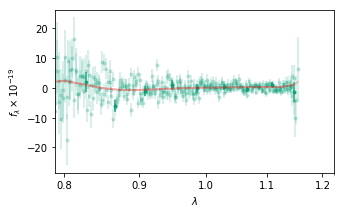

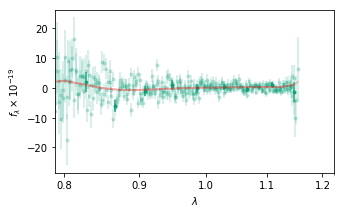

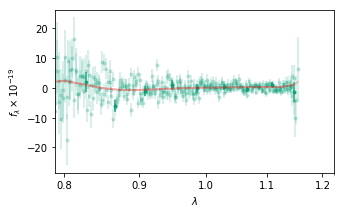

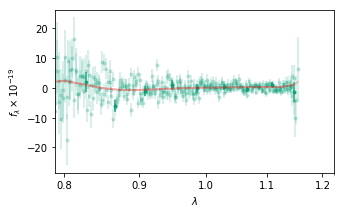

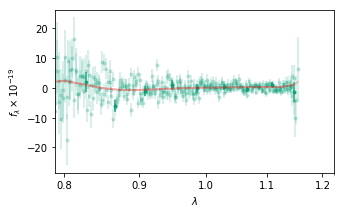

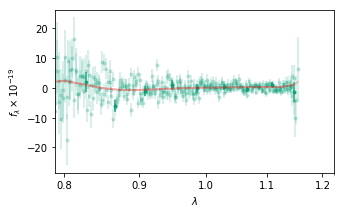

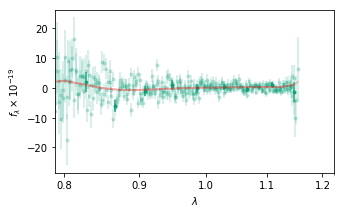

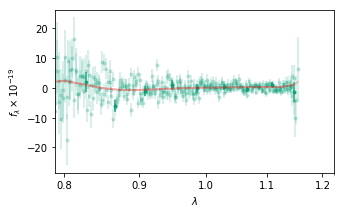

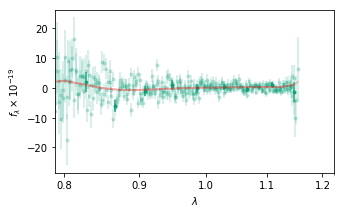

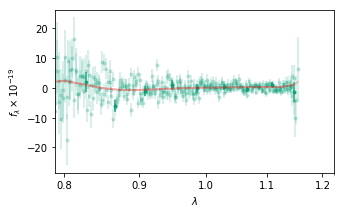

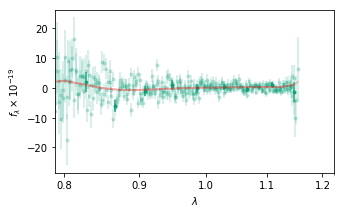

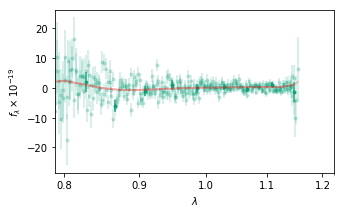

In [35]:
#id=source_ids[39]
#auto_script.extract(field_root=root, ids=[id], MW_EBV=tabs[0].meta['MW_EBV'], 
                  #  pline=pline, run_fit=True, grp=grp, diff=True)
for id_i in source_ids:
    auto_script.extract(field_root=root, prior=a, MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                           grp=grp, diff=True)

### 2D spectra ###

The spectral extraction produces two versions of the extracted 2D spectra:

* `{root}_{id:05d}.beams.fits` : Multi-extension FITS file with sets of extensions for 2D cutouts **from each individual grism exposure**.  Fitting in this space is most robust as the grism dispersion is defined in the "FLT" coordinates and the model comparison is done directly on un-resampled image pixels with relatively well-understood noise properties.
    
    
* `{root}_{id:05d}.stack.fits` : Multi-extension FITS file with extension with combinations of all exposures in a given grism & position angle.  The fitting tools can be used with these products as well, where the fits are much faster as 2D models at each trial redshift are produced for `N_PA x N_grism` combinations, where often `N_PA x N_grism << N_exposure`.   The fits are evaluated in the resampled drizzled pixel space, and they are often less robust than fits to the full "beams" spectra, particularly at low S/N.
    
    The `{root}_{id:05d}.stack.png` files, shown below, are often useful for visual inspection of the 2D products.  Note that the bottom panel of the `stack.png` files is the drizzled combination of *all* PAs for a given grism, and with a polynomial continuum model subtracted if `diff=True` in the extraction script above.
    

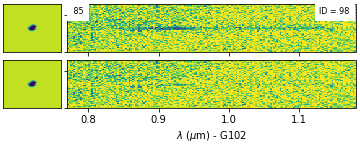

In [35]:
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

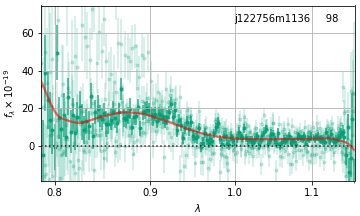

In [34]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

### Redshift fit ###

The redshift fit is performed in the following steps:

* On a coarse redshift grid (dz/1+z ~ 0.005) fit continuum templates along with **line complex** templates for a) [OII]+[NeIII], b) [OIII]+Hbeta, and c) Halpha+[SII]+weaker red lines.  These line complexes have fixed line ratios but are useful for breaking redshift degeneracies as these lines do, usually, come in groups.  Leaving all line strengths free would allow for perfect degeneracy between, e.g., Halpha and [OII] (assuming no significant continuum features).

* Find peaks (minima) in the chi-squared on the coarse grid and zoom in on them now allowing for more freedom in the indifidual line strengths, as well as fitting on a fine redshift grid sufficient to resolve the best redshift.

**NB** Continuum templates are needed in the directory `${GRIZLI}/templates`.  The template names are currently hard-coded in [multifit.py](https://github.com/gbrammer/grizli/blob/master/grizli/multifit.py) and the easiest way to make them available is to symlink them from the `data/templates` directory that accompanies the `grizli` code distribution:


### Emission line maps ###

Once we've computed the full continuum + line model, we can create 2D *drizzled* maps at any desired output wavelength, for example to make emission line maps.  This makes use of the WCS information in the individual grism FLT exposures and the outputs can have any desired WCS (e.g., pixel scale & dimensions) and can be used to compare directly to imaging data.

The emission line maps are generated by subtracting the best-fit continuum model, assuming that the direct image is representative of the continuum morphology.  This should be a reasonable assumption for objects other than, perhaps, those with extreme line equivalent widths.


In [ ]:
# Fit it.  The "run_all_parallel" function defaults to all of the parameters set in 'fit_args.npy'
for id_i in source_ids:
    fitting.run_all_parallel(id_i)

Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 3
Run 2
Run 2
Run 1
Run 5
Run 5
Run 5
Run 14
Run 6
Run 6
Run 6
Run 6
Run 5
Run 6
Run 6
Run 63
Run 23
Run 171
Run 210
Run 433
Run 470
Run 530
Run 560
Run 587
Run 605
Run 612
Run 612
Run 7
Run 7
Run 7
Run 7
Run 7
Run 7
Run 7
Run 7
Run 7
Run 7
Run 7
Run 7
Run 7
Run 7
Run 7
Run 7
Run 7
Run 7
Run 7
Run 7
Run 7
Run 7
Run 7
Run 7
Run 7
Run 7
Run 7
Run 7
Run 7
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
Run 338
R

### Fit products ###

A number of files are produced that contain the results of the redshift fit.  The [`NewSpectrumFits.ipynb`](https://github.com/gbrammer/grizli/blob/master/examples/NewSpectrumFits.ipynb) notebook describes how to interact with these products in some greater detail.  

In [37]:
files = glob.glob('*{0:05d}*'.format(id))
for file in files:
    print(file)

j122756m1136_00098.stack.png
j122756m1136_00098.line.png
j122756m1136_00098.log_par
j122756m1136_00098.full.fits
j122756m1136_00098.1D.png
j122756m1136_00098.beams.fits
j122756m1136_00098.full.png
j122756m1136_00098.1D.fits
j122756m1136_00098.stack.fits


In [38]:
for file in files:
    if not file.endswith('.fits'):
        continue
        
    im = pyfits.open(file)
    print('\n\n{1}\n{0}\n{1}\n\n'.format(file, '='*len(file)))
    im.info()



j122756m1136_00098.full.fits


Filename: j122756m1136_00098.full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      38   ()      
  1  ZFIT_STACK    1 BinTableHDU     77   392R x 6C   [D, D, 21D, 441D, D, D]   
  2  COVAR         1 ImageHDU       153   (41, 41)   float64   
  3  TEMPL         1 BinTableHDU    141   9823R x 3C   [D, D, D]   
  4  SEG           1 ImageHDU         8   (80, 80)   int32   
  5  DSCI        F105W ImageHDU        28   (80, 80)   float32   
  6  DWHT        F105W ImageHDU        28   (80, 80)   float32   
  7  LINE        OIII ImageHDU        31   (80, 80)   float32   
  8  CONTINUUM   OIII ImageHDU        31   (80, 80)   float32   
  9  CONTAM      OIII ImageHDU        31   (80, 80)   float32   
 10  LINEWHT     OIII ImageHDU        31   (80, 80)   float32   
 11  LINE        Hb  ImageHDU        31   (80, 80)   float32   
 12  CONTINUUM   Hb  ImageHDU        31   (80, 80)   float32   
 13  CONTAM      Hb 

### Continuum-dominated spectra ###

The object below is the dominated by strong Balmer break and absorption lines (see [van Dokkum & Brammer 2010](http://adsabs.harvard.edu/abs/2010ApJ...718L..73V)).  The redshift fit and spectral constraints are precise even without any supporting photometric data.

In [39]:
# Continuum source
id=source_ids[1]
auto_script.extract(field_root=root, ids=[id], MW_EBV=tabs[0].meta['MW_EBV'], 
                    pline=pline, run_fit=False, grp=grp, diff=True)

0/1: 395 2
j122756m1136_00395.beams.fits


True

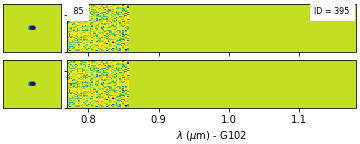

In [40]:
# Stacked 2D spectrum
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

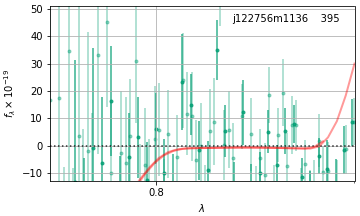

In [41]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

Run 395


(395, 1, 5.192200183868408)

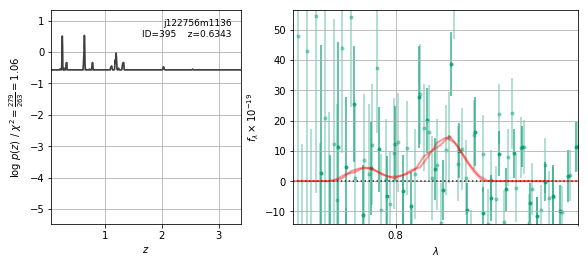

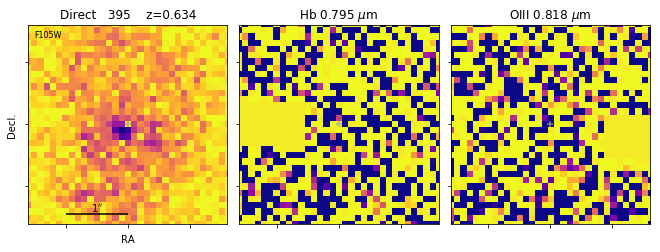

In [42]:
## Run the fit
fitting.run_all_parallel(id)

### Fit grism with photometry

Another option is fitting the grism spectra along with ancillary photometry, described here: [Fit-with-Photometry.ipynb](https://github.com/gbrammer/grizli/blob/master/examples/Fit-with-Photometry.ipynb).